In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, r2_score,
    mean_absolute_error, accuracy_score,
    f1_score, roc_auc_score,
    log_loss
)
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
B = 1
MB = 1024 * 1024
KB = 1024
GB = 1024 * 1024 * 1024
TIME_DELTA = 5000
NANO_TO_MICRO = 1000
NANO_TO_SECONDS = 1e9
NANO_SECONDS = 1
NROWS = 30e6
MAX_LEN = 5
PACKETS = "packets"
SENDS = "sends"
ALLOCS = "cpu_allocations"
KCACHE = "kcache"
DISK_READS = "disk_read"
DISK_WRITES = "disk_write"
VIRTUAL_MEMORY = "memory"
RSS_MEMORY = "rss_memory"
DATA_MEMORY = "data_memory"
S_TIME = "s_time"
U_TIME = "u_time"
PACKETS_1 = "packets_1"
PACKETS_2 = "packets_2"
PACKETS_3 = "packets_3"
PACKETS_4 = "packets_4"
PACKETS_5 = "packets_5"
TIMES_1 = "times_1"
TIMES_2 = "times_2"
TIMES_3 = "times_3"
START_TIME = 'start_time'
END_TIME = 'end_time'
SIZE = 'size'
GAP = 'gap'
NETWORK_IN = 'networkin'
NETWORK_OUT = 'networkout'
START_TIME = 'start_time'
SRC_IP = 'src_ip'
DEST_IP = 'dest_ip'
SRC_PORT = 'src_port'
DEST_PORT = 'dest_port'

NSDI_FEATURES = [DISK_READS, DISK_WRITES, VIRTUAL_MEMORY, S_TIME,
                 START_TIME, END_TIME, GAP, NETWORK_IN, SIZE,
                 NETWORK_OUT, SENDS]  # SRC_IP, DEST_IP, SRC_PORT, DEST_PORT]
ALL_FEATURES = NSDI_FEATURES + [ALLOCS, KCACHE, RSS_MEMORY, DATA_MEMORY, U_TIME, SRC_IP, DEST_IP, SRC_PORT, DEST_PORT]
FS_FEATURES = [SIZE, GAP, DISK_WRITES, DISK_READS, VIRTUAL_MEMORY, NETWORK_IN, NETWORK_OUT]
LIM_FEATURES = [SIZE, START_TIME, GAP,  SRC_IP, DEST_IP, SRC_PORT, DEST_PORT]
FULL_PATH = "../test-100-1000-node-1-1/"

In [4]:
def calculate_scaling(df):
    scaling = {}
    for column in df.columns:
        scaling[column] = float(df[column].max())
    return scaling

def prepare_files(df, window_size, scaling, target_column='size'):
    # df = df.apply((lambda x: resize(x, scaling)), axis=0)
    flow_size = df[target_column]
    df[target_column] = flow_size
    # extend the window
    final_df = df.copy()
    for sample_num in range(1, window_size):
        shifted = df.shift(sample_num)
        shifted.columns = map(lambda x: x+str(sample_num), shifted.columns)
        final_df = pd.concat([shifted, final_df], axis=1)

    final_df = final_df.fillna(0)
    final_df = final_df.drop(target_column, axis=1)

    return (final_df, flow_size.values)

def make_io(f_df, f_size):
    i_data = f_df.values
    o_data = f_size
    return (i_data, o_data)

def resize(s, scaling):
    return (s / scaling[s.name])

def print_metrics(real, prediction):
    mse = mean_squared_error(real, prediction)
    mae = mean_absolute_error(real, prediction)
    r2 = r2_score(real, prediction)
    scores = {'mse': mse, 'mae': mae, 'r2': r2}
    return scores

def print_performance(file, model, scaling):
    df, flow_size = prepare_files(
        file,
        WINDOW_SIZE,
        scaling,
        'size'
    )
    inputs, outputs = make_io(df, flow_size)
    y_pred = model.predict(inputs)
    return print_metrics(
        outputs, y_pred
    )

In [5]:
WINDOW_SIZE = 5
params = {
    'n_estimators': [5, 10, 15, 20, 25, 30],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'colsample_bytree': [0.45, 0.65, 0.85],
    'alpha': [1, 2, 3, 4],
    'colsample_bylevel': [0.35, 0.45, 0.65, 0.85],
    'gamma': [0, 0.15, 0.25, 0.35],
    'min_child_weight': [1, 5, 10],
}

In [9]:
# total = 7000000
results = []
for td in range(500, 10200, 250):
    print(td)
    flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[:2_500_000]
    flows_train, flows_test = train_test_split(
        flows_df, shuffle=False, test_size=0.3
    )
    scaling = calculate_scaling(flows_train)
    df, flow_size = prepare_files(
        flows_train,
        WINDOW_SIZE,
        scaling,
        'size'
    )
    inputs, outputs = make_io(df, flow_size)
    model = xgb.XGBRegressor(booster='gbtree', predictor="gpu_predictor", tree_method='gpu_hist', objective='reg:squarederror')
    grid = RandomizedSearchCV(model, params, n_iter=300, scoring='r2', cv=2)
    grid.fit(inputs, outputs)
    result = {}
    model = grid.best_estimator_
    flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_train, flows_test = train_test_split(
        flows_df, shuffle=False, test_size=0.3
    )
    scaling = calculate_scaling(flows_train)
    df, flow_size = prepare_files(flows_train, WINDOW_SIZE, scaling, 'size')
    inputs, outputs = make_io(df, flow_size)
    model = model.fit(inputs, outputs)
    result['train'] = print_performance(
        flows_train, model, scaling
    )
    result['test'] = print_performance(
        flows_test, model, scaling
    )

    results.append(result)

500



KeyboardInterrupt



In [10]:
inputs

array([[0.        , 0.        , 0.        , ..., 1.        , 0.99169581,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.99169581,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.99169581,
        0.        ],
       ...,
       [1.        , 0.99999992, 0.03978495, ..., 1.        , 1.        ,
        0.        ],
       [1.        , 0.99999993, 0.18172043, ..., 1.        , 1.        ,
        0.        ],
       [1.        , 0.99999992, 0.03978495, ..., 1.        , 1.        ,
        0.        ]])

In [7]:
results2 = []
for td in range(500, 10200, 250):
    print(td)
    flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[:2_500_000]
    flows_df = flows_df[NSDI_FEATURES]
    flows_train, flows_test = train_test_split(
        flows_df, shuffle=False, test_size=0.3
    )
    scaling = calculate_scaling(flows_train)
    df, flow_size = prepare_files(
        flows_train,
        WINDOW_SIZE,
        scaling,
        'size'
    )
    inputs, outputs = make_io(df, flow_size)
    model = xgb.XGBRegressor(booster='gbtree', predictor="gpu_predictor", tree_method='gpu_hist', objective='reg:squarederror')
    grid = RandomizedSearchCV(model, params, n_iter=1000, scoring='r2', cv=2)
    grid.fit(inputs, outputs)
    result = {}
    model = grid.best_estimator_
    flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[NSDI_FEATURES]
    flows_train, flows_test = train_test_split(
        flows_df, shuffle=False, test_size=0.3
    )
    scaling = calculate_scaling(flows_train)
    df, flow_size = prepare_files(flows_train, WINDOW_SIZE, scaling, 'size')
    inputs, outputs = make_io(df, flow_size)
    model = model.fit(inputs, outputs)
    result['train'] = print_performance(
        flows_train, model, scaling
    )
    result['test'] = print_performance(
        flows_test, model, scaling
    )
    results2.append(result)

500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000


In [21]:
results3 = []
for td in range(500, 10200, 250):
    print(td)
    flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[:2_500_000]
    flows_df = flows_df[FS_FEATURES]
    flows_train, flows_test = train_test_split(
        flows_df, shuffle=False, test_size=0.3
    )
    scaling = calculate_scaling(flows_train)
    df, flow_size = prepare_files(
        flows_train,
        WINDOW_SIZE,
        scaling,
        'size'
    )
    inputs, outputs = make_io(df, flow_size)
    model = xgb.XGBRegressor(booster='gbtree', predictor="gpu_predictor", tree_method='gpu_hist', objective='reg:squarederror')
    grid = RandomizedSearchCV(model, params, n_iter=1000, scoring='r2', cv=2)
    grid.fit(inputs, outputs)
    result = {}
    model = grid.best_estimator_
    flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[NSDI_FEATURES]
    flows_train, flows_test = train_test_split(
        flows_df, shuffle=False, test_size=0.3
    )
    scaling = calculate_scaling(flows_train)
    df, flow_size = prepare_files(flows_train, WINDOW_SIZE, scaling, 'size')
    inputs, outputs = make_io(df, flow_size)
    model = model.fit(inputs, outputs)
    result['train'] = print_performance(
        flows_train, model, scaling
    )
    result['test'] = print_performance(
        flows_test, model, scaling
    )
    results3.append(result)

500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

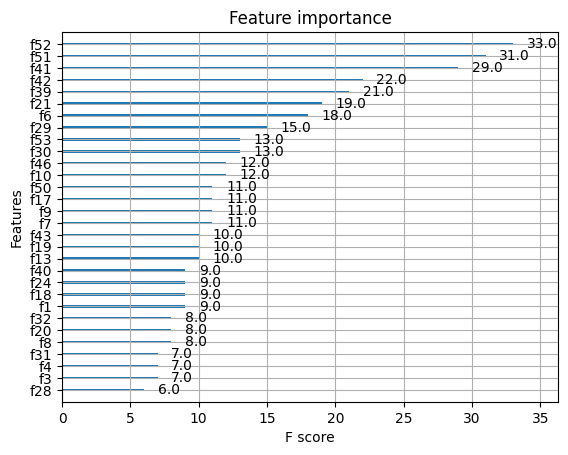

In [11]:
from xgboost import plot_importance
plot_importance(model, max_num_features=30)

In [19]:
imp = zip(df.columns,model.feature_importances_)
sorted(list(imp), key=lambda x: x[1])

[('disk_read2', 0.0),
 ('disk_write2', 0.0),
 ('end_time2', 0.0),
 ('disk_read1', 0.0),
 ('disk_write1', 0.0),
 ('disk_write', 0.0),
 ('s_time', 0.0),
 ('start_time', 0.0),
 ('disk_write3', 0.0013206182),
 ('end_time3', 0.0017982806),
 ('gap1', 0.002051848),
 ('disk_write4', 0.0022325956),
 ('end_time', 0.0023706146),
 ('disk_read', 0.0025578805),
 ('start_time2', 0.0027468628),
 ('gap3', 0.002836929),
 ('s_time4', 0.0031603803),
 ('start_time1', 0.0031709282),
 ('s_time1', 0.0034587164),
 ('start_time4', 0.0040700133),
 ('networkout1', 0.004274552),
 ('sends2', 0.0047541433),
 ('memory4', 0.0051928894),
 ('sends', 0.0054440964),
 ('networkout4', 0.005494587),
 ('sends3', 0.0057045957),
 ('gap4', 0.005784245),
 ('networkout3', 0.0062687993),
 ('s_time3', 0.00675632),
 ('networkin2', 0.0067838132),
 ('sends1', 0.0070652524),
 ('s_time2', 0.0071969694),
 ('size4', 0.0076647224),
 ('networkin4', 0.007758811),
 ('start_time3', 0.008594882),
 ('memory', 0.009610434),
 ('memory2', 0.01061165

In [ ]:
model.get_booster().get_score(importance_type='gain')

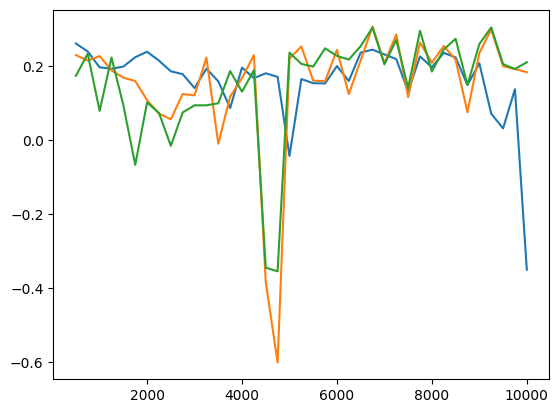

In [22]:
times = list(range(500, 10200, 250))
r2sa = list(map(lambda x: x['test']['r2'], results))
r2sb = list(map(lambda x: x['test']['r2'], results2))
r2sc = list(map(lambda x: x['test']['r2'], results3))

plt.plot(times, r2sa)
plt.plot(times, r2sb)
plt.plot(times, r2sc)

In [21]:
results

[{'train': {'mse': 0.0018877128540408536,
   'mae': 0.017502172333625356,
   'r2': 0.35386986123385455},
  'test': {'mse': 0.0017408549070861777,
   'mae': 0.01843305485599404,
   'r2': 0.2596896046524061}},
 {'train': {'mse': 0.0019199490019480407,
   'mae': 0.017329363752298325,
   'r2': 0.36226143703528846},
  'test': {'mse': 0.0018748070062722863,
   'mae': 0.019602456489026764,
   'r2': 0.2271897800162782}},
 {'train': {'mse': 0.0021727119666070803,
   'mae': 0.018450849894894015,
   'r2': 0.3710905788780623},
  'test': {'mse': 0.0021597452154527193,
   'mae': 0.021142851452326344,
   'r2': 0.2270851432989235}},
 {'train': {'mse': 0.001691421978974007,
   'mae': 0.016398834286159573,
   'r2': 0.38909433920945724},
  'test': {'mse': 0.0017567140590106338,
   'mae': 0.020159492988574793,
   'r2': 0.19508446658283773}},
 {'train': {'mse': 0.0017033391441045513,
   'mae': 0.016640449931408462,
   'r2': 0.4866696805035412},
  'test': {'mse': 0.0021050696698519836,
   'mae': 0.021793665

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
td = 4500
flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
flows_df  = flows_df[flows_df['gap'] >= 0]
flows_df = flows_df[NSDI_FEATURES]
cor = flows_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cor, annot=True)

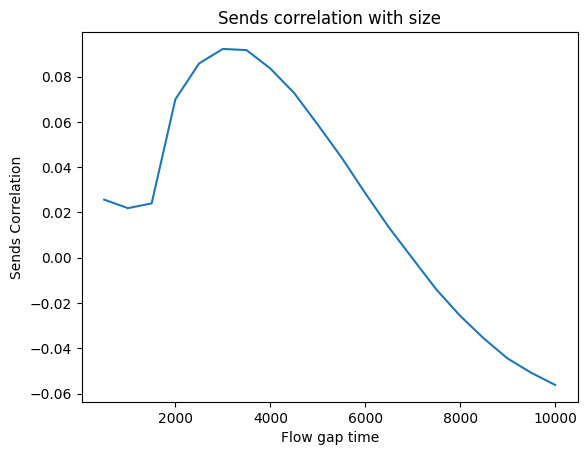

In [22]:
times = range(500, 10200, 500)
y = []
x = times
for td in times:
    path = f"{FULL_PATH}/{td}/full.csv"
    flows_df = pd.read_csv(path)
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[NSDI_FEATURES]
    cor = flows_df.corr()
    c = cor['size']['sends']
    y.append(c)
plt.xlabel('Flow gap time')
plt.ylabel('Sends Correlation')
plt.title("Sends correlation with size")
plt.plot(x, y)
plt.show()

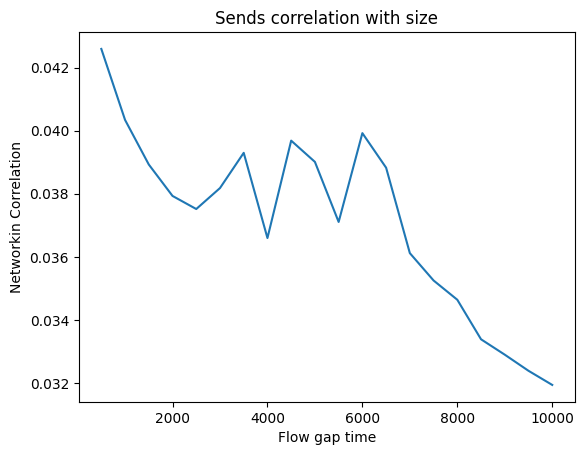

In [23]:
times = range(500, 10200, 500)
y = []
x = times
for td in times:
    path = f"{FULL_PATH}/{td}/full.csv"
    flows_df = pd.read_csv(path)
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[NSDI_FEATURES]
    cor = flows_df.corr()
    c = cor['size']['networkin']
    y.append(c)
plt.xlabel('Flow gap time')
plt.ylabel('Networkin Correlation')
plt.title("Sends correlation with size")
plt.plot(x, y)
plt.show()

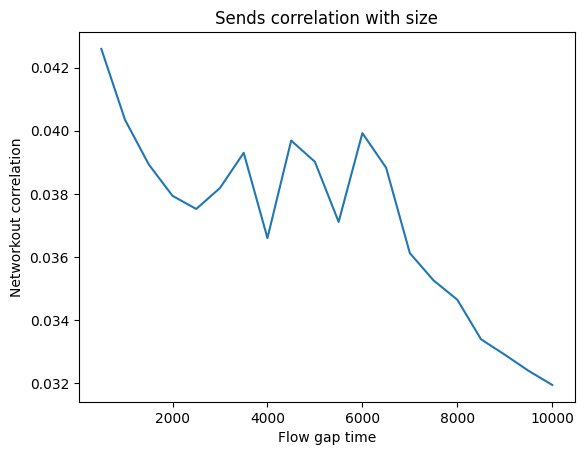

In [24]:
times = range(500, 10200, 500)
y = []
x = times
for td in times:
    path = f"{FULL_PATH}/{td}/full.csv"
    flows_df = pd.read_csv(path)
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[NSDI_FEATURES]
    cor = flows_df.corr()
    c = cor['size']['networkout']
    y.append(c)
plt.xlabel('Flow gap time')
plt.ylabel('Networkout correlation')
plt.title("Sends correlation with size")
plt.plot(x, y)
plt.show()

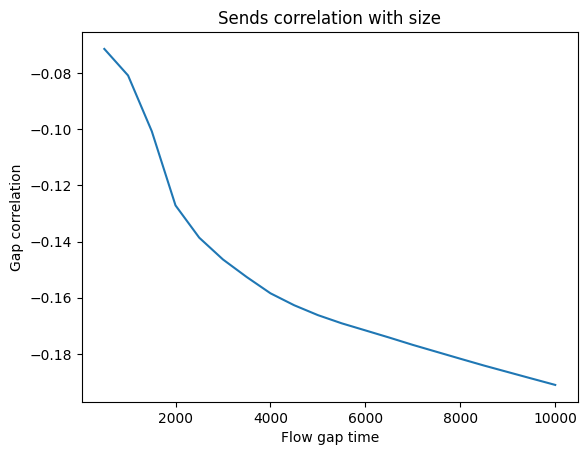

In [25]:
times = range(500, 10200, 500)
y = []
x = times
for td in times:
    path = f"{FULL_PATH}/{td}/full.csv"
    flows_df = pd.read_csv(path)
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[NSDI_FEATURES]
    cor = flows_df.corr()
    c = cor['size']['gap']
    y.append(c)
plt.xlabel('Flow gap time')
plt.ylabel('Gap correlation')
plt.title("Sends correlation with size")
plt.plot(x, y)
plt.show()

In [5]:
from cuml import LinearRegression
from cuml.metrics import mean_squared_error

model = LinearRegression()
model.fit(inputs, outputs)

ImportError: 
================================================================
Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcufft.so.10: cannot open shared object file: No such file or directory
================================================================


In [6]:
result = {}
result['train'] = print_performance(
    flows_train, model, scaling
)
result['test'] = print_performance(
    flows_test, model, scaling
)

result

NameError: name 'flows_train' is not defined

In [6]:
from catboost import CatBoostRegressor
results2 = []
for td in range(500, 10200, 250):
    print(td)
    flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[LIM_FEATURES]    
    flows_train, flows_test = train_test_split(
        flows_df, shuffle=False, test_size=0.3
    )
    scaling = calculate_scaling(flows_train)
    df, flow_size = prepare_files(
        flows_train,
        WINDOW_SIZE,
        scaling,
        'size'
    )
    inputs, outputs = make_io(df, flow_size)
    model = CatBoostRegressor(iterations=1000,task_type="GPU",devices='0:1')
    model = model.fit(inputs, outputs)
    result = {}
    result['train'] = print_performance(
        flows_train, model, scaling
    )
    result['test'] = print_performance(
        flows_test, model, scaling
    )
    results2.append(result)

500
Learning rate set to 0.130761
0:	learn: 2.3985764	total: 18.5ms	remaining: 18.4s
1:	learn: 2.3976562	total: 36.1ms	remaining: 18s
2:	learn: 2.3957856	total: 54.2ms	remaining: 18s
3:	learn: 2.3954078	total: 73.1ms	remaining: 18.2s
4:	learn: 2.3942075	total: 93.7ms	remaining: 18.6s
5:	learn: 2.3924335	total: 113ms	remaining: 18.8s
6:	learn: 2.3918577	total: 133ms	remaining: 18.9s
7:	learn: 2.3911948	total: 151ms	remaining: 18.8s
8:	learn: 2.3892918	total: 171ms	remaining: 18.8s
9:	learn: 2.3876539	total: 189ms	remaining: 18.7s
10:	learn: 2.3859164	total: 207ms	remaining: 18.6s
11:	learn: 2.3838764	total: 226ms	remaining: 18.6s
12:	learn: 2.3826851	total: 244ms	remaining: 18.5s
13:	learn: 2.3809557	total: 262ms	remaining: 18.4s
14:	learn: 2.3802111	total: 280ms	remaining: 18.4s
15:	learn: 2.3787072	total: 300ms	remaining: 18.4s
16:	learn: 2.3770848	total: 318ms	remaining: 18.4s
17:	learn: 2.3769286	total: 336ms	remaining: 18.3s
18:	learn: 2.3758017	total: 355ms	remaining: 18.3s
19:	le

169:	learn: 2.2518276	total: 3.12s	remaining: 15.2s
170:	learn: 2.2512658	total: 3.13s	remaining: 15.2s
171:	learn: 2.2508439	total: 3.15s	remaining: 15.2s
172:	learn: 2.2503814	total: 3.17s	remaining: 15.2s
173:	learn: 2.2496274	total: 3.19s	remaining: 15.1s
174:	learn: 2.2486904	total: 3.21s	remaining: 15.1s
175:	learn: 2.2479469	total: 3.22s	remaining: 15.1s
176:	learn: 2.2477703	total: 3.24s	remaining: 15.1s
177:	learn: 2.2475967	total: 3.26s	remaining: 15.1s
178:	learn: 2.2473355	total: 3.28s	remaining: 15s
179:	learn: 2.2461698	total: 3.3s	remaining: 15s
180:	learn: 2.2457394	total: 3.32s	remaining: 15s
181:	learn: 2.2451755	total: 3.33s	remaining: 15s
182:	learn: 2.2446813	total: 3.35s	remaining: 15s
183:	learn: 2.2431768	total: 3.37s	remaining: 15s
184:	learn: 2.2431304	total: 3.39s	remaining: 14.9s
185:	learn: 2.2424054	total: 3.41s	remaining: 14.9s
186:	learn: 2.2421724	total: 3.43s	remaining: 14.9s
187:	learn: 2.2417737	total: 3.45s	remaining: 14.9s
188:	learn: 2.2406997	tot

336:	learn: 2.1488925	total: 6.17s	remaining: 12.1s
337:	learn: 2.1476233	total: 6.19s	remaining: 12.1s
338:	learn: 2.1466733	total: 6.21s	remaining: 12.1s
339:	learn: 2.1466416	total: 6.22s	remaining: 12.1s
340:	learn: 2.1463086	total: 6.24s	remaining: 12.1s
341:	learn: 2.1462331	total: 6.26s	remaining: 12s
342:	learn: 2.1462103	total: 6.28s	remaining: 12s
343:	learn: 2.1456573	total: 6.3s	remaining: 12s
344:	learn: 2.1449070	total: 6.32s	remaining: 12s
345:	learn: 2.1447337	total: 6.33s	remaining: 12s
346:	learn: 2.1441424	total: 6.35s	remaining: 12s
347:	learn: 2.1439292	total: 6.37s	remaining: 11.9s
348:	learn: 2.1427362	total: 6.39s	remaining: 11.9s
349:	learn: 2.1419197	total: 6.41s	remaining: 11.9s
350:	learn: 2.1418429	total: 6.43s	remaining: 11.9s
351:	learn: 2.1416109	total: 6.45s	remaining: 11.9s
352:	learn: 2.1414659	total: 6.46s	remaining: 11.8s
353:	learn: 2.1404831	total: 6.48s	remaining: 11.8s
354:	learn: 2.1401042	total: 6.5s	remaining: 11.8s
355:	learn: 2.1398793	tota

504:	learn: 2.0725571	total: 9.25s	remaining: 9.07s
505:	learn: 2.0724066	total: 9.27s	remaining: 9.05s
506:	learn: 2.0720397	total: 9.29s	remaining: 9.03s
507:	learn: 2.0719787	total: 9.31s	remaining: 9.01s
508:	learn: 2.0713192	total: 9.32s	remaining: 8.99s
509:	learn: 2.0711261	total: 9.34s	remaining: 8.98s
510:	learn: 2.0709054	total: 9.36s	remaining: 8.96s
511:	learn: 2.0707880	total: 9.38s	remaining: 8.94s
512:	learn: 2.0704654	total: 9.4s	remaining: 8.92s
513:	learn: 2.0699038	total: 9.42s	remaining: 8.9s
514:	learn: 2.0691617	total: 9.43s	remaining: 8.88s
515:	learn: 2.0682321	total: 9.45s	remaining: 8.87s
516:	learn: 2.0680886	total: 9.47s	remaining: 8.85s
517:	learn: 2.0665235	total: 9.49s	remaining: 8.83s
518:	learn: 2.0663999	total: 9.51s	remaining: 8.81s
519:	learn: 2.0663564	total: 9.53s	remaining: 8.79s
520:	learn: 2.0661666	total: 9.54s	remaining: 8.77s
521:	learn: 2.0653194	total: 9.56s	remaining: 8.76s
522:	learn: 2.0647009	total: 9.58s	remaining: 8.74s
523:	learn: 2.

671:	learn: 2.0070816	total: 12.3s	remaining: 6.01s
672:	learn: 2.0068382	total: 12.3s	remaining: 5.99s
673:	learn: 2.0067061	total: 12.3s	remaining: 5.97s
674:	learn: 2.0061533	total: 12.4s	remaining: 5.95s
675:	learn: 2.0055604	total: 12.4s	remaining: 5.94s
676:	learn: 2.0054255	total: 12.4s	remaining: 5.92s
677:	learn: 2.0052407	total: 12.4s	remaining: 5.9s
678:	learn: 2.0051044	total: 12.4s	remaining: 5.88s
679:	learn: 2.0050992	total: 12.5s	remaining: 5.86s
680:	learn: 2.0049270	total: 12.5s	remaining: 5.84s
681:	learn: 2.0047422	total: 12.5s	remaining: 5.83s
682:	learn: 2.0039418	total: 12.5s	remaining: 5.81s
683:	learn: 2.0038373	total: 12.5s	remaining: 5.79s
684:	learn: 2.0037200	total: 12.6s	remaining: 5.77s
685:	learn: 2.0036402	total: 12.6s	remaining: 5.75s
686:	learn: 2.0034267	total: 12.6s	remaining: 5.74s
687:	learn: 2.0029243	total: 12.6s	remaining: 5.72s
688:	learn: 2.0028623	total: 12.6s	remaining: 5.7s
689:	learn: 2.0028490	total: 12.6s	remaining: 5.68s
690:	learn: 2.

840:	learn: 1.9595325	total: 15.4s	remaining: 2.91s
841:	learn: 1.9595149	total: 15.4s	remaining: 2.9s
842:	learn: 1.9594819	total: 15.4s	remaining: 2.88s
843:	learn: 1.9593461	total: 15.5s	remaining: 2.86s
844:	learn: 1.9591903	total: 15.5s	remaining: 2.84s
845:	learn: 1.9574191	total: 15.5s	remaining: 2.82s
846:	learn: 1.9573314	total: 15.5s	remaining: 2.8s
847:	learn: 1.9572921	total: 15.5s	remaining: 2.79s
848:	learn: 1.9571011	total: 15.6s	remaining: 2.77s
849:	learn: 1.9569721	total: 15.6s	remaining: 2.75s
850:	learn: 1.9564733	total: 15.6s	remaining: 2.73s
851:	learn: 1.9562906	total: 15.6s	remaining: 2.71s
852:	learn: 1.9560003	total: 15.6s	remaining: 2.69s
853:	learn: 1.9556637	total: 15.6s	remaining: 2.67s
854:	learn: 1.9553640	total: 15.7s	remaining: 2.66s
855:	learn: 1.9546130	total: 15.7s	remaining: 2.64s
856:	learn: 1.9545715	total: 15.7s	remaining: 2.62s
857:	learn: 1.9535806	total: 15.7s	remaining: 2.6s
858:	learn: 1.9534680	total: 15.7s	remaining: 2.58s
859:	learn: 1.9

750
Learning rate set to 0.130761
0:	learn: 2.5757707	total: 18.8ms	remaining: 18.8s
1:	learn: 2.5740831	total: 38.2ms	remaining: 19.1s
2:	learn: 2.5724237	total: 57.5ms	remaining: 19.1s
3:	learn: 2.5713259	total: 76.8ms	remaining: 19.1s
4:	learn: 2.5698021	total: 96.2ms	remaining: 19.1s
5:	learn: 2.5683760	total: 114ms	remaining: 18.8s
6:	learn: 2.5679965	total: 133ms	remaining: 18.8s
7:	learn: 2.5663617	total: 151ms	remaining: 18.7s
8:	learn: 2.5657824	total: 169ms	remaining: 18.7s
9:	learn: 2.5642494	total: 188ms	remaining: 18.6s
10:	learn: 2.5641390	total: 206ms	remaining: 18.5s
11:	learn: 2.5640945	total: 224ms	remaining: 18.5s
12:	learn: 2.5628075	total: 243ms	remaining: 18.5s
13:	learn: 2.5624430	total: 260ms	remaining: 18.3s
14:	learn: 2.5610385	total: 279ms	remaining: 18.3s
15:	learn: 2.5597273	total: 298ms	remaining: 18.3s
16:	learn: 2.5596695	total: 315ms	remaining: 18.2s
17:	learn: 2.5594541	total: 334ms	remaining: 18.2s
18:	learn: 2.5594127	total: 352ms	remaining: 18.2s
19

161:	learn: 2.4766271	total: 2.97s	remaining: 15.4s
162:	learn: 2.4759975	total: 2.99s	remaining: 15.4s
163:	learn: 2.4758164	total: 3.01s	remaining: 15.3s
164:	learn: 2.4746222	total: 3.03s	remaining: 15.3s
165:	learn: 2.4733227	total: 3.04s	remaining: 15.3s
166:	learn: 2.4721966	total: 3.06s	remaining: 15.3s
167:	learn: 2.4714561	total: 3.08s	remaining: 15.3s
168:	learn: 2.4711092	total: 3.1s	remaining: 15.2s
169:	learn: 2.4710909	total: 3.12s	remaining: 15.2s
170:	learn: 2.4706971	total: 3.14s	remaining: 15.2s
171:	learn: 2.4699575	total: 3.15s	remaining: 15.2s
172:	learn: 2.4677192	total: 3.17s	remaining: 15.2s
173:	learn: 2.4676544	total: 3.19s	remaining: 15.1s
174:	learn: 2.4676386	total: 3.21s	remaining: 15.1s
175:	learn: 2.4676310	total: 3.23s	remaining: 15.1s
176:	learn: 2.4674726	total: 3.25s	remaining: 15.1s
177:	learn: 2.4672933	total: 3.27s	remaining: 15.1s
178:	learn: 2.4672425	total: 3.28s	remaining: 15.1s
179:	learn: 2.4662668	total: 3.3s	remaining: 15s
180:	learn: 2.46

326:	learn: 2.3864390	total: 6.03s	remaining: 12.4s
327:	learn: 2.3863049	total: 6.05s	remaining: 12.4s
328:	learn: 2.3855928	total: 6.07s	remaining: 12.4s
329:	learn: 2.3854923	total: 6.08s	remaining: 12.4s
330:	learn: 2.3845328	total: 6.1s	remaining: 12.3s
331:	learn: 2.3845293	total: 6.12s	remaining: 12.3s
332:	learn: 2.3843776	total: 6.14s	remaining: 12.3s
333:	learn: 2.3843374	total: 6.16s	remaining: 12.3s
334:	learn: 2.3841618	total: 6.18s	remaining: 12.3s
335:	learn: 2.3839789	total: 6.2s	remaining: 12.2s
336:	learn: 2.3837983	total: 6.22s	remaining: 12.2s
337:	learn: 2.3829537	total: 6.24s	remaining: 12.2s
338:	learn: 2.3829052	total: 6.25s	remaining: 12.2s
339:	learn: 2.3828570	total: 6.27s	remaining: 12.2s
340:	learn: 2.3828172	total: 6.29s	remaining: 12.2s
341:	learn: 2.3826737	total: 6.31s	remaining: 12.1s
342:	learn: 2.3825507	total: 6.33s	remaining: 12.1s
343:	learn: 2.3821865	total: 6.35s	remaining: 12.1s
344:	learn: 2.3814435	total: 6.37s	remaining: 12.1s
345:	learn: 2.

492:	learn: 2.3205631	total: 9.1s	remaining: 9.36s
493:	learn: 2.3204709	total: 9.12s	remaining: 9.35s
494:	learn: 2.3203797	total: 9.14s	remaining: 9.33s
495:	learn: 2.3202525	total: 9.16s	remaining: 9.31s
496:	learn: 2.3196853	total: 9.18s	remaining: 9.29s
497:	learn: 2.3178282	total: 9.2s	remaining: 9.27s
498:	learn: 2.3173953	total: 9.22s	remaining: 9.26s
499:	learn: 2.3170525	total: 9.24s	remaining: 9.24s
500:	learn: 2.3160843	total: 9.26s	remaining: 9.22s
501:	learn: 2.3156983	total: 9.27s	remaining: 9.2s
502:	learn: 2.3155462	total: 9.29s	remaining: 9.18s
503:	learn: 2.3152080	total: 9.31s	remaining: 9.16s
504:	learn: 2.3151601	total: 9.33s	remaining: 9.14s
505:	learn: 2.3142344	total: 9.35s	remaining: 9.13s
506:	learn: 2.3141201	total: 9.37s	remaining: 9.11s
507:	learn: 2.3140266	total: 9.38s	remaining: 9.09s
508:	learn: 2.3136790	total: 9.4s	remaining: 9.07s
509:	learn: 2.3128124	total: 9.42s	remaining: 9.05s
510:	learn: 2.3125252	total: 9.44s	remaining: 9.03s
511:	learn: 2.31

658:	learn: 2.2612381	total: 12.2s	remaining: 6.3s
659:	learn: 2.2608802	total: 12.2s	remaining: 6.28s
660:	learn: 2.2600149	total: 12.2s	remaining: 6.26s
661:	learn: 2.2600101	total: 12.2s	remaining: 6.24s
662:	learn: 2.2599157	total: 12.2s	remaining: 6.22s
663:	learn: 2.2596399	total: 12.3s	remaining: 6.2s
664:	learn: 2.2595838	total: 12.3s	remaining: 6.19s
665:	learn: 2.2594971	total: 12.3s	remaining: 6.17s
666:	learn: 2.2593043	total: 12.3s	remaining: 6.15s
667:	learn: 2.2586911	total: 12.3s	remaining: 6.13s
668:	learn: 2.2584531	total: 12.4s	remaining: 6.11s
669:	learn: 2.2583876	total: 12.4s	remaining: 6.09s
670:	learn: 2.2570025	total: 12.4s	remaining: 6.08s
671:	learn: 2.2568167	total: 12.4s	remaining: 6.06s
672:	learn: 2.2567651	total: 12.4s	remaining: 6.04s
673:	learn: 2.2566425	total: 12.4s	remaining: 6.02s
674:	learn: 2.2565966	total: 12.5s	remaining: 6s
675:	learn: 2.2563831	total: 12.5s	remaining: 5.98s
676:	learn: 2.2563614	total: 12.5s	remaining: 5.96s
677:	learn: 2.256

824:	learn: 2.2265632	total: 15.2s	remaining: 3.23s
825:	learn: 2.2265050	total: 15.3s	remaining: 3.21s
826:	learn: 2.2261263	total: 15.3s	remaining: 3.19s
827:	learn: 2.2255889	total: 15.3s	remaining: 3.17s
828:	learn: 2.2255792	total: 15.3s	remaining: 3.16s
829:	learn: 2.2252281	total: 15.3s	remaining: 3.14s
830:	learn: 2.2251331	total: 15.3s	remaining: 3.12s
831:	learn: 2.2247871	total: 15.4s	remaining: 3.1s
832:	learn: 2.2246835	total: 15.4s	remaining: 3.08s
833:	learn: 2.2242201	total: 15.4s	remaining: 3.06s
834:	learn: 2.2240292	total: 15.4s	remaining: 3.05s
835:	learn: 2.2235528	total: 15.4s	remaining: 3.03s
836:	learn: 2.2234345	total: 15.5s	remaining: 3.01s
837:	learn: 2.2233149	total: 15.5s	remaining: 2.99s
838:	learn: 2.2231985	total: 15.5s	remaining: 2.97s
839:	learn: 2.2231668	total: 15.5s	remaining: 2.95s
840:	learn: 2.2231522	total: 15.5s	remaining: 2.94s
841:	learn: 2.2231284	total: 15.5s	remaining: 2.92s
842:	learn: 2.2230229	total: 15.6s	remaining: 2.9s
843:	learn: 2.

990:	learn: 2.1889325	total: 18.3s	remaining: 166ms
991:	learn: 2.1887867	total: 18.3s	remaining: 148ms
992:	learn: 2.1887413	total: 18.3s	remaining: 129ms
993:	learn: 2.1887237	total: 18.4s	remaining: 111ms
994:	learn: 2.1884853	total: 18.4s	remaining: 92.3ms
995:	learn: 2.1884374	total: 18.4s	remaining: 73.9ms
996:	learn: 2.1882311	total: 18.4s	remaining: 55.4ms
997:	learn: 2.1880839	total: 18.4s	remaining: 36.9ms
998:	learn: 2.1875557	total: 18.4s	remaining: 18.5ms
999:	learn: 2.1873379	total: 18.5s	remaining: 0us
1000
Learning rate set to 0.13076
0:	learn: 2.8485593	total: 20.7ms	remaining: 20.7s
1:	learn: 2.8477344	total: 40.3ms	remaining: 20.1s
2:	learn: 2.8474430	total: 60ms	remaining: 20s
3:	learn: 2.8472073	total: 79.6ms	remaining: 19.8s
4:	learn: 2.8470055	total: 98.8ms	remaining: 19.7s
5:	learn: 2.8463506	total: 119ms	remaining: 19.8s
6:	learn: 2.8462646	total: 139ms	remaining: 19.6s
7:	learn: 2.8456344	total: 158ms	remaining: 19.6s
8:	learn: 2.8455833	total: 179ms	remaining

150:	learn: 2.7863639	total: 2.77s	remaining: 15.6s
151:	learn: 2.7863569	total: 2.79s	remaining: 15.6s
152:	learn: 2.7859643	total: 2.81s	remaining: 15.5s
153:	learn: 2.7847050	total: 2.83s	remaining: 15.5s
154:	learn: 2.7845200	total: 2.84s	remaining: 15.5s
155:	learn: 2.7841617	total: 2.86s	remaining: 15.5s
156:	learn: 2.7841403	total: 2.88s	remaining: 15.5s
157:	learn: 2.7833734	total: 2.9s	remaining: 15.5s
158:	learn: 2.7830125	total: 2.92s	remaining: 15.4s
159:	learn: 2.7829795	total: 2.94s	remaining: 15.4s
160:	learn: 2.7828410	total: 2.96s	remaining: 15.4s
161:	learn: 2.7827140	total: 2.97s	remaining: 15.4s
162:	learn: 2.7826864	total: 2.99s	remaining: 15.4s
163:	learn: 2.7826000	total: 3.01s	remaining: 15.3s
164:	learn: 2.7825542	total: 3.03s	remaining: 15.3s
165:	learn: 2.7815865	total: 3.05s	remaining: 15.3s
166:	learn: 2.7814471	total: 3.07s	remaining: 15.3s
167:	learn: 2.7813366	total: 3.08s	remaining: 15.3s
168:	learn: 2.7793298	total: 3.1s	remaining: 15.3s
169:	learn: 2.

315:	learn: 2.7351555	total: 5.84s	remaining: 12.6s
316:	learn: 2.7345445	total: 5.86s	remaining: 12.6s
317:	learn: 2.7345251	total: 5.88s	remaining: 12.6s
318:	learn: 2.7342537	total: 5.9s	remaining: 12.6s
319:	learn: 2.7341271	total: 5.91s	remaining: 12.6s
320:	learn: 2.7339064	total: 5.93s	remaining: 12.5s
321:	learn: 2.7337381	total: 5.95s	remaining: 12.5s
322:	learn: 2.7336490	total: 5.97s	remaining: 12.5s
323:	learn: 2.7326919	total: 5.99s	remaining: 12.5s
324:	learn: 2.7314104	total: 6.01s	remaining: 12.5s
325:	learn: 2.7313695	total: 6.02s	remaining: 12.5s
326:	learn: 2.7312405	total: 6.04s	remaining: 12.4s
327:	learn: 2.7300294	total: 6.06s	remaining: 12.4s
328:	learn: 2.7295287	total: 6.08s	remaining: 12.4s
329:	learn: 2.7293146	total: 6.1s	remaining: 12.4s
330:	learn: 2.7291497	total: 6.12s	remaining: 12.4s
331:	learn: 2.7288765	total: 6.13s	remaining: 12.3s
332:	learn: 2.7281786	total: 6.15s	remaining: 12.3s
333:	learn: 2.7275191	total: 6.17s	remaining: 12.3s
334:	learn: 2.

480:	learn: 2.6870782	total: 8.89s	remaining: 9.6s
481:	learn: 2.6863191	total: 8.91s	remaining: 9.58s
482:	learn: 2.6859927	total: 8.93s	remaining: 9.56s
483:	learn: 2.6855352	total: 8.95s	remaining: 9.54s
484:	learn: 2.6848042	total: 8.97s	remaining: 9.52s
485:	learn: 2.6847021	total: 8.99s	remaining: 9.5s
486:	learn: 2.6846643	total: 9s	remaining: 9.48s
487:	learn: 2.6844416	total: 9.02s	remaining: 9.47s
488:	learn: 2.6839084	total: 9.04s	remaining: 9.45s
489:	learn: 2.6832029	total: 9.06s	remaining: 9.43s
490:	learn: 2.6824734	total: 9.08s	remaining: 9.41s
491:	learn: 2.6822045	total: 9.1s	remaining: 9.39s
492:	learn: 2.6814555	total: 9.12s	remaining: 9.38s
493:	learn: 2.6814168	total: 9.14s	remaining: 9.36s
494:	learn: 2.6811065	total: 9.15s	remaining: 9.34s
495:	learn: 2.6795488	total: 9.17s	remaining: 9.32s
496:	learn: 2.6794594	total: 9.19s	remaining: 9.3s
497:	learn: 2.6794304	total: 9.21s	remaining: 9.28s
498:	learn: 2.6793172	total: 9.23s	remaining: 9.27s
499:	learn: 2.67919

646:	learn: 2.6363060	total: 12s	remaining: 6.53s
647:	learn: 2.6362756	total: 12s	remaining: 6.51s
648:	learn: 2.6361727	total: 12s	remaining: 6.49s
649:	learn: 2.6359944	total: 12s	remaining: 6.47s
650:	learn: 2.6355359	total: 12s	remaining: 6.45s
651:	learn: 2.6353082	total: 12.1s	remaining: 6.43s
652:	learn: 2.6352694	total: 12.1s	remaining: 6.42s
653:	learn: 2.6352645	total: 12.1s	remaining: 6.4s
654:	learn: 2.6351220	total: 12.1s	remaining: 6.38s
655:	learn: 2.6349130	total: 12.1s	remaining: 6.36s
656:	learn: 2.6348597	total: 12.1s	remaining: 6.34s
657:	learn: 2.6347663	total: 12.2s	remaining: 6.32s
658:	learn: 2.6345003	total: 12.2s	remaining: 6.3s
659:	learn: 2.6341712	total: 12.2s	remaining: 6.29s
660:	learn: 2.6335660	total: 12.2s	remaining: 6.27s
661:	learn: 2.6324759	total: 12.2s	remaining: 6.25s
662:	learn: 2.6321582	total: 12.3s	remaining: 6.23s
663:	learn: 2.6319019	total: 12.3s	remaining: 6.21s
664:	learn: 2.6316592	total: 12.3s	remaining: 6.19s
665:	learn: 2.6314959	to

812:	learn: 2.6023301	total: 15s	remaining: 3.46s
813:	learn: 2.6022355	total: 15.1s	remaining: 3.44s
814:	learn: 2.6020681	total: 15.1s	remaining: 3.42s
815:	learn: 2.6019556	total: 15.1s	remaining: 3.4s
816:	learn: 2.6019334	total: 15.1s	remaining: 3.38s
817:	learn: 2.6016587	total: 15.1s	remaining: 3.37s
818:	learn: 2.6015786	total: 15.1s	remaining: 3.35s
819:	learn: 2.6014959	total: 15.2s	remaining: 3.33s
820:	learn: 2.6014656	total: 15.2s	remaining: 3.31s
821:	learn: 2.6014467	total: 15.2s	remaining: 3.29s
822:	learn: 2.6013725	total: 15.2s	remaining: 3.27s
823:	learn: 2.6013444	total: 15.2s	remaining: 3.25s
824:	learn: 2.6012577	total: 15.3s	remaining: 3.23s
825:	learn: 2.6012309	total: 15.3s	remaining: 3.22s
826:	learn: 2.6011932	total: 15.3s	remaining: 3.2s
827:	learn: 2.6003613	total: 15.3s	remaining: 3.18s
828:	learn: 2.6003561	total: 15.3s	remaining: 3.16s
829:	learn: 2.6002958	total: 15.3s	remaining: 3.14s
830:	learn: 2.6002417	total: 15.4s	remaining: 3.13s
831:	learn: 2.60

980:	learn: 2.5676958	total: 18.1s	remaining: 351ms
981:	learn: 2.5676601	total: 18.2s	remaining: 333ms
982:	learn: 2.5675447	total: 18.2s	remaining: 314ms
983:	learn: 2.5675311	total: 18.2s	remaining: 296ms
984:	learn: 2.5673208	total: 18.2s	remaining: 277ms
985:	learn: 2.5672970	total: 18.2s	remaining: 259ms
986:	learn: 2.5671856	total: 18.2s	remaining: 240ms
987:	learn: 2.5668376	total: 18.3s	remaining: 222ms
988:	learn: 2.5668315	total: 18.3s	remaining: 203ms
989:	learn: 2.5663174	total: 18.3s	remaining: 185ms
990:	learn: 2.5663160	total: 18.3s	remaining: 166ms
991:	learn: 2.5663113	total: 18.3s	remaining: 148ms
992:	learn: 2.5662025	total: 18.4s	remaining: 129ms
993:	learn: 2.5661205	total: 18.4s	remaining: 111ms
994:	learn: 2.5650865	total: 18.4s	remaining: 92.4ms
995:	learn: 2.5648695	total: 18.4s	remaining: 74ms
996:	learn: 2.5648429	total: 18.4s	remaining: 55.5ms
997:	learn: 2.5648307	total: 18.4s	remaining: 37ms
998:	learn: 2.5647769	total: 18.5s	remaining: 18.5ms
999:	learn:

146:	learn: 18727.5467962	total: 227ms	remaining: 1.31s
147:	learn: 18726.0512690	total: 228ms	remaining: 1.31s
148:	learn: 18725.2166008	total: 230ms	remaining: 1.31s
149:	learn: 18723.9735269	total: 231ms	remaining: 1.31s
150:	learn: 18723.2225207	total: 233ms	remaining: 1.31s
151:	learn: 18722.1592936	total: 235ms	remaining: 1.31s
152:	learn: 18720.7484863	total: 236ms	remaining: 1.31s
153:	learn: 18719.7591964	total: 238ms	remaining: 1.3s
154:	learn: 18719.3417267	total: 239ms	remaining: 1.3s
155:	learn: 18718.2305057	total: 241ms	remaining: 1.3s
156:	learn: 18717.4335708	total: 242ms	remaining: 1.3s
157:	learn: 18716.3776317	total: 244ms	remaining: 1.3s
158:	learn: 18715.4705151	total: 245ms	remaining: 1.3s
159:	learn: 18714.7357877	total: 246ms	remaining: 1.29s
160:	learn: 18713.8092007	total: 248ms	remaining: 1.29s
161:	learn: 18712.8230067	total: 249ms	remaining: 1.29s
162:	learn: 18711.6996242	total: 251ms	remaining: 1.29s
163:	learn: 18710.6018024	total: 252ms	remaining: 1.28

421:	learn: 18456.4685725	total: 622ms	remaining: 852ms
422:	learn: 18455.5585121	total: 623ms	remaining: 850ms
423:	learn: 18454.7453184	total: 625ms	remaining: 849ms
424:	learn: 18454.1259188	total: 626ms	remaining: 847ms
425:	learn: 18453.1455115	total: 628ms	remaining: 846ms
426:	learn: 18452.5155231	total: 629ms	remaining: 844ms
427:	learn: 18451.3727803	total: 631ms	remaining: 843ms
428:	learn: 18450.5074234	total: 632ms	remaining: 841ms
429:	learn: 18449.6666115	total: 634ms	remaining: 840ms
430:	learn: 18448.8110093	total: 635ms	remaining: 838ms
431:	learn: 18448.1928155	total: 636ms	remaining: 837ms
432:	learn: 18447.0687737	total: 638ms	remaining: 835ms
433:	learn: 18446.6064916	total: 639ms	remaining: 834ms
434:	learn: 18445.4535462	total: 641ms	remaining: 832ms
435:	learn: 18444.7474106	total: 642ms	remaining: 831ms
436:	learn: 18443.7672074	total: 644ms	remaining: 829ms
437:	learn: 18442.9745749	total: 645ms	remaining: 828ms
438:	learn: 18442.2079094	total: 646ms	remaining

697:	learn: 18229.4404495	total: 1.02s	remaining: 440ms
698:	learn: 18228.4372929	total: 1.02s	remaining: 439ms
699:	learn: 18227.1070123	total: 1.02s	remaining: 437ms
700:	learn: 18226.5431601	total: 1.02s	remaining: 436ms
701:	learn: 18225.7481914	total: 1.02s	remaining: 434ms
702:	learn: 18224.9937212	total: 1.02s	remaining: 433ms
703:	learn: 18223.6980360	total: 1.02s	remaining: 431ms
704:	learn: 18222.8552934	total: 1.03s	remaining: 430ms
705:	learn: 18222.1163503	total: 1.03s	remaining: 428ms
706:	learn: 18221.5772371	total: 1.03s	remaining: 427ms
707:	learn: 18220.6597125	total: 1.03s	remaining: 425ms
708:	learn: 18220.0565393	total: 1.03s	remaining: 424ms
709:	learn: 18219.0927011	total: 1.03s	remaining: 423ms
710:	learn: 18217.6457810	total: 1.03s	remaining: 421ms
711:	learn: 18216.9052038	total: 1.04s	remaining: 420ms
712:	learn: 18216.1446757	total: 1.04s	remaining: 418ms
713:	learn: 18215.1030778	total: 1.04s	remaining: 417ms
714:	learn: 18214.2485530	total: 1.04s	remaining

973:	learn: 18016.5355462	total: 1.41s	remaining: 37.7ms
974:	learn: 18015.8672707	total: 1.41s	remaining: 36.3ms
975:	learn: 18015.2752255	total: 1.42s	remaining: 34.8ms
976:	learn: 18014.4220131	total: 1.42s	remaining: 33.4ms
977:	learn: 18013.6529363	total: 1.42s	remaining: 31.9ms
978:	learn: 18013.0615377	total: 1.42s	remaining: 30.5ms
979:	learn: 18012.3722678	total: 1.42s	remaining: 29ms
980:	learn: 18011.8117668	total: 1.42s	remaining: 27.6ms
981:	learn: 18011.2821888	total: 1.42s	remaining: 26.1ms
982:	learn: 18010.3633054	total: 1.43s	remaining: 24.6ms
983:	learn: 18009.6523438	total: 1.43s	remaining: 23.2ms
984:	learn: 18009.1399736	total: 1.43s	remaining: 21.7ms
985:	learn: 18008.6333459	total: 1.43s	remaining: 20.3ms
986:	learn: 18008.0173136	total: 1.43s	remaining: 18.8ms
987:	learn: 18007.2760318	total: 1.43s	remaining: 17.4ms
988:	learn: 18006.6779463	total: 1.43s	remaining: 15.9ms
989:	learn: 18006.2317083	total: 1.44s	remaining: 14.5ms
990:	learn: 18005.0160135	total: 

137:	learn: 40796.3169313	total: 802ms	remaining: 5.01s
138:	learn: 40793.4694911	total: 808ms	remaining: 5.01s
139:	learn: 40792.7553643	total: 813ms	remaining: 4.99s
140:	learn: 40789.6163797	total: 819ms	remaining: 4.99s
141:	learn: 40788.3285213	total: 825ms	remaining: 4.98s
142:	learn: 40788.2058660	total: 828ms	remaining: 4.96s
143:	learn: 40787.7152411	total: 834ms	remaining: 4.96s
144:	learn: 40785.8855671	total: 840ms	remaining: 4.95s
145:	learn: 40784.1542007	total: 846ms	remaining: 4.95s
146:	learn: 40782.8176123	total: 852ms	remaining: 4.94s
147:	learn: 40780.9468261	total: 858ms	remaining: 4.94s
148:	learn: 40780.5174532	total: 864ms	remaining: 4.93s
149:	learn: 40778.7833030	total: 870ms	remaining: 4.93s
150:	learn: 40777.8324923	total: 876ms	remaining: 4.93s
151:	learn: 40776.3551133	total: 882ms	remaining: 4.92s
152:	learn: 40772.2332497	total: 888ms	remaining: 4.92s
153:	learn: 40772.2127991	total: 892ms	remaining: 4.9s
154:	learn: 40772.0134052	total: 898ms	remaining:

310:	learn: 40449.4621552	total: 1.81s	remaining: 4.02s
311:	learn: 40447.6893315	total: 1.82s	remaining: 4.02s
312:	learn: 40447.6712937	total: 1.83s	remaining: 4.01s
313:	learn: 40447.6558326	total: 1.83s	remaining: 4s
314:	learn: 40444.3740973	total: 1.84s	remaining: 4s
315:	learn: 40444.3728087	total: 1.84s	remaining: 3.99s
316:	learn: 40441.8343383	total: 1.85s	remaining: 3.99s
317:	learn: 40439.5263826	total: 1.86s	remaining: 3.98s
318:	learn: 40437.7466796	total: 1.86s	remaining: 3.98s
319:	learn: 40437.7479683	total: 1.87s	remaining: 3.97s
320:	learn: 40434.3855207	total: 1.87s	remaining: 3.96s
321:	learn: 40430.4904541	total: 1.88s	remaining: 3.96s
322:	learn: 40425.7919013	total: 1.89s	remaining: 3.95s
323:	learn: 40423.0163405	total: 1.89s	remaining: 3.95s
324:	learn: 40422.5431999	total: 1.9s	remaining: 3.94s
325:	learn: 40419.8718497	total: 1.9s	remaining: 3.94s
326:	learn: 40417.9920004	total: 1.91s	remaining: 3.93s
327:	learn: 40416.0798280	total: 1.92s	remaining: 3.93s


490:	learn: 40185.7303414	total: 2.82s	remaining: 2.92s
491:	learn: 40185.2310640	total: 2.83s	remaining: 2.92s
492:	learn: 40184.9626187	total: 2.83s	remaining: 2.91s
493:	learn: 40184.9509472	total: 2.84s	remaining: 2.91s
494:	learn: 40184.9094482	total: 2.84s	remaining: 2.9s
495:	learn: 40184.9133388	total: 2.85s	remaining: 2.9s
496:	learn: 40184.9120419	total: 2.85s	remaining: 2.89s
497:	learn: 40182.4635281	total: 2.86s	remaining: 2.88s
498:	learn: 40179.3598744	total: 2.87s	remaining: 2.88s
499:	learn: 40177.0913189	total: 2.87s	remaining: 2.87s
500:	learn: 40175.1261716	total: 2.88s	remaining: 2.87s
501:	learn: 40173.1985475	total: 2.88s	remaining: 2.86s
502:	learn: 40171.3071549	total: 2.89s	remaining: 2.85s
503:	learn: 40168.2272894	total: 2.9s	remaining: 2.85s
504:	learn: 40163.9768429	total: 2.9s	remaining: 2.84s
505:	learn: 40163.9703553	total: 2.91s	remaining: 2.84s
506:	learn: 40163.1788609	total: 2.91s	remaining: 2.83s
507:	learn: 40160.9535104	total: 2.92s	remaining: 2.

671:	learn: 39953.3823948	total: 3.83s	remaining: 1.87s
672:	learn: 39950.5596644	total: 3.83s	remaining: 1.86s
673:	learn: 39950.5427066	total: 3.84s	remaining: 1.86s
674:	learn: 39950.5192265	total: 3.84s	remaining: 1.85s
675:	learn: 39948.3759552	total: 3.85s	remaining: 1.84s
676:	learn: 39948.3668236	total: 3.85s	remaining: 1.84s
677:	learn: 39944.9188238	total: 3.86s	remaining: 1.83s
678:	learn: 39942.5664988	total: 3.87s	remaining: 1.83s
679:	learn: 39942.5678035	total: 3.87s	remaining: 1.82s
680:	learn: 39942.5638894	total: 3.87s	remaining: 1.81s
681:	learn: 39939.2028117	total: 3.88s	remaining: 1.81s
682:	learn: 39938.1915626	total: 3.89s	remaining: 1.8s
683:	learn: 39935.0349958	total: 3.89s	remaining: 1.8s
684:	learn: 39935.0363007	total: 3.9s	remaining: 1.79s
685:	learn: 39930.9189485	total: 3.9s	remaining: 1.79s
686:	learn: 39930.4034339	total: 3.91s	remaining: 1.78s
687:	learn: 39928.1729410	total: 3.92s	remaining: 1.78s
688:	learn: 39928.1742462	total: 3.92s	remaining: 1.

855:	learn: 39745.0353637	total: 4.84s	remaining: 814ms
856:	learn: 39739.6407391	total: 4.84s	remaining: 808ms
857:	learn: 39739.5292722	total: 4.85s	remaining: 803ms
858:	learn: 39739.5253381	total: 4.86s	remaining: 797ms
859:	learn: 39739.5174698	total: 4.86s	remaining: 791ms
860:	learn: 39739.5174698	total: 4.86s	remaining: 785ms
861:	learn: 39737.3431463	total: 4.87s	remaining: 780ms
862:	learn: 39736.0657741	total: 4.88s	remaining: 774ms
863:	learn: 39734.4342451	total: 4.88s	remaining: 768ms
864:	learn: 39733.5659926	total: 4.89s	remaining: 763ms
865:	learn: 39733.5004138	total: 4.89s	remaining: 757ms
866:	learn: 39733.4794286	total: 4.9s	remaining: 751ms
867:	learn: 39733.4741823	total: 4.9s	remaining: 745ms
868:	learn: 39733.4768055	total: 4.91s	remaining: 740ms
869:	learn: 39733.4728707	total: 4.91s	remaining: 734ms
870:	learn: 39730.6397632	total: 4.92s	remaining: 728ms
871:	learn: 39728.9096320	total: 4.92s	remaining: 723ms
872:	learn: 39727.7461124	total: 4.93s	remaining: 

34:	learn: 55683.8602572	total: 194ms	remaining: 5.34s
35:	learn: 55675.8635829	total: 199ms	remaining: 5.34s
36:	learn: 55670.1488237	total: 205ms	remaining: 5.33s
37:	learn: 55660.8357384	total: 211ms	remaining: 5.33s
38:	learn: 55651.3758539	total: 216ms	remaining: 5.33s
39:	learn: 55638.2851086	total: 222ms	remaining: 5.33s
40:	learn: 55633.2703895	total: 228ms	remaining: 5.32s
41:	learn: 55628.7286980	total: 233ms	remaining: 5.32s
42:	learn: 55621.9242345	total: 239ms	remaining: 5.32s
43:	learn: 55616.4269429	total: 244ms	remaining: 5.31s
44:	learn: 55611.6884128	total: 250ms	remaining: 5.31s
45:	learn: 55604.7264765	total: 256ms	remaining: 5.3s
46:	learn: 55593.9761163	total: 261ms	remaining: 5.3s
47:	learn: 55584.9085051	total: 267ms	remaining: 5.3s
48:	learn: 55580.5659569	total: 273ms	remaining: 5.29s
49:	learn: 55579.1718567	total: 276ms	remaining: 5.25s
50:	learn: 55576.7020072	total: 282ms	remaining: 5.24s
51:	learn: 55566.3750918	total: 287ms	remaining: 5.24s
52:	learn: 55

216:	learn: 54901.6661231	total: 1.2s	remaining: 4.33s
217:	learn: 54897.0689823	total: 1.21s	remaining: 4.32s
218:	learn: 54891.8240655	total: 1.21s	remaining: 4.32s
219:	learn: 54885.0298078	total: 1.22s	remaining: 4.31s
220:	learn: 54881.5714208	total: 1.22s	remaining: 4.31s
221:	learn: 54881.5739601	total: 1.23s	remaining: 4.3s
222:	learn: 54873.7651267	total: 1.23s	remaining: 4.3s
223:	learn: 54869.3713759	total: 1.24s	remaining: 4.29s
224:	learn: 54869.3688360	total: 1.24s	remaining: 4.28s
225:	learn: 54863.2347743	total: 1.25s	remaining: 4.27s
226:	learn: 54857.7783120	total: 1.25s	remaining: 4.27s
227:	learn: 54854.5519360	total: 1.26s	remaining: 4.26s
228:	learn: 54849.7780757	total: 1.26s	remaining: 4.26s
229:	learn: 54844.7344564	total: 1.27s	remaining: 4.25s
230:	learn: 54838.3714659	total: 1.28s	remaining: 4.25s
231:	learn: 54835.7183076	total: 1.28s	remaining: 4.24s
232:	learn: 54828.4646700	total: 1.29s	remaining: 4.24s
233:	learn: 54823.8613911	total: 1.29s	remaining: 4

396:	learn: 54132.1054855	total: 2.21s	remaining: 3.36s
397:	learn: 54130.8465726	total: 2.22s	remaining: 3.36s
398:	learn: 54126.4182618	total: 2.22s	remaining: 3.35s
399:	learn: 54125.4733370	total: 2.23s	remaining: 3.35s
400:	learn: 54121.3484310	total: 2.24s	remaining: 3.34s
401:	learn: 54118.2223566	total: 2.24s	remaining: 3.33s
402:	learn: 54110.1694369	total: 2.25s	remaining: 3.33s
403:	learn: 54110.1617105	total: 2.25s	remaining: 3.32s
404:	learn: 54105.0105090	total: 2.26s	remaining: 3.31s
405:	learn: 54102.2544149	total: 2.26s	remaining: 3.31s
406:	learn: 54099.5162122	total: 2.27s	remaining: 3.3s
407:	learn: 54093.5550547	total: 2.27s	remaining: 3.3s
408:	learn: 54091.3574528	total: 2.28s	remaining: 3.29s
409:	learn: 54087.4747186	total: 2.29s	remaining: 3.29s
410:	learn: 54087.4695655	total: 2.29s	remaining: 3.28s
411:	learn: 54087.4669890	total: 2.29s	remaining: 3.27s
412:	learn: 54087.4644124	total: 2.29s	remaining: 3.26s
413:	learn: 54083.0196657	total: 2.3s	remaining: 3

543:	learn: 53650.5498520	total: 3.02s	remaining: 2.53s
544:	learn: 53647.1885279	total: 3.02s	remaining: 2.52s
545:	learn: 53647.0092859	total: 3.03s	remaining: 2.52s
546:	learn: 53642.4604975	total: 3.03s	remaining: 2.51s
547:	learn: 53641.3355806	total: 3.04s	remaining: 2.51s
548:	learn: 53639.5949005	total: 3.04s	remaining: 2.5s
549:	learn: 53639.5974985	total: 3.05s	remaining: 2.49s
550:	learn: 53635.3598757	total: 3.05s	remaining: 2.49s
551:	learn: 53631.0725468	total: 3.06s	remaining: 2.48s
552:	learn: 53628.3856460	total: 3.06s	remaining: 2.48s
553:	learn: 53622.4604761	total: 3.07s	remaining: 2.47s
554:	learn: 53621.2337801	total: 3.08s	remaining: 2.47s
555:	learn: 53617.4729505	total: 3.08s	remaining: 2.46s
556:	learn: 53615.0478943	total: 3.09s	remaining: 2.46s
557:	learn: 53615.0478943	total: 3.09s	remaining: 2.45s
558:	learn: 53615.0193024	total: 3.1s	remaining: 2.44s
559:	learn: 53614.4032735	total: 3.1s	remaining: 2.44s
560:	learn: 53614.1901311	total: 3.1s	remaining: 2.

703:	learn: 53278.1282906	total: 3.82s	remaining: 1.61s
704:	learn: 53278.1256749	total: 3.83s	remaining: 1.6s
705:	learn: 53278.1230592	total: 3.83s	remaining: 1.59s
706:	learn: 53278.1204435	total: 3.83s	remaining: 1.59s
707:	learn: 53275.0024388	total: 3.84s	remaining: 1.58s
708:	learn: 53271.4735372	total: 3.85s	remaining: 1.58s
709:	learn: 53267.0888979	total: 3.85s	remaining: 1.57s
710:	learn: 53267.0915141	total: 3.85s	remaining: 1.57s
711:	learn: 53267.0784329	total: 3.86s	remaining: 1.56s
712:	learn: 53264.5013727	total: 3.86s	remaining: 1.55s
713:	learn: 53260.8226323	total: 3.87s	remaining: 1.55s
714:	learn: 53256.1309538	total: 3.88s	remaining: 1.54s
715:	learn: 53249.6200090	total: 3.88s	remaining: 1.54s
716:	learn: 53243.2705478	total: 3.89s	remaining: 1.53s
717:	learn: 53239.8259232	total: 3.89s	remaining: 1.53s
718:	learn: 53239.7369253	total: 3.9s	remaining: 1.52s
719:	learn: 53237.3784290	total: 3.9s	remaining: 1.52s
720:	learn: 53237.3758113	total: 3.9s	remaining: 1.

851:	learn: 52930.0291302	total: 4.63s	remaining: 805ms
852:	learn: 52928.3203498	total: 4.64s	remaining: 800ms
853:	learn: 52924.3601904	total: 4.64s	remaining: 794ms
854:	learn: 52923.8045858	total: 4.65s	remaining: 789ms
855:	learn: 52923.8045858	total: 4.66s	remaining: 783ms
856:	learn: 52918.9882239	total: 4.66s	remaining: 778ms
857:	learn: 52918.9645229	total: 4.67s	remaining: 773ms
858:	learn: 52913.4497877	total: 4.67s	remaining: 767ms
859:	learn: 52912.0064860	total: 4.68s	remaining: 762ms
860:	learn: 52908.6719927	total: 4.69s	remaining: 757ms
861:	learn: 52899.6657032	total: 4.69s	remaining: 751ms
862:	learn: 52894.0699152	total: 4.7s	remaining: 746ms
863:	learn: 52884.8239759	total: 4.71s	remaining: 741ms
864:	learn: 52884.8134353	total: 4.71s	remaining: 735ms
865:	learn: 52882.0095589	total: 4.72s	remaining: 730ms
866:	learn: 52881.9911119	total: 4.72s	remaining: 724ms
867:	learn: 52881.5483808	total: 4.73s	remaining: 719ms
868:	learn: 52881.4983098	total: 4.73s	remaining:

999:	learn: 52676.2356290	total: 5.44s	remaining: 0us
2000
Learning rate set to 0.061268
0:	learn: 74294.2718918	total: 5.71ms	remaining: 5.71s
1:	learn: 73848.1142063	total: 11ms	remaining: 5.48s
2:	learn: 73456.5702552	total: 16.4ms	remaining: 5.44s
3:	learn: 73121.0254210	total: 21.7ms	remaining: 5.39s
4:	learn: 72817.2623246	total: 26.9ms	remaining: 5.35s
5:	learn: 72542.8865861	total: 32.2ms	remaining: 5.33s
6:	learn: 72304.6806341	total: 37.6ms	remaining: 5.33s
7:	learn: 72087.7480481	total: 43ms	remaining: 5.33s
8:	learn: 71896.2671176	total: 48.3ms	remaining: 5.32s
9:	learn: 71721.7901667	total: 53.7ms	remaining: 5.32s
10:	learn: 71572.1666168	total: 59ms	remaining: 5.31s
11:	learn: 71442.6825621	total: 64.4ms	remaining: 5.3s
12:	learn: 71330.4256541	total: 69.7ms	remaining: 5.29s
13:	learn: 71231.1069665	total: 75.1ms	remaining: 5.29s
14:	learn: 71144.9890563	total: 80.4ms	remaining: 5.28s
15:	learn: 71050.0924012	total: 85.8ms	remaining: 5.28s
16:	learn: 70964.6543288	total: 

151:	learn: 69625.0591576	total: 800ms	remaining: 4.46s
152:	learn: 69620.4874922	total: 805ms	remaining: 4.46s
153:	learn: 69618.6361955	total: 811ms	remaining: 4.45s
154:	learn: 69617.5138699	total: 816ms	remaining: 4.45s
155:	learn: 69611.0050265	total: 821ms	remaining: 4.44s
156:	learn: 69607.8556101	total: 827ms	remaining: 4.44s
157:	learn: 69605.7058073	total: 832ms	remaining: 4.43s
158:	learn: 69593.8481261	total: 837ms	remaining: 4.43s
159:	learn: 69591.0362663	total: 843ms	remaining: 4.42s
160:	learn: 69581.8781385	total: 848ms	remaining: 4.42s
161:	learn: 69578.7599897	total: 854ms	remaining: 4.42s
162:	learn: 69577.4440087	total: 859ms	remaining: 4.41s
163:	learn: 69560.8153848	total: 865ms	remaining: 4.41s
164:	learn: 69558.5161955	total: 870ms	remaining: 4.4s
165:	learn: 69543.8442240	total: 875ms	remaining: 4.4s
166:	learn: 69539.0389883	total: 881ms	remaining: 4.39s
167:	learn: 69536.0292769	total: 886ms	remaining: 4.39s
168:	learn: 69527.3530550	total: 891ms	remaining: 

300:	learn: 68644.2197548	total: 1.6s	remaining: 3.72s
301:	learn: 68637.8396795	total: 1.61s	remaining: 3.71s
302:	learn: 68633.1717617	total: 1.61s	remaining: 3.71s
303:	learn: 68621.4383094	total: 1.62s	remaining: 3.7s
304:	learn: 68614.2452729	total: 1.62s	remaining: 3.7s
305:	learn: 68609.8553709	total: 1.63s	remaining: 3.69s
306:	learn: 68603.5559936	total: 1.63s	remaining: 3.69s
307:	learn: 68594.9448921	total: 1.64s	remaining: 3.68s
308:	learn: 68591.9751208	total: 1.64s	remaining: 3.68s
309:	learn: 68587.7261918	total: 1.65s	remaining: 3.67s
310:	learn: 68580.9848313	total: 1.66s	remaining: 3.67s
311:	learn: 68576.8547532	total: 1.66s	remaining: 3.66s
312:	learn: 68568.7083096	total: 1.67s	remaining: 3.66s
313:	learn: 68564.9208884	total: 1.67s	remaining: 3.65s
314:	learn: 68563.5015054	total: 1.68s	remaining: 3.65s
315:	learn: 68559.6552877	total: 1.68s	remaining: 3.64s
316:	learn: 68555.2059214	total: 1.69s	remaining: 3.64s
317:	learn: 68550.9928762	total: 1.69s	remaining: 3

453:	learn: 67873.8663555	total: 2.41s	remaining: 2.89s
454:	learn: 67868.2182078	total: 2.41s	remaining: 2.89s
455:	learn: 67864.8311494	total: 2.42s	remaining: 2.88s
456:	learn: 67859.0743042	total: 2.42s	remaining: 2.88s
457:	learn: 67848.0706891	total: 2.43s	remaining: 2.87s
458:	learn: 67844.2481795	total: 2.43s	remaining: 2.87s
459:	learn: 67844.2404674	total: 2.44s	remaining: 2.86s
460:	learn: 67838.4098894	total: 2.44s	remaining: 2.85s
461:	learn: 67833.4864142	total: 2.45s	remaining: 2.85s
462:	learn: 67824.4972576	total: 2.45s	remaining: 2.85s
463:	learn: 67822.5223634	total: 2.46s	remaining: 2.84s
464:	learn: 67819.1150213	total: 2.46s	remaining: 2.83s
465:	learn: 67813.3620108	total: 2.47s	remaining: 2.83s
466:	learn: 67805.2575904	total: 2.48s	remaining: 2.83s
467:	learn: 67802.8705755	total: 2.48s	remaining: 2.82s
468:	learn: 67802.8654310	total: 2.48s	remaining: 2.81s
469:	learn: 67796.1900881	total: 2.49s	remaining: 2.81s
470:	learn: 67794.2529581	total: 2.49s	remaining

605:	learn: 67254.1738456	total: 3.21s	remaining: 2.09s
606:	learn: 67252.4674683	total: 3.22s	remaining: 2.08s
607:	learn: 67252.0343840	total: 3.22s	remaining: 2.08s
608:	learn: 67243.5925714	total: 3.23s	remaining: 2.07s
609:	learn: 67242.9104370	total: 3.23s	remaining: 2.07s
610:	learn: 67225.7640266	total: 3.24s	remaining: 2.06s
611:	learn: 67215.9722689	total: 3.24s	remaining: 2.06s
612:	learn: 67211.8491333	total: 3.25s	remaining: 2.05s
613:	learn: 67211.7842613	total: 3.25s	remaining: 2.04s
614:	learn: 67206.9602043	total: 3.26s	remaining: 2.04s
615:	learn: 67200.6175604	total: 3.26s	remaining: 2.04s
616:	learn: 67197.9780760	total: 3.27s	remaining: 2.03s
617:	learn: 67197.6484576	total: 3.27s	remaining: 2.02s
618:	learn: 67195.4137579	total: 3.28s	remaining: 2.02s
619:	learn: 67191.0972807	total: 3.29s	remaining: 2.01s
620:	learn: 67184.7090086	total: 3.29s	remaining: 2.01s
621:	learn: 67177.8709894	total: 3.3s	remaining: 2s
622:	learn: 67172.1487406	total: 3.3s	remaining: 2s


760:	learn: 66722.8716065	total: 4.02s	remaining: 1.26s
761:	learn: 66719.1702284	total: 4.02s	remaining: 1.26s
762:	learn: 66716.7208278	total: 4.03s	remaining: 1.25s
763:	learn: 66712.7263083	total: 4.03s	remaining: 1.25s
764:	learn: 66709.6413717	total: 4.04s	remaining: 1.24s
765:	learn: 66709.6282997	total: 4.04s	remaining: 1.24s
766:	learn: 66704.8097606	total: 4.05s	remaining: 1.23s
767:	learn: 66704.3365158	total: 4.06s	remaining: 1.23s
768:	learn: 66701.0707737	total: 4.06s	remaining: 1.22s
769:	learn: 66699.3659353	total: 4.07s	remaining: 1.21s
770:	learn: 66698.9083409	total: 4.07s	remaining: 1.21s
771:	learn: 66696.2333119	total: 4.08s	remaining: 1.2s
772:	learn: 66696.2123924	total: 4.08s	remaining: 1.2s
773:	learn: 66695.9718175	total: 4.08s	remaining: 1.19s
774:	learn: 66692.8233442	total: 4.09s	remaining: 1.19s
775:	learn: 66692.7998085	total: 4.09s	remaining: 1.18s
776:	learn: 66692.7841181	total: 4.1s	remaining: 1.18s
777:	learn: 66686.6070265	total: 4.1s	remaining: 1.

916:	learn: 66266.2035569	total: 4.83s	remaining: 437ms
917:	learn: 66266.1982931	total: 4.83s	remaining: 432ms
918:	learn: 66266.1667102	total: 4.83s	remaining: 426ms
919:	learn: 66257.4492509	total: 4.84s	remaining: 421ms
920:	learn: 66256.6227172	total: 4.84s	remaining: 416ms
921:	learn: 66253.6534286	total: 4.85s	remaining: 410ms
922:	learn: 66249.7073328	total: 4.86s	remaining: 405ms
923:	learn: 66245.7452057	total: 4.86s	remaining: 400ms
924:	learn: 66245.7057149	total: 4.87s	remaining: 395ms
925:	learn: 66242.0540276	total: 4.87s	remaining: 389ms
926:	learn: 66236.7959814	total: 4.88s	remaining: 384ms
927:	learn: 66233.8021052	total: 4.88s	remaining: 379ms
928:	learn: 66228.8014771	total: 4.89s	remaining: 374ms
929:	learn: 66219.0624668	total: 4.89s	remaining: 368ms
930:	learn: 66216.4813099	total: 4.9s	remaining: 363ms
931:	learn: 66212.4434414	total: 4.91s	remaining: 358ms
932:	learn: 66206.6324821	total: 4.91s	remaining: 353ms
933:	learn: 66206.6193107	total: 4.92s	remaining:

75:	learn: 84271.3472426	total: 399ms	remaining: 4.85s
76:	learn: 84270.6290731	total: 404ms	remaining: 4.84s
77:	learn: 84260.7622900	total: 409ms	remaining: 4.84s
78:	learn: 84258.4985126	total: 413ms	remaining: 4.82s
79:	learn: 84253.8221585	total: 419ms	remaining: 4.82s
80:	learn: 84252.8264183	total: 424ms	remaining: 4.81s
81:	learn: 84249.9530719	total: 429ms	remaining: 4.81s
82:	learn: 84241.2036242	total: 435ms	remaining: 4.8s
83:	learn: 84229.6931987	total: 441ms	remaining: 4.8s
84:	learn: 84225.2927583	total: 446ms	remaining: 4.8s
85:	learn: 84225.2332913	total: 451ms	remaining: 4.8s
86:	learn: 84220.4212818	total: 457ms	remaining: 4.79s
87:	learn: 84213.8594582	total: 462ms	remaining: 4.79s
88:	learn: 84207.3764294	total: 467ms	remaining: 4.78s
89:	learn: 84198.1516268	total: 473ms	remaining: 4.78s
90:	learn: 84186.7344721	total: 478ms	remaining: 4.78s
91:	learn: 84184.5381159	total: 482ms	remaining: 4.76s
92:	learn: 84177.1504023	total: 488ms	remaining: 4.76s
93:	learn: 841

223:	learn: 83238.6182564	total: 1.2s	remaining: 4.16s
224:	learn: 83230.4896440	total: 1.21s	remaining: 4.15s
225:	learn: 83218.2149878	total: 1.21s	remaining: 4.15s
226:	learn: 83202.7581315	total: 1.22s	remaining: 4.14s
227:	learn: 83193.8182787	total: 1.22s	remaining: 4.14s
228:	learn: 83183.2040917	total: 1.23s	remaining: 4.13s
229:	learn: 83171.1307205	total: 1.23s	remaining: 4.13s
230:	learn: 83161.4245869	total: 1.24s	remaining: 4.12s
231:	learn: 83153.3837982	total: 1.24s	remaining: 4.12s
232:	learn: 83153.3285841	total: 1.25s	remaining: 4.11s
233:	learn: 83147.6714548	total: 1.25s	remaining: 4.1s
234:	learn: 83142.1896455	total: 1.26s	remaining: 4.1s
235:	learn: 83135.3619783	total: 1.26s	remaining: 4.09s
236:	learn: 83127.3789211	total: 1.27s	remaining: 4.09s
237:	learn: 83121.1927798	total: 1.27s	remaining: 4.08s
238:	learn: 83105.5697191	total: 1.28s	remaining: 4.08s
239:	learn: 83096.8655317	total: 1.29s	remaining: 4.08s
240:	learn: 83086.7488446	total: 1.29s	remaining: 4

372:	learn: 82003.9893458	total: 2.01s	remaining: 3.37s
373:	learn: 81992.2208468	total: 2.01s	remaining: 3.37s
374:	learn: 81983.4799126	total: 2.02s	remaining: 3.36s
375:	learn: 81982.6424241	total: 2.02s	remaining: 3.35s
376:	learn: 81968.0040862	total: 2.03s	remaining: 3.35s
377:	learn: 81961.2415642	total: 2.03s	remaining: 3.34s
378:	learn: 81954.2060141	total: 2.04s	remaining: 3.34s
379:	learn: 81948.4992123	total: 2.04s	remaining: 3.33s
380:	learn: 81938.2636622	total: 2.05s	remaining: 3.33s
381:	learn: 81931.3866104	total: 2.05s	remaining: 3.32s
382:	learn: 81917.6689886	total: 2.06s	remaining: 3.32s
383:	learn: 81912.1889400	total: 2.06s	remaining: 3.31s
384:	learn: 81906.3594574	total: 2.07s	remaining: 3.31s
385:	learn: 81891.4781277	total: 2.08s	remaining: 3.3s
386:	learn: 81891.4322564	total: 2.08s	remaining: 3.29s
387:	learn: 81891.3150296	total: 2.08s	remaining: 3.29s
388:	learn: 81891.2869971	total: 2.09s	remaining: 3.28s
389:	learn: 81891.2334805	total: 2.09s	remaining:

532:	learn: 81130.5880258	total: 2.81s	remaining: 2.47s
533:	learn: 81126.1172368	total: 2.82s	remaining: 2.46s
534:	learn: 81121.9086049	total: 2.83s	remaining: 2.46s
535:	learn: 81109.8448799	total: 2.83s	remaining: 2.45s
536:	learn: 81103.2732669	total: 2.84s	remaining: 2.45s
537:	learn: 81103.2784133	total: 2.84s	remaining: 2.44s
538:	learn: 81103.1986449	total: 2.85s	remaining: 2.43s
539:	learn: 81101.5312113	total: 2.85s	remaining: 2.43s
540:	learn: 81096.2533521	total: 2.86s	remaining: 2.42s
541:	learn: 81096.2379118	total: 2.86s	remaining: 2.42s
542:	learn: 81096.1504163	total: 2.86s	remaining: 2.41s
543:	learn: 81096.0860813	total: 2.87s	remaining: 2.4s
544:	learn: 81087.8096070	total: 2.87s	remaining: 2.4s
545:	learn: 81087.7915914	total: 2.88s	remaining: 2.39s
546:	learn: 81084.1652199	total: 2.88s	remaining: 2.39s
547:	learn: 81077.5683596	total: 2.89s	remaining: 2.38s
548:	learn: 81069.6555375	total: 2.89s	remaining: 2.38s
549:	learn: 81063.5208957	total: 2.9s	remaining: 2

694:	learn: 80313.4029359	total: 3.62s	remaining: 1.59s
695:	learn: 80313.4029359	total: 3.62s	remaining: 1.58s
696:	learn: 80313.3691557	total: 3.62s	remaining: 1.57s
697:	learn: 80309.0529660	total: 3.63s	remaining: 1.57s
698:	learn: 80305.5993275	total: 3.63s	remaining: 1.56s
699:	learn: 80305.5499516	total: 3.64s	remaining: 1.56s
700:	learn: 80302.0701740	total: 3.64s	remaining: 1.55s
701:	learn: 80291.0555149	total: 3.65s	remaining: 1.55s
702:	learn: 80283.8528054	total: 3.65s	remaining: 1.54s
703:	learn: 80283.8346094	total: 3.66s	remaining: 1.54s
704:	learn: 80276.9562098	total: 3.66s	remaining: 1.53s
705:	learn: 80268.1272868	total: 3.67s	remaining: 1.53s
706:	learn: 80261.2085386	total: 3.67s	remaining: 1.52s
707:	learn: 80261.2085386	total: 3.68s	remaining: 1.52s
708:	learn: 80261.1773366	total: 3.68s	remaining: 1.51s
709:	learn: 80256.1510530	total: 3.69s	remaining: 1.51s
710:	learn: 80256.1484527	total: 3.69s	remaining: 1.5s
711:	learn: 80256.1458523	total: 3.69s	remaining:

856:	learn: 79617.5694107	total: 4.42s	remaining: 738ms
857:	learn: 79613.7607337	total: 4.43s	remaining: 733ms
858:	learn: 79613.7607337	total: 4.43s	remaining: 728ms
859:	learn: 79607.6921622	total: 4.44s	remaining: 723ms
860:	learn: 79606.8768675	total: 4.44s	remaining: 717ms
861:	learn: 79602.5092621	total: 4.45s	remaining: 712ms
862:	learn: 79594.8168703	total: 4.45s	remaining: 707ms
863:	learn: 79592.1057411	total: 4.46s	remaining: 702ms
864:	learn: 79581.1763845	total: 4.46s	remaining: 697ms
865:	learn: 79581.1449159	total: 4.47s	remaining: 692ms
866:	learn: 79576.2251647	total: 4.47s	remaining: 687ms
867:	learn: 79575.0895925	total: 4.48s	remaining: 681ms
868:	learn: 79575.0895925	total: 4.48s	remaining: 676ms
869:	learn: 79558.2849024	total: 4.49s	remaining: 671ms
870:	learn: 79554.3002513	total: 4.5s	remaining: 666ms
871:	learn: 79549.4654132	total: 4.5s	remaining: 661ms
872:	learn: 79543.5677196	total: 4.51s	remaining: 656ms
873:	learn: 79540.5216310	total: 4.51s	remaining: 

38:	learn: 93937.2748520	total: 198ms	remaining: 4.89s
39:	learn: 93918.0766675	total: 204ms	remaining: 4.88s
40:	learn: 93905.1640628	total: 209ms	remaining: 4.88s
41:	learn: 93895.8798764	total: 213ms	remaining: 4.87s
42:	learn: 93881.7375822	total: 219ms	remaining: 4.86s
43:	learn: 93858.6058324	total: 224ms	remaining: 4.86s
44:	learn: 93845.1183029	total: 229ms	remaining: 4.85s
45:	learn: 93835.3845921	total: 234ms	remaining: 4.84s
46:	learn: 93823.0422735	total: 239ms	remaining: 4.84s
47:	learn: 93809.5693512	total: 244ms	remaining: 4.83s
48:	learn: 93803.4361397	total: 249ms	remaining: 4.82s
49:	learn: 93800.4877169	total: 251ms	remaining: 4.77s
50:	learn: 93787.3666045	total: 256ms	remaining: 4.77s
51:	learn: 93783.7026214	total: 260ms	remaining: 4.74s
52:	learn: 93773.5975710	total: 265ms	remaining: 4.73s
53:	learn: 93764.7393447	total: 270ms	remaining: 4.72s
54:	learn: 93753.0882206	total: 275ms	remaining: 4.72s
55:	learn: 93741.9290127	total: 280ms	remaining: 4.71s
56:	learn:

203:	learn: 92552.1275489	total: 1s	remaining: 3.92s
204:	learn: 92529.2282118	total: 1.01s	remaining: 3.91s
205:	learn: 92522.4452819	total: 1.01s	remaining: 3.91s
206:	learn: 92510.3427400	total: 1.02s	remaining: 3.9s
207:	learn: 92502.5334855	total: 1.02s	remaining: 3.9s
208:	learn: 92490.6583557	total: 1.03s	remaining: 3.89s
209:	learn: 92486.9780060	total: 1.03s	remaining: 3.89s
210:	learn: 92481.4121990	total: 1.04s	remaining: 3.88s
211:	learn: 92461.9267349	total: 1.04s	remaining: 3.88s
212:	learn: 92451.1019259	total: 1.05s	remaining: 3.88s
213:	learn: 92442.8824282	total: 1.05s	remaining: 3.87s
214:	learn: 92441.7767674	total: 1.06s	remaining: 3.87s
215:	learn: 92432.9510192	total: 1.06s	remaining: 3.86s
216:	learn: 92419.4305802	total: 1.07s	remaining: 3.86s
217:	learn: 92405.4477054	total: 1.07s	remaining: 3.85s
218:	learn: 92396.8737654	total: 1.08s	remaining: 3.85s
219:	learn: 92387.3729307	total: 1.08s	remaining: 3.84s
220:	learn: 92377.6458269	total: 1.09s	remaining: 3.8

364:	learn: 91055.3241063	total: 1.81s	remaining: 3.15s
365:	learn: 91030.0515881	total: 1.82s	remaining: 3.15s
366:	learn: 91029.4825582	total: 1.82s	remaining: 3.14s
367:	learn: 91022.9892686	total: 1.83s	remaining: 3.14s
368:	learn: 91017.1306842	total: 1.83s	remaining: 3.13s
369:	learn: 91009.9809727	total: 1.84s	remaining: 3.13s
370:	learn: 91004.0808944	total: 1.84s	remaining: 3.13s
371:	learn: 90994.0788542	total: 1.85s	remaining: 3.12s
372:	learn: 90970.3145174	total: 1.85s	remaining: 3.12s
373:	learn: 90965.6524207	total: 1.86s	remaining: 3.11s
374:	learn: 90949.4882965	total: 1.86s	remaining: 3.11s
375:	learn: 90942.4298917	total: 1.87s	remaining: 3.1s
376:	learn: 90931.9836678	total: 1.88s	remaining: 3.1s
377:	learn: 90930.5798967	total: 1.88s	remaining: 3.1s
378:	learn: 90927.1670152	total: 1.89s	remaining: 3.09s
379:	learn: 90920.3663015	total: 1.89s	remaining: 3.09s
380:	learn: 90907.0635098	total: 1.9s	remaining: 3.08s
381:	learn: 90881.6530740	total: 1.9s	remaining: 3.0

524:	learn: 89824.1738550	total: 2.62s	remaining: 2.37s
525:	learn: 89824.1429621	total: 2.62s	remaining: 2.36s
526:	learn: 89823.3139988	total: 2.63s	remaining: 2.36s
527:	learn: 89823.2470636	total: 2.63s	remaining: 2.35s
528:	learn: 89816.2855243	total: 2.63s	remaining: 2.35s
529:	learn: 89799.5539974	total: 2.64s	remaining: 2.34s
530:	learn: 89787.2338106	total: 2.65s	remaining: 2.34s
531:	learn: 89787.2235088	total: 2.65s	remaining: 2.33s
532:	learn: 89787.0895844	total: 2.65s	remaining: 2.33s
533:	learn: 89787.0895844	total: 2.66s	remaining: 2.32s
534:	learn: 89768.8482480	total: 2.66s	remaining: 2.31s
535:	learn: 89767.1274674	total: 2.67s	remaining: 2.31s
536:	learn: 89759.9760861	total: 2.67s	remaining: 2.3s
537:	learn: 89750.9536098	total: 2.68s	remaining: 2.3s
538:	learn: 89741.0901965	total: 2.68s	remaining: 2.29s
539:	learn: 89732.7358518	total: 2.69s	remaining: 2.29s
540:	learn: 89722.0920836	total: 2.69s	remaining: 2.29s
541:	learn: 89707.6217499	total: 2.7s	remaining: 2

688:	learn: 88841.0596373	total: 3.42s	remaining: 1.54s
689:	learn: 88841.0544315	total: 3.43s	remaining: 1.54s
690:	learn: 88827.8880083	total: 3.43s	remaining: 1.53s
691:	learn: 88819.0936873	total: 3.44s	remaining: 1.53s
692:	learn: 88799.6170764	total: 3.44s	remaining: 1.52s
693:	learn: 88794.7368392	total: 3.45s	remaining: 1.52s
694:	learn: 88790.3407502	total: 3.45s	remaining: 1.51s
695:	learn: 88790.3199151	total: 3.46s	remaining: 1.51s
696:	learn: 88787.2779434	total: 3.46s	remaining: 1.51s
697:	learn: 88787.2727345	total: 3.47s	remaining: 1.5s
698:	learn: 88786.1267591	total: 3.47s	remaining: 1.5s
699:	learn: 88778.6983967	total: 3.48s	remaining: 1.49s
700:	learn: 88778.1253555	total: 3.48s	remaining: 1.49s
701:	learn: 88769.7116436	total: 3.49s	remaining: 1.48s
702:	learn: 88769.7064336	total: 3.49s	remaining: 1.47s
703:	learn: 88759.2806595	total: 3.5s	remaining: 1.47s
704:	learn: 88751.4800666	total: 3.5s	remaining: 1.47s
705:	learn: 88750.7453061	total: 3.51s	remaining: 1.

857:	learn: 87990.7815027	total: 4.23s	remaining: 700ms
858:	learn: 87973.8289585	total: 4.23s	remaining: 695ms
859:	learn: 87972.1019812	total: 4.24s	remaining: 690ms
860:	learn: 87965.0070868	total: 4.24s	remaining: 685ms
861:	learn: 87964.9886850	total: 4.25s	remaining: 680ms
862:	learn: 87951.6832267	total: 4.25s	remaining: 675ms
863:	learn: 87947.7130201	total: 4.26s	remaining: 670ms
864:	learn: 87947.6946148	total: 4.26s	remaining: 665ms
865:	learn: 87947.6840974	total: 4.26s	remaining: 660ms
866:	learn: 87947.6814681	total: 4.27s	remaining: 655ms
867:	learn: 87947.6656921	total: 4.27s	remaining: 650ms
868:	learn: 87947.6630627	total: 4.28s	remaining: 645ms
869:	learn: 87947.6578041	total: 4.28s	remaining: 640ms
870:	learn: 87940.4662737	total: 4.29s	remaining: 635ms
871:	learn: 87940.4636442	total: 4.29s	remaining: 630ms
872:	learn: 87925.2503702	total: 4.29s	remaining: 625ms
873:	learn: 87922.1153461	total: 4.3s	remaining: 620ms
874:	learn: 87909.9529192	total: 4.31s	remaining:

38:	learn: 104015.0219893	total: 195ms	remaining: 4.81s
39:	learn: 103998.2966893	total: 200ms	remaining: 4.81s
40:	learn: 103981.0006053	total: 206ms	remaining: 4.81s
41:	learn: 103972.2731198	total: 211ms	remaining: 4.81s
42:	learn: 103950.7451287	total: 216ms	remaining: 4.81s
43:	learn: 103934.3524556	total: 221ms	remaining: 4.81s
44:	learn: 103918.4178281	total: 227ms	remaining: 4.81s
45:	learn: 103902.3239223	total: 232ms	remaining: 4.81s
46:	learn: 103889.2372100	total: 237ms	remaining: 4.81s
47:	learn: 103877.7126763	total: 242ms	remaining: 4.8s
48:	learn: 103853.4094154	total: 248ms	remaining: 4.8s
49:	learn: 103841.7926346	total: 253ms	remaining: 4.8s
50:	learn: 103838.5805051	total: 256ms	remaining: 4.76s
51:	learn: 103833.7694811	total: 261ms	remaining: 4.75s
52:	learn: 103829.5124462	total: 264ms	remaining: 4.71s
53:	learn: 103808.8770858	total: 269ms	remaining: 4.71s
54:	learn: 103805.5265797	total: 274ms	remaining: 4.71s
55:	learn: 103803.4416567	total: 278ms	remaining: 4

196:	learn: 102426.0551324	total: 998ms	remaining: 4.07s
197:	learn: 102408.2001257	total: 1s	remaining: 4.06s
198:	learn: 102397.3891490	total: 1.01s	remaining: 4.06s
199:	learn: 102384.3985541	total: 1.01s	remaining: 4.06s
200:	learn: 102375.8582797	total: 1.02s	remaining: 4.05s
201:	learn: 102363.9295519	total: 1.02s	remaining: 4.05s
202:	learn: 102342.8096084	total: 1.03s	remaining: 4.04s
203:	learn: 102328.4584958	total: 1.03s	remaining: 4.04s
204:	learn: 102315.2202482	total: 1.04s	remaining: 4.04s
205:	learn: 102299.0682617	total: 1.05s	remaining: 4.03s
206:	learn: 102285.0595127	total: 1.05s	remaining: 4.03s
207:	learn: 102272.1343170	total: 1.06s	remaining: 4.03s
208:	learn: 102260.8209408	total: 1.06s	remaining: 4.02s
209:	learn: 102254.4516365	total: 1.07s	remaining: 4.02s
210:	learn: 102235.9739273	total: 1.07s	remaining: 4.01s
211:	learn: 102218.4643370	total: 1.08s	remaining: 4.01s
212:	learn: 102208.4204986	total: 1.08s	remaining: 4s
213:	learn: 102200.1993607	total: 1.0

352:	learn: 100443.2876224	total: 1.81s	remaining: 3.31s
353:	learn: 100432.4375281	total: 1.81s	remaining: 3.31s
354:	learn: 100411.0634696	total: 1.82s	remaining: 3.3s
355:	learn: 100408.8117025	total: 1.82s	remaining: 3.3s
356:	learn: 100398.5310340	total: 1.83s	remaining: 3.29s
357:	learn: 100379.7624217	total: 1.83s	remaining: 3.29s
358:	learn: 100370.1079011	total: 1.84s	remaining: 3.29s
359:	learn: 100357.4079767	total: 1.84s	remaining: 3.28s
360:	learn: 100336.0889890	total: 1.85s	remaining: 3.27s
361:	learn: 100317.1919409	total: 1.86s	remaining: 3.27s
362:	learn: 100298.0476269	total: 1.86s	remaining: 3.27s
363:	learn: 100289.3347642	total: 1.87s	remaining: 3.26s
364:	learn: 100275.6902002	total: 1.87s	remaining: 3.26s
365:	learn: 100275.0604844	total: 1.88s	remaining: 3.25s
366:	learn: 100274.9995440	total: 1.88s	remaining: 3.24s
367:	learn: 100261.8507761	total: 1.89s	remaining: 3.24s
368:	learn: 100247.5675031	total: 1.89s	remaining: 3.23s
369:	learn: 100243.2496125	total:

510:	learn: 98864.7469938	total: 2.61s	remaining: 2.5s
511:	learn: 98853.8987875	total: 2.62s	remaining: 2.5s
512:	learn: 98842.9463516	total: 2.62s	remaining: 2.49s
513:	learn: 98842.8433126	total: 2.63s	remaining: 2.48s
514:	learn: 98834.7956329	total: 2.63s	remaining: 2.48s
515:	learn: 98834.7750234	total: 2.64s	remaining: 2.47s
516:	learn: 98827.4377697	total: 2.64s	remaining: 2.47s
517:	learn: 98825.7424981	total: 2.65s	remaining: 2.46s
518:	learn: 98811.9679823	total: 2.65s	remaining: 2.46s
519:	learn: 98799.2481683	total: 2.66s	remaining: 2.45s
520:	learn: 98784.3977235	total: 2.66s	remaining: 2.45s
521:	learn: 98772.4116165	total: 2.67s	remaining: 2.44s
522:	learn: 98763.1774557	total: 2.67s	remaining: 2.44s
523:	learn: 98749.1157435	total: 2.68s	remaining: 2.43s
524:	learn: 98744.9953393	total: 2.68s	remaining: 2.43s
525:	learn: 98734.4331174	total: 2.69s	remaining: 2.42s
526:	learn: 98725.1386653	total: 2.69s	remaining: 2.42s
527:	learn: 98706.4078406	total: 2.7s	remaining: 2

671:	learn: 97543.6947521	total: 3.42s	remaining: 1.67s
672:	learn: 97532.7361581	total: 3.42s	remaining: 1.66s
673:	learn: 97532.7152735	total: 3.43s	remaining: 1.66s
674:	learn: 97528.9089746	total: 3.43s	remaining: 1.65s
675:	learn: 97528.7575550	total: 3.44s	remaining: 1.65s
676:	learn: 97525.8283221	total: 3.44s	remaining: 1.64s
677:	learn: 97520.8990758	total: 3.45s	remaining: 1.64s
678:	learn: 97512.4446293	total: 3.45s	remaining: 1.63s
679:	learn: 97512.3245176	total: 3.46s	remaining: 1.63s
680:	learn: 97495.2044779	total: 3.46s	remaining: 1.62s
681:	learn: 97484.5695290	total: 3.47s	remaining: 1.62s
682:	learn: 97466.7863054	total: 3.47s	remaining: 1.61s
683:	learn: 97453.0966553	total: 3.48s	remaining: 1.61s
684:	learn: 97435.5794588	total: 3.48s	remaining: 1.6s
685:	learn: 97427.4468975	total: 3.49s	remaining: 1.6s
686:	learn: 97413.5060246	total: 3.49s	remaining: 1.59s
687:	learn: 97403.0817361	total: 3.5s	remaining: 1.59s
688:	learn: 97390.1256242	total: 3.5s	remaining: 1.

836:	learn: 96349.6251569	total: 4.22s	remaining: 823ms
837:	learn: 96347.3101809	total: 4.23s	remaining: 818ms
838:	learn: 96339.7887675	total: 4.24s	remaining: 813ms
839:	learn: 96322.7616702	total: 4.24s	remaining: 808ms
840:	learn: 96322.0109496	total: 4.25s	remaining: 803ms
841:	learn: 96313.8213713	total: 4.25s	remaining: 798ms
842:	learn: 96306.7943801	total: 4.26s	remaining: 793ms
843:	learn: 96300.9619581	total: 4.26s	remaining: 788ms
844:	learn: 96300.9619581	total: 4.26s	remaining: 782ms
845:	learn: 96294.4417065	total: 4.27s	remaining: 777ms
846:	learn: 96294.4205533	total: 4.27s	remaining: 772ms
847:	learn: 96284.1871492	total: 4.28s	remaining: 767ms
848:	learn: 96276.9146893	total: 4.28s	remaining: 762ms
849:	learn: 96276.9041108	total: 4.29s	remaining: 757ms
850:	learn: 96263.5636676	total: 4.29s	remaining: 752ms
851:	learn: 96251.5757923	total: 4.3s	remaining: 747ms
852:	learn: 96251.3800379	total: 4.3s	remaining: 741ms
853:	learn: 96240.8722043	total: 4.31s	remaining: 

Learning rate set to 0.057615
0:	learn: 122626.9758090	total: 5.67ms	remaining: 5.67s
1:	learn: 121764.8027772	total: 10.8ms	remaining: 5.41s
2:	learn: 120987.0468647	total: 16ms	remaining: 5.32s
3:	learn: 120312.3464112	total: 21.2ms	remaining: 5.27s
4:	learn: 119672.2836334	total: 26.3ms	remaining: 5.24s
5:	learn: 119113.2306071	total: 31.6ms	remaining: 5.23s
6:	learn: 118622.0301440	total: 36.8ms	remaining: 5.22s
7:	learn: 118169.5556326	total: 42.1ms	remaining: 5.22s
8:	learn: 117790.0909566	total: 47.4ms	remaining: 5.22s
9:	learn: 117416.3211377	total: 52.7ms	remaining: 5.21s
10:	learn: 117085.7821983	total: 57.8ms	remaining: 5.2s
11:	learn: 116814.8995032	total: 63ms	remaining: 5.19s
12:	learn: 116568.2898309	total: 68.1ms	remaining: 5.17s
13:	learn: 116353.2166872	total: 73.2ms	remaining: 5.16s
14:	learn: 116169.0534283	total: 76.5ms	remaining: 5.02s
15:	learn: 116003.4517415	total: 80.9ms	remaining: 4.98s
16:	learn: 115829.9043067	total: 86.2ms	remaining: 4.99s
17:	learn: 11569

157:	learn: 113019.7353090	total: 806ms	remaining: 4.29s
158:	learn: 113018.7779136	total: 809ms	remaining: 4.28s
159:	learn: 113014.5238214	total: 813ms	remaining: 4.27s
160:	learn: 113007.4612800	total: 819ms	remaining: 4.26s
161:	learn: 112985.6638196	total: 824ms	remaining: 4.26s
162:	learn: 112980.5494948	total: 829ms	remaining: 4.26s
163:	learn: 112969.1450990	total: 834ms	remaining: 4.25s
164:	learn: 112968.1675258	total: 840ms	remaining: 4.25s
165:	learn: 112958.8011557	total: 845ms	remaining: 4.24s
166:	learn: 112952.1746093	total: 850ms	remaining: 4.24s
167:	learn: 112945.2069344	total: 855ms	remaining: 4.24s
168:	learn: 112919.1891657	total: 861ms	remaining: 4.23s
169:	learn: 112912.6837868	total: 866ms	remaining: 4.23s
170:	learn: 112892.6812269	total: 871ms	remaining: 4.22s
171:	learn: 112892.6762863	total: 875ms	remaining: 4.21s
172:	learn: 112878.5701024	total: 880ms	remaining: 4.21s
173:	learn: 112859.8563072	total: 885ms	remaining: 4.2s
174:	learn: 112849.8631447	total

313:	learn: 110904.3519677	total: 1.61s	remaining: 3.52s
314:	learn: 110888.0412767	total: 1.62s	remaining: 3.52s
315:	learn: 110865.5051384	total: 1.62s	remaining: 3.51s
316:	learn: 110843.6487574	total: 1.63s	remaining: 3.51s
317:	learn: 110821.1589536	total: 1.63s	remaining: 3.5s
318:	learn: 110796.5352103	total: 1.64s	remaining: 3.5s
319:	learn: 110784.1407327	total: 1.65s	remaining: 3.5s
320:	learn: 110757.8822121	total: 1.65s	remaining: 3.49s
321:	learn: 110742.1190746	total: 1.66s	remaining: 3.49s
322:	learn: 110727.5978798	total: 1.66s	remaining: 3.48s
323:	learn: 110709.9815121	total: 1.67s	remaining: 3.48s
324:	learn: 110696.9777565	total: 1.67s	remaining: 3.47s
325:	learn: 110689.6816834	total: 1.68s	remaining: 3.47s
326:	learn: 110689.6161779	total: 1.68s	remaining: 3.46s
327:	learn: 110673.6064553	total: 1.69s	remaining: 3.46s
328:	learn: 110643.6670484	total: 1.69s	remaining: 3.45s
329:	learn: 110636.2615919	total: 1.7s	remaining: 3.45s
330:	learn: 110625.1197058	total: 1

471:	learn: 109084.3606316	total: 2.41s	remaining: 2.7s
472:	learn: 109074.8806351	total: 2.42s	remaining: 2.69s
473:	learn: 109057.0075271	total: 2.42s	remaining: 2.69s
474:	learn: 109049.5761568	total: 2.43s	remaining: 2.68s
475:	learn: 109049.4534045	total: 2.43s	remaining: 2.68s
476:	learn: 109036.6761823	total: 2.44s	remaining: 2.67s
477:	learn: 109025.3145522	total: 2.44s	remaining: 2.67s
478:	learn: 109014.3559286	total: 2.45s	remaining: 2.66s
479:	learn: 109014.2382530	total: 2.45s	remaining: 2.65s
480:	learn: 109002.7361287	total: 2.46s	remaining: 2.65s
481:	learn: 109002.2960767	total: 2.46s	remaining: 2.65s
482:	learn: 108983.8583484	total: 2.47s	remaining: 2.64s
483:	learn: 108983.7713464	total: 2.47s	remaining: 2.63s
484:	learn: 108949.1953677	total: 2.48s	remaining: 2.63s
485:	learn: 108949.1902483	total: 2.48s	remaining: 2.62s
486:	learn: 108942.9802535	total: 2.48s	remaining: 2.62s
487:	learn: 108942.9136977	total: 2.49s	remaining: 2.61s
488:	learn: 108933.0834627	total

643:	learn: 107791.1374420	total: 3.22s	remaining: 1.78s
644:	learn: 107774.1796379	total: 3.23s	remaining: 1.77s
645:	learn: 107774.1796379	total: 3.23s	remaining: 1.77s
646:	learn: 107772.2854972	total: 3.23s	remaining: 1.76s
647:	learn: 107772.2026925	total: 3.24s	remaining: 1.76s
648:	learn: 107765.5625815	total: 3.24s	remaining: 1.75s
649:	learn: 107765.5574059	total: 3.24s	remaining: 1.75s
650:	learn: 107757.9903889	total: 3.25s	remaining: 1.74s
651:	learn: 107748.2280487	total: 3.25s	remaining: 1.74s
652:	learn: 107748.2228722	total: 3.26s	remaining: 1.73s
653:	learn: 107737.2430642	total: 3.26s	remaining: 1.73s
654:	learn: 107732.6872285	total: 3.27s	remaining: 1.72s
655:	learn: 107732.6820513	total: 3.27s	remaining: 1.72s
656:	learn: 107732.6820513	total: 3.28s	remaining: 1.71s
657:	learn: 107732.6095705	total: 3.28s	remaining: 1.7s
658:	learn: 107732.6147477	total: 3.28s	remaining: 1.7s
659:	learn: 107729.2546931	total: 3.29s	remaining: 1.69s
660:	learn: 107718.7027156	total:

809:	learn: 106454.8896101	total: 4.02s	remaining: 943ms
810:	learn: 106453.3230364	total: 4.03s	remaining: 939ms
811:	learn: 106437.5355068	total: 4.03s	remaining: 934ms
812:	learn: 106425.1364888	total: 4.04s	remaining: 929ms
813:	learn: 106425.1312480	total: 4.04s	remaining: 924ms
814:	learn: 106425.1312480	total: 4.04s	remaining: 918ms
815:	learn: 106406.3832429	total: 4.05s	remaining: 913ms
816:	learn: 106406.3832429	total: 4.05s	remaining: 908ms
817:	learn: 106394.3318305	total: 4.06s	remaining: 903ms
818:	learn: 106394.3161035	total: 4.06s	remaining: 898ms
819:	learn: 106394.2269840	total: 4.07s	remaining: 893ms
820:	learn: 106381.9906922	total: 4.07s	remaining: 888ms
821:	learn: 106381.9539916	total: 4.08s	remaining: 883ms
822:	learn: 106365.9199018	total: 4.08s	remaining: 878ms
823:	learn: 106365.9041707	total: 4.08s	remaining: 872ms
824:	learn: 106365.9094144	total: 4.09s	remaining: 867ms
825:	learn: 106365.8727083	total: 4.09s	remaining: 862ms
826:	learn: 106365.6786904	tota

983:	learn: 105517.8014166	total: 4.82s	remaining: 78.4ms
984:	learn: 105509.9357516	total: 4.83s	remaining: 73.5ms
985:	learn: 105509.7930224	total: 4.83s	remaining: 68.6ms
986:	learn: 105507.4194607	total: 4.84s	remaining: 63.7ms
987:	learn: 105507.2873009	total: 4.84s	remaining: 58.8ms
988:	learn: 105507.2873009	total: 4.84s	remaining: 53.9ms
989:	learn: 105507.2397234	total: 4.85s	remaining: 49ms
990:	learn: 105507.2291506	total: 4.85s	remaining: 44.1ms
991:	learn: 105507.2291506	total: 4.85s	remaining: 39.1ms
992:	learn: 105506.9648303	total: 4.86s	remaining: 34.3ms
993:	learn: 105506.6529316	total: 4.86s	remaining: 29.4ms
994:	learn: 105506.6529316	total: 4.87s	remaining: 24.5ms
995:	learn: 105506.6529316	total: 4.87s	remaining: 19.6ms
996:	learn: 105502.0166335	total: 4.88s	remaining: 14.7ms
997:	learn: 105502.0113468	total: 4.88s	remaining: 9.78ms
998:	learn: 105502.0113468	total: 4.88s	remaining: 4.89ms
999:	learn: 105498.8551640	total: 4.89s	remaining: 0us
3250
Learning rate 

128:	learn: 124500.8550938	total: 598ms	remaining: 4.04s
129:	learn: 124484.9451991	total: 603ms	remaining: 4.03s
130:	learn: 124484.5635715	total: 607ms	remaining: 4.03s
131:	learn: 124481.6426137	total: 612ms	remaining: 4.02s
132:	learn: 124476.1772541	total: 617ms	remaining: 4.02s
133:	learn: 124452.3950079	total: 622ms	remaining: 4.02s
134:	learn: 124452.2432959	total: 625ms	remaining: 4s
135:	learn: 124428.1383079	total: 630ms	remaining: 4s
136:	learn: 124416.8893470	total: 635ms	remaining: 4s
137:	learn: 124409.7909154	total: 640ms	remaining: 3.99s
138:	learn: 124407.2892336	total: 644ms	remaining: 3.99s
139:	learn: 124378.0926996	total: 649ms	remaining: 3.98s
140:	learn: 124357.1617697	total: 654ms	remaining: 3.98s
141:	learn: 124351.2403317	total: 658ms	remaining: 3.98s
142:	learn: 124341.1110312	total: 663ms	remaining: 3.98s
143:	learn: 124316.7640276	total: 668ms	remaining: 3.97s
144:	learn: 124298.3217954	total: 673ms	remaining: 3.97s
145:	learn: 124290.0454198	total: 678ms	

307:	learn: 122316.0025708	total: 1.4s	remaining: 3.15s
308:	learn: 122304.8780582	total: 1.41s	remaining: 3.15s
309:	learn: 122304.8680984	total: 1.41s	remaining: 3.14s
310:	learn: 122294.1908008	total: 1.41s	remaining: 3.13s
311:	learn: 122294.1708796	total: 1.42s	remaining: 3.13s
312:	learn: 122294.1559387	total: 1.42s	remaining: 3.12s
313:	learn: 122277.4956949	total: 1.42s	remaining: 3.11s
314:	learn: 122246.5250187	total: 1.43s	remaining: 3.11s
315:	learn: 122246.5100719	total: 1.43s	remaining: 3.1s
316:	learn: 122246.5001075	total: 1.44s	remaining: 3.09s
317:	learn: 122238.1645305	total: 1.44s	remaining: 3.09s
318:	learn: 122222.0497952	total: 1.45s	remaining: 3.08s
319:	learn: 122211.6094618	total: 1.45s	remaining: 3.08s
320:	learn: 122211.5994945	total: 1.45s	remaining: 3.08s
321:	learn: 122200.0617632	total: 1.46s	remaining: 3.07s
322:	learn: 122178.8574068	total: 1.46s	remaining: 3.07s
323:	learn: 122178.8424518	total: 1.47s	remaining: 3.06s
324:	learn: 122172.1125136	total:

491:	learn: 120269.8777355	total: 2.21s	remaining: 2.28s
492:	learn: 120269.8676072	total: 2.21s	remaining: 2.27s
493:	learn: 120269.8625431	total: 2.21s	remaining: 2.27s
494:	learn: 120269.8625431	total: 2.21s	remaining: 2.26s
495:	learn: 120257.3383064	total: 2.22s	remaining: 2.25s
496:	learn: 120240.1071196	total: 2.23s	remaining: 2.25s
497:	learn: 120240.0260735	total: 2.23s	remaining: 2.25s
498:	learn: 120238.3240927	total: 2.23s	remaining: 2.24s
499:	learn: 120234.4590887	total: 2.24s	remaining: 2.24s
500:	learn: 120234.4540230	total: 2.24s	remaining: 2.23s
501:	learn: 120221.1307101	total: 2.25s	remaining: 2.23s
502:	learn: 120189.3717042	total: 2.25s	remaining: 2.22s
503:	learn: 120189.3717042	total: 2.25s	remaining: 2.22s
504:	learn: 120189.3666367	total: 2.26s	remaining: 2.21s
505:	learn: 120189.3565016	total: 2.26s	remaining: 2.21s
506:	learn: 120187.0811643	total: 2.26s	remaining: 2.2s
507:	learn: 120184.7500390	total: 2.27s	remaining: 2.2s
508:	learn: 120169.6726479	total:

637:	learn: 118985.0421748	total: 2.81s	remaining: 1.59s
638:	learn: 118973.6778746	total: 2.81s	remaining: 1.59s
639:	learn: 118951.6474928	total: 2.82s	remaining: 1.59s
640:	learn: 118925.1472640	total: 2.83s	remaining: 1.58s
641:	learn: 118925.1472640	total: 2.83s	remaining: 1.58s
642:	learn: 118917.5827337	total: 2.83s	remaining: 1.57s
643:	learn: 118884.3432894	total: 2.84s	remaining: 1.57s
644:	learn: 118884.3432894	total: 2.84s	remaining: 1.56s
645:	learn: 118871.8985176	total: 2.85s	remaining: 1.56s
646:	learn: 118855.4196146	total: 2.85s	remaining: 1.55s
647:	learn: 118855.4196146	total: 2.85s	remaining: 1.55s
648:	learn: 118841.5727003	total: 2.86s	remaining: 1.55s
649:	learn: 118841.5624503	total: 2.86s	remaining: 1.54s
650:	learn: 118823.8542914	total: 2.87s	remaining: 1.54s
651:	learn: 118823.8542914	total: 2.87s	remaining: 1.53s
652:	learn: 118810.0600881	total: 2.87s	remaining: 1.53s
653:	learn: 118810.0549617	total: 2.88s	remaining: 1.52s
654:	learn: 118810.0549617	tota

785:	learn: 117752.7779665	total: 3.41s	remaining: 929ms
786:	learn: 117737.3374081	total: 3.42s	remaining: 925ms
787:	learn: 117721.5378364	total: 3.42s	remaining: 921ms
788:	learn: 117715.0549493	total: 3.43s	remaining: 916ms
789:	learn: 117705.0893365	total: 3.43s	remaining: 912ms
790:	learn: 117681.6207625	total: 3.44s	remaining: 908ms
791:	learn: 117669.5612186	total: 3.44s	remaining: 904ms
792:	learn: 117655.7973360	total: 3.45s	remaining: 900ms
793:	learn: 117652.5877750	total: 3.45s	remaining: 896ms
794:	learn: 117650.6982345	total: 3.46s	remaining: 891ms
795:	learn: 117647.0743731	total: 3.46s	remaining: 887ms
796:	learn: 117638.2316829	total: 3.47s	remaining: 883ms
797:	learn: 117620.2439727	total: 3.47s	remaining: 879ms
798:	learn: 117597.7269801	total: 3.48s	remaining: 875ms
799:	learn: 117583.9443294	total: 3.48s	remaining: 870ms
800:	learn: 117573.9986850	total: 3.49s	remaining: 866ms
801:	learn: 117535.8089176	total: 3.49s	remaining: 862ms
802:	learn: 117530.6838817	tota

961:	learn: 116231.7983740	total: 4.21s	remaining: 166ms
962:	learn: 116203.2260461	total: 4.22s	remaining: 162ms
963:	learn: 116196.9414974	total: 4.22s	remaining: 158ms
964:	learn: 116196.9362558	total: 4.23s	remaining: 153ms
965:	learn: 116190.5570123	total: 4.23s	remaining: 149ms
966:	learn: 116186.7880096	total: 4.24s	remaining: 145ms
967:	learn: 116186.6726835	total: 4.24s	remaining: 140ms
968:	learn: 116164.3077459	total: 4.25s	remaining: 136ms
969:	learn: 116137.2134571	total: 4.25s	remaining: 131ms
970:	learn: 116137.1819911	total: 4.25s	remaining: 127ms
971:	learn: 116129.7557814	total: 4.26s	remaining: 123ms
972:	learn: 116122.9742302	total: 4.26s	remaining: 118ms
973:	learn: 116122.9584953	total: 4.27s	remaining: 114ms
974:	learn: 116121.6787148	total: 4.27s	remaining: 110ms
975:	learn: 116109.5253424	total: 4.28s	remaining: 105ms
976:	learn: 116109.5148512	total: 4.28s	remaining: 101ms
977:	learn: 116109.5200968	total: 4.28s	remaining: 96.3ms
978:	learn: 116103.3773600	tot

143:	learn: 136252.1693565	total: 595ms	remaining: 3.54s
144:	learn: 136244.7631342	total: 599ms	remaining: 3.53s
145:	learn: 136244.7486118	total: 602ms	remaining: 3.52s
146:	learn: 136222.8567543	total: 606ms	remaining: 3.52s
147:	learn: 136206.0748106	total: 611ms	remaining: 3.52s
148:	learn: 136187.8524883	total: 614ms	remaining: 3.51s
149:	learn: 136187.8428026	total: 617ms	remaining: 3.49s
150:	learn: 136168.4120108	total: 621ms	remaining: 3.49s
151:	learn: 136168.3732627	total: 623ms	remaining: 3.48s
152:	learn: 136158.1966566	total: 627ms	remaining: 3.47s
153:	learn: 136150.3977906	total: 632ms	remaining: 3.47s
154:	learn: 136123.8879943	total: 636ms	remaining: 3.47s
155:	learn: 136121.3927459	total: 640ms	remaining: 3.46s
156:	learn: 136103.2705399	total: 645ms	remaining: 3.46s
157:	learn: 136101.3467309	total: 649ms	remaining: 3.46s
158:	learn: 136101.2740424	total: 651ms	remaining: 3.44s
159:	learn: 136097.6298744	total: 656ms	remaining: 3.44s
160:	learn: 136081.8599692	tota

292:	learn: 134118.5667357	total: 1.2s	remaining: 2.89s
293:	learn: 134118.5519831	total: 1.2s	remaining: 2.88s
294:	learn: 134089.1812063	total: 1.21s	remaining: 2.88s
295:	learn: 134076.2642904	total: 1.21s	remaining: 2.88s
296:	learn: 134035.1196026	total: 1.22s	remaining: 2.88s
297:	learn: 134035.1196026	total: 1.22s	remaining: 2.87s
298:	learn: 134035.1196026	total: 1.22s	remaining: 2.86s
299:	learn: 134024.6678343	total: 1.22s	remaining: 2.86s
300:	learn: 133983.3448593	total: 1.23s	remaining: 2.85s
301:	learn: 133962.3585793	total: 1.23s	remaining: 2.85s
302:	learn: 133938.3357637	total: 1.24s	remaining: 2.85s
303:	learn: 133921.3660381	total: 1.24s	remaining: 2.84s
304:	learn: 133906.4825181	total: 1.25s	remaining: 2.84s
305:	learn: 133884.7058635	total: 1.25s	remaining: 2.84s
306:	learn: 133864.5072025	total: 1.25s	remaining: 2.83s
307:	learn: 133845.0692718	total: 1.26s	remaining: 2.83s
308:	learn: 133831.3304460	total: 1.26s	remaining: 2.83s
309:	learn: 133799.2989185	total:

484:	learn: 131053.6022940	total: 2s	remaining: 2.12s
485:	learn: 131053.5821638	total: 2s	remaining: 2.12s
486:	learn: 131029.5143031	total: 2.01s	remaining: 2.11s
487:	learn: 131017.5290541	total: 2.01s	remaining: 2.11s
488:	learn: 130998.7964461	total: 2.02s	remaining: 2.11s
489:	learn: 130991.2241076	total: 2.02s	remaining: 2.1s
490:	learn: 130984.0138679	total: 2.02s	remaining: 2.1s
491:	learn: 130983.6412610	total: 2.03s	remaining: 2.1s
492:	learn: 130967.7440546	total: 2.03s	remaining: 2.09s
493:	learn: 130942.1191547	total: 2.04s	remaining: 2.09s
494:	learn: 130933.0626155	total: 2.04s	remaining: 2.08s
495:	learn: 130912.1213770	total: 2.05s	remaining: 2.08s
496:	learn: 130871.2770799	total: 2.05s	remaining: 2.08s
497:	learn: 130852.5688972	total: 2.06s	remaining: 2.07s
498:	learn: 130852.4076081	total: 2.06s	remaining: 2.07s
499:	learn: 130831.0652950	total: 2.06s	remaining: 2.06s
500:	learn: 130822.4094251	total: 2.07s	remaining: 2.06s
501:	learn: 130809.2505993	total: 2.07s	

669:	learn: 128811.0863478	total: 2.8s	remaining: 1.38s
670:	learn: 128795.2743175	total: 2.81s	remaining: 1.38s
671:	learn: 128767.4859108	total: 2.81s	remaining: 1.37s
672:	learn: 128767.4859108	total: 2.81s	remaining: 1.37s
673:	learn: 128764.4229808	total: 2.82s	remaining: 1.36s
674:	learn: 128755.2388761	total: 2.83s	remaining: 1.36s
675:	learn: 128755.1415508	total: 2.83s	remaining: 1.35s
676:	learn: 128743.2570654	total: 2.83s	remaining: 1.35s
677:	learn: 128706.5414192	total: 2.84s	remaining: 1.35s
678:	learn: 128694.1348406	total: 2.84s	remaining: 1.34s
679:	learn: 128689.8914239	total: 2.85s	remaining: 1.34s
680:	learn: 128681.7065645	total: 2.85s	remaining: 1.34s
681:	learn: 128678.9644945	total: 2.86s	remaining: 1.33s
682:	learn: 128678.9491183	total: 2.86s	remaining: 1.33s
683:	learn: 128653.8167315	total: 2.87s	remaining: 1.32s
684:	learn: 128650.0795164	total: 2.87s	remaining: 1.32s
685:	learn: 128649.9821116	total: 2.88s	remaining: 1.32s
686:	learn: 128641.0102948	total

843:	learn: 126939.1316967	total: 3.6s	remaining: 666ms
844:	learn: 126935.3647814	total: 3.61s	remaining: 662ms
845:	learn: 126909.8611230	total: 3.61s	remaining: 658ms
846:	learn: 126902.5177381	total: 3.62s	remaining: 653ms
847:	learn: 126885.5426545	total: 3.62s	remaining: 649ms
848:	learn: 126885.5374566	total: 3.63s	remaining: 645ms
849:	learn: 126869.9585055	total: 3.63s	remaining: 641ms
850:	learn: 126869.9533070	total: 3.63s	remaining: 636ms
851:	learn: 126869.5322277	total: 3.64s	remaining: 632ms
852:	learn: 126854.3828403	total: 3.64s	remaining: 628ms
853:	learn: 126854.3776412	total: 3.64s	remaining: 623ms
854:	learn: 126845.9339575	total: 3.65s	remaining: 619ms
855:	learn: 126825.4307286	total: 3.65s	remaining: 615ms
856:	learn: 126825.4307286	total: 3.66s	remaining: 610ms
857:	learn: 126819.8558564	total: 3.66s	remaining: 606ms
858:	learn: 126804.6485224	total: 3.67s	remaining: 602ms
859:	learn: 126786.5991484	total: 3.67s	remaining: 598ms
860:	learn: 126781.7560694	total

Learning rate set to 0.05579
0:	learn: 161396.1248836	total: 5.16ms	remaining: 5.15s
1:	learn: 160233.0511682	total: 9.86ms	remaining: 4.92s
2:	learn: 159213.8723618	total: 14.6ms	remaining: 4.84s
3:	learn: 158315.4816100	total: 19.2ms	remaining: 4.78s
4:	learn: 157508.7948621	total: 23.8ms	remaining: 4.74s
5:	learn: 156753.5039441	total: 28.5ms	remaining: 4.73s
6:	learn: 156067.2234367	total: 33.3ms	remaining: 4.72s
7:	learn: 155442.2898844	total: 38ms	remaining: 4.71s
8:	learn: 154913.5829426	total: 42.8ms	remaining: 4.71s
9:	learn: 154392.8100469	total: 47.7ms	remaining: 4.72s
10:	learn: 153961.1641678	total: 52.8ms	remaining: 4.75s
11:	learn: 153598.5969439	total: 58.2ms	remaining: 4.79s
12:	learn: 153262.1945010	total: 62.8ms	remaining: 4.76s
13:	learn: 152940.6100350	total: 67.4ms	remaining: 4.75s
14:	learn: 152674.3721417	total: 72.1ms	remaining: 4.73s
15:	learn: 152421.3947749	total: 76.6ms	remaining: 4.71s
16:	learn: 152177.6678181	total: 81.4ms	remaining: 4.71s
17:	learn: 151

171:	learn: 147435.1771481	total: 797ms	remaining: 3.84s
172:	learn: 147418.1191745	total: 802ms	remaining: 3.83s
173:	learn: 147401.1414599	total: 807ms	remaining: 3.83s
174:	learn: 147380.0254198	total: 812ms	remaining: 3.83s
175:	learn: 147376.9629800	total: 816ms	remaining: 3.82s
176:	learn: 147345.3188805	total: 821ms	remaining: 3.82s
177:	learn: 147320.2261820	total: 826ms	remaining: 3.81s
178:	learn: 147289.5283942	total: 831ms	remaining: 3.81s
179:	learn: 147277.8129506	total: 835ms	remaining: 3.81s
180:	learn: 147259.4633377	total: 840ms	remaining: 3.8s
181:	learn: 147254.4615823	total: 845ms	remaining: 3.8s
182:	learn: 147238.9565134	total: 850ms	remaining: 3.79s
183:	learn: 147217.1439960	total: 855ms	remaining: 3.79s
184:	learn: 147197.5516246	total: 859ms	remaining: 3.79s
185:	learn: 147185.6253988	total: 864ms	remaining: 3.78s
186:	learn: 147163.4997392	total: 869ms	remaining: 3.78s
187:	learn: 147140.3337533	total: 874ms	remaining: 3.77s
188:	learn: 147111.3626590	total:

340:	learn: 143884.9363830	total: 1.6s	remaining: 3.09s
341:	learn: 143862.3675175	total: 1.6s	remaining: 3.08s
342:	learn: 143848.4101188	total: 1.61s	remaining: 3.08s
343:	learn: 143822.5932926	total: 1.61s	remaining: 3.08s
344:	learn: 143807.2983055	total: 1.62s	remaining: 3.07s
345:	learn: 143783.8048134	total: 1.62s	remaining: 3.07s
346:	learn: 143763.6701470	total: 1.63s	remaining: 3.06s
347:	learn: 143734.0630983	total: 1.63s	remaining: 3.06s
348:	learn: 143706.8861083	total: 1.64s	remaining: 3.05s
349:	learn: 143678.7263574	total: 1.64s	remaining: 3.05s
350:	learn: 143678.2400260	total: 1.65s	remaining: 3.04s
351:	learn: 143670.7612328	total: 1.65s	remaining: 3.04s
352:	learn: 143654.5616358	total: 1.66s	remaining: 3.04s
353:	learn: 143632.3735615	total: 1.66s	remaining: 3.03s
354:	learn: 143612.8779884	total: 1.67s	remaining: 3.03s
355:	learn: 143600.9767922	total: 1.67s	remaining: 3.02s
356:	learn: 143599.2439117	total: 1.68s	remaining: 3.02s
357:	learn: 143578.2441069	total:

514:	learn: 140860.8009121	total: 2.4s	remaining: 2.26s
515:	learn: 140850.0542307	total: 2.41s	remaining: 2.26s
516:	learn: 140836.0463735	total: 2.41s	remaining: 2.25s
517:	learn: 140823.4953245	total: 2.42s	remaining: 2.25s
518:	learn: 140811.4545821	total: 2.42s	remaining: 2.25s
519:	learn: 140789.7705477	total: 2.43s	remaining: 2.24s
520:	learn: 140778.4461234	total: 2.43s	remaining: 2.24s
521:	learn: 140769.3595894	total: 2.44s	remaining: 2.23s
522:	learn: 140754.5281335	total: 2.44s	remaining: 2.23s
523:	learn: 140730.6364776	total: 2.45s	remaining: 2.22s
524:	learn: 140714.5088368	total: 2.45s	remaining: 2.22s
525:	learn: 140690.1897441	total: 2.46s	remaining: 2.21s
526:	learn: 140673.4238958	total: 2.46s	remaining: 2.21s
527:	learn: 140673.4188272	total: 2.46s	remaining: 2.2s
528:	learn: 140651.1609510	total: 2.47s	remaining: 2.2s
529:	learn: 140644.0281557	total: 2.48s	remaining: 2.19s
530:	learn: 140610.4580976	total: 2.48s	remaining: 2.19s
531:	learn: 140610.3414681	total: 

692:	learn: 138477.9136744	total: 3.21s	remaining: 1.42s
693:	learn: 138474.8809182	total: 3.21s	remaining: 1.42s
694:	learn: 138467.5845245	total: 3.22s	remaining: 1.41s
695:	learn: 138463.6967335	total: 3.22s	remaining: 1.41s
696:	learn: 138440.5891593	total: 3.23s	remaining: 1.4s
697:	learn: 138432.8583075	total: 3.23s	remaining: 1.4s
698:	learn: 138431.7612230	total: 3.24s	remaining: 1.39s
699:	learn: 138406.4228459	total: 3.24s	remaining: 1.39s
700:	learn: 138389.5812567	total: 3.25s	remaining: 1.39s
701:	learn: 138366.4767643	total: 3.25s	remaining: 1.38s
702:	learn: 138346.3009758	total: 3.26s	remaining: 1.38s
703:	learn: 138346.2752066	total: 3.26s	remaining: 1.37s
704:	learn: 138334.1167759	total: 3.27s	remaining: 1.37s
705:	learn: 138332.9364390	total: 3.27s	remaining: 1.36s
706:	learn: 138332.9106673	total: 3.27s	remaining: 1.36s
707:	learn: 138319.5912302	total: 3.28s	remaining: 1.35s
708:	learn: 138286.7459142	total: 3.28s	remaining: 1.35s
709:	learn: 138286.5190477	total:

871:	learn: 136553.2327915	total: 4.01s	remaining: 588ms
872:	learn: 136548.2200514	total: 4.01s	remaining: 584ms
873:	learn: 136514.8858709	total: 4.02s	remaining: 579ms
874:	learn: 136484.9601663	total: 4.02s	remaining: 575ms
875:	learn: 136471.5439659	total: 4.03s	remaining: 570ms
876:	learn: 136453.1624660	total: 4.03s	remaining: 566ms
877:	learn: 136453.1154379	total: 4.03s	remaining: 561ms
878:	learn: 136442.1156549	total: 4.04s	remaining: 556ms
879:	learn: 136421.4984710	total: 4.04s	remaining: 552ms
880:	learn: 136418.0227706	total: 4.05s	remaining: 547ms
881:	learn: 136401.5002229	total: 4.05s	remaining: 542ms
882:	learn: 136401.3538579	total: 4.06s	remaining: 538ms
883:	learn: 136400.4861197	total: 4.06s	remaining: 533ms
884:	learn: 136399.0485893	total: 4.07s	remaining: 528ms
885:	learn: 136398.9492684	total: 4.07s	remaining: 524ms
886:	learn: 136398.3324321	total: 4.07s	remaining: 519ms
887:	learn: 136379.0941028	total: 4.08s	remaining: 515ms
888:	learn: 136372.8515182	tota

41:	learn: 166124.2173528	total: 199ms	remaining: 4.53s
42:	learn: 166085.5290093	total: 203ms	remaining: 4.52s
43:	learn: 166020.1416099	total: 208ms	remaining: 4.52s
44:	learn: 165970.6766321	total: 213ms	remaining: 4.52s
45:	learn: 165941.4600395	total: 218ms	remaining: 4.51s
46:	learn: 165899.5166436	total: 222ms	remaining: 4.51s
47:	learn: 165870.6019415	total: 227ms	remaining: 4.5s
48:	learn: 165845.7998599	total: 231ms	remaining: 4.49s
49:	learn: 165813.5142568	total: 236ms	remaining: 4.48s
50:	learn: 165798.2193995	total: 241ms	remaining: 4.48s
51:	learn: 165765.3936022	total: 245ms	remaining: 4.47s
52:	learn: 165741.2542849	total: 250ms	remaining: 4.47s
53:	learn: 165709.2728791	total: 255ms	remaining: 4.46s
54:	learn: 165685.5286922	total: 259ms	remaining: 4.46s
55:	learn: 165680.5610645	total: 264ms	remaining: 4.45s
56:	learn: 165663.9848329	total: 269ms	remaining: 4.45s
57:	learn: 165655.4255358	total: 273ms	remaining: 4.44s
58:	learn: 165645.0849215	total: 277ms	remaining:

228:	learn: 162506.0906167	total: 1s	remaining: 3.37s
229:	learn: 162505.7797113	total: 1s	remaining: 3.36s
230:	learn: 162496.8685099	total: 1.01s	remaining: 3.36s
231:	learn: 162483.5032991	total: 1.01s	remaining: 3.35s
232:	learn: 162462.2571214	total: 1.02s	remaining: 3.35s
233:	learn: 162439.9496574	total: 1.02s	remaining: 3.35s
234:	learn: 162418.5271943	total: 1.03s	remaining: 3.34s
235:	learn: 162402.6165531	total: 1.03s	remaining: 3.34s
236:	learn: 162395.0043832	total: 1.04s	remaining: 3.33s
237:	learn: 162376.8983292	total: 1.04s	remaining: 3.33s
238:	learn: 162347.2508266	total: 1.04s	remaining: 3.33s
239:	learn: 162318.8730908	total: 1.05s	remaining: 3.32s
240:	learn: 162290.7565195	total: 1.05s	remaining: 3.32s
241:	learn: 162264.6037358	total: 1.06s	remaining: 3.32s
242:	learn: 162243.2083474	total: 1.06s	remaining: 3.31s
243:	learn: 162234.0365963	total: 1.07s	remaining: 3.31s
244:	learn: 162233.1424987	total: 1.07s	remaining: 3.3s
245:	learn: 162221.0063935	total: 1.07

414:	learn: 158936.0835991	total: 1.8s	remaining: 2.54s
415:	learn: 158936.0477085	total: 1.81s	remaining: 2.54s
416:	learn: 158894.9988816	total: 1.81s	remaining: 2.53s
417:	learn: 158871.9238111	total: 1.82s	remaining: 2.53s
418:	learn: 158829.7707141	total: 1.82s	remaining: 2.52s
419:	learn: 158810.2524576	total: 1.82s	remaining: 2.52s
420:	learn: 158807.3327224	total: 1.83s	remaining: 2.52s
421:	learn: 158807.3019340	total: 1.83s	remaining: 2.51s
422:	learn: 158781.4427398	total: 1.84s	remaining: 2.51s
423:	learn: 158781.0321610	total: 1.84s	remaining: 2.5s
424:	learn: 158768.3550175	total: 1.84s	remaining: 2.5s
425:	learn: 158768.2010379	total: 1.85s	remaining: 2.49s
426:	learn: 158758.5462172	total: 1.85s	remaining: 2.49s
427:	learn: 158739.3785547	total: 1.86s	remaining: 2.48s
428:	learn: 158720.5063612	total: 1.86s	remaining: 2.48s
429:	learn: 158708.2608242	total: 1.87s	remaining: 2.47s
430:	learn: 158681.2454200	total: 1.87s	remaining: 2.47s
431:	learn: 158672.2426870	total: 

561:	learn: 156964.6272254	total: 2.4s	remaining: 1.87s
562:	learn: 156964.2897689	total: 2.41s	remaining: 1.87s
563:	learn: 156964.2534274	total: 2.41s	remaining: 1.86s
564:	learn: 156935.2606048	total: 2.41s	remaining: 1.86s
565:	learn: 156931.2310924	total: 2.42s	remaining: 1.85s
566:	learn: 156908.6878004	total: 2.42s	remaining: 1.85s
567:	learn: 156908.6878004	total: 2.43s	remaining: 1.84s
568:	learn: 156899.2353760	total: 2.43s	remaining: 1.84s
569:	learn: 156881.8767486	total: 2.44s	remaining: 1.84s
570:	learn: 156881.8611655	total: 2.44s	remaining: 1.83s
571:	learn: 156881.5079479	total: 2.44s	remaining: 1.83s
572:	learn: 156860.1679705	total: 2.45s	remaining: 1.82s
573:	learn: 156860.1679705	total: 2.45s	remaining: 1.82s
574:	learn: 156860.1316048	total: 2.45s	remaining: 1.81s
575:	learn: 156860.1004343	total: 2.46s	remaining: 1.81s
576:	learn: 156860.1004343	total: 2.46s	remaining: 1.8s
577:	learn: 156860.1004343	total: 2.46s	remaining: 1.8s
578:	learn: 156860.0017275	total: 

723:	learn: 155534.4256927	total: 3s	remaining: 1.15s
724:	learn: 155530.2498574	total: 3.01s	remaining: 1.14s
725:	learn: 155516.7575280	total: 3.01s	remaining: 1.14s
726:	learn: 155516.7260882	total: 3.02s	remaining: 1.13s
727:	learn: 155502.3679131	total: 3.02s	remaining: 1.13s
728:	learn: 155465.6909062	total: 3.03s	remaining: 1.13s
729:	learn: 155451.4905246	total: 3.03s	remaining: 1.12s
730:	learn: 155451.5010089	total: 3.03s	remaining: 1.12s
731:	learn: 155451.4852824	total: 3.04s	remaining: 1.11s
732:	learn: 155415.6194798	total: 3.04s	remaining: 1.11s
733:	learn: 155415.4569350	total: 3.05s	remaining: 1.1s
734:	learn: 155397.9850030	total: 3.05s	remaining: 1.1s
735:	learn: 155397.9850030	total: 3.05s	remaining: 1.09s
736:	learn: 155397.8958554	total: 3.06s	remaining: 1.09s
737:	learn: 155393.8422100	total: 3.06s	remaining: 1.09s
738:	learn: 155352.5340960	total: 3.06s	remaining: 1.08s
739:	learn: 155352.4344314	total: 3.07s	remaining: 1.08s
740:	learn: 155338.6853427	total: 3.

878:	learn: 153785.6362899	total: 3.61s	remaining: 496ms
879:	learn: 153774.2961151	total: 3.61s	remaining: 492ms
880:	learn: 153737.3711626	total: 3.62s	remaining: 488ms
881:	learn: 153708.6232380	total: 3.62s	remaining: 484ms
882:	learn: 153700.6547167	total: 3.62s	remaining: 480ms
883:	learn: 153686.4821339	total: 3.63s	remaining: 476ms
884:	learn: 153683.3165862	total: 3.63s	remaining: 472ms
885:	learn: 153674.5831540	total: 3.64s	remaining: 468ms
886:	learn: 153674.5831540	total: 3.64s	remaining: 464ms
887:	learn: 153674.0475722	total: 3.64s	remaining: 460ms
888:	learn: 153663.8976788	total: 3.65s	remaining: 456ms
889:	learn: 153662.5559760	total: 3.65s	remaining: 451ms
890:	learn: 153654.5267274	total: 3.66s	remaining: 447ms
891:	learn: 153654.3676231	total: 3.66s	remaining: 443ms
892:	learn: 153654.3517127	total: 3.66s	remaining: 439ms
893:	learn: 153640.2225944	total: 3.67s	remaining: 435ms
894:	learn: 153625.9807831	total: 3.67s	remaining: 431ms
895:	learn: 153625.9754786	tota

45:	learn: 186539.2034182	total: 197ms	remaining: 4.09s
46:	learn: 186509.9906579	total: 202ms	remaining: 4.09s
47:	learn: 186452.4248176	total: 206ms	remaining: 4.09s
48:	learn: 186413.4988335	total: 211ms	remaining: 4.09s
49:	learn: 186379.1444439	total: 215ms	remaining: 4.09s
50:	learn: 186362.0602928	total: 219ms	remaining: 4.08s
51:	learn: 186302.3388285	total: 224ms	remaining: 4.08s
52:	learn: 186287.4280790	total: 227ms	remaining: 4.05s
53:	learn: 186250.1962332	total: 231ms	remaining: 4.05s
54:	learn: 186196.9533196	total: 236ms	remaining: 4.05s
55:	learn: 186177.2786386	total: 240ms	remaining: 4.04s
56:	learn: 186146.0281162	total: 244ms	remaining: 4.04s
57:	learn: 186136.6056777	total: 249ms	remaining: 4.04s
58:	learn: 186116.6832423	total: 253ms	remaining: 4.03s
59:	learn: 186097.4225255	total: 257ms	remaining: 4.03s
60:	learn: 186080.6947609	total: 262ms	remaining: 4.03s
61:	learn: 186053.1706439	total: 266ms	remaining: 4.02s
62:	learn: 186048.7036269	total: 268ms	remaining

190:	learn: 183311.4007406	total: 800ms	remaining: 3.39s
191:	learn: 183258.3152070	total: 804ms	remaining: 3.38s
192:	learn: 183216.7286283	total: 809ms	remaining: 3.38s
193:	learn: 183188.4778775	total: 813ms	remaining: 3.38s
194:	learn: 183168.6844306	total: 817ms	remaining: 3.37s
195:	learn: 183140.8350977	total: 822ms	remaining: 3.37s
196:	learn: 183123.2035144	total: 826ms	remaining: 3.37s
197:	learn: 183095.8584257	total: 831ms	remaining: 3.36s
198:	learn: 183070.6871121	total: 835ms	remaining: 3.36s
199:	learn: 183020.0579580	total: 839ms	remaining: 3.36s
200:	learn: 182985.1073882	total: 844ms	remaining: 3.35s
201:	learn: 182943.2847645	total: 848ms	remaining: 3.35s
202:	learn: 182909.0563503	total: 853ms	remaining: 3.35s
203:	learn: 182866.9706689	total: 857ms	remaining: 3.34s
204:	learn: 182824.9060147	total: 861ms	remaining: 3.34s
205:	learn: 182824.3019494	total: 866ms	remaining: 3.34s
206:	learn: 182810.3464621	total: 870ms	remaining: 3.33s
207:	learn: 182778.5407619	tota

376:	learn: 177706.1899200	total: 1.6s	remaining: 2.65s
377:	learn: 177692.3065046	total: 1.6s	remaining: 2.64s
378:	learn: 177691.8430031	total: 1.61s	remaining: 2.64s
379:	learn: 177679.2858668	total: 1.61s	remaining: 2.63s
380:	learn: 177629.5858747	total: 1.62s	remaining: 2.63s
381:	learn: 177628.7744599	total: 1.62s	remaining: 2.62s
382:	learn: 177628.0578827	total: 1.62s	remaining: 2.62s
383:	learn: 177606.3695176	total: 1.63s	remaining: 2.61s
384:	learn: 177579.2184433	total: 1.63s	remaining: 2.61s
385:	learn: 177540.1182407	total: 1.64s	remaining: 2.6s
386:	learn: 177538.0201433	total: 1.64s	remaining: 2.6s
387:	learn: 177521.2344717	total: 1.65s	remaining: 2.6s
388:	learn: 177503.5508635	total: 1.65s	remaining: 2.59s
389:	learn: 177485.3909064	total: 1.66s	remaining: 2.59s
390:	learn: 177485.3698137	total: 1.66s	remaining: 2.58s
391:	learn: 177437.3561396	total: 1.66s	remaining: 2.58s
392:	learn: 177426.1419361	total: 1.67s	remaining: 2.58s
393:	learn: 177404.8614848	total: 1.

522:	learn: 174525.4856750	total: 2.2s	remaining: 2.01s
523:	learn: 174481.1257435	total: 2.2s	remaining: 2s
524:	learn: 174436.4218788	total: 2.21s	remaining: 2s
525:	learn: 174431.7754102	total: 2.21s	remaining: 1.99s
526:	learn: 174412.0399528	total: 2.22s	remaining: 1.99s
527:	learn: 174380.0710710	total: 2.22s	remaining: 1.99s
528:	learn: 174364.0173371	total: 2.23s	remaining: 1.98s
529:	learn: 174363.2282991	total: 2.23s	remaining: 1.98s
530:	learn: 174363.1316819	total: 2.23s	remaining: 1.97s
531:	learn: 174327.6695714	total: 2.23s	remaining: 1.97s
532:	learn: 174304.4859276	total: 2.24s	remaining: 1.96s
533:	learn: 174304.4429722	total: 2.24s	remaining: 1.96s
534:	learn: 174304.2281949	total: 2.25s	remaining: 1.95s
535:	learn: 174286.2665097	total: 2.25s	remaining: 1.95s
536:	learn: 174272.6530578	total: 2.25s	remaining: 1.94s
537:	learn: 174246.9322770	total: 2.26s	remaining: 1.94s
538:	learn: 174235.0346617	total: 2.26s	remaining: 1.94s
539:	learn: 174227.8688436	total: 2.27s

676:	learn: 172174.2934895	total: 2.8s	remaining: 1.34s
677:	learn: 172159.3442279	total: 2.8s	remaining: 1.33s
678:	learn: 172158.8114666	total: 2.81s	remaining: 1.33s
679:	learn: 172153.4783266	total: 2.81s	remaining: 1.32s
680:	learn: 172129.7462968	total: 2.82s	remaining: 1.32s
681:	learn: 172124.0044482	total: 2.82s	remaining: 1.31s
682:	learn: 172083.1208638	total: 2.83s	remaining: 1.31s
683:	learn: 172077.2523642	total: 2.83s	remaining: 1.31s
684:	learn: 172047.2540800	total: 2.83s	remaining: 1.3s
685:	learn: 172028.2787567	total: 2.84s	remaining: 1.3s
686:	learn: 172028.2025901	total: 2.84s	remaining: 1.29s
687:	learn: 172027.7129466	total: 2.84s	remaining: 1.29s
688:	learn: 172010.7758646	total: 2.85s	remaining: 1.29s
689:	learn: 171985.8922501	total: 2.85s	remaining: 1.28s
690:	learn: 171961.6472606	total: 2.86s	remaining: 1.28s
691:	learn: 171902.9063355	total: 2.86s	remaining: 1.27s
692:	learn: 171898.7358432	total: 2.87s	remaining: 1.27s
693:	learn: 171879.4500839	total: 2

827:	learn: 169632.5156177	total: 3.41s	remaining: 708ms
828:	learn: 169621.4530501	total: 3.41s	remaining: 703ms
829:	learn: 169606.0470157	total: 3.41s	remaining: 699ms
830:	learn: 169605.0206328	total: 3.42s	remaining: 695ms
831:	learn: 169584.2709142	total: 3.42s	remaining: 691ms
832:	learn: 169575.3080165	total: 3.43s	remaining: 687ms
833:	learn: 169557.6678269	total: 3.43s	remaining: 683ms
834:	learn: 169557.5353529	total: 3.43s	remaining: 679ms
835:	learn: 169549.3604061	total: 3.44s	remaining: 675ms
836:	learn: 169549.1837655	total: 3.44s	remaining: 670ms
837:	learn: 169549.0899251	total: 3.44s	remaining: 666ms
838:	learn: 169524.2203888	total: 3.45s	remaining: 662ms
839:	learn: 169524.1154929	total: 3.45s	remaining: 658ms
840:	learn: 169500.4294424	total: 3.46s	remaining: 653ms
841:	learn: 169475.4975412	total: 3.46s	remaining: 649ms
842:	learn: 169475.4864964	total: 3.46s	remaining: 645ms
843:	learn: 169475.4423170	total: 3.46s	remaining: 641ms
844:	learn: 169475.4147049	tota

988:	learn: 167599.5078426	total: 4.01s	remaining: 44.6ms
989:	learn: 167588.4841982	total: 4.02s	remaining: 40.6ms
990:	learn: 167588.3389985	total: 4.02s	remaining: 36.5ms
991:	learn: 167585.8705835	total: 4.02s	remaining: 32.4ms
992:	learn: 167566.9094868	total: 4.03s	remaining: 28.4ms
993:	learn: 167566.9150722	total: 4.03s	remaining: 24.3ms
994:	learn: 167558.9948981	total: 4.03s	remaining: 20.3ms
995:	learn: 167552.6998242	total: 4.04s	remaining: 16.2ms
996:	learn: 167538.0867446	total: 4.04s	remaining: 12.2ms
997:	learn: 167538.0141229	total: 4.04s	remaining: 8.11ms
998:	learn: 167536.0812569	total: 4.05s	remaining: 4.05ms
999:	learn: 167536.0589115	total: 4.05s	remaining: 0us
4500
Learning rate set to 0.053139
0:	learn: 217010.3077570	total: 5.28ms	remaining: 5.27s
1:	learn: 216032.0326851	total: 9.99ms	remaining: 4.99s
2:	learn: 215139.8530742	total: 14.7ms	remaining: 4.88s
3:	learn: 214349.4895021	total: 19.3ms	remaining: 4.8s
4:	learn: 213653.1286823	total: 23.8ms	remaining:

173:	learn: 202816.5606468	total: 799ms	remaining: 3.79s
174:	learn: 202783.1554014	total: 803ms	remaining: 3.79s
175:	learn: 202734.0062410	total: 808ms	remaining: 3.78s
176:	learn: 202731.3133509	total: 811ms	remaining: 3.77s
177:	learn: 202730.9053341	total: 816ms	remaining: 3.77s
178:	learn: 202615.4954256	total: 821ms	remaining: 3.77s
179:	learn: 202598.5931876	total: 826ms	remaining: 3.76s
180:	learn: 202572.0836375	total: 831ms	remaining: 3.76s
181:	learn: 202534.3191461	total: 836ms	remaining: 3.76s
182:	learn: 202515.8886612	total: 841ms	remaining: 3.75s
183:	learn: 202515.5108442	total: 845ms	remaining: 3.75s
184:	learn: 202487.7648994	total: 850ms	remaining: 3.75s
185:	learn: 202453.1613901	total: 855ms	remaining: 3.74s
186:	learn: 202412.0543769	total: 860ms	remaining: 3.74s
187:	learn: 202411.8602634	total: 863ms	remaining: 3.73s
188:	learn: 202396.9844816	total: 868ms	remaining: 3.72s
189:	learn: 202373.2279613	total: 873ms	remaining: 3.72s
190:	learn: 202339.0443325	tota

346:	learn: 196653.0964345	total: 1.6s	remaining: 3.01s
347:	learn: 196559.6949575	total: 1.6s	remaining: 3s
348:	learn: 196518.5968717	total: 1.61s	remaining: 3s
349:	learn: 196433.7009553	total: 1.61s	remaining: 3s
350:	learn: 196388.4172532	total: 1.62s	remaining: 2.99s
351:	learn: 196361.5748085	total: 1.62s	remaining: 2.99s
352:	learn: 196291.6556023	total: 1.63s	remaining: 2.98s
353:	learn: 196279.5820643	total: 1.63s	remaining: 2.98s
354:	learn: 196216.6106342	total: 1.64s	remaining: 2.98s
355:	learn: 196147.7889196	total: 1.64s	remaining: 2.97s
356:	learn: 196066.2763196	total: 1.65s	remaining: 2.97s
357:	learn: 196033.0499514	total: 1.65s	remaining: 2.96s
358:	learn: 196005.7157233	total: 1.66s	remaining: 2.96s
359:	learn: 195972.4685350	total: 1.66s	remaining: 2.96s
360:	learn: 195953.3681072	total: 1.67s	remaining: 2.95s
361:	learn: 195948.6296465	total: 1.67s	remaining: 2.95s
362:	learn: 195923.8801445	total: 1.68s	remaining: 2.94s
363:	learn: 195923.6373834	total: 1.68s	re

526:	learn: 191883.9877686	total: 2.4s	remaining: 2.15s
527:	learn: 191883.9554375	total: 2.4s	remaining: 2.15s
528:	learn: 191854.2839343	total: 2.41s	remaining: 2.15s
529:	learn: 191827.4538410	total: 2.41s	remaining: 2.14s
530:	learn: 191814.7651014	total: 2.42s	remaining: 2.14s
531:	learn: 191780.0581350	total: 2.42s	remaining: 2.13s
532:	learn: 191776.8340253	total: 2.43s	remaining: 2.13s
533:	learn: 191755.8058932	total: 2.43s	remaining: 2.12s
534:	learn: 191749.0656193	total: 2.44s	remaining: 2.12s
535:	learn: 191731.8957230	total: 2.44s	remaining: 2.12s
536:	learn: 191689.9783240	total: 2.45s	remaining: 2.11s
537:	learn: 191674.8422295	total: 2.45s	remaining: 2.11s
538:	learn: 191674.8422295	total: 2.46s	remaining: 2.1s
539:	learn: 191661.3989083	total: 2.46s	remaining: 2.1s
540:	learn: 191661.3881187	total: 2.46s	remaining: 2.09s
541:	learn: 191661.2478544	total: 2.47s	remaining: 2.08s
542:	learn: 191620.2970641	total: 2.47s	remaining: 2.08s
543:	learn: 191600.8383252	total: 2

703:	learn: 188013.2110398	total: 3.2s	remaining: 1.35s
704:	learn: 188013.1890419	total: 3.21s	remaining: 1.34s
705:	learn: 187985.4257141	total: 3.21s	remaining: 1.34s
706:	learn: 187985.3707113	total: 3.21s	remaining: 1.33s
707:	learn: 187985.3597108	total: 3.22s	remaining: 1.33s
708:	learn: 187985.3707113	total: 3.22s	remaining: 1.32s
709:	learn: 187956.5580650	total: 3.23s	remaining: 1.32s
710:	learn: 187934.6183269	total: 3.23s	remaining: 1.31s
711:	learn: 187920.7313717	total: 3.23s	remaining: 1.31s
712:	learn: 187903.7068973	total: 3.24s	remaining: 1.3s
713:	learn: 187903.6518707	total: 3.24s	remaining: 1.3s
714:	learn: 187884.7107374	total: 3.25s	remaining: 1.29s
715:	learn: 187884.6997310	total: 3.25s	remaining: 1.29s
716:	learn: 187883.5660639	total: 3.25s	remaining: 1.28s
717:	learn: 187883.3459336	total: 3.26s	remaining: 1.28s
718:	learn: 187877.4463448	total: 3.26s	remaining: 1.27s
719:	learn: 187850.1693449	total: 3.27s	remaining: 1.27s
720:	learn: 187808.7729493	total: 

889:	learn: 184892.4903500	total: 4s	remaining: 494ms
890:	learn: 184892.4120580	total: 4s	remaining: 490ms
891:	learn: 184892.2666585	total: 4.01s	remaining: 485ms
892:	learn: 184870.9923638	total: 4.01s	remaining: 481ms
893:	learn: 184870.9252486	total: 4.01s	remaining: 476ms
894:	learn: 184815.4573791	total: 4.02s	remaining: 472ms
895:	learn: 184812.2460428	total: 4.02s	remaining: 467ms
896:	learn: 184784.7515864	total: 4.03s	remaining: 463ms
897:	learn: 184783.1792319	total: 4.03s	remaining: 458ms
898:	learn: 184759.0326776	total: 4.04s	remaining: 454ms
899:	learn: 184746.1830740	total: 4.04s	remaining: 449ms
900:	learn: 184693.4153353	total: 4.05s	remaining: 445ms
901:	learn: 184693.2865741	total: 4.05s	remaining: 440ms
902:	learn: 184663.2323750	total: 4.06s	remaining: 436ms
903:	learn: 184622.3535011	total: 4.06s	remaining: 431ms
904:	learn: 184622.0734776	total: 4.07s	remaining: 427ms
905:	learn: 184622.0678771	total: 4.07s	remaining: 422ms
906:	learn: 184602.8124421	total: 4.0

41:	learn: 226998.1776357	total: 196ms	remaining: 4.47s
42:	learn: 226940.6977219	total: 201ms	remaining: 4.47s
43:	learn: 226862.3550359	total: 206ms	remaining: 4.47s
44:	learn: 226825.5746403	total: 211ms	remaining: 4.47s
45:	learn: 226792.5748003	total: 215ms	remaining: 4.47s
46:	learn: 226758.9921353	total: 220ms	remaining: 4.46s
47:	learn: 226701.3419232	total: 225ms	remaining: 4.46s
48:	learn: 226676.9577715	total: 230ms	remaining: 4.46s
49:	learn: 226669.3907742	total: 232ms	remaining: 4.42s
50:	learn: 226655.6618613	total: 237ms	remaining: 4.41s
51:	learn: 226641.6928111	total: 241ms	remaining: 4.39s
52:	learn: 226403.9972548	total: 246ms	remaining: 4.39s
53:	learn: 226356.8095661	total: 250ms	remaining: 4.38s
54:	learn: 226336.1924364	total: 255ms	remaining: 4.38s
55:	learn: 226249.7897311	total: 260ms	remaining: 4.38s
56:	learn: 226191.9298100	total: 265ms	remaining: 4.38s
57:	learn: 226162.8544079	total: 269ms	remaining: 4.37s
58:	learn: 226029.7192592	total: 274ms	remaining

215:	learn: 219801.7396210	total: 995ms	remaining: 3.61s
216:	learn: 219759.6745287	total: 1s	remaining: 3.61s
217:	learn: 219690.3847861	total: 1s	remaining: 3.6s
218:	learn: 219690.2407739	total: 1.01s	remaining: 3.59s
219:	learn: 219602.9108933	total: 1.01s	remaining: 3.59s
220:	learn: 219562.9485683	total: 1.02s	remaining: 3.59s
221:	learn: 219481.6429744	total: 1.02s	remaining: 3.58s
222:	learn: 219473.2821707	total: 1.02s	remaining: 3.57s
223:	learn: 219420.7624489	total: 1.03s	remaining: 3.57s
224:	learn: 219374.5552957	total: 1.03s	remaining: 3.56s
225:	learn: 219314.6136402	total: 1.04s	remaining: 3.56s
226:	learn: 219249.0072777	total: 1.04s	remaining: 3.56s
227:	learn: 219231.7522032	total: 1.05s	remaining: 3.55s
228:	learn: 219193.3408704	total: 1.05s	remaining: 3.55s
229:	learn: 219111.9806366	total: 1.06s	remaining: 3.55s
230:	learn: 219058.3117204	total: 1.06s	remaining: 3.54s
231:	learn: 219058.1053951	total: 1.07s	remaining: 3.53s
232:	learn: 219029.5171517	total: 1.07

387:	learn: 212711.0507798	total: 1.79s	remaining: 2.83s
388:	learn: 212672.1736693	total: 1.8s	remaining: 2.83s
389:	learn: 212646.4571086	total: 1.8s	remaining: 2.82s
390:	learn: 212622.2573226	total: 1.81s	remaining: 2.82s
391:	learn: 212556.5415939	total: 1.81s	remaining: 2.81s
392:	learn: 212522.5064255	total: 1.82s	remaining: 2.81s
393:	learn: 212490.3588667	total: 1.82s	remaining: 2.81s
394:	learn: 212489.1783643	total: 1.83s	remaining: 2.8s
395:	learn: 212457.0257625	total: 1.83s	remaining: 2.79s
396:	learn: 212415.8786506	total: 1.84s	remaining: 2.79s
397:	learn: 212393.4613969	total: 1.84s	remaining: 2.79s
398:	learn: 212373.8722913	total: 1.85s	remaining: 2.78s
399:	learn: 212325.1204538	total: 1.85s	remaining: 2.78s
400:	learn: 212308.4948056	total: 1.86s	remaining: 2.77s
401:	learn: 212206.7434438	total: 1.86s	remaining: 2.77s
402:	learn: 212184.2401922	total: 1.87s	remaining: 2.77s
403:	learn: 212183.6650660	total: 1.87s	remaining: 2.76s
404:	learn: 212181.3751962	total: 

562:	learn: 207485.3029670	total: 2.6s	remaining: 2.02s
563:	learn: 207462.4509787	total: 2.6s	remaining: 2.01s
564:	learn: 207439.4003795	total: 2.61s	remaining: 2.01s
565:	learn: 207397.0834444	total: 2.61s	remaining: 2s
566:	learn: 207397.0398592	total: 2.62s	remaining: 2s
567:	learn: 207383.8113191	total: 2.62s	remaining: 1.99s
568:	learn: 207361.8962876	total: 2.63s	remaining: 1.99s
569:	learn: 207354.9431482	total: 2.63s	remaining: 1.99s
570:	learn: 207301.8278556	total: 2.64s	remaining: 1.98s
571:	learn: 207285.2790022	total: 2.64s	remaining: 1.98s
572:	learn: 207274.9870859	total: 2.65s	remaining: 1.97s
573:	learn: 207211.3381108	total: 2.65s	remaining: 1.97s
574:	learn: 207146.6768185	total: 2.66s	remaining: 1.96s
575:	learn: 207146.6331806	total: 2.66s	remaining: 1.96s
576:	learn: 207123.6565413	total: 2.66s	remaining: 1.95s
577:	learn: 207092.8424598	total: 2.67s	remaining: 1.95s
578:	learn: 207092.8097228	total: 2.67s	remaining: 1.94s
579:	learn: 207092.6133011	total: 2.67s

745:	learn: 203201.7971357	total: 3.4s	remaining: 1.16s
746:	learn: 203186.5381802	total: 3.41s	remaining: 1.15s
747:	learn: 203184.0356911	total: 3.41s	remaining: 1.15s
748:	learn: 203136.0486713	total: 3.42s	remaining: 1.15s
749:	learn: 203135.7260498	total: 3.42s	remaining: 1.14s
750:	learn: 203120.7736509	total: 3.43s	remaining: 1.14s
751:	learn: 203100.2011782	total: 3.43s	remaining: 1.13s
752:	learn: 203100.1900514	total: 3.43s	remaining: 1.13s
753:	learn: 203100.1677977	total: 3.44s	remaining: 1.12s
754:	learn: 203083.8997133	total: 3.44s	remaining: 1.12s
755:	learn: 203058.7940108	total: 3.45s	remaining: 1.11s
756:	learn: 203058.4156209	total: 3.45s	remaining: 1.11s
757:	learn: 203039.1501952	total: 3.46s	remaining: 1.1s
758:	learn: 202985.7517052	total: 3.46s	remaining: 1.1s
759:	learn: 202971.5342298	total: 3.46s	remaining: 1.09s
760:	learn: 202930.5128458	total: 3.47s	remaining: 1.09s
761:	learn: 202898.2266152	total: 3.47s	remaining: 1.08s
762:	learn: 202864.9772312	total: 

921:	learn: 199804.7355761	total: 4.2s	remaining: 356ms
922:	learn: 199804.0795745	total: 4.21s	remaining: 351ms
923:	learn: 199751.7056044	total: 4.21s	remaining: 347ms
924:	learn: 199694.3952371	total: 4.22s	remaining: 342ms
925:	learn: 199672.5303643	total: 4.22s	remaining: 337ms
926:	learn: 199649.0557809	total: 4.23s	remaining: 333ms
927:	learn: 199649.0444617	total: 4.23s	remaining: 328ms
928:	learn: 199644.1092413	total: 4.24s	remaining: 324ms
929:	learn: 199623.7218659	total: 4.24s	remaining: 319ms
930:	learn: 199608.2459937	total: 4.25s	remaining: 315ms
931:	learn: 199575.2524552	total: 4.25s	remaining: 310ms
932:	learn: 199537.1343913	total: 4.25s	remaining: 306ms
933:	learn: 199475.0268922	total: 4.26s	remaining: 301ms
934:	learn: 199445.4785477	total: 4.26s	remaining: 297ms
935:	learn: 199445.4558862	total: 4.27s	remaining: 292ms
936:	learn: 199445.2179408	total: 4.27s	remaining: 287ms
937:	learn: 199441.1841563	total: 4.28s	remaining: 283ms
938:	learn: 199441.0595156	total

91:	learn: 244904.5249985	total: 403ms	remaining: 3.97s
92:	learn: 244876.8916268	total: 406ms	remaining: 3.96s
93:	learn: 244840.0725195	total: 410ms	remaining: 3.95s
94:	learn: 244777.4280050	total: 414ms	remaining: 3.94s
95:	learn: 244746.4022478	total: 419ms	remaining: 3.94s
96:	learn: 244718.4888136	total: 423ms	remaining: 3.94s
97:	learn: 244672.7192196	total: 427ms	remaining: 3.93s
98:	learn: 244631.8542011	total: 432ms	remaining: 3.93s
99:	learn: 244627.5262050	total: 434ms	remaining: 3.91s
100:	learn: 244627.5060277	total: 437ms	remaining: 3.89s
101:	learn: 244585.8161358	total: 441ms	remaining: 3.88s
102:	learn: 244475.8062674	total: 446ms	remaining: 3.88s
103:	learn: 244456.6554555	total: 450ms	remaining: 3.88s
104:	learn: 244432.9596755	total: 454ms	remaining: 3.87s
105:	learn: 244383.8848417	total: 459ms	remaining: 3.87s
106:	learn: 244326.4668945	total: 463ms	remaining: 3.87s
107:	learn: 244315.7696065	total: 467ms	remaining: 3.86s
108:	learn: 244299.6672341	total: 472ms	

280:	learn: 236715.3232260	total: 1.21s	remaining: 3.09s
281:	learn: 236692.4686126	total: 1.21s	remaining: 3.09s
282:	learn: 236573.8122785	total: 1.22s	remaining: 3.08s
283:	learn: 236508.1017376	total: 1.22s	remaining: 3.08s
284:	learn: 236459.8244714	total: 1.23s	remaining: 3.08s
285:	learn: 236432.7489886	total: 1.23s	remaining: 3.07s
286:	learn: 236390.0419155	total: 1.24s	remaining: 3.07s
287:	learn: 236336.6654960	total: 1.24s	remaining: 3.06s
288:	learn: 236283.8619345	total: 1.24s	remaining: 3.06s
289:	learn: 236247.0303135	total: 1.25s	remaining: 3.06s
290:	learn: 236199.7967946	total: 1.25s	remaining: 3.05s
291:	learn: 236189.8808397	total: 1.26s	remaining: 3.05s
292:	learn: 236157.5910203	total: 1.26s	remaining: 3.05s
293:	learn: 236155.6890227	total: 1.26s	remaining: 3.04s
294:	learn: 236098.1933924	total: 1.27s	remaining: 3.03s
295:	learn: 236012.9746050	total: 1.27s	remaining: 3.03s
296:	learn: 236012.5981563	total: 1.28s	remaining: 3.02s
297:	learn: 235972.8167015	tota

467:	learn: 228224.2555704	total: 2.02s	remaining: 2.29s
468:	learn: 228101.2807421	total: 2.02s	remaining: 2.29s
469:	learn: 228090.9045143	total: 2.02s	remaining: 2.28s
470:	learn: 228018.8746393	total: 2.03s	remaining: 2.28s
471:	learn: 227997.8544230	total: 2.03s	remaining: 2.27s
472:	learn: 227941.0944872	total: 2.04s	remaining: 2.27s
473:	learn: 227888.4357374	total: 2.04s	remaining: 2.27s
474:	learn: 227803.4392264	total: 2.05s	remaining: 2.26s
475:	learn: 227732.4780026	total: 2.05s	remaining: 2.26s
476:	learn: 227726.0189892	total: 2.06s	remaining: 2.25s
477:	learn: 227683.2504964	total: 2.06s	remaining: 2.25s
478:	learn: 227683.0228676	total: 2.06s	remaining: 2.24s
479:	learn: 227601.5930396	total: 2.07s	remaining: 2.24s
480:	learn: 227585.8371080	total: 2.07s	remaining: 2.23s
481:	learn: 227570.4379654	total: 2.08s	remaining: 2.23s
482:	learn: 227493.8171625	total: 2.08s	remaining: 2.23s
483:	learn: 227433.1443374	total: 2.08s	remaining: 2.22s
484:	learn: 227379.0871884	tota

617:	learn: 223849.2899486	total: 2.62s	remaining: 1.62s
618:	learn: 223822.0342121	total: 2.62s	remaining: 1.61s
619:	learn: 223803.8177677	total: 2.63s	remaining: 1.61s
620:	learn: 223746.6446712	total: 2.63s	remaining: 1.61s
621:	learn: 223701.3281439	total: 2.64s	remaining: 1.6s
622:	learn: 223700.5669067	total: 2.64s	remaining: 1.6s
623:	learn: 223566.4715134	total: 2.64s	remaining: 1.59s
624:	learn: 223518.9764357	total: 2.65s	remaining: 1.59s
625:	learn: 223466.4794320	total: 2.65s	remaining: 1.58s
626:	learn: 223462.5366896	total: 2.66s	remaining: 1.58s
627:	learn: 223458.0527020	total: 2.66s	remaining: 1.58s
628:	learn: 223394.8586669	total: 2.67s	remaining: 1.57s
629:	learn: 223379.1595617	total: 2.67s	remaining: 1.57s
630:	learn: 223363.1057818	total: 2.67s	remaining: 1.56s
631:	learn: 223325.8892790	total: 2.68s	remaining: 1.56s
632:	learn: 223301.0895673	total: 2.68s	remaining: 1.56s
633:	learn: 223178.6531235	total: 2.69s	remaining: 1.55s
634:	learn: 223162.8613955	total:

766:	learn: 220133.9754647	total: 3.22s	remaining: 979ms
767:	learn: 220131.9462302	total: 3.23s	remaining: 975ms
768:	learn: 220105.7214562	total: 3.23s	remaining: 971ms
769:	learn: 220103.0528346	total: 3.23s	remaining: 966ms
770:	learn: 220035.7211027	total: 3.24s	remaining: 962ms
771:	learn: 219993.5666045	total: 3.24s	remaining: 958ms
772:	learn: 219974.9433651	total: 3.25s	remaining: 954ms
773:	learn: 219972.8902248	total: 3.25s	remaining: 949ms
774:	learn: 219948.0602945	total: 3.25s	remaining: 945ms
775:	learn: 219947.8919844	total: 3.26s	remaining: 940ms
776:	learn: 219906.6633653	total: 3.26s	remaining: 936ms
777:	learn: 219867.3689111	total: 3.27s	remaining: 932ms
778:	learn: 219867.0995162	total: 3.27s	remaining: 928ms
779:	learn: 219835.1401969	total: 3.27s	remaining: 924ms
780:	learn: 219812.4279584	total: 3.28s	remaining: 919ms
781:	learn: 219786.7040477	total: 3.28s	remaining: 915ms
782:	learn: 219784.5368588	total: 3.29s	remaining: 911ms
783:	learn: 219762.6504218	tota

920:	learn: 217076.5857324	total: 3.83s	remaining: 328ms
921:	learn: 217074.6529783	total: 3.83s	remaining: 324ms
922:	learn: 217074.2550562	total: 3.83s	remaining: 320ms
923:	learn: 217066.5352231	total: 3.84s	remaining: 316ms
924:	learn: 217064.9434708	total: 3.84s	remaining: 311ms
925:	learn: 217064.8638828	total: 3.84s	remaining: 307ms
926:	learn: 217042.1005394	total: 3.85s	remaining: 303ms
927:	learn: 217004.3572482	total: 3.85s	remaining: 299ms
928:	learn: 216991.1643117	total: 3.86s	remaining: 295ms
929:	learn: 216990.9254667	total: 3.86s	remaining: 291ms
930:	learn: 216985.0907420	total: 3.86s	remaining: 286ms
931:	learn: 216984.8973859	total: 3.87s	remaining: 282ms
932:	learn: 216902.2844310	total: 3.87s	remaining: 278ms
933:	learn: 216899.0416120	total: 3.88s	remaining: 274ms
934:	learn: 216898.3133933	total: 3.88s	remaining: 270ms
935:	learn: 216896.8569487	total: 3.88s	remaining: 266ms
936:	learn: 216896.8114346	total: 3.89s	remaining: 261ms
937:	learn: 216896.8000561	tota

107:	learn: 265877.0655287	total: 397ms	remaining: 3.28s
108:	learn: 265842.5338285	total: 400ms	remaining: 3.27s
109:	learn: 265824.7588540	total: 404ms	remaining: 3.27s
110:	learn: 265727.6638065	total: 408ms	remaining: 3.27s
111:	learn: 265640.7899031	total: 412ms	remaining: 3.26s
112:	learn: 265608.1080693	total: 416ms	remaining: 3.26s
113:	learn: 265564.7305515	total: 419ms	remaining: 3.26s
114:	learn: 265563.8454275	total: 421ms	remaining: 3.24s
115:	learn: 265535.2885382	total: 425ms	remaining: 3.24s
116:	learn: 265533.9405852	total: 427ms	remaining: 3.22s
117:	learn: 265484.2526759	total: 431ms	remaining: 3.22s
118:	learn: 265405.3103608	total: 435ms	remaining: 3.22s
119:	learn: 265382.3427443	total: 438ms	remaining: 3.21s
120:	learn: 265379.6251473	total: 442ms	remaining: 3.21s
121:	learn: 265358.3061425	total: 445ms	remaining: 3.21s
122:	learn: 265257.8079551	total: 449ms	remaining: 3.2s
123:	learn: 265235.0894045	total: 453ms	remaining: 3.2s
124:	learn: 265193.4941074	total:

271:	learn: 258860.4132662	total: 997ms	remaining: 2.67s
272:	learn: 258760.5914437	total: 1s	remaining: 2.66s
273:	learn: 258731.3249569	total: 1s	remaining: 2.66s
274:	learn: 258674.0728210	total: 1.01s	remaining: 2.66s
275:	learn: 258634.2005038	total: 1.01s	remaining: 2.65s
276:	learn: 258582.9285377	total: 1.02s	remaining: 2.65s
277:	learn: 258561.7722740	total: 1.02s	remaining: 2.65s
278:	learn: 258485.6346552	total: 1.02s	remaining: 2.65s
279:	learn: 258485.6346552	total: 1.03s	remaining: 2.64s
280:	learn: 258430.1472124	total: 1.03s	remaining: 2.64s
281:	learn: 258430.0748611	total: 1.03s	remaining: 2.63s
282:	learn: 258371.5464013	total: 1.04s	remaining: 2.63s
283:	learn: 258371.5464013	total: 1.04s	remaining: 2.62s
284:	learn: 258320.2843447	total: 1.04s	remaining: 2.62s
285:	learn: 258320.1912821	total: 1.05s	remaining: 2.61s
286:	learn: 258285.0525844	total: 1.05s	remaining: 2.61s
287:	learn: 258207.8506165	total: 1.05s	remaining: 2.61s
288:	learn: 258166.9233855	total: 1.0

437:	learn: 251494.9801148	total: 1.6s	remaining: 2.05s
438:	learn: 251494.9588730	total: 1.6s	remaining: 2.04s
439:	learn: 251478.8464331	total: 1.6s	remaining: 2.04s
440:	learn: 251428.6968937	total: 1.61s	remaining: 2.04s
441:	learn: 251421.6638985	total: 1.61s	remaining: 2.03s
442:	learn: 251317.3569950	total: 1.61s	remaining: 2.03s
443:	learn: 251317.2294539	total: 1.62s	remaining: 2.02s
444:	learn: 251306.0799907	total: 1.62s	remaining: 2.02s
445:	learn: 251267.3453130	total: 1.63s	remaining: 2.02s
446:	learn: 251238.3648080	total: 1.63s	remaining: 2.02s
447:	learn: 251226.5632778	total: 1.63s	remaining: 2.01s
448:	learn: 251165.1651120	total: 1.64s	remaining: 2.01s
449:	learn: 251096.1566729	total: 1.64s	remaining: 2s
450:	learn: 251067.0181006	total: 1.64s	remaining: 2s
451:	learn: 251048.9949616	total: 1.65s	remaining: 2s
452:	learn: 250991.3313757	total: 1.65s	remaining: 1.99s
453:	learn: 250991.3100913	total: 1.65s	remaining: 1.99s
454:	learn: 250991.2781646	total: 1.66s	rem

602:	learn: 245670.6860581	total: 2.2s	remaining: 1.45s
603:	learn: 245623.4287197	total: 2.2s	remaining: 1.44s
604:	learn: 245583.3844386	total: 2.2s	remaining: 1.44s
605:	learn: 245521.5977253	total: 2.21s	remaining: 1.44s
606:	learn: 245480.9274915	total: 2.21s	remaining: 1.43s
607:	learn: 245394.7448240	total: 2.22s	remaining: 1.43s
608:	learn: 245317.7980388	total: 2.22s	remaining: 1.43s
609:	learn: 245282.6479290	total: 2.23s	remaining: 1.42s
610:	learn: 245182.2441923	total: 2.23s	remaining: 1.42s
611:	learn: 245158.6785393	total: 2.23s	remaining: 1.42s
612:	learn: 245129.9892294	total: 2.24s	remaining: 1.41s
613:	learn: 245123.7017577	total: 2.24s	remaining: 1.41s
614:	learn: 245088.2622461	total: 2.25s	remaining: 1.41s
615:	learn: 245060.5238750	total: 2.25s	remaining: 1.4s
616:	learn: 244994.5386211	total: 2.25s	remaining: 1.4s
617:	learn: 244979.6559618	total: 2.26s	remaining: 1.4s
618:	learn: 244868.3617053	total: 2.26s	remaining: 1.39s
619:	learn: 244848.7368260	total: 2.2

752:	learn: 240318.3062032	total: 2.79s	remaining: 917ms
753:	learn: 240312.1818337	total: 2.8s	remaining: 913ms
754:	learn: 240259.4124244	total: 2.8s	remaining: 910ms
755:	learn: 240234.8190544	total: 2.81s	remaining: 906ms
756:	learn: 240216.4613313	total: 2.81s	remaining: 902ms
757:	learn: 240214.4375594	total: 2.81s	remaining: 899ms
758:	learn: 240162.0137028	total: 2.82s	remaining: 895ms
759:	learn: 240160.2007937	total: 2.82s	remaining: 891ms
760:	learn: 240068.4252424	total: 2.83s	remaining: 888ms
761:	learn: 240045.9487902	total: 2.83s	remaining: 884ms
762:	learn: 240004.5287458	total: 2.83s	remaining: 881ms
763:	learn: 239971.3831103	total: 2.84s	remaining: 877ms
764:	learn: 239910.5893735	total: 2.84s	remaining: 874ms
765:	learn: 239910.3332969	total: 2.85s	remaining: 870ms
766:	learn: 239884.6908600	total: 2.85s	remaining: 866ms
767:	learn: 239851.8627586	total: 2.85s	remaining: 862ms
768:	learn: 239803.4253088	total: 2.86s	remaining: 859ms
769:	learn: 239799.7940550	total:

908:	learn: 236122.6873412	total: 3.39s	remaining: 340ms
909:	learn: 236044.2230573	total: 3.4s	remaining: 336ms
910:	learn: 236044.2117412	total: 3.4s	remaining: 332ms
911:	learn: 236031.5033904	total: 3.41s	remaining: 329ms
912:	learn: 236016.6100978	total: 3.41s	remaining: 325ms
913:	learn: 235999.9615436	total: 3.41s	remaining: 321ms
914:	learn: 235977.0522996	total: 3.42s	remaining: 318ms
915:	learn: 235977.0070222	total: 3.42s	remaining: 314ms
916:	learn: 235966.6382716	total: 3.42s	remaining: 310ms
917:	learn: 235957.0501677	total: 3.43s	remaining: 306ms
918:	learn: 235899.4567452	total: 3.43s	remaining: 303ms
919:	learn: 235861.6233371	total: 3.44s	remaining: 299ms
920:	learn: 235833.1508564	total: 3.44s	remaining: 295ms
921:	learn: 235828.7222500	total: 3.44s	remaining: 291ms
922:	learn: 235828.6542912	total: 3.45s	remaining: 288ms
923:	learn: 235812.5135209	total: 3.45s	remaining: 284ms
924:	learn: 235758.3970669	total: 3.46s	remaining: 280ms
925:	learn: 235758.3630773	total:

52:	learn: 286254.6787022	total: 197ms	remaining: 3.53s
53:	learn: 286066.2979772	total: 201ms	remaining: 3.53s
54:	learn: 285998.0982655	total: 205ms	remaining: 3.52s
55:	learn: 285938.8733914	total: 209ms	remaining: 3.52s
56:	learn: 285733.5161145	total: 213ms	remaining: 3.52s
57:	learn: 285706.5225644	total: 217ms	remaining: 3.52s
58:	learn: 285687.7248736	total: 220ms	remaining: 3.52s
59:	learn: 285536.2544578	total: 224ms	remaining: 3.52s
60:	learn: 285518.2161887	total: 227ms	remaining: 3.5s
61:	learn: 285457.9789723	total: 231ms	remaining: 3.49s
62:	learn: 285326.3153895	total: 235ms	remaining: 3.49s
63:	learn: 285269.5491279	total: 239ms	remaining: 3.49s
64:	learn: 285212.4974982	total: 242ms	remaining: 3.49s
65:	learn: 285143.6366843	total: 246ms	remaining: 3.48s
66:	learn: 284976.0190712	total: 250ms	remaining: 3.48s
67:	learn: 284934.6174543	total: 254ms	remaining: 3.48s
68:	learn: 284851.2778241	total: 258ms	remaining: 3.48s
69:	learn: 284833.0843690	total: 260ms	remaining:

203:	learn: 277791.7301034	total: 797ms	remaining: 3.11s
204:	learn: 277767.4876927	total: 801ms	remaining: 3.11s
205:	learn: 277719.5177542	total: 806ms	remaining: 3.1s
206:	learn: 277689.4098321	total: 810ms	remaining: 3.1s
207:	learn: 277645.1385857	total: 814ms	remaining: 3.1s
208:	learn: 277637.4430517	total: 818ms	remaining: 3.1s
209:	learn: 277580.1473702	total: 823ms	remaining: 3.09s
210:	learn: 277518.6774592	total: 827ms	remaining: 3.09s
211:	learn: 277464.4249244	total: 831ms	remaining: 3.09s
212:	learn: 277408.7946285	total: 835ms	remaining: 3.09s
213:	learn: 277376.8786110	total: 840ms	remaining: 3.08s
214:	learn: 277316.0839891	total: 844ms	remaining: 3.08s
215:	learn: 277290.0250709	total: 848ms	remaining: 3.08s
216:	learn: 277258.8785277	total: 852ms	remaining: 3.08s
217:	learn: 277198.2355780	total: 857ms	remaining: 3.07s
218:	learn: 277133.7454645	total: 861ms	remaining: 3.07s
219:	learn: 277092.0079548	total: 865ms	remaining: 3.07s
220:	learn: 276984.6734623	total: 8

394:	learn: 267044.8746625	total: 1.6s	remaining: 2.45s
395:	learn: 267008.4561815	total: 1.6s	remaining: 2.44s
396:	learn: 266971.5230510	total: 1.61s	remaining: 2.44s
397:	learn: 266962.5871984	total: 1.61s	remaining: 2.44s
398:	learn: 266893.7472479	total: 1.61s	remaining: 2.43s
399:	learn: 266880.5455626	total: 1.62s	remaining: 2.43s
400:	learn: 266818.9001266	total: 1.62s	remaining: 2.42s
401:	learn: 266800.8876838	total: 1.63s	remaining: 2.42s
402:	learn: 266779.3145556	total: 1.63s	remaining: 2.42s
403:	learn: 266761.5056439	total: 1.64s	remaining: 2.41s
404:	learn: 266643.6720695	total: 1.64s	remaining: 2.41s
405:	learn: 266569.1782985	total: 1.64s	remaining: 2.4s
406:	learn: 266500.7255821	total: 1.65s	remaining: 2.4s
407:	learn: 266467.8833272	total: 1.65s	remaining: 2.4s
408:	learn: 266465.5473858	total: 1.66s	remaining: 2.39s
409:	learn: 266456.7901394	total: 1.66s	remaining: 2.39s
410:	learn: 266390.2973874	total: 1.67s	remaining: 2.39s
411:	learn: 266351.2459428	total: 1.

586:	learn: 259633.5383676	total: 2.4s	remaining: 1.69s
587:	learn: 259603.3514224	total: 2.4s	remaining: 1.68s
588:	learn: 259543.2681751	total: 2.41s	remaining: 1.68s
589:	learn: 259538.9289726	total: 2.41s	remaining: 1.68s
590:	learn: 259448.0790839	total: 2.42s	remaining: 1.67s
591:	learn: 259447.6996857	total: 2.42s	remaining: 1.67s
592:	learn: 259430.4253225	total: 2.42s	remaining: 1.66s
593:	learn: 259429.6776335	total: 2.43s	remaining: 1.66s
594:	learn: 259429.4544424	total: 2.43s	remaining: 1.65s
595:	learn: 259429.1308149	total: 2.44s	remaining: 1.65s
596:	learn: 259320.1234890	total: 2.44s	remaining: 1.65s
597:	learn: 259260.5106126	total: 2.44s	remaining: 1.64s
598:	learn: 259204.9049800	total: 2.45s	remaining: 1.64s
599:	learn: 259202.2355203	total: 2.45s	remaining: 1.63s
600:	learn: 259174.6345988	total: 2.46s	remaining: 1.63s
601:	learn: 259155.2753392	total: 2.46s	remaining: 1.63s
602:	learn: 259146.1593416	total: 2.46s	remaining: 1.62s
603:	learn: 259145.9694216	total:

774:	learn: 253393.9596818	total: 3.2s	remaining: 929ms
775:	learn: 253374.1587454	total: 3.2s	remaining: 924ms
776:	learn: 253356.7559524	total: 3.21s	remaining: 920ms
777:	learn: 253344.5401460	total: 3.21s	remaining: 916ms
778:	learn: 253342.6545855	total: 3.21s	remaining: 912ms
779:	learn: 253284.9267877	total: 3.22s	remaining: 908ms
780:	learn: 253258.9901400	total: 3.22s	remaining: 904ms
781:	learn: 253255.6292694	total: 3.23s	remaining: 900ms
782:	learn: 253186.0469403	total: 3.23s	remaining: 896ms
783:	learn: 253129.2784753	total: 3.24s	remaining: 892ms
784:	learn: 253115.3931943	total: 3.24s	remaining: 888ms
785:	learn: 253098.8762668	total: 3.25s	remaining: 884ms
786:	learn: 253038.5871972	total: 3.25s	remaining: 879ms
787:	learn: 253021.3672831	total: 3.25s	remaining: 875ms
788:	learn: 253009.6044356	total: 3.26s	remaining: 871ms
789:	learn: 252983.8341072	total: 3.26s	remaining: 867ms
790:	learn: 252978.6957483	total: 3.27s	remaining: 863ms
791:	learn: 252948.8934973	total:

922:	learn: 249560.6253505	total: 3.8s	remaining: 317ms
923:	learn: 249558.4211763	total: 3.8s	remaining: 313ms
924:	learn: 249558.1427529	total: 3.8s	remaining: 308ms
925:	learn: 249543.4090723	total: 3.81s	remaining: 304ms
926:	learn: 249543.3162589	total: 3.81s	remaining: 300ms
927:	learn: 249540.0561683	total: 3.81s	remaining: 296ms
928:	learn: 249513.7882614	total: 3.82s	remaining: 292ms
929:	learn: 249490.4534506	total: 3.82s	remaining: 288ms
930:	learn: 249466.3040908	total: 3.83s	remaining: 284ms
931:	learn: 249466.1416172	total: 3.83s	remaining: 280ms
932:	learn: 249374.0833206	total: 3.84s	remaining: 276ms
933:	learn: 249373.3635278	total: 3.84s	remaining: 271ms
934:	learn: 249342.0737551	total: 3.85s	remaining: 267ms
935:	learn: 249334.6774169	total: 3.85s	remaining: 263ms
936:	learn: 249321.1730183	total: 3.85s	remaining: 259ms
937:	learn: 249217.7931097	total: 3.86s	remaining: 255ms
938:	learn: 249185.5311013	total: 3.86s	remaining: 251ms
939:	learn: 249153.7297082	total: 

96:	learn: 304115.9024716	total: 398ms	remaining: 3.71s
97:	learn: 304043.6698523	total: 403ms	remaining: 3.71s
98:	learn: 304026.1291342	total: 406ms	remaining: 3.69s
99:	learn: 303982.1505123	total: 410ms	remaining: 3.69s
100:	learn: 303943.5925900	total: 414ms	remaining: 3.68s
101:	learn: 303789.1078353	total: 418ms	remaining: 3.68s
102:	learn: 303755.9149942	total: 422ms	remaining: 3.68s
103:	learn: 303720.6563865	total: 427ms	remaining: 3.67s
104:	learn: 303642.0192353	total: 431ms	remaining: 3.67s
105:	learn: 303634.6261733	total: 435ms	remaining: 3.67s
106:	learn: 303562.7897325	total: 439ms	remaining: 3.66s
107:	learn: 303514.2491501	total: 443ms	remaining: 3.66s
108:	learn: 303454.8805745	total: 448ms	remaining: 3.66s
109:	learn: 303383.6147723	total: 452ms	remaining: 3.65s
110:	learn: 303350.5206572	total: 455ms	remaining: 3.65s
111:	learn: 303349.4781033	total: 460ms	remaining: 3.64s
112:	learn: 303272.2680473	total: 464ms	remaining: 3.64s
113:	learn: 303248.6093974	total: 4

243:	learn: 295478.2320790	total: 997ms	remaining: 3.09s
244:	learn: 295400.2452166	total: 1s	remaining: 3.08s
245:	learn: 295243.5585845	total: 1s	remaining: 3.08s
246:	learn: 295111.3748948	total: 1.01s	remaining: 3.08s
247:	learn: 295111.3223625	total: 1.01s	remaining: 3.07s
248:	learn: 295111.3013495	total: 1.01s	remaining: 3.06s
249:	learn: 294983.5991855	total: 1.02s	remaining: 3.06s
250:	learn: 294975.0956550	total: 1.02s	remaining: 3.05s
251:	learn: 294825.8813458	total: 1.03s	remaining: 3.05s
252:	learn: 294724.7044835	total: 1.03s	remaining: 3.05s
253:	learn: 294724.5992810	total: 1.04s	remaining: 3.04s
254:	learn: 294616.3997101	total: 1.04s	remaining: 3.04s
255:	learn: 294465.0872739	total: 1.04s	remaining: 3.04s
256:	learn: 294328.7826862	total: 1.05s	remaining: 3.03s
257:	learn: 294169.5754426	total: 1.05s	remaining: 3.03s
258:	learn: 294077.2086113	total: 1.06s	remaining: 3.03s
259:	learn: 294077.0715470	total: 1.06s	remaining: 3.02s
260:	learn: 293988.5779148	total: 1.0

389:	learn: 285822.2911884	total: 1.59s	remaining: 2.49s
390:	learn: 285820.0673572	total: 1.59s	remaining: 2.48s
391:	learn: 285820.0239652	total: 1.6s	remaining: 2.48s
392:	learn: 285820.0456612	total: 1.6s	remaining: 2.47s
393:	learn: 285815.0229931	total: 1.6s	remaining: 2.47s
394:	learn: 285814.9904485	total: 1.61s	remaining: 2.46s
395:	learn: 285814.9904485	total: 1.61s	remaining: 2.45s
396:	learn: 285768.1983666	total: 1.61s	remaining: 2.45s
397:	learn: 285746.6495172	total: 1.62s	remaining: 2.45s
398:	learn: 285746.6061141	total: 1.62s	remaining: 2.44s
399:	learn: 285642.4087001	total: 1.62s	remaining: 2.44s
400:	learn: 285581.6699371	total: 1.63s	remaining: 2.43s
401:	learn: 285508.9727018	total: 1.63s	remaining: 2.43s
402:	learn: 285344.5402659	total: 1.64s	remaining: 2.43s
403:	learn: 285254.8810411	total: 1.64s	remaining: 2.42s
404:	learn: 285197.8757251	total: 1.65s	remaining: 2.42s
405:	learn: 285197.8648535	total: 1.65s	remaining: 2.41s
406:	learn: 285195.5926663	total: 

547:	learn: 279552.3871530	total: 2.19s	remaining: 1.81s
548:	learn: 279508.1296985	total: 2.2s	remaining: 1.81s
549:	learn: 279502.0284973	total: 2.2s	remaining: 1.8s
550:	learn: 279502.0174041	total: 2.2s	remaining: 1.8s
551:	learn: 279405.4453806	total: 2.21s	remaining: 1.79s
552:	learn: 279345.7701765	total: 2.21s	remaining: 1.79s
553:	learn: 279254.6401780	total: 2.22s	remaining: 1.78s
554:	learn: 279254.5957658	total: 2.22s	remaining: 1.78s
555:	learn: 279196.2987035	total: 2.22s	remaining: 1.78s
556:	learn: 279196.2431767	total: 2.23s	remaining: 1.77s
557:	learn: 279025.4015167	total: 2.23s	remaining: 1.77s
558:	learn: 279025.3904046	total: 2.23s	remaining: 1.76s
559:	learn: 279012.7889262	total: 2.24s	remaining: 1.76s
560:	learn: 278849.7295851	total: 2.24s	remaining: 1.75s
561:	learn: 278793.3719670	total: 2.25s	remaining: 1.75s
562:	learn: 278735.2899049	total: 2.25s	remaining: 1.75s
563:	learn: 278685.7292856	total: 2.25s	remaining: 1.74s
564:	learn: 278653.0289132	total: 2.

701:	learn: 274044.8045144	total: 2.79s	remaining: 1.19s
702:	learn: 274013.8247022	total: 2.8s	remaining: 1.18s
703:	learn: 273970.4493433	total: 2.8s	remaining: 1.18s
704:	learn: 273936.6314898	total: 2.81s	remaining: 1.17s
705:	learn: 273901.2133384	total: 2.81s	remaining: 1.17s
706:	learn: 273901.0661776	total: 2.81s	remaining: 1.17s
707:	learn: 273858.8051421	total: 2.82s	remaining: 1.16s
708:	learn: 273832.3448066	total: 2.82s	remaining: 1.16s
709:	learn: 273796.4488654	total: 2.83s	remaining: 1.16s
710:	learn: 273796.4488654	total: 2.83s	remaining: 1.15s
711:	learn: 273745.3371540	total: 2.83s	remaining: 1.15s
712:	learn: 273745.3371540	total: 2.84s	remaining: 1.14s
713:	learn: 273700.7864143	total: 2.84s	remaining: 1.14s
714:	learn: 273700.7297726	total: 2.84s	remaining: 1.13s
715:	learn: 273644.3541297	total: 2.85s	remaining: 1.13s
716:	learn: 273556.5499553	total: 2.85s	remaining: 1.13s
717:	learn: 273491.8347012	total: 2.86s	remaining: 1.12s
718:	learn: 273417.4765724	total:

869:	learn: 270298.3779425	total: 3.39s	remaining: 507ms
870:	learn: 270208.7750672	total: 3.4s	remaining: 503ms
871:	learn: 270175.7831711	total: 3.4s	remaining: 499ms
872:	learn: 270175.5880766	total: 3.4s	remaining: 495ms
873:	learn: 270128.7154097	total: 3.41s	remaining: 492ms
874:	learn: 270094.3476651	total: 3.41s	remaining: 488ms
875:	learn: 270094.2558282	total: 3.42s	remaining: 484ms
876:	learn: 269928.3015666	total: 3.42s	remaining: 480ms
877:	learn: 269894.5631242	total: 3.42s	remaining: 476ms
878:	learn: 269774.9569839	total: 3.43s	remaining: 472ms
879:	learn: 269706.3223929	total: 3.43s	remaining: 468ms
880:	learn: 269569.1963195	total: 3.44s	remaining: 464ms
881:	learn: 269569.2078215	total: 3.44s	remaining: 460ms
882:	learn: 269550.7810421	total: 3.44s	remaining: 456ms
883:	learn: 269550.7810421	total: 3.45s	remaining: 452ms
884:	learn: 269549.9988538	total: 3.45s	remaining: 448ms
885:	learn: 269549.9758483	total: 3.45s	remaining: 444ms
886:	learn: 269549.9643455	total: 

48:	learn: 333782.6865500	total: 199ms	remaining: 3.85s
49:	learn: 333713.1593942	total: 203ms	remaining: 3.85s
50:	learn: 333649.7692390	total: 207ms	remaining: 3.85s
51:	learn: 333601.5458085	total: 211ms	remaining: 3.85s
52:	learn: 333488.0424745	total: 215ms	remaining: 3.85s
53:	learn: 333465.2764331	total: 219ms	remaining: 3.83s
54:	learn: 333401.3733968	total: 223ms	remaining: 3.83s
55:	learn: 333240.2453067	total: 227ms	remaining: 3.83s
56:	learn: 333175.7519883	total: 231ms	remaining: 3.83s
57:	learn: 333042.9978869	total: 236ms	remaining: 3.83s
58:	learn: 333012.9942104	total: 240ms	remaining: 3.82s
59:	learn: 332907.7572471	total: 244ms	remaining: 3.82s
60:	learn: 332875.4292356	total: 247ms	remaining: 3.8s
61:	learn: 332675.0228582	total: 251ms	remaining: 3.8s
62:	learn: 332619.5743078	total: 255ms	remaining: 3.8s
63:	learn: 332356.6259902	total: 260ms	remaining: 3.8s
64:	learn: 332295.5269035	total: 264ms	remaining: 3.79s
65:	learn: 332179.2806491	total: 268ms	remaining: 3.

196:	learn: 324304.5435986	total: 802ms	remaining: 3.27s
197:	learn: 324206.8400863	total: 807ms	remaining: 3.27s
198:	learn: 324070.4535944	total: 811ms	remaining: 3.26s
199:	learn: 324047.3696886	total: 815ms	remaining: 3.26s
200:	learn: 324031.7225321	total: 819ms	remaining: 3.26s
201:	learn: 324029.8889943	total: 823ms	remaining: 3.25s
202:	learn: 323923.4635149	total: 828ms	remaining: 3.25s
203:	learn: 323889.5925813	total: 832ms	remaining: 3.25s
204:	learn: 323708.4636672	total: 836ms	remaining: 3.24s
205:	learn: 323661.7523783	total: 841ms	remaining: 3.24s
206:	learn: 323620.4063772	total: 845ms	remaining: 3.24s
207:	learn: 323619.5614619	total: 847ms	remaining: 3.23s
208:	learn: 323487.9259153	total: 852ms	remaining: 3.22s
209:	learn: 323366.3421188	total: 856ms	remaining: 3.22s
210:	learn: 323305.8306484	total: 860ms	remaining: 3.22s
211:	learn: 323173.3883580	total: 865ms	remaining: 3.21s
212:	learn: 323172.4796010	total: 868ms	remaining: 3.21s
213:	learn: 323056.0226554	tota

345:	learn: 314565.3911938	total: 1.4s	remaining: 2.65s
346:	learn: 314523.6221788	total: 1.41s	remaining: 2.65s
347:	learn: 314435.4941119	total: 1.41s	remaining: 2.65s
348:	learn: 314356.5872656	total: 1.42s	remaining: 2.64s
349:	learn: 314355.5885896	total: 1.42s	remaining: 2.64s
350:	learn: 314329.9011250	total: 1.42s	remaining: 2.63s
351:	learn: 314329.8581676	total: 1.43s	remaining: 2.63s
352:	learn: 314314.1998098	total: 1.43s	remaining: 2.63s
353:	learn: 314213.0030918	total: 1.44s	remaining: 2.62s
354:	learn: 314134.9967545	total: 1.44s	remaining: 2.62s
355:	learn: 314061.2597352	total: 1.45s	remaining: 2.62s
356:	learn: 314020.2944094	total: 1.45s	remaining: 2.61s
357:	learn: 313933.5627157	total: 1.45s	remaining: 2.61s
358:	learn: 313844.9893054	total: 1.46s	remaining: 2.6s
359:	learn: 313795.4435421	total: 1.46s	remaining: 2.6s
360:	learn: 313718.1511608	total: 1.47s	remaining: 2.6s
361:	learn: 313666.2069545	total: 1.47s	remaining: 2.59s
362:	learn: 313663.5487122	total: 1

492:	learn: 305441.2732525	total: 2s	remaining: 2.06s
493:	learn: 305341.9671049	total: 2.01s	remaining: 2.06s
494:	learn: 305254.7823176	total: 2.01s	remaining: 2.05s
495:	learn: 305220.4654832	total: 2.02s	remaining: 2.05s
496:	learn: 305166.0239685	total: 2.02s	remaining: 2.05s
497:	learn: 305140.4589880	total: 2.02s	remaining: 2.04s
498:	learn: 305051.0034153	total: 2.03s	remaining: 2.04s
499:	learn: 305038.2440392	total: 2.03s	remaining: 2.03s
500:	learn: 304969.8455698	total: 2.04s	remaining: 2.03s
501:	learn: 304939.5483360	total: 2.04s	remaining: 2.03s
502:	learn: 304939.4487055	total: 2.04s	remaining: 2.02s
503:	learn: 304871.2605945	total: 2.05s	remaining: 2.02s
504:	learn: 304770.4728032	total: 2.05s	remaining: 2.01s
505:	learn: 304753.9909784	total: 2.06s	remaining: 2.01s
506:	learn: 304710.4560658	total: 2.06s	remaining: 2s
507:	learn: 304635.2910838	total: 2.07s	remaining: 2s
508:	learn: 304599.3861692	total: 2.07s	remaining: 2s
509:	learn: 304547.2832711	total: 2.08s	rem

641:	learn: 298634.4629218	total: 2.6s	remaining: 1.45s
642:	learn: 298634.1125045	total: 2.61s	remaining: 1.45s
643:	learn: 298579.9059103	total: 2.61s	remaining: 1.44s
644:	learn: 298529.7602880	total: 2.62s	remaining: 1.44s
645:	learn: 298486.1657612	total: 2.62s	remaining: 1.44s
646:	learn: 298486.1318330	total: 2.62s	remaining: 1.43s
647:	learn: 298485.4871968	total: 2.63s	remaining: 1.43s
648:	learn: 298467.6969508	total: 2.63s	remaining: 1.42s
649:	learn: 298408.4488035	total: 2.64s	remaining: 1.42s
650:	learn: 298408.2904308	total: 2.64s	remaining: 1.41s
651:	learn: 298367.4613863	total: 2.64s	remaining: 1.41s
652:	learn: 298286.9974469	total: 2.65s	remaining: 1.41s
653:	learn: 298286.7937418	total: 2.65s	remaining: 1.4s
654:	learn: 298249.6039186	total: 2.65s	remaining: 1.4s
655:	learn: 298243.5824885	total: 2.66s	remaining: 1.39s
656:	learn: 298242.9260094	total: 2.66s	remaining: 1.39s
657:	learn: 298204.4855096	total: 2.67s	remaining: 1.39s
658:	learn: 298133.2850527	total: 

793:	learn: 292565.4584051	total: 3.21s	remaining: 833ms
794:	learn: 292531.1185172	total: 3.21s	remaining: 829ms
795:	learn: 292487.8302069	total: 3.22s	remaining: 825ms
796:	learn: 292391.3518928	total: 3.22s	remaining: 821ms
797:	learn: 292390.9362677	total: 3.22s	remaining: 816ms
798:	learn: 292365.0162557	total: 3.23s	remaining: 812ms
799:	learn: 292287.1384853	total: 3.23s	remaining: 808ms
800:	learn: 292283.3734053	total: 3.24s	remaining: 804ms
801:	learn: 292240.5912993	total: 3.24s	remaining: 800ms
802:	learn: 292193.4706042	total: 3.25s	remaining: 796ms
803:	learn: 292192.8814030	total: 3.25s	remaining: 792ms
804:	learn: 292079.6865231	total: 3.25s	remaining: 788ms
805:	learn: 291921.4914895	total: 3.26s	remaining: 784ms
806:	learn: 291903.3937121	total: 3.26s	remaining: 780ms
807:	learn: 291856.6696612	total: 3.27s	remaining: 776ms
808:	learn: 291780.0098235	total: 3.27s	remaining: 772ms
809:	learn: 291662.6732883	total: 3.27s	remaining: 768ms
810:	learn: 291662.1408848	tota

938:	learn: 287160.2498519	total: 3.81s	remaining: 248ms
939:	learn: 287121.6306084	total: 3.81s	remaining: 244ms
940:	learn: 287079.8548446	total: 3.82s	remaining: 239ms
941:	learn: 287066.1673449	total: 3.82s	remaining: 235ms
942:	learn: 287066.1438263	total: 3.83s	remaining: 231ms
943:	learn: 287018.8087345	total: 3.83s	remaining: 227ms
944:	learn: 286977.8884600	total: 3.83s	remaining: 223ms
945:	learn: 286977.7590679	total: 3.84s	remaining: 219ms
946:	learn: 286972.8656500	total: 3.84s	remaining: 215ms
947:	learn: 286965.0548294	total: 3.85s	remaining: 211ms
948:	learn: 286907.4669922	total: 3.85s	remaining: 207ms
949:	learn: 286898.2424526	total: 3.85s	remaining: 203ms
950:	learn: 286802.4732664	total: 3.86s	remaining: 199ms
951:	learn: 286732.9858744	total: 3.86s	remaining: 195ms
952:	learn: 286732.9034636	total: 3.87s	remaining: 191ms
953:	learn: 286672.9727918	total: 3.87s	remaining: 187ms
954:	learn: 286606.2101078	total: 3.88s	remaining: 183ms
955:	learn: 286534.1539687	tota

97:	learn: 354124.5951169	total: 401ms	remaining: 3.69s
98:	learn: 354046.0695493	total: 405ms	remaining: 3.69s
99:	learn: 353954.8993722	total: 409ms	remaining: 3.69s
100:	learn: 353916.2710163	total: 414ms	remaining: 3.68s
101:	learn: 353838.2780779	total: 418ms	remaining: 3.68s
102:	learn: 353805.3641585	total: 422ms	remaining: 3.67s
103:	learn: 353756.2563568	total: 426ms	remaining: 3.67s
104:	learn: 353700.7511653	total: 430ms	remaining: 3.67s
105:	learn: 353622.6900069	total: 434ms	remaining: 3.66s
106:	learn: 353603.9064250	total: 438ms	remaining: 3.65s
107:	learn: 353599.6448128	total: 442ms	remaining: 3.65s
108:	learn: 353482.6786743	total: 446ms	remaining: 3.65s
109:	learn: 353248.8787068	total: 450ms	remaining: 3.64s
110:	learn: 353219.6997817	total: 454ms	remaining: 3.64s
111:	learn: 353177.1178339	total: 458ms	remaining: 3.63s
112:	learn: 353155.7006532	total: 461ms	remaining: 3.62s
113:	learn: 352965.4574233	total: 466ms	remaining: 3.62s
114:	learn: 352932.2755659	total: 

246:	learn: 342798.0605756	total: 1s	remaining: 3.07s
247:	learn: 342634.2306392	total: 1.01s	remaining: 3.06s
248:	learn: 342558.9115322	total: 1.01s	remaining: 3.06s
249:	learn: 342423.1031255	total: 1.02s	remaining: 3.06s
250:	learn: 342230.1427098	total: 1.02s	remaining: 3.05s
251:	learn: 342229.4373394	total: 1.03s	remaining: 3.05s
252:	learn: 342152.7356564	total: 1.03s	remaining: 3.04s
253:	learn: 342022.2092125	total: 1.03s	remaining: 3.04s
254:	learn: 341998.9705393	total: 1.04s	remaining: 3.03s
255:	learn: 341899.4851800	total: 1.04s	remaining: 3.03s
256:	learn: 341783.9940901	total: 1.05s	remaining: 3.03s
257:	learn: 341723.7507615	total: 1.05s	remaining: 3.02s
258:	learn: 341515.2733296	total: 1.05s	remaining: 3.02s
259:	learn: 341320.6316573	total: 1.06s	remaining: 3.02s
260:	learn: 341213.0163495	total: 1.06s	remaining: 3.01s
261:	learn: 341095.7058352	total: 1.07s	remaining: 3.01s
262:	learn: 341044.5212811	total: 1.07s	remaining: 3s
263:	learn: 341016.2286794	total: 1.0

394:	learn: 330774.0484943	total: 1.6s	remaining: 2.46s
395:	learn: 330637.8796550	total: 1.61s	remaining: 2.45s
396:	learn: 330554.3500627	total: 1.61s	remaining: 2.45s
397:	learn: 330508.8258469	total: 1.62s	remaining: 2.45s
398:	learn: 330499.3860353	total: 1.62s	remaining: 2.44s
399:	learn: 330451.3749424	total: 1.63s	remaining: 2.44s
400:	learn: 330344.8468657	total: 1.63s	remaining: 2.43s
401:	learn: 330344.8247218	total: 1.63s	remaining: 2.43s
402:	learn: 330327.6295545	total: 1.64s	remaining: 2.42s
403:	learn: 330292.4060081	total: 1.64s	remaining: 2.42s
404:	learn: 330136.3629291	total: 1.64s	remaining: 2.42s
405:	learn: 330124.6301344	total: 1.65s	remaining: 2.41s
406:	learn: 330001.2831453	total: 1.65s	remaining: 2.41s
407:	learn: 329977.5525949	total: 1.66s	remaining: 2.4s
408:	learn: 329924.1775596	total: 1.66s	remaining: 2.4s
409:	learn: 329814.7954989	total: 1.67s	remaining: 2.4s
410:	learn: 329814.6180631	total: 1.67s	remaining: 2.39s
411:	learn: 329760.4957048	total: 1

546:	learn: 321650.7858026	total: 2.21s	remaining: 1.83s
547:	learn: 321646.1349456	total: 2.21s	remaining: 1.82s
548:	learn: 321564.1369106	total: 2.22s	remaining: 1.82s
549:	learn: 321457.1782320	total: 2.22s	remaining: 1.82s
550:	learn: 321456.3703891	total: 2.22s	remaining: 1.81s
551:	learn: 321332.7920258	total: 2.23s	remaining: 1.81s
552:	learn: 321277.6848148	total: 2.23s	remaining: 1.8s
553:	learn: 321268.2811531	total: 2.24s	remaining: 1.8s
554:	learn: 321148.2179674	total: 2.24s	remaining: 1.8s
555:	learn: 321102.6017779	total: 2.25s	remaining: 1.79s
556:	learn: 321049.0841893	total: 2.25s	remaining: 1.79s
557:	learn: 320965.8624521	total: 2.25s	remaining: 1.78s
558:	learn: 320909.0851896	total: 2.26s	remaining: 1.78s
559:	learn: 320909.0851896	total: 2.26s	remaining: 1.77s
560:	learn: 320900.4457774	total: 2.26s	remaining: 1.77s
561:	learn: 320833.7845494	total: 2.27s	remaining: 1.77s
562:	learn: 320832.0289194	total: 2.27s	remaining: 1.76s
563:	learn: 320790.7232439	total: 

703:	learn: 314082.9723495	total: 2.81s	remaining: 1.18s
704:	learn: 314020.5595486	total: 2.81s	remaining: 1.18s
705:	learn: 313973.1040092	total: 2.82s	remaining: 1.17s
706:	learn: 313964.0989943	total: 2.82s	remaining: 1.17s
707:	learn: 313822.6409336	total: 2.83s	remaining: 1.17s
708:	learn: 313795.8569334	total: 2.83s	remaining: 1.16s
709:	learn: 313667.8495910	total: 2.83s	remaining: 1.16s
710:	learn: 313641.9386526	total: 2.84s	remaining: 1.15s
711:	learn: 313556.7159818	total: 2.84s	remaining: 1.15s
712:	learn: 313556.4826869	total: 2.84s	remaining: 1.14s
713:	learn: 313473.5586909	total: 2.85s	remaining: 1.14s
714:	learn: 313433.3604254	total: 2.85s	remaining: 1.14s
715:	learn: 313243.9216138	total: 2.86s	remaining: 1.13s
716:	learn: 313216.9830292	total: 2.86s	remaining: 1.13s
717:	learn: 313209.6612190	total: 2.86s	remaining: 1.13s
718:	learn: 313209.5327646	total: 2.87s	remaining: 1.12s
719:	learn: 313184.2846253	total: 2.87s	remaining: 1.12s
720:	learn: 313047.8019950	tota

863:	learn: 307948.0372475	total: 3.41s	remaining: 537ms
864:	learn: 307948.0134931	total: 3.41s	remaining: 533ms
865:	learn: 307946.4575771	total: 3.42s	remaining: 528ms
866:	learn: 307930.4347484	total: 3.42s	remaining: 525ms
867:	learn: 307900.0971758	total: 3.42s	remaining: 521ms
868:	learn: 307899.9783854	total: 3.43s	remaining: 517ms
869:	learn: 307864.6480810	total: 3.43s	remaining: 513ms
870:	learn: 307800.4753124	total: 3.43s	remaining: 509ms
871:	learn: 307747.0927669	total: 3.44s	remaining: 505ms
872:	learn: 307731.8677750	total: 3.44s	remaining: 501ms
873:	learn: 307711.7092498	total: 3.45s	remaining: 497ms
874:	learn: 307623.0008015	total: 3.45s	remaining: 493ms
875:	learn: 307622.8937938	total: 3.45s	remaining: 489ms
876:	learn: 307569.6350203	total: 3.46s	remaining: 485ms
877:	learn: 307542.3183362	total: 3.46s	remaining: 481ms
878:	learn: 307539.2142843	total: 3.46s	remaining: 477ms
879:	learn: 307539.0715685	total: 3.47s	remaining: 473ms
880:	learn: 307539.0715685	tota

46:	learn: 386441.4999689	total: 198ms	remaining: 4.01s
47:	learn: 386276.0181826	total: 202ms	remaining: 4s
48:	learn: 386122.3582505	total: 206ms	remaining: 4s
49:	learn: 386020.3341245	total: 210ms	remaining: 4s
50:	learn: 385973.2257906	total: 215ms	remaining: 3.99s
51:	learn: 385942.5991754	total: 218ms	remaining: 3.97s
52:	learn: 385828.3975744	total: 222ms	remaining: 3.96s
53:	learn: 385757.1472307	total: 226ms	remaining: 3.96s
54:	learn: 385631.7312772	total: 230ms	remaining: 3.95s
55:	learn: 385489.5397123	total: 234ms	remaining: 3.95s
56:	learn: 385148.5526706	total: 238ms	remaining: 3.94s
57:	learn: 385069.7260196	total: 243ms	remaining: 3.94s
58:	learn: 384996.9198105	total: 247ms	remaining: 3.93s
59:	learn: 384650.0166640	total: 251ms	remaining: 3.93s
60:	learn: 384498.7082640	total: 255ms	remaining: 3.93s
61:	learn: 384404.0920281	total: 259ms	remaining: 3.92s
62:	learn: 384275.2522671	total: 264ms	remaining: 3.92s
63:	learn: 384108.7746278	total: 268ms	remaining: 3.92s
6

192:	learn: 371991.7371118	total: 795ms	remaining: 3.32s
193:	learn: 371911.6733334	total: 799ms	remaining: 3.32s
194:	learn: 371756.5815328	total: 803ms	remaining: 3.32s
195:	learn: 371571.9215466	total: 808ms	remaining: 3.31s
196:	learn: 371479.9023001	total: 812ms	remaining: 3.31s
197:	learn: 371275.4413568	total: 816ms	remaining: 3.31s
198:	learn: 371149.5150865	total: 820ms	remaining: 3.3s
199:	learn: 371027.4123825	total: 825ms	remaining: 3.3s
200:	learn: 370833.4642138	total: 829ms	remaining: 3.29s
201:	learn: 370727.2758421	total: 833ms	remaining: 3.29s
202:	learn: 370643.1983820	total: 837ms	remaining: 3.29s
203:	learn: 370516.5813929	total: 842ms	remaining: 3.28s
204:	learn: 370293.6692930	total: 846ms	remaining: 3.28s
205:	learn: 370166.6513015	total: 850ms	remaining: 3.28s
206:	learn: 370110.9427191	total: 854ms	remaining: 3.27s
207:	learn: 370030.7968551	total: 859ms	remaining: 3.27s
208:	learn: 369926.1544990	total: 863ms	remaining: 3.27s
209:	learn: 369768.1493237	total:

383:	learn: 352025.3153036	total: 1.59s	remaining: 2.56s
384:	learn: 352025.2811557	total: 1.59s	remaining: 2.55s
385:	learn: 351910.8897819	total: 1.6s	remaining: 2.54s
386:	learn: 351777.3140243	total: 1.6s	remaining: 2.54s
387:	learn: 351777.2342896	total: 1.61s	remaining: 2.54s
388:	learn: 351756.0583999	total: 1.61s	remaining: 2.53s
389:	learn: 351651.4246424	total: 1.62s	remaining: 2.53s
390:	learn: 351568.0166229	total: 1.62s	remaining: 2.52s
391:	learn: 351439.6237343	total: 1.63s	remaining: 2.52s
392:	learn: 351429.4533503	total: 1.63s	remaining: 2.52s
393:	learn: 351378.5399970	total: 1.63s	remaining: 2.51s
394:	learn: 351378.5285934	total: 1.64s	remaining: 2.51s
395:	learn: 351378.5514006	total: 1.64s	remaining: 2.5s
396:	learn: 351269.2879971	total: 1.64s	remaining: 2.5s
397:	learn: 351127.8566230	total: 1.65s	remaining: 2.49s
398:	learn: 351053.9578673	total: 1.65s	remaining: 2.49s
399:	learn: 351030.0672667	total: 1.66s	remaining: 2.48s
400:	learn: 350962.4502228	total: 1

533:	learn: 340898.4191682	total: 2.2s	remaining: 1.92s
534:	learn: 340820.5859269	total: 2.2s	remaining: 1.91s
535:	learn: 340816.7414140	total: 2.2s	remaining: 1.91s
536:	learn: 340725.1304206	total: 2.21s	remaining: 1.9s
537:	learn: 340663.6192970	total: 2.21s	remaining: 1.9s
538:	learn: 340620.3196259	total: 2.22s	remaining: 1.9s
539:	learn: 340620.1549331	total: 2.22s	remaining: 1.89s
540:	learn: 340530.6796964	total: 2.22s	remaining: 1.89s
541:	learn: 340448.8195595	total: 2.23s	remaining: 1.88s
542:	learn: 340357.4627216	total: 2.23s	remaining: 1.88s
543:	learn: 340317.1029945	total: 2.24s	remaining: 1.87s
544:	learn: 340263.3728617	total: 2.24s	remaining: 1.87s
545:	learn: 340173.3679504	total: 2.24s	remaining: 1.87s
546:	learn: 340124.0447700	total: 2.25s	remaining: 1.86s
547:	learn: 339936.8885371	total: 2.25s	remaining: 1.86s
548:	learn: 339835.2186507	total: 2.26s	remaining: 1.85s
549:	learn: 339786.2237495	total: 2.26s	remaining: 1.85s
550:	learn: 339655.6776938	total: 2.2

692:	learn: 332008.4620663	total: 2.8s	remaining: 1.24s
693:	learn: 332008.4137907	total: 2.8s	remaining: 1.23s
694:	learn: 331868.1193428	total: 2.81s	remaining: 1.23s
695:	learn: 331831.8591207	total: 2.81s	remaining: 1.23s
696:	learn: 331749.3019242	total: 2.81s	remaining: 1.22s
697:	learn: 331713.1495105	total: 2.82s	remaining: 1.22s
698:	learn: 331607.6411727	total: 2.82s	remaining: 1.22s
699:	learn: 331557.3337856	total: 2.83s	remaining: 1.21s
700:	learn: 331513.2073315	total: 2.83s	remaining: 1.21s
701:	learn: 331468.3496898	total: 2.83s	remaining: 1.2s
702:	learn: 331453.2265459	total: 2.84s	remaining: 1.2s
703:	learn: 331373.7673257	total: 2.84s	remaining: 1.2s
704:	learn: 331371.4819263	total: 2.85s	remaining: 1.19s
705:	learn: 331350.2354218	total: 2.85s	remaining: 1.19s
706:	learn: 331339.3637466	total: 2.85s	remaining: 1.18s
707:	learn: 331292.6441345	total: 2.86s	remaining: 1.18s
708:	learn: 331282.9559141	total: 2.86s	remaining: 1.17s
709:	learn: 331279.0128120	total: 2.

844:	learn: 324478.5024306	total: 3.4s	remaining: 624ms
845:	learn: 324478.3418939	total: 3.4s	remaining: 619ms
846:	learn: 324477.8726322	total: 3.4s	remaining: 615ms
847:	learn: 324465.8074332	total: 3.41s	remaining: 611ms
848:	learn: 324441.0828706	total: 3.41s	remaining: 607ms
849:	learn: 324248.5570832	total: 3.42s	remaining: 603ms
850:	learn: 324171.2007914	total: 3.42s	remaining: 599ms
851:	learn: 324171.1760701	total: 3.42s	remaining: 595ms
852:	learn: 324171.1884308	total: 3.42s	remaining: 590ms
853:	learn: 324088.7569059	total: 3.43s	remaining: 586ms
854:	learn: 324043.1188018	total: 3.43s	remaining: 582ms
855:	learn: 324039.1617953	total: 3.44s	remaining: 578ms
856:	learn: 323952.4541263	total: 3.44s	remaining: 574ms
857:	learn: 323899.6093178	total: 3.45s	remaining: 570ms
858:	learn: 323849.8738842	total: 3.45s	remaining: 566ms
859:	learn: 323844.8504282	total: 3.45s	remaining: 562ms
860:	learn: 323717.0849237	total: 3.46s	remaining: 558ms
861:	learn: 323569.5423906	total: 

6750
Learning rate set to 0.048266
0:	learn: 429985.6322925	total: 4.64ms	remaining: 4.63s
1:	learn: 429095.0816983	total: 8.66ms	remaining: 4.32s
2:	learn: 428323.2330423	total: 12.7ms	remaining: 4.21s
3:	learn: 427652.4693240	total: 16.7ms	remaining: 4.16s
4:	learn: 427061.6317355	total: 20.6ms	remaining: 4.11s
5:	learn: 426375.9459878	total: 24.7ms	remaining: 4.09s
6:	learn: 425766.6968914	total: 28.8ms	remaining: 4.08s
7:	learn: 425167.0354472	total: 32.9ms	remaining: 4.08s
8:	learn: 424715.0848540	total: 36.9ms	remaining: 4.07s
9:	learn: 424274.3138375	total: 41ms	remaining: 4.06s
10:	learn: 423899.7617176	total: 45.1ms	remaining: 4.06s
11:	learn: 423549.5837950	total: 49.3ms	remaining: 4.05s
12:	learn: 423232.5365567	total: 53.4ms	remaining: 4.06s
13:	learn: 422946.4732173	total: 57.7ms	remaining: 4.06s
14:	learn: 422710.0530158	total: 61.7ms	remaining: 4.05s
15:	learn: 422446.3858033	total: 65.8ms	remaining: 4.05s
16:	learn: 422147.0902854	total: 69.9ms	remaining: 4.04s
17:	lear

148:	learn: 406365.5194753	total: 598ms	remaining: 3.41s
149:	learn: 406250.9884442	total: 602ms	remaining: 3.41s
150:	learn: 406117.5580047	total: 606ms	remaining: 3.41s
151:	learn: 406061.3334863	total: 610ms	remaining: 3.4s
152:	learn: 406019.1122240	total: 614ms	remaining: 3.4s
153:	learn: 406013.6564666	total: 618ms	remaining: 3.39s
154:	learn: 405888.6422183	total: 622ms	remaining: 3.39s
155:	learn: 405815.7560929	total: 626ms	remaining: 3.39s
156:	learn: 405771.0240342	total: 631ms	remaining: 3.38s
157:	learn: 405734.8482075	total: 635ms	remaining: 3.38s
158:	learn: 405651.2894745	total: 639ms	remaining: 3.38s
159:	learn: 405579.5932830	total: 643ms	remaining: 3.38s
160:	learn: 405497.7880466	total: 647ms	remaining: 3.37s
161:	learn: 405469.4318477	total: 652ms	remaining: 3.37s
162:	learn: 405383.6497127	total: 656ms	remaining: 3.37s
163:	learn: 405343.5480454	total: 660ms	remaining: 3.37s
164:	learn: 405251.5926592	total: 664ms	remaining: 3.36s
165:	learn: 405152.0004113	total:

340:	learn: 384493.7343977	total: 1.4s	remaining: 2.7s
341:	learn: 384413.1819144	total: 1.4s	remaining: 2.7s
342:	learn: 384337.3220490	total: 1.41s	remaining: 2.69s
343:	learn: 384337.2323448	total: 1.41s	remaining: 2.69s
344:	learn: 384201.3512376	total: 1.41s	remaining: 2.68s
345:	learn: 384100.9235547	total: 1.42s	remaining: 2.68s
346:	learn: 383928.0977540	total: 1.42s	remaining: 2.67s
347:	learn: 383744.7949643	total: 1.43s	remaining: 2.67s
348:	learn: 383656.8962385	total: 1.43s	remaining: 2.67s
349:	learn: 383619.7584231	total: 1.43s	remaining: 2.66s
350:	learn: 383588.8861414	total: 1.44s	remaining: 2.66s
351:	learn: 383428.8002533	total: 1.44s	remaining: 2.65s
352:	learn: 383316.7700575	total: 1.45s	remaining: 2.65s
353:	learn: 383161.0244943	total: 1.45s	remaining: 2.65s
354:	learn: 383102.2407984	total: 1.46s	remaining: 2.64s
355:	learn: 382886.8259664	total: 1.46s	remaining: 2.64s
356:	learn: 382820.1200203	total: 1.46s	remaining: 2.64s
357:	learn: 382794.8349112	total: 1

487:	learn: 371827.5915177	total: 2s	remaining: 2.09s
488:	learn: 371787.8347364	total: 2s	remaining: 2.09s
489:	learn: 371787.7999618	total: 2s	remaining: 2.08s
490:	learn: 371697.4098989	total: 2.01s	remaining: 2.08s
491:	learn: 371606.4063939	total: 2.01s	remaining: 2.08s
492:	learn: 371403.4931675	total: 2.01s	remaining: 2.07s
493:	learn: 371313.4041668	total: 2.02s	remaining: 2.07s
494:	learn: 371307.7286287	total: 2.02s	remaining: 2.06s
495:	learn: 371229.7479322	total: 2.03s	remaining: 2.06s
496:	learn: 371154.1660117	total: 2.03s	remaining: 2.06s
497:	learn: 371008.8684947	total: 2.04s	remaining: 2.05s
498:	learn: 370882.0132812	total: 2.04s	remaining: 2.05s
499:	learn: 370839.3893007	total: 2.04s	remaining: 2.04s
500:	learn: 370659.9150967	total: 2.05s	remaining: 2.04s
501:	learn: 370472.1878956	total: 2.05s	remaining: 2.04s
502:	learn: 370393.2051934	total: 2.06s	remaining: 2.03s
503:	learn: 370173.0723007	total: 2.06s	remaining: 2.03s
504:	learn: 370111.4922048	total: 2.06s	

637:	learn: 360948.3779960	total: 2.59s	remaining: 1.47s
638:	learn: 360943.7692744	total: 2.59s	remaining: 1.47s
639:	learn: 360867.8601775	total: 2.6s	remaining: 1.46s
640:	learn: 360824.3995997	total: 2.6s	remaining: 1.46s
641:	learn: 360670.4838903	total: 2.61s	remaining: 1.45s
642:	learn: 360652.9664999	total: 2.61s	remaining: 1.45s
643:	learn: 360589.6291352	total: 2.62s	remaining: 1.45s
644:	learn: 360558.2789991	total: 2.62s	remaining: 1.44s
645:	learn: 360471.8159472	total: 2.62s	remaining: 1.44s
646:	learn: 360450.2118887	total: 2.63s	remaining: 1.43s
647:	learn: 360413.5166935	total: 2.63s	remaining: 1.43s
648:	learn: 360293.6842685	total: 2.64s	remaining: 1.43s
649:	learn: 360291.6986851	total: 2.64s	remaining: 1.42s
650:	learn: 360069.3637471	total: 2.65s	remaining: 1.42s
651:	learn: 360061.1770191	total: 2.65s	remaining: 1.41s
652:	learn: 360003.6133206	total: 2.65s	remaining: 1.41s
653:	learn: 360003.5534659	total: 2.65s	remaining: 1.41s
654:	learn: 359940.5448293	total:

784:	learn: 351900.8566540	total: 3.19s	remaining: 873ms
785:	learn: 351900.8076677	total: 3.19s	remaining: 869ms
786:	learn: 351759.1595763	total: 3.19s	remaining: 865ms
787:	learn: 351569.5651703	total: 3.2s	remaining: 861ms
788:	learn: 351525.2492376	total: 3.2s	remaining: 857ms
789:	learn: 351500.1650470	total: 3.21s	remaining: 853ms
790:	learn: 351486.1264367	total: 3.21s	remaining: 849ms
791:	learn: 351457.3485980	total: 3.22s	remaining: 845ms
792:	learn: 351394.1688695	total: 3.22s	remaining: 841ms
793:	learn: 351394.1075483	total: 3.22s	remaining: 836ms
794:	learn: 351393.7518848	total: 3.23s	remaining: 832ms
795:	learn: 351295.7958267	total: 3.23s	remaining: 828ms
796:	learn: 351291.7597359	total: 3.23s	remaining: 824ms
797:	learn: 351279.5285026	total: 3.24s	remaining: 820ms
798:	learn: 351221.7770981	total: 3.24s	remaining: 816ms
799:	learn: 351185.3202391	total: 3.25s	remaining: 812ms
800:	learn: 351080.8738849	total: 3.25s	remaining: 808ms
801:	learn: 351059.0110858	total:

937:	learn: 343865.0745873	total: 3.79s	remaining: 250ms
938:	learn: 343864.8615299	total: 3.79s	remaining: 246ms
939:	learn: 343843.4924624	total: 3.79s	remaining: 242ms
940:	learn: 343800.5623158	total: 3.8s	remaining: 238ms
941:	learn: 343799.9856993	total: 3.8s	remaining: 234ms
942:	learn: 343799.8102071	total: 3.81s	remaining: 230ms
943:	learn: 343703.7774741	total: 3.81s	remaining: 226ms
944:	learn: 343669.4950631	total: 3.81s	remaining: 222ms
945:	learn: 343663.2501299	total: 3.82s	remaining: 218ms
946:	learn: 343616.7105176	total: 3.82s	remaining: 214ms
947:	learn: 343525.6070649	total: 3.83s	remaining: 210ms
948:	learn: 343516.1980623	total: 3.83s	remaining: 206ms
949:	learn: 343400.8101859	total: 3.83s	remaining: 202ms
950:	learn: 343400.2579976	total: 3.84s	remaining: 198ms
951:	learn: 343399.8564056	total: 3.84s	remaining: 194ms
952:	learn: 343315.0974234	total: 3.85s	remaining: 190ms
953:	learn: 343302.5568899	total: 3.85s	remaining: 186ms
954:	learn: 343298.6653400	total:

109:	learn: 436586.9349835	total: 403ms	remaining: 3.26s
110:	learn: 436428.6091566	total: 407ms	remaining: 3.26s
111:	learn: 436330.3324926	total: 410ms	remaining: 3.25s
112:	learn: 436324.6832476	total: 412ms	remaining: 3.24s
113:	learn: 436194.5179769	total: 416ms	remaining: 3.23s
114:	learn: 436111.6575775	total: 420ms	remaining: 3.23s
115:	learn: 436061.8700281	total: 423ms	remaining: 3.23s
116:	learn: 435776.2520750	total: 427ms	remaining: 3.22s
117:	learn: 435672.5959457	total: 431ms	remaining: 3.22s
118:	learn: 435572.3829192	total: 435ms	remaining: 3.22s
119:	learn: 435481.0841205	total: 438ms	remaining: 3.21s
120:	learn: 435377.2512961	total: 442ms	remaining: 3.21s
121:	learn: 435107.1146168	total: 446ms	remaining: 3.21s
122:	learn: 435031.2682102	total: 450ms	remaining: 3.21s
123:	learn: 434948.3992555	total: 453ms	remaining: 3.2s
124:	learn: 434723.7215288	total: 457ms	remaining: 3.2s
125:	learn: 434564.9087893	total: 461ms	remaining: 3.2s
126:	learn: 434540.0657314	total: 

262:	learn: 421212.6781426	total: 1.01s	remaining: 2.82s
263:	learn: 421138.7961305	total: 1.01s	remaining: 2.82s
264:	learn: 420953.7261821	total: 1.01s	remaining: 2.81s
265:	learn: 420834.9031240	total: 1.02s	remaining: 2.81s
266:	learn: 420834.7049474	total: 1.02s	remaining: 2.8s
267:	learn: 420712.4562810	total: 1.02s	remaining: 2.8s
268:	learn: 420562.6526860	total: 1.03s	remaining: 2.8s
269:	learn: 420496.3255253	total: 1.03s	remaining: 2.79s
270:	learn: 420418.6146855	total: 1.04s	remaining: 2.79s
271:	learn: 420359.4954595	total: 1.04s	remaining: 2.79s
272:	learn: 420332.0050532	total: 1.05s	remaining: 2.79s
273:	learn: 420242.8638068	total: 1.05s	remaining: 2.79s
274:	learn: 419913.5629695	total: 1.05s	remaining: 2.78s
275:	learn: 419855.0568292	total: 1.06s	remaining: 2.78s
276:	learn: 419700.5314045	total: 1.06s	remaining: 2.78s
277:	learn: 419488.4298989	total: 1.07s	remaining: 2.77s
278:	learn: 419335.1173739	total: 1.07s	remaining: 2.77s
279:	learn: 419167.9320171	total: 

455:	learn: 401629.3499908	total: 1.8s	remaining: 2.15s
456:	learn: 401488.0748857	total: 1.8s	remaining: 2.15s
457:	learn: 401487.9594823	total: 1.81s	remaining: 2.14s
458:	learn: 401384.2676199	total: 1.81s	remaining: 2.14s
459:	learn: 401336.4292191	total: 1.82s	remaining: 2.13s
460:	learn: 401240.5043576	total: 1.82s	remaining: 2.13s
461:	learn: 401239.9731739	total: 1.82s	remaining: 2.12s
462:	learn: 401235.6543935	total: 1.83s	remaining: 2.12s
463:	learn: 401234.8460605	total: 1.83s	remaining: 2.11s
464:	learn: 401234.6843937	total: 1.83s	remaining: 2.11s
465:	learn: 401152.2489342	total: 1.84s	remaining: 2.1s
466:	learn: 401127.3463524	total: 1.84s	remaining: 2.1s
467:	learn: 401078.8765979	total: 1.84s	remaining: 2.1s
468:	learn: 400979.0769942	total: 1.85s	remaining: 2.09s
469:	learn: 400872.0403697	total: 1.85s	remaining: 2.09s
470:	learn: 400835.2377614	total: 1.86s	remaining: 2.09s
471:	learn: 400777.7384811	total: 1.86s	remaining: 2.08s
472:	learn: 400762.2698360	total: 1.

605:	learn: 391912.5948214	total: 2.4s	remaining: 1.56s
606:	learn: 391852.1900113	total: 2.41s	remaining: 1.56s
607:	learn: 391825.3128485	total: 2.41s	remaining: 1.55s
608:	learn: 391694.3889085	total: 2.42s	remaining: 1.55s
609:	learn: 391691.1359501	total: 2.42s	remaining: 1.55s
610:	learn: 391688.2733243	total: 2.42s	remaining: 1.54s
611:	learn: 391688.2023498	total: 2.42s	remaining: 1.54s
612:	learn: 391688.1786916	total: 2.43s	remaining: 1.53s
613:	learn: 391587.5002963	total: 2.43s	remaining: 1.53s
614:	learn: 391570.6273302	total: 2.44s	remaining: 1.52s
615:	learn: 391536.5952090	total: 2.44s	remaining: 1.52s
616:	learn: 391466.4389994	total: 2.44s	remaining: 1.52s
617:	learn: 391464.8293302	total: 2.45s	remaining: 1.51s
618:	learn: 391464.4742552	total: 2.45s	remaining: 1.51s
619:	learn: 391464.4269119	total: 2.45s	remaining: 1.5s
620:	learn: 391412.6535262	total: 2.46s	remaining: 1.5s
621:	learn: 391380.5965204	total: 2.46s	remaining: 1.5s
622:	learn: 391141.2224128	total: 2

756:	learn: 382651.6603400	total: 3s	remaining: 964ms
757:	learn: 382609.0605185	total: 3.01s	remaining: 960ms
758:	learn: 382599.9175282	total: 3.01s	remaining: 957ms
759:	learn: 382599.8690879	total: 3.01s	remaining: 952ms
760:	learn: 382480.6268944	total: 3.02s	remaining: 948ms
761:	learn: 382480.6268944	total: 3.02s	remaining: 944ms
762:	learn: 382376.0216725	total: 3.03s	remaining: 940ms
763:	learn: 382350.8656279	total: 3.03s	remaining: 936ms
764:	learn: 382342.7828673	total: 3.03s	remaining: 932ms
765:	learn: 382322.9811994	total: 3.04s	remaining: 928ms
766:	learn: 382301.3727012	total: 3.04s	remaining: 924ms
767:	learn: 382258.3823373	total: 3.05s	remaining: 921ms
768:	learn: 382199.4824162	total: 3.05s	remaining: 917ms
769:	learn: 382198.4762264	total: 3.06s	remaining: 913ms
770:	learn: 382135.7841610	total: 3.06s	remaining: 909ms
771:	learn: 382128.7396022	total: 3.06s	remaining: 905ms
772:	learn: 382083.3166607	total: 3.07s	remaining: 901ms
773:	learn: 382043.8188064	total: 

904:	learn: 374587.8698875	total: 3.6s	remaining: 378ms
905:	learn: 374520.2790954	total: 3.61s	remaining: 374ms
906:	learn: 374515.8253938	total: 3.61s	remaining: 370ms
907:	learn: 374515.6150788	total: 3.61s	remaining: 366ms
908:	learn: 374515.5903359	total: 3.62s	remaining: 362ms
909:	learn: 374348.5753023	total: 3.62s	remaining: 358ms
910:	learn: 374158.3049244	total: 3.63s	remaining: 354ms
911:	learn: 374106.3534235	total: 3.63s	remaining: 350ms
912:	learn: 374073.9652259	total: 3.63s	remaining: 346ms
913:	learn: 374030.1654821	total: 3.64s	remaining: 342ms
914:	learn: 374030.1035445	total: 3.64s	remaining: 338ms
915:	learn: 374019.0908658	total: 3.64s	remaining: 334ms
916:	learn: 374018.0007292	total: 3.65s	remaining: 330ms
917:	learn: 374017.2450645	total: 3.65s	remaining: 326ms
918:	learn: 373935.1782234	total: 3.65s	remaining: 322ms
919:	learn: 373900.5446764	total: 3.66s	remaining: 318ms
920:	learn: 373862.7353065	total: 3.66s	remaining: 314ms
921:	learn: 373853.8617572	total

91:	learn: 468247.2548682	total: 394ms	remaining: 3.89s
92:	learn: 468176.3340921	total: 398ms	remaining: 3.88s
93:	learn: 468156.3424872	total: 401ms	remaining: 3.87s
94:	learn: 468070.6241207	total: 406ms	remaining: 3.87s
95:	learn: 467810.2460670	total: 410ms	remaining: 3.86s
96:	learn: 467553.4071530	total: 415ms	remaining: 3.86s
97:	learn: 467484.2128063	total: 419ms	remaining: 3.85s
98:	learn: 467276.0142758	total: 423ms	remaining: 3.85s
99:	learn: 467090.4896772	total: 428ms	remaining: 3.85s
100:	learn: 467075.9088606	total: 432ms	remaining: 3.85s
101:	learn: 466983.4465092	total: 436ms	remaining: 3.84s
102:	learn: 466941.9956019	total: 441ms	remaining: 3.84s
103:	learn: 466909.6468388	total: 445ms	remaining: 3.83s
104:	learn: 466850.8503684	total: 448ms	remaining: 3.82s
105:	learn: 466741.9603092	total: 452ms	remaining: 3.81s
106:	learn: 466711.2830678	total: 457ms	remaining: 3.81s
107:	learn: 466678.8116351	total: 461ms	remaining: 3.81s
108:	learn: 466594.3796022	total: 465ms	

236:	learn: 451256.1247666	total: 992ms	remaining: 3.19s
237:	learn: 451254.4478507	total: 997ms	remaining: 3.19s
238:	learn: 451094.1632955	total: 1s	remaining: 3.19s
239:	learn: 450974.2712684	total: 1s	remaining: 3.18s
240:	learn: 450808.6084445	total: 1.01s	remaining: 3.18s
241:	learn: 450576.7947234	total: 1.01s	remaining: 3.17s
242:	learn: 450402.9832474	total: 1.02s	remaining: 3.17s
243:	learn: 450243.3243747	total: 1.02s	remaining: 3.17s
244:	learn: 450225.7431827	total: 1.03s	remaining: 3.16s
245:	learn: 450067.2381976	total: 1.03s	remaining: 3.16s
246:	learn: 449920.9818846	total: 1.03s	remaining: 3.16s
247:	learn: 449836.4590219	total: 1.04s	remaining: 3.15s
248:	learn: 449782.5366915	total: 1.04s	remaining: 3.15s
249:	learn: 449709.3239038	total: 1.05s	remaining: 3.15s
250:	learn: 449507.4011789	total: 1.05s	remaining: 3.14s
251:	learn: 449497.6991639	total: 1.06s	remaining: 3.14s
252:	learn: 449407.3806334	total: 1.06s	remaining: 3.13s
253:	learn: 449162.3857969	total: 1.0

426:	learn: 430182.6048018	total: 1.79s	remaining: 2.4s
427:	learn: 430182.3733465	total: 1.79s	remaining: 2.39s
428:	learn: 430119.1350741	total: 1.8s	remaining: 2.39s
429:	learn: 430050.4003605	total: 1.8s	remaining: 2.39s
430:	learn: 429845.4274418	total: 1.8s	remaining: 2.38s
431:	learn: 429778.9193524	total: 1.81s	remaining: 2.38s
432:	learn: 429696.6213258	total: 1.81s	remaining: 2.37s
433:	learn: 429594.0974576	total: 1.82s	remaining: 2.37s
434:	learn: 429467.2760675	total: 1.82s	remaining: 2.37s
435:	learn: 429465.3054160	total: 1.82s	remaining: 2.36s
436:	learn: 429290.6465896	total: 1.83s	remaining: 2.36s
437:	learn: 429271.3026735	total: 1.83s	remaining: 2.35s
438:	learn: 429206.8166568	total: 1.84s	remaining: 2.35s
439:	learn: 429098.8156735	total: 1.84s	remaining: 2.34s
440:	learn: 429022.3285046	total: 1.85s	remaining: 2.34s
441:	learn: 428910.5900295	total: 1.85s	remaining: 2.34s
442:	learn: 428897.0559529	total: 1.85s	remaining: 2.33s
443:	learn: 428840.1292260	total: 1

618:	learn: 416026.3000979	total: 2.58s	remaining: 1.59s
619:	learn: 415959.0904857	total: 2.59s	remaining: 1.58s
620:	learn: 415875.2307888	total: 2.59s	remaining: 1.58s
621:	learn: 415873.2914979	total: 2.59s	remaining: 1.58s
622:	learn: 415873.2196721	total: 2.6s	remaining: 1.57s
623:	learn: 415723.2204130	total: 2.6s	remaining: 1.57s
624:	learn: 415712.5622763	total: 2.6s	remaining: 1.56s
625:	learn: 415712.3946180	total: 2.61s	remaining: 1.56s
626:	learn: 415712.2269597	total: 2.61s	remaining: 1.55s
627:	learn: 415563.8707349	total: 2.62s	remaining: 1.55s
628:	learn: 415475.4977955	total: 2.62s	remaining: 1.54s
629:	learn: 415472.0468438	total: 2.62s	remaining: 1.54s
630:	learn: 415402.1828745	total: 2.63s	remaining: 1.54s
631:	learn: 415293.3010808	total: 2.63s	remaining: 1.53s
632:	learn: 415156.9788076	total: 2.64s	remaining: 1.53s
633:	learn: 415156.3312599	total: 2.64s	remaining: 1.52s
634:	learn: 415048.5844468	total: 2.64s	remaining: 1.52s
635:	learn: 414979.1770427	total: 

766:	learn: 406740.0992481	total: 3.18s	remaining: 967ms
767:	learn: 406734.7137168	total: 3.19s	remaining: 963ms
768:	learn: 406724.5177315	total: 3.19s	remaining: 958ms
769:	learn: 406709.9393541	total: 3.19s	remaining: 954ms
770:	learn: 406688.4441686	total: 3.2s	remaining: 950ms
771:	learn: 406688.1136529	total: 3.2s	remaining: 946ms
772:	learn: 406592.6445758	total: 3.21s	remaining: 942ms
773:	learn: 406579.0900185	total: 3.21s	remaining: 938ms
774:	learn: 406392.4638198	total: 3.21s	remaining: 934ms
775:	learn: 406358.8110364	total: 3.22s	remaining: 929ms
776:	learn: 406347.3069521	total: 3.22s	remaining: 925ms
777:	learn: 406345.3956989	total: 3.23s	remaining: 921ms
778:	learn: 406342.9576129	total: 3.23s	remaining: 916ms
779:	learn: 406342.8841025	total: 3.23s	remaining: 912ms
780:	learn: 406342.1489982	total: 3.24s	remaining: 908ms
781:	learn: 406289.3405247	total: 3.24s	remaining: 904ms
782:	learn: 406250.2504822	total: 3.25s	remaining: 899ms
783:	learn: 406249.7480465	total:

922:	learn: 399787.3503672	total: 3.78s	remaining: 316ms
923:	learn: 399787.1511252	total: 3.79s	remaining: 311ms
924:	learn: 399781.9085326	total: 3.79s	remaining: 307ms
925:	learn: 399721.8690969	total: 3.79s	remaining: 303ms
926:	learn: 399721.3833646	total: 3.8s	remaining: 299ms
927:	learn: 399552.0759370	total: 3.8s	remaining: 295ms
928:	learn: 399330.2894160	total: 3.81s	remaining: 291ms
929:	learn: 399267.2144941	total: 3.81s	remaining: 287ms
930:	learn: 399267.2144941	total: 3.81s	remaining: 283ms
931:	learn: 399232.5745305	total: 3.82s	remaining: 279ms
932:	learn: 399231.6018748	total: 3.82s	remaining: 275ms
933:	learn: 399218.1340901	total: 3.83s	remaining: 270ms
934:	learn: 399118.7826697	total: 3.83s	remaining: 266ms
935:	learn: 399056.6848278	total: 3.83s	remaining: 262ms
936:	learn: 398859.4370114	total: 3.84s	remaining: 258ms
937:	learn: 398858.4759274	total: 3.84s	remaining: 254ms
938:	learn: 398847.8913680	total: 3.85s	remaining: 250ms
939:	learn: 398847.8788860	total:

97:	learn: 512096.9704260	total: 399ms	remaining: 3.67s
98:	learn: 511730.0734731	total: 403ms	remaining: 3.67s
99:	learn: 511525.0281899	total: 407ms	remaining: 3.66s
100:	learn: 511437.3158815	total: 411ms	remaining: 3.66s
101:	learn: 511399.5919696	total: 415ms	remaining: 3.65s
102:	learn: 511366.6988956	total: 418ms	remaining: 3.64s
103:	learn: 511319.4301105	total: 421ms	remaining: 3.63s
104:	learn: 511199.5060663	total: 425ms	remaining: 3.63s
105:	learn: 511199.0139904	total: 428ms	remaining: 3.61s
106:	learn: 511004.1788678	total: 432ms	remaining: 3.6s
107:	learn: 510983.3535435	total: 435ms	remaining: 3.59s
108:	learn: 510936.5630284	total: 439ms	remaining: 3.59s
109:	learn: 510536.3997414	total: 443ms	remaining: 3.58s
110:	learn: 510437.5472858	total: 447ms	remaining: 3.58s
111:	learn: 510389.6567358	total: 450ms	remaining: 3.57s
112:	learn: 510256.3323474	total: 454ms	remaining: 3.56s
113:	learn: 510242.9143972	total: 457ms	remaining: 3.55s
114:	learn: 510146.4490964	total: 4

248:	learn: 492498.4791678	total: 1000ms	remaining: 3.01s
249:	learn: 492390.5858057	total: 1s	remaining: 3.01s
250:	learn: 492020.5750016	total: 1.01s	remaining: 3.01s
251:	learn: 491805.4444517	total: 1.01s	remaining: 3s
252:	learn: 491658.6276477	total: 1.02s	remaining: 3s
253:	learn: 491362.3027338	total: 1.02s	remaining: 3s
254:	learn: 491252.1784031	total: 1.02s	remaining: 3s
255:	learn: 491013.9253021	total: 1.03s	remaining: 2.99s
256:	learn: 490990.8487623	total: 1.03s	remaining: 2.98s
257:	learn: 490670.5609199	total: 1.04s	remaining: 2.98s
258:	learn: 490570.7820062	total: 1.04s	remaining: 2.98s
259:	learn: 490515.7790091	total: 1.04s	remaining: 2.97s
260:	learn: 490490.4715456	total: 1.05s	remaining: 2.97s
261:	learn: 490327.5360263	total: 1.05s	remaining: 2.97s
262:	learn: 490185.1405595	total: 1.06s	remaining: 2.96s
263:	learn: 490178.8709067	total: 1.06s	remaining: 2.96s
264:	learn: 490072.9886781	total: 1.06s	remaining: 2.95s
265:	learn: 489867.2283450	total: 1.07s	remai

395:	learn: 473071.1754855	total: 1.59s	remaining: 2.43s
396:	learn: 472917.4557510	total: 1.6s	remaining: 2.43s
397:	learn: 472819.5281732	total: 1.6s	remaining: 2.42s
398:	learn: 472568.4874498	total: 1.61s	remaining: 2.42s
399:	learn: 472486.6448073	total: 1.61s	remaining: 2.42s
400:	learn: 472403.9545289	total: 1.61s	remaining: 2.41s
401:	learn: 472287.4876236	total: 1.62s	remaining: 2.41s
402:	learn: 472282.5550910	total: 1.62s	remaining: 2.4s
403:	learn: 472229.1739188	total: 1.63s	remaining: 2.4s
404:	learn: 472174.6285708	total: 1.63s	remaining: 2.4s
405:	learn: 472172.6133991	total: 1.63s	remaining: 2.39s
406:	learn: 472171.2699464	total: 1.64s	remaining: 2.38s
407:	learn: 472170.4824035	total: 1.64s	remaining: 2.38s
408:	learn: 471997.4690650	total: 1.65s	remaining: 2.38s
409:	learn: 471880.8554787	total: 1.65s	remaining: 2.37s
410:	learn: 471880.5773515	total: 1.65s	remaining: 2.37s
411:	learn: 471861.9192736	total: 1.66s	remaining: 2.36s
412:	learn: 471653.8027246	total: 1.

546:	learn: 458732.1165369	total: 2.19s	remaining: 1.81s
547:	learn: 458731.5920214	total: 2.19s	remaining: 1.81s
548:	learn: 458730.6145136	total: 2.2s	remaining: 1.8s
549:	learn: 458538.6249910	total: 2.2s	remaining: 1.8s
550:	learn: 458538.3626226	total: 2.21s	remaining: 1.8s
551:	learn: 458295.8939552	total: 2.21s	remaining: 1.79s
552:	learn: 458295.8462266	total: 2.21s	remaining: 1.79s
553:	learn: 458183.9328814	total: 2.22s	remaining: 1.78s
554:	learn: 458182.4051909	total: 2.22s	remaining: 1.78s
555:	learn: 457914.6703704	total: 2.22s	remaining: 1.78s
556:	learn: 457914.3598762	total: 2.23s	remaining: 1.77s
557:	learn: 457884.6469966	total: 2.23s	remaining: 1.77s
558:	learn: 457884.3842535	total: 2.23s	remaining: 1.76s
559:	learn: 457870.7214063	total: 2.24s	remaining: 1.76s
560:	learn: 457870.4825417	total: 2.24s	remaining: 1.75s
561:	learn: 457870.1959040	total: 2.24s	remaining: 1.75s
562:	learn: 457868.1655487	total: 2.25s	remaining: 1.74s
563:	learn: 457813.1992144	total: 2.

704:	learn: 448513.6886492	total: 2.79s	remaining: 1.17s
705:	learn: 448340.0841900	total: 2.79s	remaining: 1.16s
706:	learn: 448307.5655131	total: 2.8s	remaining: 1.16s
707:	learn: 448306.6384645	total: 2.8s	remaining: 1.16s
708:	learn: 448300.5394126	total: 2.81s	remaining: 1.15s
709:	learn: 448170.2926498	total: 2.81s	remaining: 1.15s
710:	learn: 448015.0597372	total: 2.81s	remaining: 1.14s
711:	learn: 447975.8524794	total: 2.82s	remaining: 1.14s
712:	learn: 447931.5387765	total: 2.82s	remaining: 1.14s
713:	learn: 447923.9451896	total: 2.83s	remaining: 1.13s
714:	learn: 447905.8274946	total: 2.83s	remaining: 1.13s
715:	learn: 447770.9472757	total: 2.83s	remaining: 1.12s
716:	learn: 447685.6218250	total: 2.84s	remaining: 1.12s
717:	learn: 447683.4475601	total: 2.84s	remaining: 1.12s
718:	learn: 447683.3742701	total: 2.84s	remaining: 1.11s
719:	learn: 447462.1058864	total: 2.85s	remaining: 1.11s
720:	learn: 447303.7175765	total: 2.85s	remaining: 1.1s
721:	learn: 447297.4336919	total: 

855:	learn: 438675.6545900	total: 3.38s	remaining: 569ms
856:	learn: 438664.5847981	total: 3.39s	remaining: 566ms
857:	learn: 438656.1077417	total: 3.39s	remaining: 562ms
858:	learn: 438592.6991502	total: 3.4s	remaining: 558ms
859:	learn: 438591.4772667	total: 3.4s	remaining: 554ms
860:	learn: 438589.7566493	total: 3.4s	remaining: 550ms
861:	learn: 438531.2267037	total: 3.41s	remaining: 546ms
862:	learn: 438478.4008983	total: 3.41s	remaining: 542ms
863:	learn: 438476.3555787	total: 3.42s	remaining: 538ms
864:	learn: 438402.2187715	total: 3.42s	remaining: 534ms
865:	learn: 438302.8677672	total: 3.43s	remaining: 530ms
866:	learn: 438302.6431915	total: 3.43s	remaining: 526ms
867:	learn: 438301.0212522	total: 3.43s	remaining: 522ms
868:	learn: 438184.0760847	total: 3.44s	remaining: 518ms
869:	learn: 438177.9110156	total: 3.44s	remaining: 514ms
870:	learn: 438176.7378954	total: 3.44s	remaining: 510ms
871:	learn: 438082.5036241	total: 3.45s	remaining: 506ms
872:	learn: 438024.4552100	total: 

Learning rate set to 0.04628
0:	learn: 579648.1806473	total: 4.67ms	remaining: 4.67s
1:	learn: 578831.4005158	total: 8.72ms	remaining: 4.35s
2:	learn: 578231.0405675	total: 12.7ms	remaining: 4.22s
3:	learn: 577355.3960806	total: 16.7ms	remaining: 4.16s
4:	learn: 576707.1818989	total: 20.6ms	remaining: 4.1s
5:	learn: 575894.4186420	total: 24.7ms	remaining: 4.08s
6:	learn: 575340.5222654	total: 28.6ms	remaining: 4.06s
7:	learn: 574514.4755728	total: 32.8ms	remaining: 4.07s
8:	learn: 574020.4579157	total: 36.8ms	remaining: 4.06s
9:	learn: 573452.0341392	total: 40.9ms	remaining: 4.05s
10:	learn: 573028.7612038	total: 44.9ms	remaining: 4.03s
11:	learn: 572625.1092701	total: 48.9ms	remaining: 4.02s
12:	learn: 572312.7665240	total: 52.9ms	remaining: 4.01s
13:	learn: 572115.5505186	total: 56.8ms	remaining: 4s
14:	learn: 571760.1576178	total: 60.7ms	remaining: 3.99s
15:	learn: 571359.6008349	total: 64.7ms	remaining: 3.98s
16:	learn: 570906.2537664	total: 68.7ms	remaining: 3.98s
17:	learn: 57041

154:	learn: 543623.4333861	total: 599ms	remaining: 3.27s
155:	learn: 543425.5320429	total: 603ms	remaining: 3.26s
156:	learn: 543269.9750629	total: 607ms	remaining: 3.26s
157:	learn: 543144.5526900	total: 611ms	remaining: 3.25s
158:	learn: 542938.2512356	total: 615ms	remaining: 3.25s
159:	learn: 542841.4383875	total: 618ms	remaining: 3.25s
160:	learn: 542685.7358681	total: 622ms	remaining: 3.24s
161:	learn: 542684.4664300	total: 624ms	remaining: 3.23s
162:	learn: 542610.8777176	total: 628ms	remaining: 3.23s
163:	learn: 542599.0132848	total: 632ms	remaining: 3.22s
164:	learn: 542264.4476855	total: 636ms	remaining: 3.22s
165:	learn: 542017.1845454	total: 640ms	remaining: 3.21s
166:	learn: 542008.3970265	total: 643ms	remaining: 3.21s
167:	learn: 541933.8398238	total: 647ms	remaining: 3.2s
168:	learn: 541607.8987205	total: 651ms	remaining: 3.2s
169:	learn: 541049.1969102	total: 655ms	remaining: 3.2s
170:	learn: 540986.3636592	total: 658ms	remaining: 3.19s
171:	learn: 540833.9264736	total: 

307:	learn: 516141.7967600	total: 1.2s	remaining: 2.7s
308:	learn: 515868.6820634	total: 1.21s	remaining: 2.7s
309:	learn: 515776.1148275	total: 1.21s	remaining: 2.7s
310:	learn: 515511.9535682	total: 1.22s	remaining: 2.69s
311:	learn: 515039.0368790	total: 1.22s	remaining: 2.69s
312:	learn: 514904.2466744	total: 1.22s	remaining: 2.69s
313:	learn: 514874.8806096	total: 1.23s	remaining: 2.68s
314:	learn: 514869.8976704	total: 1.23s	remaining: 2.67s
315:	learn: 514818.6121187	total: 1.23s	remaining: 2.67s
316:	learn: 514668.8096738	total: 1.24s	remaining: 2.67s
317:	learn: 514502.1112811	total: 1.24s	remaining: 2.67s
318:	learn: 514444.6245137	total: 1.25s	remaining: 2.66s
319:	learn: 514403.0638136	total: 1.25s	remaining: 2.66s
320:	learn: 514192.6689691	total: 1.25s	remaining: 2.65s
321:	learn: 513990.8769559	total: 1.26s	remaining: 2.65s
322:	learn: 513874.3495435	total: 1.26s	remaining: 2.65s
323:	learn: 513616.9341551	total: 1.27s	remaining: 2.64s
324:	learn: 513536.9597704	total: 1

459:	learn: 495594.8560048	total: 1.81s	remaining: 2.12s
460:	learn: 495593.3700794	total: 1.81s	remaining: 2.12s
461:	learn: 495592.6031485	total: 1.81s	remaining: 2.11s
462:	learn: 495440.7274310	total: 1.82s	remaining: 2.11s
463:	learn: 495440.2479516	total: 1.82s	remaining: 2.1s
464:	learn: 495215.3449378	total: 1.82s	remaining: 2.1s
465:	learn: 495214.4335119	total: 1.83s	remaining: 2.1s
466:	learn: 494938.9141279	total: 1.83s	remaining: 2.09s
467:	learn: 494831.9903093	total: 1.84s	remaining: 2.09s
468:	learn: 494831.4862366	total: 1.84s	remaining: 2.08s
469:	learn: 494718.2488900	total: 1.84s	remaining: 2.08s
470:	learn: 494703.4591441	total: 1.85s	remaining: 2.08s
471:	learn: 494462.7034514	total: 1.85s	remaining: 2.07s
472:	learn: 494327.4445987	total: 1.85s	remaining: 2.07s
473:	learn: 494215.2934345	total: 1.86s	remaining: 2.06s
474:	learn: 494079.7504912	total: 1.86s	remaining: 2.06s
475:	learn: 493920.8927019	total: 1.87s	remaining: 2.06s
476:	learn: 493726.0195706	total: 

609:	learn: 477962.2463214	total: 2.41s	remaining: 1.54s
610:	learn: 477875.5345193	total: 2.42s	remaining: 1.54s
611:	learn: 477646.4641305	total: 2.42s	remaining: 1.53s
612:	learn: 477391.5084687	total: 2.42s	remaining: 1.53s
613:	learn: 477390.6625355	total: 2.43s	remaining: 1.53s
614:	learn: 477389.9658836	total: 2.43s	remaining: 1.52s
615:	learn: 477377.8738339	total: 2.43s	remaining: 1.52s
616:	learn: 477080.1286713	total: 2.44s	remaining: 1.51s
617:	learn: 476962.3531969	total: 2.44s	remaining: 1.51s
618:	learn: 476918.8710104	total: 2.45s	remaining: 1.51s
619:	learn: 476917.5510424	total: 2.45s	remaining: 1.5s
620:	learn: 476835.5315247	total: 2.45s	remaining: 1.5s
621:	learn: 476811.3189976	total: 2.46s	remaining: 1.49s
622:	learn: 476702.7211514	total: 2.46s	remaining: 1.49s
623:	learn: 476526.6797989	total: 2.47s	remaining: 1.49s
624:	learn: 476364.7361066	total: 2.47s	remaining: 1.48s
625:	learn: 476356.0091291	total: 2.48s	remaining: 1.48s
626:	learn: 476144.4432088	total:

757:	learn: 464072.6649184	total: 3.02s	remaining: 963ms
758:	learn: 464013.3588361	total: 3.02s	remaining: 959ms
759:	learn: 463985.9428888	total: 3.02s	remaining: 955ms
760:	learn: 463967.1270856	total: 3.03s	remaining: 951ms
761:	learn: 463842.6675709	total: 3.03s	remaining: 947ms
762:	learn: 463833.8330302	total: 3.04s	remaining: 943ms
763:	learn: 463730.3155267	total: 3.04s	remaining: 939ms
764:	learn: 463612.6842213	total: 3.04s	remaining: 935ms
765:	learn: 463499.1745084	total: 3.05s	remaining: 932ms
766:	learn: 463492.8448191	total: 3.05s	remaining: 927ms
767:	learn: 463297.1968524	total: 3.06s	remaining: 923ms
768:	learn: 463295.3766027	total: 3.06s	remaining: 919ms
769:	learn: 463213.5348885	total: 3.06s	remaining: 915ms
770:	learn: 463144.2452930	total: 3.07s	remaining: 911ms
771:	learn: 463045.3960777	total: 3.07s	remaining: 907ms
772:	learn: 462931.9781847	total: 3.08s	remaining: 904ms
773:	learn: 462845.0680900	total: 3.08s	remaining: 900ms
774:	learn: 462843.3743743	tota

905:	learn: 454334.7572373	total: 3.61s	remaining: 375ms
906:	learn: 454331.7246388	total: 3.62s	remaining: 371ms
907:	learn: 454157.0284817	total: 3.62s	remaining: 367ms
908:	learn: 454134.6146071	total: 3.63s	remaining: 363ms
909:	learn: 454131.3975891	total: 3.63s	remaining: 359ms
910:	learn: 454130.7175661	total: 3.63s	remaining: 355ms
911:	learn: 454018.6567944	total: 3.64s	remaining: 351ms
912:	learn: 453977.2678819	total: 3.64s	remaining: 347ms
913:	learn: 453975.6195727	total: 3.65s	remaining: 343ms
914:	learn: 453882.7289881	total: 3.65s	remaining: 339ms
915:	learn: 453851.0895166	total: 3.65s	remaining: 335ms
916:	learn: 453815.6789565	total: 3.66s	remaining: 331ms
917:	learn: 453689.5603714	total: 3.66s	remaining: 327ms
918:	learn: 453587.1581249	total: 3.67s	remaining: 323ms
919:	learn: 453557.2264342	total: 3.67s	remaining: 319ms
920:	learn: 453556.5979260	total: 3.67s	remaining: 315ms
921:	learn: 453427.2114605	total: 3.68s	remaining: 311ms
922:	learn: 453264.8237322	tota

53:	learn: 627034.9475264	total: 198ms	remaining: 3.48s
54:	learn: 626699.9143243	total: 202ms	remaining: 3.47s
55:	learn: 626432.9017989	total: 206ms	remaining: 3.47s
56:	learn: 625981.3852934	total: 210ms	remaining: 3.47s
57:	learn: 625742.2013269	total: 214ms	remaining: 3.47s
58:	learn: 625530.8123726	total: 217ms	remaining: 3.46s
59:	learn: 625423.0251313	total: 221ms	remaining: 3.46s
60:	learn: 625272.2338477	total: 225ms	remaining: 3.46s
61:	learn: 625122.0951804	total: 228ms	remaining: 3.45s
62:	learn: 624917.2594267	total: 232ms	remaining: 3.45s
63:	learn: 624644.5074611	total: 236ms	remaining: 3.45s
64:	learn: 624469.4965837	total: 239ms	remaining: 3.44s
65:	learn: 624256.4261362	total: 243ms	remaining: 3.44s
66:	learn: 624006.9611169	total: 247ms	remaining: 3.44s
67:	learn: 623665.3160524	total: 251ms	remaining: 3.43s
68:	learn: 623548.2485201	total: 254ms	remaining: 3.43s
69:	learn: 623176.3744702	total: 258ms	remaining: 3.43s
70:	learn: 622927.3411920	total: 262ms	remaining

213:	learn: 597102.8975110	total: 799ms	remaining: 2.93s
214:	learn: 597037.2537163	total: 803ms	remaining: 2.93s
215:	learn: 596861.4316557	total: 807ms	remaining: 2.93s
216:	learn: 596730.7603802	total: 811ms	remaining: 2.93s
217:	learn: 596708.9715335	total: 814ms	remaining: 2.92s
218:	learn: 596516.2883149	total: 818ms	remaining: 2.92s
219:	learn: 596319.0738150	total: 822ms	remaining: 2.91s
220:	learn: 596256.8200182	total: 826ms	remaining: 2.91s
221:	learn: 596128.9965278	total: 830ms	remaining: 2.91s
222:	learn: 595395.4343251	total: 834ms	remaining: 2.9s
223:	learn: 595015.4884920	total: 838ms	remaining: 2.9s
224:	learn: 594755.1844139	total: 842ms	remaining: 2.9s
225:	learn: 594587.2668754	total: 846ms	remaining: 2.9s
226:	learn: 594433.3404201	total: 850ms	remaining: 2.9s
227:	learn: 594271.9453838	total: 854ms	remaining: 2.89s
228:	learn: 594107.8558849	total: 858ms	remaining: 2.89s
229:	learn: 593849.7604122	total: 862ms	remaining: 2.89s
230:	learn: 593686.0076453	total: 86

363:	learn: 566700.6411908	total: 1.4s	remaining: 2.45s
364:	learn: 566600.3336859	total: 1.4s	remaining: 2.44s
365:	learn: 566450.6351192	total: 1.41s	remaining: 2.44s
366:	learn: 566369.5566296	total: 1.41s	remaining: 2.44s
367:	learn: 566233.4412856	total: 1.42s	remaining: 2.43s
368:	learn: 566162.6017787	total: 1.42s	remaining: 2.43s
369:	learn: 566037.1846066	total: 1.43s	remaining: 2.43s
370:	learn: 565973.1457496	total: 1.43s	remaining: 2.42s
371:	learn: 565945.8443978	total: 1.43s	remaining: 2.42s
372:	learn: 565894.2821549	total: 1.44s	remaining: 2.42s
373:	learn: 565709.7326416	total: 1.44s	remaining: 2.41s
374:	learn: 565638.3040529	total: 1.45s	remaining: 2.41s
375:	learn: 565633.8305433	total: 1.45s	remaining: 2.4s
376:	learn: 565402.5161648	total: 1.45s	remaining: 2.4s
377:	learn: 565250.5002125	total: 1.46s	remaining: 2.4s
378:	learn: 564861.5484958	total: 1.46s	remaining: 2.39s
379:	learn: 564828.5459030	total: 1.47s	remaining: 2.39s
380:	learn: 564658.3076795	total: 1.

519:	learn: 549121.6698785	total: 2s	remaining: 1.84s
520:	learn: 549095.6632114	total: 2s	remaining: 1.84s
521:	learn: 549087.6232008	total: 2.01s	remaining: 1.84s
522:	learn: 548902.3762051	total: 2.01s	remaining: 1.83s
523:	learn: 548760.9717528	total: 2.01s	remaining: 1.83s
524:	learn: 548660.6226286	total: 2.02s	remaining: 1.83s
525:	learn: 548604.3199840	total: 2.02s	remaining: 1.82s
526:	learn: 548517.7817348	total: 2.03s	remaining: 1.82s
527:	learn: 548503.0588138	total: 2.03s	remaining: 1.81s
528:	learn: 548343.7560761	total: 2.03s	remaining: 1.81s
529:	learn: 548292.7478226	total: 2.04s	remaining: 1.81s
530:	learn: 548277.7242755	total: 2.04s	remaining: 1.8s
531:	learn: 548027.4676680	total: 2.04s	remaining: 1.8s
532:	learn: 548012.3631668	total: 2.05s	remaining: 1.8s
533:	learn: 547808.1045182	total: 2.05s	remaining: 1.79s
534:	learn: 547801.1266901	total: 2.06s	remaining: 1.79s
535:	learn: 547797.4411816	total: 2.06s	remaining: 1.78s
536:	learn: 547797.3429011	total: 2.06s	

683:	learn: 534285.7048202	total: 2.6s	remaining: 1.2s
684:	learn: 534010.8200144	total: 2.6s	remaining: 1.2s
685:	learn: 533966.9876435	total: 2.61s	remaining: 1.19s
686:	learn: 533955.1908533	total: 2.61s	remaining: 1.19s
687:	learn: 533949.5948489	total: 2.62s	remaining: 1.19s
688:	learn: 533844.3689627	total: 2.62s	remaining: 1.18s
689:	learn: 533844.1924763	total: 2.62s	remaining: 1.18s
690:	learn: 533562.4206815	total: 2.63s	remaining: 1.17s
691:	learn: 533562.0170709	total: 2.63s	remaining: 1.17s
692:	learn: 533514.9691224	total: 2.63s	remaining: 1.17s
693:	learn: 533514.5402480	total: 2.64s	remaining: 1.16s
694:	learn: 533459.6162507	total: 2.64s	remaining: 1.16s
695:	learn: 533459.4648676	total: 2.64s	remaining: 1.15s
696:	learn: 533263.8167747	total: 2.65s	remaining: 1.15s
697:	learn: 533078.6508700	total: 2.65s	remaining: 1.15s
698:	learn: 533044.1602444	total: 2.65s	remaining: 1.14s
699:	learn: 532919.5613096	total: 2.66s	remaining: 1.14s
700:	learn: 532918.0459426	total: 2

847:	learn: 522345.6358529	total: 3.2s	remaining: 574ms
848:	learn: 522151.0303929	total: 3.21s	remaining: 571ms
849:	learn: 522150.7210695	total: 3.21s	remaining: 567ms
850:	learn: 522145.9780869	total: 3.21s	remaining: 563ms
851:	learn: 522114.1165004	total: 3.22s	remaining: 559ms
852:	learn: 521930.6425421	total: 3.22s	remaining: 556ms
853:	learn: 521781.6707693	total: 3.23s	remaining: 552ms
854:	learn: 521781.4128173	total: 3.23s	remaining: 548ms
855:	learn: 521781.1806603	total: 3.23s	remaining: 544ms
856:	learn: 521631.0566906	total: 3.24s	remaining: 540ms
857:	learn: 521609.8206842	total: 3.24s	remaining: 536ms
858:	learn: 521502.9308388	total: 3.24s	remaining: 533ms
859:	learn: 521502.8276028	total: 3.25s	remaining: 529ms
860:	learn: 521500.2725069	total: 3.25s	remaining: 525ms
861:	learn: 521329.5689066	total: 3.25s	remaining: 521ms
862:	learn: 521309.9213705	total: 3.26s	remaining: 517ms
863:	learn: 521309.7148221	total: 3.26s	remaining: 513ms
864:	learn: 521309.6890036	total

Learning rate set to 0.0448
0:	learn: 707924.3876852	total: 4.45ms	remaining: 4.44s
1:	learn: 707491.9932093	total: 8.44ms	remaining: 4.21s
2:	learn: 706669.6932658	total: 12.5ms	remaining: 4.14s
3:	learn: 706037.4452937	total: 16.5ms	remaining: 4.1s
4:	learn: 705626.8081768	total: 20.5ms	remaining: 4.07s
5:	learn: 704912.8982178	total: 24.5ms	remaining: 4.05s
6:	learn: 703966.0988874	total: 28.5ms	remaining: 4.04s
7:	learn: 703519.9322382	total: 32.5ms	remaining: 4.03s
8:	learn: 702835.5516512	total: 36.5ms	remaining: 4.02s
9:	learn: 702413.2026312	total: 40.6ms	remaining: 4.02s
10:	learn: 701994.9803434	total: 44.6ms	remaining: 4.01s
11:	learn: 701694.5043820	total: 48.6ms	remaining: 4s
12:	learn: 701401.7788678	total: 52.8ms	remaining: 4.01s
13:	learn: 701053.6217443	total: 56.9ms	remaining: 4.01s
14:	learn: 700514.0665579	total: 61.1ms	remaining: 4.01s
15:	learn: 700041.6037602	total: 65.3ms	remaining: 4.01s
16:	learn: 699809.6472620	total: 69.3ms	remaining: 4.01s
17:	learn: 699310

156:	learn: 663205.2760871	total: 600ms	remaining: 3.22s
157:	learn: 663078.9388982	total: 604ms	remaining: 3.22s
158:	learn: 662953.8866054	total: 609ms	remaining: 3.22s
159:	learn: 662935.7904163	total: 613ms	remaining: 3.21s
160:	learn: 662931.9782119	total: 615ms	remaining: 3.21s
161:	learn: 662625.2076223	total: 619ms	remaining: 3.2s
162:	learn: 662455.6476144	total: 623ms	remaining: 3.2s
163:	learn: 662195.2141546	total: 628ms	remaining: 3.2s
164:	learn: 662087.2410074	total: 632ms	remaining: 3.2s
165:	learn: 662080.6415665	total: 634ms	remaining: 3.18s
166:	learn: 662077.5832667	total: 636ms	remaining: 3.17s
167:	learn: 661789.5568808	total: 640ms	remaining: 3.17s
168:	learn: 661607.9781182	total: 644ms	remaining: 3.17s
169:	learn: 661270.7794279	total: 648ms	remaining: 3.17s
170:	learn: 661261.6853421	total: 651ms	remaining: 3.16s
171:	learn: 660750.7191102	total: 655ms	remaining: 3.15s
172:	learn: 660598.3777313	total: 659ms	remaining: 3.15s
173:	learn: 660467.2544417	total: 6

311:	learn: 623096.9727849	total: 1.2s	remaining: 2.65s
312:	learn: 623091.4752614	total: 1.2s	remaining: 2.64s
313:	learn: 622941.9728942	total: 1.21s	remaining: 2.63s
314:	learn: 622488.9459079	total: 1.21s	remaining: 2.63s
315:	learn: 622237.3038730	total: 1.21s	remaining: 2.63s
316:	learn: 621928.5505082	total: 1.22s	remaining: 2.63s
317:	learn: 621589.1757426	total: 1.22s	remaining: 2.62s
318:	learn: 620971.6310116	total: 1.23s	remaining: 2.62s
319:	learn: 620635.4615892	total: 1.23s	remaining: 2.62s
320:	learn: 620553.2798597	total: 1.23s	remaining: 2.61s
321:	learn: 620099.7107834	total: 1.24s	remaining: 2.61s
322:	learn: 619476.4787401	total: 1.24s	remaining: 2.6s
323:	learn: 619470.5312883	total: 1.25s	remaining: 2.6s
324:	learn: 619107.6286878	total: 1.25s	remaining: 2.6s
325:	learn: 619018.5791017	total: 1.25s	remaining: 2.59s
326:	learn: 619017.8166776	total: 1.26s	remaining: 2.59s
327:	learn: 618763.5327688	total: 1.26s	remaining: 2.58s
328:	learn: 618176.5613471	total: 1.

464:	learn: 591805.7676944	total: 1.8s	remaining: 2.07s
465:	learn: 591473.2787191	total: 1.81s	remaining: 2.07s
466:	learn: 591421.7713733	total: 1.81s	remaining: 2.07s
467:	learn: 591197.9544827	total: 1.81s	remaining: 2.06s
468:	learn: 591063.3351829	total: 1.82s	remaining: 2.06s
469:	learn: 590934.8426367	total: 1.82s	remaining: 2.06s
470:	learn: 590875.2495014	total: 1.83s	remaining: 2.05s
471:	learn: 590772.8218347	total: 1.83s	remaining: 2.05s
472:	learn: 590616.9946527	total: 1.83s	remaining: 2.04s
473:	learn: 590451.0963617	total: 1.84s	remaining: 2.04s
474:	learn: 590444.4182053	total: 1.84s	remaining: 2.04s
475:	learn: 590419.1488216	total: 1.85s	remaining: 2.03s
476:	learn: 590146.1447352	total: 1.85s	remaining: 2.03s
477:	learn: 589903.7268157	total: 1.85s	remaining: 2.02s
478:	learn: 589766.8244117	total: 1.86s	remaining: 2.02s
479:	learn: 589515.4441965	total: 1.86s	remaining: 2.02s
480:	learn: 588910.1531240	total: 1.87s	remaining: 2.01s
481:	learn: 588898.2353655	total

619:	learn: 568469.8089630	total: 2.4s	remaining: 1.47s
620:	learn: 568445.7321065	total: 2.4s	remaining: 1.47s
621:	learn: 568426.0734940	total: 2.41s	remaining: 1.46s
622:	learn: 568421.1989100	total: 2.41s	remaining: 1.46s
623:	learn: 568415.2261484	total: 2.41s	remaining: 1.45s
624:	learn: 568067.4121185	total: 2.42s	remaining: 1.45s
625:	learn: 567946.9859469	total: 2.42s	remaining: 1.45s
626:	learn: 567811.0369228	total: 2.43s	remaining: 1.44s
627:	learn: 567663.1745117	total: 2.43s	remaining: 1.44s
628:	learn: 567348.5236353	total: 2.43s	remaining: 1.44s
629:	learn: 567250.5972514	total: 2.44s	remaining: 1.43s
630:	learn: 567021.2400464	total: 2.44s	remaining: 1.43s
631:	learn: 567000.3506173	total: 2.45s	remaining: 1.42s
632:	learn: 566995.2221180	total: 2.45s	remaining: 1.42s
633:	learn: 566995.0878634	total: 2.45s	remaining: 1.42s
634:	learn: 566716.6561178	total: 2.46s	remaining: 1.41s
635:	learn: 566226.9268547	total: 2.46s	remaining: 1.41s
636:	learn: 566067.1666503	total:

781:	learn: 549445.7714747	total: 3s	remaining: 835ms
782:	learn: 549439.6201469	total: 3s	remaining: 831ms
783:	learn: 549286.7846433	total: 3s	remaining: 828ms
784:	learn: 549286.5906274	total: 3s	remaining: 823ms
785:	learn: 549286.4243281	total: 3.01s	remaining: 819ms
786:	learn: 549222.8942828	total: 3.01s	remaining: 815ms
787:	learn: 548920.9984219	total: 3.02s	remaining: 811ms
788:	learn: 548896.5078544	total: 3.02s	remaining: 808ms
789:	learn: 548896.3414368	total: 3.02s	remaining: 803ms
790:	learn: 548762.6918449	total: 3.03s	remaining: 800ms
791:	learn: 548748.5149790	total: 3.03s	remaining: 796ms
792:	learn: 548746.6838893	total: 3.03s	remaining: 791ms
793:	learn: 548726.9576727	total: 3.04s	remaining: 788ms
794:	learn: 548711.6423150	total: 3.04s	remaining: 784ms
795:	learn: 548645.9090505	total: 3.04s	remaining: 780ms
796:	learn: 548345.6112527	total: 3.05s	remaining: 776ms
797:	learn: 548005.3952276	total: 3.05s	remaining: 772ms
798:	learn: 547708.8323325	total: 3.06s	rem

940:	learn: 531179.0759135	total: 3.59s	remaining: 225ms
941:	learn: 531169.3596114	total: 3.6s	remaining: 222ms
942:	learn: 531154.2832272	total: 3.6s	remaining: 218ms
943:	learn: 531120.2881368	total: 3.61s	remaining: 214ms
944:	learn: 531076.4295360	total: 3.61s	remaining: 210ms
945:	learn: 530808.9570031	total: 3.61s	remaining: 206ms
946:	learn: 530708.1610601	total: 3.62s	remaining: 203ms
947:	learn: 530486.6238192	total: 3.62s	remaining: 199ms
948:	learn: 530415.1302701	total: 3.63s	remaining: 195ms
949:	learn: 530382.6091406	total: 3.63s	remaining: 191ms
950:	learn: 530371.1272417	total: 3.63s	remaining: 187ms
951:	learn: 530369.6919868	total: 3.64s	remaining: 183ms
952:	learn: 530366.7927602	total: 3.64s	remaining: 180ms
953:	learn: 529790.9677604	total: 3.65s	remaining: 176ms
954:	learn: 529784.0134837	total: 3.65s	remaining: 172ms
955:	learn: 529710.4132490	total: 3.65s	remaining: 168ms
956:	learn: 529708.8612402	total: 3.65s	remaining: 164ms
957:	learn: 529456.4555961	total:

100:	learn: 741287.8341193	total: 396ms	remaining: 3.52s
101:	learn: 740960.2396835	total: 400ms	remaining: 3.52s
102:	learn: 740607.4520870	total: 403ms	remaining: 3.51s
103:	learn: 740391.1303573	total: 407ms	remaining: 3.51s
104:	learn: 740340.2179136	total: 411ms	remaining: 3.5s
105:	learn: 739898.6320843	total: 415ms	remaining: 3.5s
106:	learn: 739860.5653874	total: 419ms	remaining: 3.49s
107:	learn: 739576.0878362	total: 423ms	remaining: 3.49s
108:	learn: 739453.4009637	total: 427ms	remaining: 3.49s
109:	learn: 738651.9857113	total: 431ms	remaining: 3.48s
110:	learn: 738588.0746590	total: 435ms	remaining: 3.48s
111:	learn: 738468.5639941	total: 439ms	remaining: 3.48s
112:	learn: 738276.4004434	total: 442ms	remaining: 3.47s
113:	learn: 737869.9646963	total: 446ms	remaining: 3.47s
114:	learn: 737764.5364076	total: 450ms	remaining: 3.46s
115:	learn: 737189.1096712	total: 454ms	remaining: 3.46s
116:	learn: 737157.2518610	total: 458ms	remaining: 3.46s
117:	learn: 737097.8413889	total:

255:	learn: 701094.5026200	total: 996ms	remaining: 2.89s
256:	learn: 700855.5471276	total: 1s	remaining: 2.89s
257:	learn: 700390.2492160	total: 1s	remaining: 2.89s
258:	learn: 699881.0455817	total: 1.01s	remaining: 2.88s
259:	learn: 699646.8917599	total: 1.01s	remaining: 2.88s
260:	learn: 699476.0679445	total: 1.02s	remaining: 2.88s
261:	learn: 698980.3872024	total: 1.02s	remaining: 2.87s
262:	learn: 698658.5163914	total: 1.02s	remaining: 2.87s
263:	learn: 698631.7213903	total: 1.03s	remaining: 2.86s
264:	learn: 698576.7739137	total: 1.03s	remaining: 2.86s
265:	learn: 698356.0698186	total: 1.03s	remaining: 2.86s
266:	learn: 698053.8310563	total: 1.04s	remaining: 2.85s
267:	learn: 697670.2180487	total: 1.04s	remaining: 2.85s
268:	learn: 697643.6757044	total: 1.05s	remaining: 2.84s
269:	learn: 697385.6586214	total: 1.05s	remaining: 2.84s
270:	learn: 697025.0935414	total: 1.05s	remaining: 2.84s
271:	learn: 696214.7834967	total: 1.06s	remaining: 2.83s
272:	learn: 695599.3269841	total: 1.0

415:	learn: 662557.0065700	total: 1.59s	remaining: 2.24s
416:	learn: 662556.3180582	total: 1.59s	remaining: 2.23s
417:	learn: 662350.0638139	total: 1.6s	remaining: 2.23s
418:	learn: 662013.4715957	total: 1.6s	remaining: 2.22s
419:	learn: 661578.2914518	total: 1.61s	remaining: 2.22s
420:	learn: 661498.5054661	total: 1.61s	remaining: 2.21s
421:	learn: 661202.4419167	total: 1.61s	remaining: 2.21s
422:	learn: 661106.3824718	total: 1.62s	remaining: 2.21s
423:	learn: 660558.9682325	total: 1.62s	remaining: 2.21s
424:	learn: 660315.4761715	total: 1.63s	remaining: 2.2s
425:	learn: 660261.1271716	total: 1.63s	remaining: 2.2s
426:	learn: 660016.3220993	total: 1.63s	remaining: 2.19s
427:	learn: 659983.6062959	total: 1.64s	remaining: 2.19s
428:	learn: 659954.7802301	total: 1.64s	remaining: 2.19s
429:	learn: 659525.2097063	total: 1.65s	remaining: 2.18s
430:	learn: 659507.8919492	total: 1.65s	remaining: 2.18s
431:	learn: 659428.8290738	total: 1.65s	remaining: 2.17s
432:	learn: 659422.8848841	total: 1

573:	learn: 633870.0262494	total: 2.19s	remaining: 1.63s
574:	learn: 633755.6948164	total: 2.2s	remaining: 1.62s
575:	learn: 633751.5626112	total: 2.2s	remaining: 1.62s
576:	learn: 633747.6169965	total: 2.2s	remaining: 1.61s
577:	learn: 633482.2713528	total: 2.21s	remaining: 1.61s
578:	learn: 633322.8398676	total: 2.21s	remaining: 1.61s
579:	learn: 633274.0447990	total: 2.21s	remaining: 1.6s
580:	learn: 633270.8699212	total: 2.22s	remaining: 1.6s
581:	learn: 632578.2593599	total: 2.22s	remaining: 1.59s
582:	learn: 632573.2647714	total: 2.22s	remaining: 1.59s
583:	learn: 632557.9335425	total: 2.23s	remaining: 1.59s
584:	learn: 632406.7648240	total: 2.23s	remaining: 1.58s
585:	learn: 632224.5075898	total: 2.24s	remaining: 1.58s
586:	learn: 632111.0011325	total: 2.24s	remaining: 1.58s
587:	learn: 632051.7409002	total: 2.24s	remaining: 1.57s
588:	learn: 631877.4830934	total: 2.25s	remaining: 1.57s
589:	learn: 631642.5680483	total: 2.25s	remaining: 1.56s
590:	learn: 631641.4446107	total: 2.

732:	learn: 611889.5049004	total: 2.79s	remaining: 1.01s
733:	learn: 611883.4854578	total: 2.79s	remaining: 1.01s
734:	learn: 611704.5042399	total: 2.79s	remaining: 1.01s
735:	learn: 611690.5834318	total: 2.8s	remaining: 1s
736:	learn: 611515.2204069	total: 2.8s	remaining: 1s
737:	learn: 611377.7236117	total: 2.81s	remaining: 996ms
738:	learn: 611111.8714203	total: 2.81s	remaining: 992ms
739:	learn: 611111.3461248	total: 2.81s	remaining: 988ms
740:	learn: 611085.7443317	total: 2.81s	remaining: 984ms
741:	learn: 611077.7539196	total: 2.82s	remaining: 980ms
742:	learn: 611018.0298836	total: 2.82s	remaining: 976ms
743:	learn: 611014.7393619	total: 2.83s	remaining: 972ms
744:	learn: 610753.9022315	total: 2.83s	remaining: 969ms
745:	learn: 610262.2376811	total: 2.83s	remaining: 965ms
746:	learn: 610256.3129311	total: 2.84s	remaining: 961ms
747:	learn: 610247.2318942	total: 2.84s	remaining: 957ms
748:	learn: 610091.0612118	total: 2.84s	remaining: 953ms
749:	learn: 610076.6050955	total: 2.85s

896:	learn: 597365.7810689	total: 3.38s	remaining: 389ms
897:	learn: 597362.1607937	total: 3.39s	remaining: 385ms
898:	learn: 597327.3710927	total: 3.39s	remaining: 381ms
899:	learn: 597321.9968931	total: 3.39s	remaining: 377ms
900:	learn: 597320.8654766	total: 3.4s	remaining: 373ms
901:	learn: 597180.0439491	total: 3.4s	remaining: 370ms
902:	learn: 596892.9797742	total: 3.4s	remaining: 366ms
903:	learn: 596836.2524196	total: 3.41s	remaining: 362ms
904:	learn: 596576.7777616	total: 3.41s	remaining: 358ms
905:	learn: 596445.5817566	total: 3.42s	remaining: 355ms
906:	learn: 596421.8716279	total: 3.42s	remaining: 351ms
907:	learn: 596421.5316909	total: 3.42s	remaining: 347ms
908:	learn: 596339.0912437	total: 3.43s	remaining: 343ms
909:	learn: 596338.8362556	total: 3.43s	remaining: 339ms
910:	learn: 596088.4986379	total: 3.43s	remaining: 335ms
911:	learn: 596056.0156212	total: 3.44s	remaining: 332ms
912:	learn: 596039.1498314	total: 3.44s	remaining: 328ms
913:	learn: 596023.7859571	total: 

54:	learn: 835304.7973082	total: 201ms	remaining: 3.44s
55:	learn: 835161.1633498	total: 204ms	remaining: 3.45s
56:	learn: 834807.0197636	total: 209ms	remaining: 3.45s
57:	learn: 834660.4844945	total: 212ms	remaining: 3.45s
58:	learn: 833962.2228602	total: 217ms	remaining: 3.45s
59:	learn: 833435.4460192	total: 221ms	remaining: 3.45s
60:	learn: 833326.3621062	total: 225ms	remaining: 3.46s
61:	learn: 833153.6428195	total: 229ms	remaining: 3.46s
62:	learn: 832737.8594270	total: 233ms	remaining: 3.46s
63:	learn: 832274.3593544	total: 237ms	remaining: 3.46s
64:	learn: 831829.4361422	total: 241ms	remaining: 3.46s
65:	learn: 831590.2879988	total: 245ms	remaining: 3.46s
66:	learn: 831179.7813943	total: 248ms	remaining: 3.46s
67:	learn: 830916.1587987	total: 252ms	remaining: 3.46s
68:	learn: 830287.3553224	total: 257ms	remaining: 3.46s
69:	learn: 830182.1714335	total: 260ms	remaining: 3.46s
70:	learn: 830146.8525387	total: 263ms	remaining: 3.44s
71:	learn: 829964.8869882	total: 267ms	remaining

215:	learn: 793615.1976310	total: 803ms	remaining: 2.92s
216:	learn: 793241.4244302	total: 808ms	remaining: 2.91s
217:	learn: 792745.5623324	total: 812ms	remaining: 2.91s
218:	learn: 792212.3798435	total: 816ms	remaining: 2.91s
219:	learn: 791105.8947209	total: 820ms	remaining: 2.91s
220:	learn: 791017.9721001	total: 824ms	remaining: 2.9s
221:	learn: 791015.3783641	total: 827ms	remaining: 2.9s
222:	learn: 790669.2033439	total: 831ms	remaining: 2.89s
223:	learn: 789971.4163878	total: 835ms	remaining: 2.89s
224:	learn: 789811.8869461	total: 839ms	remaining: 2.89s
225:	learn: 789404.3219055	total: 843ms	remaining: 2.89s
226:	learn: 789255.8322318	total: 847ms	remaining: 2.88s
227:	learn: 788839.2551271	total: 851ms	remaining: 2.88s
228:	learn: 788345.2376740	total: 856ms	remaining: 2.88s
229:	learn: 788227.2398085	total: 860ms	remaining: 2.88s
230:	learn: 788224.6132263	total: 863ms	remaining: 2.87s
231:	learn: 787609.5390287	total: 867ms	remaining: 2.87s
232:	learn: 787182.7078446	total:

369:	learn: 749499.0763563	total: 1.4s	remaining: 2.39s
370:	learn: 749470.4076291	total: 1.41s	remaining: 2.38s
371:	learn: 749468.5411375	total: 1.41s	remaining: 2.38s
372:	learn: 749274.4753023	total: 1.41s	remaining: 2.38s
373:	learn: 748944.4205813	total: 1.42s	remaining: 2.37s
374:	learn: 748578.6907294	total: 1.42s	remaining: 2.37s
375:	learn: 748425.5901309	total: 1.43s	remaining: 2.37s
376:	learn: 747538.0162943	total: 1.43s	remaining: 2.36s
377:	learn: 747257.5659704	total: 1.43s	remaining: 2.36s
378:	learn: 746842.7117993	total: 1.44s	remaining: 2.36s
379:	learn: 746572.2684179	total: 1.44s	remaining: 2.35s
380:	learn: 746426.9773705	total: 1.45s	remaining: 2.35s
381:	learn: 746101.3877560	total: 1.45s	remaining: 2.35s
382:	learn: 745616.4765288	total: 1.46s	remaining: 2.34s
383:	learn: 745614.7004505	total: 1.46s	remaining: 2.34s
384:	learn: 745315.4834378	total: 1.46s	remaining: 2.33s
385:	learn: 745313.7316676	total: 1.47s	remaining: 2.33s
386:	learn: 745313.1310598	total

516:	learn: 707847.8515131	total: 2s	remaining: 1.87s
517:	learn: 707511.3097617	total: 2s	remaining: 1.86s
518:	learn: 707340.3551504	total: 2s	remaining: 1.86s
519:	learn: 707196.9734771	total: 2.01s	remaining: 1.85s
520:	learn: 706567.6702035	total: 2.01s	remaining: 1.85s
521:	learn: 705877.6687642	total: 2.02s	remaining: 1.85s
522:	learn: 705645.9500471	total: 2.02s	remaining: 1.84s
523:	learn: 705641.0336570	total: 2.02s	remaining: 1.84s
524:	learn: 705419.8928434	total: 2.03s	remaining: 1.84s
525:	learn: 705135.9960584	total: 2.03s	remaining: 1.83s
526:	learn: 704476.1788791	total: 2.04s	remaining: 1.83s
527:	learn: 704432.9157624	total: 2.04s	remaining: 1.82s
528:	learn: 704092.5695372	total: 2.04s	remaining: 1.82s
529:	learn: 703542.7844804	total: 2.05s	remaining: 1.82s
530:	learn: 703425.2773457	total: 2.05s	remaining: 1.81s
531:	learn: 703298.0972363	total: 2.06s	remaining: 1.81s
532:	learn: 703076.2990779	total: 2.06s	remaining: 1.81s
533:	learn: 702646.9333077	total: 2.07s	

672:	learn: 676159.0452288	total: 2.6s	remaining: 1.26s
673:	learn: 675738.3288694	total: 2.6s	remaining: 1.26s
674:	learn: 675694.1642645	total: 2.6s	remaining: 1.25s
675:	learn: 675522.3364889	total: 2.61s	remaining: 1.25s
676:	learn: 675030.7682000	total: 2.61s	remaining: 1.25s
677:	learn: 674952.7616390	total: 2.62s	remaining: 1.24s
678:	learn: 674779.2524474	total: 2.62s	remaining: 1.24s
679:	learn: 674750.0350588	total: 2.62s	remaining: 1.23s
680:	learn: 674719.5171545	total: 2.63s	remaining: 1.23s
681:	learn: 674718.9366375	total: 2.63s	remaining: 1.23s
682:	learn: 674477.8683418	total: 2.63s	remaining: 1.22s
683:	learn: 674473.4161042	total: 2.64s	remaining: 1.22s
684:	learn: 674319.6714350	total: 2.64s	remaining: 1.21s
685:	learn: 673677.1266919	total: 2.64s	remaining: 1.21s
686:	learn: 673614.3863248	total: 2.65s	remaining: 1.21s
687:	learn: 673215.2695016	total: 2.65s	remaining: 1.2s
688:	learn: 673205.9050038	total: 2.65s	remaining: 1.2s
689:	learn: 672860.4080459	total: 2.

830:	learn: 648422.0048331	total: 3.19s	remaining: 650ms
831:	learn: 648353.8574997	total: 3.2s	remaining: 646ms
832:	learn: 648193.2269821	total: 3.2s	remaining: 642ms
833:	learn: 648013.1860311	total: 3.21s	remaining: 638ms
834:	learn: 647711.0964138	total: 3.21s	remaining: 635ms
835:	learn: 647710.7220611	total: 3.21s	remaining: 631ms
836:	learn: 647585.0425391	total: 3.22s	remaining: 627ms
837:	learn: 647322.3154442	total: 3.22s	remaining: 623ms
838:	learn: 647322.0849351	total: 3.23s	remaining: 619ms
839:	learn: 647038.1793926	total: 3.23s	remaining: 615ms
840:	learn: 647011.6298306	total: 3.23s	remaining: 611ms
841:	learn: 646891.9559040	total: 3.24s	remaining: 608ms
842:	learn: 646830.4814310	total: 3.24s	remaining: 604ms
843:	learn: 646830.3372533	total: 3.24s	remaining: 600ms
844:	learn: 646829.0684875	total: 3.25s	remaining: 596ms
845:	learn: 646826.3002627	total: 3.25s	remaining: 592ms
846:	learn: 646826.1560840	total: 3.25s	remaining: 588ms
847:	learn: 645921.3207925	total:

983:	learn: 627354.5084246	total: 3.79s	remaining: 61.7ms
984:	learn: 627338.2157680	total: 3.8s	remaining: 57.8ms
985:	learn: 627338.0373789	total: 3.8s	remaining: 54ms
986:	learn: 627301.5260103	total: 3.8s	remaining: 50.1ms
987:	learn: 627255.4080441	total: 3.81s	remaining: 46.3ms
988:	learn: 627202.9228034	total: 3.81s	remaining: 42.4ms
989:	learn: 626785.5013436	total: 3.82s	remaining: 38.5ms
990:	learn: 626695.6265581	total: 3.82s	remaining: 34.7ms
991:	learn: 626582.3123923	total: 3.82s	remaining: 30.8ms
992:	learn: 626309.4349444	total: 3.83s	remaining: 27ms
993:	learn: 626062.9242688	total: 3.83s	remaining: 23.1ms
994:	learn: 626056.5487324	total: 3.84s	remaining: 19.3ms
995:	learn: 625955.4252355	total: 3.84s	remaining: 15.4ms
996:	learn: 625584.4892905	total: 3.84s	remaining: 11.6ms
997:	learn: 625269.2369859	total: 3.85s	remaining: 7.71ms
998:	learn: 625266.4926299	total: 3.85s	remaining: 3.85ms
999:	learn: 625155.7537822	total: 3.85s	remaining: 0us
9000
Learning rate set t

153:	learn: 868473.4429147	total: 601ms	remaining: 3.3s
154:	learn: 868031.1485668	total: 605ms	remaining: 3.3s
155:	learn: 867836.8447195	total: 609ms	remaining: 3.3s
156:	learn: 867549.1354065	total: 613ms	remaining: 3.29s
157:	learn: 867088.7607466	total: 617ms	remaining: 3.29s
158:	learn: 866886.1632923	total: 620ms	remaining: 3.28s
159:	learn: 866782.9077322	total: 624ms	remaining: 3.27s
160:	learn: 866497.5126644	total: 628ms	remaining: 3.27s
161:	learn: 866064.9648777	total: 632ms	remaining: 3.27s
162:	learn: 865670.3314091	total: 636ms	remaining: 3.27s
163:	learn: 865486.0732281	total: 640ms	remaining: 3.26s
164:	learn: 865255.5783050	total: 644ms	remaining: 3.26s
165:	learn: 865118.9372020	total: 648ms	remaining: 3.25s
166:	learn: 864851.3034009	total: 652ms	remaining: 3.25s
167:	learn: 864403.8759732	total: 656ms	remaining: 3.25s
168:	learn: 864096.2758360	total: 660ms	remaining: 3.24s
169:	learn: 863508.7477311	total: 664ms	remaining: 3.24s
170:	learn: 863103.3730740	total: 

305:	learn: 804446.4786860	total: 1.2s	remaining: 2.73s
306:	learn: 804366.9541175	total: 1.21s	remaining: 2.72s
307:	learn: 803854.9790916	total: 1.21s	remaining: 2.72s
308:	learn: 803631.7536434	total: 1.22s	remaining: 2.72s
309:	learn: 803254.6238130	total: 1.22s	remaining: 2.71s
310:	learn: 802823.5671191	total: 1.22s	remaining: 2.71s
311:	learn: 802438.5120177	total: 1.23s	remaining: 2.71s
312:	learn: 802192.3503292	total: 1.23s	remaining: 2.7s
313:	learn: 802191.9211903	total: 1.23s	remaining: 2.69s
314:	learn: 802025.0444786	total: 1.24s	remaining: 2.69s
315:	learn: 801488.0262987	total: 1.24s	remaining: 2.69s
316:	learn: 801085.0896114	total: 1.25s	remaining: 2.68s
317:	learn: 800787.0276847	total: 1.25s	remaining: 2.68s
318:	learn: 800569.4475298	total: 1.25s	remaining: 2.67s
319:	learn: 800153.3185616	total: 1.26s	remaining: 2.67s
320:	learn: 799719.2735196	total: 1.26s	remaining: 2.67s
321:	learn: 799510.8755552	total: 1.26s	remaining: 2.66s
322:	learn: 798916.0259212	total:

462:	learn: 759173.5849632	total: 1.8s	remaining: 2.09s
463:	learn: 759173.1581809	total: 1.81s	remaining: 2.09s
464:	learn: 758972.9174703	total: 1.81s	remaining: 2.08s
465:	learn: 758717.2443333	total: 1.81s	remaining: 2.08s
466:	learn: 758583.4893062	total: 1.82s	remaining: 2.08s
467:	learn: 758580.2058589	total: 1.82s	remaining: 2.07s
468:	learn: 758293.3699176	total: 1.83s	remaining: 2.07s
469:	learn: 758107.9087673	total: 1.83s	remaining: 2.06s
470:	learn: 757378.0696166	total: 1.83s	remaining: 2.06s
471:	learn: 757001.8918380	total: 1.84s	remaining: 2.06s
472:	learn: 756519.9368092	total: 1.84s	remaining: 2.05s
473:	learn: 756409.7004171	total: 1.85s	remaining: 2.05s
474:	learn: 756304.2407126	total: 1.85s	remaining: 2.04s
475:	learn: 755858.7863260	total: 1.85s	remaining: 2.04s
476:	learn: 755533.3144197	total: 1.86s	remaining: 2.04s
477:	learn: 755349.2666904	total: 1.86s	remaining: 2.03s
478:	learn: 755337.4974760	total: 1.87s	remaining: 2.03s
479:	learn: 755111.6485282	total

618:	learn: 721694.6674774	total: 2.4s	remaining: 1.48s
619:	learn: 721447.6489197	total: 2.41s	remaining: 1.47s
620:	learn: 721301.7891218	total: 2.41s	remaining: 1.47s
621:	learn: 721025.1471523	total: 2.41s	remaining: 1.47s
622:	learn: 720935.6903541	total: 2.42s	remaining: 1.46s
623:	learn: 720484.3611056	total: 2.42s	remaining: 1.46s
624:	learn: 720277.5256673	total: 2.43s	remaining: 1.46s
625:	learn: 719740.1168365	total: 2.43s	remaining: 1.45s
626:	learn: 719630.0149551	total: 2.44s	remaining: 1.45s
627:	learn: 719388.9869487	total: 2.44s	remaining: 1.44s
628:	learn: 718973.1054069	total: 2.44s	remaining: 1.44s
629:	learn: 718943.7002082	total: 2.45s	remaining: 1.44s
630:	learn: 718943.5593758	total: 2.45s	remaining: 1.43s
631:	learn: 718820.4613170	total: 2.46s	remaining: 1.43s
632:	learn: 718709.5705105	total: 2.46s	remaining: 1.43s
633:	learn: 718594.2101381	total: 2.46s	remaining: 1.42s
634:	learn: 718461.3847025	total: 2.47s	remaining: 1.42s
635:	learn: 717871.6453616	total

769:	learn: 691298.2548104	total: 3s	remaining: 897ms
770:	learn: 691259.4113737	total: 3.01s	remaining: 893ms
771:	learn: 691209.7260891	total: 3.01s	remaining: 889ms
772:	learn: 691146.0908976	total: 3.01s	remaining: 885ms
773:	learn: 690868.5706288	total: 3.02s	remaining: 881ms
774:	learn: 690865.7860698	total: 3.02s	remaining: 877ms
775:	learn: 690721.0028491	total: 3.02s	remaining: 873ms
776:	learn: 690721.0321664	total: 3.03s	remaining: 869ms
777:	learn: 690583.9892803	total: 3.03s	remaining: 865ms
778:	learn: 690387.8774148	total: 3.04s	remaining: 861ms
779:	learn: 690253.7607844	total: 3.04s	remaining: 857ms
780:	learn: 690211.5726073	total: 3.04s	remaining: 854ms
781:	learn: 690047.4894764	total: 3.05s	remaining: 850ms
782:	learn: 689829.8841773	total: 3.05s	remaining: 846ms
783:	learn: 689736.1759418	total: 3.06s	remaining: 842ms
784:	learn: 689441.8163999	total: 3.06s	remaining: 838ms
785:	learn: 689261.6265638	total: 3.06s	remaining: 834ms
786:	learn: 688868.0061601	total: 

921:	learn: 670313.7579707	total: 3.6s	remaining: 305ms
922:	learn: 670299.1966420	total: 3.61s	remaining: 301ms
923:	learn: 670154.3515980	total: 3.61s	remaining: 297ms
924:	learn: 670102.1948827	total: 3.62s	remaining: 293ms
925:	learn: 670044.2919432	total: 3.62s	remaining: 289ms
926:	learn: 669737.8912225	total: 3.62s	remaining: 285ms
927:	learn: 669631.6641762	total: 3.63s	remaining: 281ms
928:	learn: 669311.1270848	total: 3.63s	remaining: 278ms
929:	learn: 669109.2645256	total: 3.63s	remaining: 274ms
930:	learn: 668780.7862001	total: 3.64s	remaining: 270ms
931:	learn: 668774.4275496	total: 3.64s	remaining: 266ms
932:	learn: 668669.0165392	total: 3.65s	remaining: 262ms
933:	learn: 668601.3279142	total: 3.65s	remaining: 258ms
934:	learn: 668601.2976269	total: 3.65s	remaining: 254ms
935:	learn: 668599.8135489	total: 3.66s	remaining: 250ms
936:	learn: 668570.5856270	total: 3.66s	remaining: 246ms
937:	learn: 668444.3002598	total: 3.67s	remaining: 242ms
938:	learn: 668400.6143272	total

99:	learn: 949703.8536822	total: 400ms	remaining: 3.6s
100:	learn: 949457.2774054	total: 404ms	remaining: 3.59s
101:	learn: 949262.2445935	total: 408ms	remaining: 3.59s
102:	learn: 948960.0952222	total: 411ms	remaining: 3.58s
103:	learn: 948428.2339478	total: 415ms	remaining: 3.57s
104:	learn: 948311.6681001	total: 419ms	remaining: 3.57s
105:	learn: 948034.9153871	total: 423ms	remaining: 3.57s
106:	learn: 947977.8905420	total: 426ms	remaining: 3.56s
107:	learn: 947680.9583699	total: 430ms	remaining: 3.55s
108:	learn: 947389.1497208	total: 434ms	remaining: 3.55s
109:	learn: 946911.2092865	total: 438ms	remaining: 3.55s
110:	learn: 946803.1563794	total: 442ms	remaining: 3.54s
111:	learn: 946273.3355306	total: 447ms	remaining: 3.54s
112:	learn: 945988.6083548	total: 450ms	remaining: 3.53s
113:	learn: 945880.1750597	total: 454ms	remaining: 3.53s
114:	learn: 945397.2071920	total: 458ms	remaining: 3.53s
115:	learn: 944514.2993529	total: 462ms	remaining: 3.52s
116:	learn: 944363.8773320	total:

250:	learn: 881880.6760494	total: 999ms	remaining: 2.98s
251:	learn: 881487.8116909	total: 1s	remaining: 2.98s
252:	learn: 880642.1414072	total: 1.01s	remaining: 2.97s
253:	learn: 880299.1545186	total: 1.01s	remaining: 2.97s
254:	learn: 879476.4951086	total: 1.01s	remaining: 2.97s
255:	learn: 879097.5479560	total: 1.02s	remaining: 2.96s
256:	learn: 878708.5702349	total: 1.02s	remaining: 2.96s
257:	learn: 878220.4027722	total: 1.03s	remaining: 2.96s
258:	learn: 877440.7066839	total: 1.03s	remaining: 2.95s
259:	learn: 876842.0812203	total: 1.03s	remaining: 2.95s
260:	learn: 876402.4896760	total: 1.04s	remaining: 2.94s
261:	learn: 875203.2109173	total: 1.04s	remaining: 2.94s
262:	learn: 874943.1703379	total: 1.05s	remaining: 2.94s
263:	learn: 874936.3821894	total: 1.05s	remaining: 2.93s
264:	learn: 874786.3853512	total: 1.05s	remaining: 2.92s
265:	learn: 874389.9368900	total: 1.06s	remaining: 2.92s
266:	learn: 873814.3255808	total: 1.06s	remaining: 2.92s
267:	learn: 873441.7566551	total: 

399:	learn: 815820.9487396	total: 1.6s	remaining: 2.4s
400:	learn: 815506.0920382	total: 1.6s	remaining: 2.4s
401:	learn: 815273.8312420	total: 1.61s	remaining: 2.39s
402:	learn: 814858.2976389	total: 1.61s	remaining: 2.39s
403:	learn: 814507.5952939	total: 1.62s	remaining: 2.38s
404:	learn: 814506.1582238	total: 1.62s	remaining: 2.38s
405:	learn: 814104.7438360	total: 1.63s	remaining: 2.38s
406:	learn: 813655.8463655	total: 1.63s	remaining: 2.37s
407:	learn: 812714.9817189	total: 1.63s	remaining: 2.37s
408:	learn: 812558.2739914	total: 1.64s	remaining: 2.37s
409:	learn: 812466.0490379	total: 1.64s	remaining: 2.36s
410:	learn: 811891.7084465	total: 1.65s	remaining: 2.36s
411:	learn: 811557.4324513	total: 1.65s	remaining: 2.35s
412:	learn: 811271.1135326	total: 1.65s	remaining: 2.35s
413:	learn: 811120.7008583	total: 1.66s	remaining: 2.35s
414:	learn: 810802.5218257	total: 1.66s	remaining: 2.34s
415:	learn: 810449.0213654	total: 1.67s	remaining: 2.34s
416:	learn: 809891.1557186	total: 1

546:	learn: 765717.7299574	total: 2.2s	remaining: 1.82s
547:	learn: 765051.5778125	total: 2.2s	remaining: 1.82s
548:	learn: 764641.4934938	total: 2.21s	remaining: 1.81s
549:	learn: 764450.5181107	total: 2.21s	remaining: 1.81s
550:	learn: 764342.7048218	total: 2.21s	remaining: 1.8s
551:	learn: 764246.5617877	total: 2.22s	remaining: 1.8s
552:	learn: 764093.7290279	total: 2.22s	remaining: 1.8s
553:	learn: 763274.3271253	total: 2.23s	remaining: 1.79s
554:	learn: 762952.3600873	total: 2.23s	remaining: 1.79s
555:	learn: 762495.8344587	total: 2.24s	remaining: 1.79s
556:	learn: 762235.5630303	total: 2.24s	remaining: 1.78s
557:	learn: 761336.9236659	total: 2.25s	remaining: 1.78s
558:	learn: 761168.7271526	total: 2.25s	remaining: 1.77s
559:	learn: 761099.5527770	total: 2.25s	remaining: 1.77s
560:	learn: 760759.5415189	total: 2.26s	remaining: 1.77s
561:	learn: 760632.3400805	total: 2.26s	remaining: 1.76s
562:	learn: 760446.4577912	total: 2.27s	remaining: 1.76s
563:	learn: 760352.1597389	total: 2.

694:	learn: 731698.6984856	total: 2.79s	remaining: 1.23s
695:	learn: 731684.6564793	total: 2.8s	remaining: 1.22s
696:	learn: 731669.3106876	total: 2.8s	remaining: 1.22s
697:	learn: 731283.1899554	total: 2.8s	remaining: 1.21s
698:	learn: 730301.4127027	total: 2.81s	remaining: 1.21s
699:	learn: 729999.3175709	total: 2.81s	remaining: 1.21s
700:	learn: 729864.1417716	total: 2.82s	remaining: 1.2s
701:	learn: 729401.3195478	total: 2.82s	remaining: 1.2s
702:	learn: 729174.6586132	total: 2.83s	remaining: 1.19s
703:	learn: 728911.1428500	total: 2.83s	remaining: 1.19s
704:	learn: 728838.6392374	total: 2.83s	remaining: 1.19s
705:	learn: 728657.8841040	total: 2.84s	remaining: 1.18s
706:	learn: 728161.4617294	total: 2.84s	remaining: 1.18s
707:	learn: 727945.4620628	total: 2.85s	remaining: 1.17s
708:	learn: 727925.9281269	total: 2.85s	remaining: 1.17s
709:	learn: 727882.9873580	total: 2.85s	remaining: 1.17s
710:	learn: 727747.4482451	total: 2.86s	remaining: 1.16s
711:	learn: 727353.2555703	total: 2.

842:	learn: 700501.3784190	total: 3.39s	remaining: 632ms
843:	learn: 700398.7930854	total: 3.4s	remaining: 628ms
844:	learn: 700313.1545449	total: 3.4s	remaining: 624ms
845:	learn: 700008.4601261	total: 3.4s	remaining: 620ms
846:	learn: 699415.6566533	total: 3.41s	remaining: 616ms
847:	learn: 699164.1768308	total: 3.41s	remaining: 612ms
848:	learn: 698768.3771117	total: 3.42s	remaining: 608ms
849:	learn: 698183.0274485	total: 3.42s	remaining: 604ms
850:	learn: 697988.4022036	total: 3.42s	remaining: 600ms
851:	learn: 697365.6591323	total: 3.43s	remaining: 596ms
852:	learn: 697334.2027565	total: 3.43s	remaining: 592ms
853:	learn: 697221.2962504	total: 3.44s	remaining: 588ms
854:	learn: 697171.0544382	total: 3.44s	remaining: 584ms
855:	learn: 697138.9363333	total: 3.44s	remaining: 580ms
856:	learn: 697026.2780776	total: 3.45s	remaining: 576ms
857:	learn: 697008.1789181	total: 3.45s	remaining: 571ms
858:	learn: 696896.2149081	total: 3.46s	remaining: 567ms
859:	learn: 696831.6408173	total: 

989:	learn: 676006.8214127	total: 3.99s	remaining: 40.3ms
990:	learn: 675571.7872298	total: 3.99s	remaining: 36.2ms
991:	learn: 675520.3202910	total: 3.99s	remaining: 32.2ms
992:	learn: 675448.8247943	total: 4s	remaining: 28.2ms
993:	learn: 675447.9904216	total: 4s	remaining: 24.2ms
994:	learn: 675442.1818752	total: 4s	remaining: 20.1ms
995:	learn: 675412.9458362	total: 4.01s	remaining: 16.1ms
996:	learn: 675402.0020537	total: 4.01s	remaining: 12.1ms
997:	learn: 675155.3508409	total: 4.02s	remaining: 8.05ms
998:	learn: 674645.3599405	total: 4.02s	remaining: 4.03ms
999:	learn: 674564.0675144	total: 4.03s	remaining: 0us
9500
Learning rate set to 0.042405
0:	learn: 1069745.8089001	total: 4.39ms	remaining: 4.38s
1:	learn: 1068271.5739948	total: 8.38ms	remaining: 4.18s
2:	learn: 1067494.2128891	total: 12.4ms	remaining: 4.11s
3:	learn: 1066741.2933457	total: 16.3ms	remaining: 4.06s
4:	learn: 1065502.7768381	total: 20.3ms	remaining: 4.03s
5:	learn: 1064842.4430737	total: 24.2ms	remaining: 4s


153:	learn: 983194.7067590	total: 594ms	remaining: 3.26s
154:	learn: 982522.4221998	total: 598ms	remaining: 3.26s
155:	learn: 982419.9393434	total: 602ms	remaining: 3.25s
156:	learn: 982079.4630006	total: 606ms	remaining: 3.25s
157:	learn: 981612.1944778	total: 610ms	remaining: 3.25s
158:	learn: 981209.9843249	total: 613ms	remaining: 3.24s
159:	learn: 980014.8397141	total: 617ms	remaining: 3.24s
160:	learn: 979898.8135177	total: 621ms	remaining: 3.24s
161:	learn: 979897.7737096	total: 624ms	remaining: 3.23s
162:	learn: 979318.7127996	total: 628ms	remaining: 3.22s
163:	learn: 979179.7118213	total: 632ms	remaining: 3.22s
164:	learn: 978807.4949975	total: 636ms	remaining: 3.22s
165:	learn: 978276.6472241	total: 640ms	remaining: 3.21s
166:	learn: 978100.2810711	total: 644ms	remaining: 3.21s
167:	learn: 977311.9025315	total: 648ms	remaining: 3.21s
168:	learn: 977193.4226400	total: 652ms	remaining: 3.21s
169:	learn: 977108.7718077	total: 656ms	remaining: 3.2s
170:	learn: 976847.6635827	total

302:	learn: 910942.4036430	total: 1.2s	remaining: 2.75s
303:	learn: 910599.2588110	total: 1.2s	remaining: 2.75s
304:	learn: 909917.1109550	total: 1.2s	remaining: 2.74s
305:	learn: 909634.2209638	total: 1.21s	remaining: 2.74s
306:	learn: 909536.7646658	total: 1.21s	remaining: 2.74s
307:	learn: 909282.4329590	total: 1.22s	remaining: 2.73s
308:	learn: 909007.3446332	total: 1.22s	remaining: 2.73s
309:	learn: 908675.3957833	total: 1.22s	remaining: 2.73s
310:	learn: 908052.4478550	total: 1.23s	remaining: 2.72s
311:	learn: 907901.7197985	total: 1.23s	remaining: 2.72s
312:	learn: 907218.0030870	total: 1.24s	remaining: 2.71s
313:	learn: 906388.3597159	total: 1.24s	remaining: 2.71s
314:	learn: 906323.9238445	total: 1.24s	remaining: 2.71s
315:	learn: 905516.1705864	total: 1.25s	remaining: 2.7s
316:	learn: 905157.1537977	total: 1.25s	remaining: 2.7s
317:	learn: 903864.5784021	total: 1.26s	remaining: 2.7s
318:	learn: 903671.7934004	total: 1.26s	remaining: 2.69s
319:	learn: 903182.8308431	total: 1.2

449:	learn: 851112.5520015	total: 1.8s	remaining: 2.2s
450:	learn: 851050.4069624	total: 1.8s	remaining: 2.19s
451:	learn: 850525.8297615	total: 1.81s	remaining: 2.19s
452:	learn: 850357.4980348	total: 1.81s	remaining: 2.19s
453:	learn: 850152.1982367	total: 1.81s	remaining: 2.18s
454:	learn: 850064.3492044	total: 1.82s	remaining: 2.18s
455:	learn: 849741.1773198	total: 1.82s	remaining: 2.18s
456:	learn: 849705.9127874	total: 1.83s	remaining: 2.17s
457:	learn: 849339.7182994	total: 1.83s	remaining: 2.17s
458:	learn: 849132.5906927	total: 1.84s	remaining: 2.16s
459:	learn: 848822.0500465	total: 1.84s	remaining: 2.16s
460:	learn: 848749.4787209	total: 1.84s	remaining: 2.16s
461:	learn: 848421.0022297	total: 1.85s	remaining: 2.15s
462:	learn: 848055.4270671	total: 1.85s	remaining: 2.15s
463:	learn: 848022.8777517	total: 1.86s	remaining: 2.15s
464:	learn: 847659.1524744	total: 1.86s	remaining: 2.14s
465:	learn: 847259.2214322	total: 1.86s	remaining: 2.14s
466:	learn: 846970.7418491	total: 

596:	learn: 816445.8773645	total: 2.4s	remaining: 1.62s
597:	learn: 815801.9222497	total: 2.4s	remaining: 1.62s
598:	learn: 815587.5550595	total: 2.41s	remaining: 1.61s
599:	learn: 815414.4247089	total: 2.41s	remaining: 1.61s
600:	learn: 815291.5329559	total: 2.42s	remaining: 1.6s
601:	learn: 814722.2459787	total: 2.42s	remaining: 1.6s
602:	learn: 814289.4172457	total: 2.42s	remaining: 1.6s
603:	learn: 814263.4811578	total: 2.43s	remaining: 1.59s
604:	learn: 814124.8000729	total: 2.43s	remaining: 1.59s
605:	learn: 814122.0410012	total: 2.44s	remaining: 1.58s
606:	learn: 813538.0166421	total: 2.44s	remaining: 1.58s
607:	learn: 813504.0293118	total: 2.44s	remaining: 1.57s
608:	learn: 813452.4478365	total: 2.45s	remaining: 1.57s
609:	learn: 813439.5804245	total: 2.45s	remaining: 1.57s
610:	learn: 813424.0367749	total: 2.46s	remaining: 1.56s
611:	learn: 813140.2133030	total: 2.46s	remaining: 1.56s
612:	learn: 813075.6501355	total: 2.46s	remaining: 1.55s
613:	learn: 812518.1203056	total: 2.

747:	learn: 780938.6127288	total: 3s	remaining: 1.01s
748:	learn: 780873.4036641	total: 3s	remaining: 1s
749:	learn: 780691.4181433	total: 3s	remaining: 1s
750:	learn: 780520.2489804	total: 3.01s	remaining: 997ms
751:	learn: 780517.4007877	total: 3.01s	remaining: 993ms
752:	learn: 780438.8043719	total: 3.01s	remaining: 989ms
753:	learn: 779778.5965055	total: 3.02s	remaining: 985ms
754:	learn: 779776.2801488	total: 3.02s	remaining: 981ms
755:	learn: 779769.2122485	total: 3.02s	remaining: 977ms
756:	learn: 779602.1476332	total: 3.03s	remaining: 973ms
757:	learn: 779595.0484504	total: 3.03s	remaining: 969ms
758:	learn: 779557.1454434	total: 3.04s	remaining: 965ms
759:	learn: 779454.5960956	total: 3.04s	remaining: 961ms
760:	learn: 778852.2473762	total: 3.04s	remaining: 957ms
761:	learn: 778432.4945911	total: 3.05s	remaining: 953ms
762:	learn: 778370.0506353	total: 3.05s	remaining: 949ms
763:	learn: 778369.8721318	total: 3.06s	remaining: 944ms
764:	learn: 777953.6691963	total: 3.06s	remain

901:	learn: 755210.9638628	total: 3.6s	remaining: 391ms
902:	learn: 755208.5414899	total: 3.6s	remaining: 387ms
903:	learn: 754418.1263812	total: 3.6s	remaining: 383ms
904:	learn: 754416.1311955	total: 3.61s	remaining: 379ms
905:	learn: 754398.9109889	total: 3.61s	remaining: 375ms
906:	learn: 754397.4068880	total: 3.61s	remaining: 371ms
907:	learn: 754381.9052654	total: 3.62s	remaining: 367ms
908:	learn: 754264.6658484	total: 3.62s	remaining: 363ms
909:	learn: 754258.2492350	total: 3.63s	remaining: 359ms
910:	learn: 754256.0080126	total: 3.63s	remaining: 355ms
911:	learn: 754253.9202927	total: 3.63s	remaining: 351ms
912:	learn: 754246.6746315	total: 3.64s	remaining: 347ms
913:	learn: 753951.1704222	total: 3.64s	remaining: 343ms
914:	learn: 753792.8838698	total: 3.65s	remaining: 339ms
915:	learn: 753751.8707739	total: 3.65s	remaining: 335ms
916:	learn: 753242.5694838	total: 3.65s	remaining: 331ms
917:	learn: 753034.8409385	total: 3.66s	remaining: 327ms
918:	learn: 752663.1479678	total: 

50:	learn: 1103948.6326492	total: 198ms	remaining: 3.69s
51:	learn: 1103821.3706987	total: 201ms	remaining: 3.67s
52:	learn: 1103232.3603979	total: 205ms	remaining: 3.66s
53:	learn: 1102270.3017531	total: 209ms	remaining: 3.66s
54:	learn: 1101424.1708371	total: 213ms	remaining: 3.66s
55:	learn: 1100245.5458691	total: 217ms	remaining: 3.66s
56:	learn: 1099596.9641892	total: 221ms	remaining: 3.65s
57:	learn: 1099343.5151650	total: 225ms	remaining: 3.65s
58:	learn: 1098599.6057259	total: 229ms	remaining: 3.65s
59:	learn: 1097495.4914331	total: 233ms	remaining: 3.64s
60:	learn: 1097022.1943710	total: 236ms	remaining: 3.63s
61:	learn: 1096553.5378273	total: 240ms	remaining: 3.63s
62:	learn: 1095554.6896494	total: 244ms	remaining: 3.63s
63:	learn: 1094397.1752744	total: 248ms	remaining: 3.63s
64:	learn: 1093261.3571914	total: 252ms	remaining: 3.63s
65:	learn: 1092796.1326839	total: 256ms	remaining: 3.63s
66:	learn: 1092310.6134052	total: 260ms	remaining: 3.63s
67:	learn: 1091298.2374303	tota

204:	learn: 1022805.8780138	total: 800ms	remaining: 3.1s
205:	learn: 1021534.3903949	total: 804ms	remaining: 3.1s
206:	learn: 1020886.0249577	total: 808ms	remaining: 3.1s
207:	learn: 1020125.5813839	total: 813ms	remaining: 3.09s
208:	learn: 1019625.3165780	total: 817ms	remaining: 3.09s
209:	learn: 1018914.1545377	total: 821ms	remaining: 3.09s
210:	learn: 1017723.5942690	total: 825ms	remaining: 3.08s
211:	learn: 1016931.0187275	total: 829ms	remaining: 3.08s
212:	learn: 1016797.8933576	total: 833ms	remaining: 3.08s
213:	learn: 1016656.0742259	total: 836ms	remaining: 3.07s
214:	learn: 1016458.3225593	total: 840ms	remaining: 3.07s
215:	learn: 1015471.1088466	total: 845ms	remaining: 3.06s
216:	learn: 1014745.5769610	total: 849ms	remaining: 3.06s
217:	learn: 1014620.0683084	total: 852ms	remaining: 3.06s
218:	learn: 1013461.3065175	total: 856ms	remaining: 3.05s
219:	learn: 1012546.1127590	total: 861ms	remaining: 3.05s
220:	learn: 1011485.6644687	total: 865ms	remaining: 3.05s
221:	learn: 10110

351:	learn: 938645.6659384	total: 1.4s	remaining: 2.58s
352:	learn: 937445.6018723	total: 1.4s	remaining: 2.57s
353:	learn: 936439.9582804	total: 1.41s	remaining: 2.57s
354:	learn: 935818.8085598	total: 1.41s	remaining: 2.57s
355:	learn: 935589.5075440	total: 1.42s	remaining: 2.56s
356:	learn: 934314.7670507	total: 1.42s	remaining: 2.56s
357:	learn: 933826.0129579	total: 1.43s	remaining: 2.56s
358:	learn: 933727.4692420	total: 1.43s	remaining: 2.55s
359:	learn: 933067.2371965	total: 1.43s	remaining: 2.55s
360:	learn: 932909.7348632	total: 1.44s	remaining: 2.54s
361:	learn: 932361.0624092	total: 1.44s	remaining: 2.54s
362:	learn: 932302.8444205	total: 1.45s	remaining: 2.54s
363:	learn: 931538.5776346	total: 1.45s	remaining: 2.53s
364:	learn: 930219.9255957	total: 1.45s	remaining: 2.53s
365:	learn: 929611.4947850	total: 1.46s	remaining: 2.52s
366:	learn: 929407.7331972	total: 1.46s	remaining: 2.52s
367:	learn: 928287.5677492	total: 1.47s	remaining: 2.52s
368:	learn: 928089.2937201	total:

498:	learn: 870479.9567686	total: 2s	remaining: 2.01s
499:	learn: 870208.7033539	total: 2.01s	remaining: 2.01s
500:	learn: 869387.3446156	total: 2.01s	remaining: 2s
501:	learn: 868796.6819460	total: 2.02s	remaining: 2s
502:	learn: 868146.9073961	total: 2.02s	remaining: 2s
503:	learn: 868098.8164725	total: 2.02s	remaining: 1.99s
504:	learn: 867929.6976978	total: 2.03s	remaining: 1.99s
505:	learn: 867335.6443043	total: 2.03s	remaining: 1.98s
506:	learn: 866817.3060137	total: 2.04s	remaining: 1.98s
507:	learn: 866545.6579700	total: 2.04s	remaining: 1.98s
508:	learn: 866208.0538397	total: 2.04s	remaining: 1.97s
509:	learn: 865357.3860530	total: 2.05s	remaining: 1.97s
510:	learn: 864787.5587420	total: 2.05s	remaining: 1.96s
511:	learn: 863956.3763514	total: 2.06s	remaining: 1.96s
512:	learn: 863787.8100549	total: 2.06s	remaining: 1.96s
513:	learn: 863450.9270047	total: 2.06s	remaining: 1.95s
514:	learn: 863170.2358516	total: 2.07s	remaining: 1.95s
515:	learn: 862798.3173783	total: 2.07s	rem

645:	learn: 824351.6139611	total: 2.6s	remaining: 1.43s
646:	learn: 824343.6494300	total: 2.61s	remaining: 1.42s
647:	learn: 823884.7989987	total: 2.61s	remaining: 1.42s
648:	learn: 823546.2900602	total: 2.62s	remaining: 1.42s
649:	learn: 823197.7789585	total: 2.62s	remaining: 1.41s
650:	learn: 823074.6645881	total: 2.63s	remaining: 1.41s
651:	learn: 823057.9800172	total: 2.63s	remaining: 1.4s
652:	learn: 822874.4883169	total: 2.63s	remaining: 1.4s
653:	learn: 822394.2199366	total: 2.64s	remaining: 1.4s
654:	learn: 822056.7128393	total: 2.64s	remaining: 1.39s
655:	learn: 821899.2799898	total: 2.65s	remaining: 1.39s
656:	learn: 821782.0393891	total: 2.65s	remaining: 1.38s
657:	learn: 821777.4957886	total: 2.65s	remaining: 1.38s
658:	learn: 821310.1636066	total: 2.66s	remaining: 1.37s
659:	learn: 821053.3089994	total: 2.66s	remaining: 1.37s
660:	learn: 820741.9057985	total: 2.67s	remaining: 1.37s
661:	learn: 820349.2552145	total: 2.67s	remaining: 1.36s
662:	learn: 819843.5747722	total: 2

793:	learn: 788374.1694008	total: 3.2s	remaining: 831ms
794:	learn: 788200.0896251	total: 3.21s	remaining: 827ms
795:	learn: 788110.6823656	total: 3.21s	remaining: 823ms
796:	learn: 787698.3302270	total: 3.21s	remaining: 819ms
797:	learn: 787685.0321349	total: 3.22s	remaining: 815ms
798:	learn: 787589.9983243	total: 3.22s	remaining: 811ms
799:	learn: 787203.3180435	total: 3.23s	remaining: 807ms
800:	learn: 787150.7275860	total: 3.23s	remaining: 803ms
801:	learn: 786930.3633777	total: 3.24s	remaining: 799ms
802:	learn: 786788.1016030	total: 3.24s	remaining: 795ms
803:	learn: 786591.0518774	total: 3.24s	remaining: 791ms
804:	learn: 786482.1213802	total: 3.25s	remaining: 787ms
805:	learn: 786480.8787399	total: 3.25s	remaining: 783ms
806:	learn: 786464.3737424	total: 3.26s	remaining: 779ms
807:	learn: 786186.4132349	total: 3.26s	remaining: 775ms
808:	learn: 786140.2575616	total: 3.26s	remaining: 771ms
809:	learn: 786044.4312606	total: 3.27s	remaining: 767ms
810:	learn: 785678.1370605	total

942:	learn: 765456.1916796	total: 3.8s	remaining: 230ms
943:	learn: 764900.9543034	total: 3.81s	remaining: 226ms
944:	learn: 764835.2646247	total: 3.81s	remaining: 222ms
945:	learn: 764819.7997003	total: 3.81s	remaining: 218ms
946:	learn: 764458.0212838	total: 3.82s	remaining: 214ms
947:	learn: 764437.5331921	total: 3.82s	remaining: 210ms
948:	learn: 763962.8424640	total: 3.83s	remaining: 206ms
949:	learn: 763929.4495477	total: 3.83s	remaining: 202ms
950:	learn: 763760.0022856	total: 3.83s	remaining: 198ms
951:	learn: 763707.6021732	total: 3.84s	remaining: 194ms
952:	learn: 763705.7646588	total: 3.84s	remaining: 189ms
953:	learn: 763288.4687563	total: 3.85s	remaining: 185ms
954:	learn: 763124.1660719	total: 3.85s	remaining: 181ms
955:	learn: 762236.8653300	total: 3.85s	remaining: 177ms
956:	learn: 762035.6045813	total: 3.86s	remaining: 173ms
957:	learn: 761966.3462292	total: 3.86s	remaining: 169ms
958:	learn: 761960.7881873	total: 3.87s	remaining: 165ms
959:	learn: 761643.0573142	total

114:	learn: 1137138.2152404	total: 400ms	remaining: 3.08s
115:	learn: 1136705.8487719	total: 403ms	remaining: 3.07s
116:	learn: 1136599.3061119	total: 405ms	remaining: 3.06s
117:	learn: 1135768.9792896	total: 409ms	remaining: 3.05s
118:	learn: 1135368.7261474	total: 412ms	remaining: 3.05s
119:	learn: 1135052.5433674	total: 415ms	remaining: 3.04s
120:	learn: 1134459.5594805	total: 419ms	remaining: 3.04s
121:	learn: 1134206.0031795	total: 422ms	remaining: 3.04s
122:	learn: 1132448.5329821	total: 426ms	remaining: 3.04s
123:	learn: 1131756.1185451	total: 430ms	remaining: 3.04s
124:	learn: 1131352.6584764	total: 433ms	remaining: 3.03s
125:	learn: 1130912.2813795	total: 436ms	remaining: 3.03s
126:	learn: 1130520.7501421	total: 440ms	remaining: 3.02s
127:	learn: 1129808.2417224	total: 444ms	remaining: 3.02s
128:	learn: 1129361.0686028	total: 447ms	remaining: 3.02s
129:	learn: 1128901.6161878	total: 451ms	remaining: 3.02s
130:	learn: 1128160.2321232	total: 454ms	remaining: 3.01s
131:	learn: 11

284:	learn: 1035602.9799344	total: 1s	remaining: 2.52s
285:	learn: 1035325.7940749	total: 1.01s	remaining: 2.52s
286:	learn: 1034931.8957358	total: 1.01s	remaining: 2.52s
287:	learn: 1034598.5409547	total: 1.02s	remaining: 2.51s
288:	learn: 1032991.3116292	total: 1.02s	remaining: 2.51s
289:	learn: 1032432.2342845	total: 1.02s	remaining: 2.51s
290:	learn: 1031357.4687505	total: 1.03s	remaining: 2.5s
291:	learn: 1031236.6504874	total: 1.03s	remaining: 2.5s
292:	learn: 1030904.0091902	total: 1.03s	remaining: 2.5s
293:	learn: 1030106.7384872	total: 1.04s	remaining: 2.49s
294:	learn: 1028620.8558919	total: 1.04s	remaining: 2.49s
295:	learn: 1028151.2004595	total: 1.04s	remaining: 2.49s
296:	learn: 1027780.0751602	total: 1.05s	remaining: 2.48s
297:	learn: 1027542.7952183	total: 1.05s	remaining: 2.48s
298:	learn: 1027407.4860252	total: 1.06s	remaining: 2.48s
299:	learn: 1026626.2908113	total: 1.06s	remaining: 2.47s
300:	learn: 1026543.1929936	total: 1.06s	remaining: 2.47s
301:	learn: 1026110.

452:	learn: 955522.3028193	total: 1.6s	remaining: 1.94s
453:	learn: 955505.4308202	total: 1.61s	remaining: 1.93s
454:	learn: 954754.2105408	total: 1.61s	remaining: 1.93s
455:	learn: 953885.7617105	total: 1.61s	remaining: 1.93s
456:	learn: 952873.0096071	total: 1.62s	remaining: 1.92s
457:	learn: 952317.3961507	total: 1.62s	remaining: 1.92s
458:	learn: 951803.3443666	total: 1.63s	remaining: 1.92s
459:	learn: 951121.9148786	total: 1.63s	remaining: 1.91s
460:	learn: 950741.8737236	total: 1.63s	remaining: 1.91s
461:	learn: 949991.2873040	total: 1.64s	remaining: 1.91s
462:	learn: 949932.6380443	total: 1.64s	remaining: 1.9s
463:	learn: 949527.0277668	total: 1.65s	remaining: 1.9s
464:	learn: 949456.2914815	total: 1.65s	remaining: 1.9s
465:	learn: 949169.3497104	total: 1.65s	remaining: 1.89s
466:	learn: 948922.8369286	total: 1.66s	remaining: 1.89s
467:	learn: 948627.6686588	total: 1.66s	remaining: 1.89s
468:	learn: 948597.7982386	total: 1.66s	remaining: 1.88s
469:	learn: 948414.4360447	total: 1

622:	learn: 887411.4153017	total: 2.2s	remaining: 1.33s
623:	learn: 887403.9022189	total: 2.21s	remaining: 1.33s
624:	learn: 886848.7125962	total: 2.21s	remaining: 1.33s
625:	learn: 886364.8521429	total: 2.21s	remaining: 1.32s
626:	learn: 885778.5340306	total: 2.22s	remaining: 1.32s
627:	learn: 885463.2426686	total: 2.22s	remaining: 1.32s
628:	learn: 885324.5517359	total: 2.23s	remaining: 1.31s
629:	learn: 885129.2551034	total: 2.23s	remaining: 1.31s
630:	learn: 884783.5605506	total: 2.23s	remaining: 1.3s
631:	learn: 884671.1714697	total: 2.24s	remaining: 1.3s
632:	learn: 884234.5747620	total: 2.24s	remaining: 1.3s
633:	learn: 884058.9422868	total: 2.24s	remaining: 1.29s
634:	learn: 883829.7300693	total: 2.25s	remaining: 1.29s
635:	learn: 883767.0611704	total: 2.25s	remaining: 1.29s
636:	learn: 883609.9210843	total: 2.25s	remaining: 1.28s
637:	learn: 882496.8649368	total: 2.26s	remaining: 1.28s
638:	learn: 882362.3218952	total: 2.26s	remaining: 1.28s
639:	learn: 882068.6712298	total: 2

792:	learn: 837575.6044187	total: 2.81s	remaining: 732ms
793:	learn: 836964.7392701	total: 2.81s	remaining: 729ms
794:	learn: 836964.6739760	total: 2.81s	remaining: 725ms
795:	learn: 836868.0656788	total: 2.81s	remaining: 721ms
796:	learn: 836220.6100176	total: 2.82s	remaining: 718ms
797:	learn: 836216.3947858	total: 2.82s	remaining: 714ms
798:	learn: 835752.4260222	total: 2.82s	remaining: 711ms
799:	learn: 835615.0653994	total: 2.83s	remaining: 707ms
800:	learn: 835493.4459459	total: 2.83s	remaining: 704ms
801:	learn: 835136.5628375	total: 2.83s	remaining: 700ms
802:	learn: 834869.4386064	total: 2.84s	remaining: 697ms
803:	learn: 834456.4926599	total: 2.84s	remaining: 693ms
804:	learn: 833974.5076449	total: 2.85s	remaining: 690ms
805:	learn: 833867.2309567	total: 2.85s	remaining: 686ms
806:	learn: 833644.8024772	total: 2.85s	remaining: 683ms
807:	learn: 833642.3441914	total: 2.86s	remaining: 679ms
808:	learn: 833291.1937204	total: 2.86s	remaining: 675ms
809:	learn: 833209.9992353	tota

964:	learn: 796512.7458789	total: 3.4s	remaining: 124ms
965:	learn: 796331.9374363	total: 3.41s	remaining: 120ms
966:	learn: 795857.4889198	total: 3.41s	remaining: 116ms
967:	learn: 795836.7856387	total: 3.42s	remaining: 113ms
968:	learn: 795797.4719560	total: 3.42s	remaining: 109ms
969:	learn: 795794.4160512	total: 3.42s	remaining: 106ms
970:	learn: 795793.2142877	total: 3.42s	remaining: 102ms
971:	learn: 795654.5185887	total: 3.43s	remaining: 98.8ms
972:	learn: 795644.8340544	total: 3.43s	remaining: 95.2ms
973:	learn: 794943.5252674	total: 3.44s	remaining: 91.7ms
974:	learn: 794775.0118101	total: 3.44s	remaining: 88.2ms
975:	learn: 794529.3623083	total: 3.44s	remaining: 84.7ms
976:	learn: 793737.2925689	total: 3.45s	remaining: 81.1ms
977:	learn: 793732.8517234	total: 3.45s	remaining: 77.6ms
978:	learn: 793668.6460255	total: 3.45s	remaining: 74.1ms
979:	learn: 793620.8584671	total: 3.46s	remaining: 70.5ms
980:	learn: 793433.0199700	total: 3.46s	remaining: 67ms
981:	learn: 793311.82246

In [7]:
from catboost import CatBoostRegressor
results = []
for td in range(500, 10200, 250):
    print(td)
    
    flows_df = pd.read_csv(f"{FULL_PATH}/{td}/full.csv")
    flows_df  = flows_df[flows_df['gap'] >= 0]
    flows_df = flows_df[ALL_FEATURES]
    
    s = (len(flows_df) - 100000) // 2
    flows_df = flows_df[s:s + 100000]
    flows_df = (flows_df - flows_df.mean()) / flows_df.std()
        
    flows_train, flows_test = train_test_split(
        flows_df, shuffle=False, test_size=0.3
    )
    
    scaling = calculate_scaling(flows_train)
    
    df_train, flow_size_train = prepare_files(
        flows_train,
        WINDOW_SIZE,
        scaling,
        'size'
    )
    inputs, outputs = make_io(df_train, flow_size_train)
    model = CatBoostRegressor(iterations=1000,task_type="GPU",devices='0:1')
    model = model.fit(inputs, outputs)

    result = {}
    result['train'] = print_performance(
        flows_train, model, scaling
    )
    result['test'] = print_performance(
        flows_test, model, scaling
    )
    
    results.append(result)

500
Learning rate set to 0.070473
0:	learn: 0.9662734	total: 1.96ms	remaining: 1.95s
1:	learn: 0.9263056	total: 3.73ms	remaining: 1.86s
2:	learn: 0.8903379	total: 5.35ms	remaining: 1.78s
3:	learn: 0.8580328	total: 7ms	remaining: 1.74s
4:	learn: 0.8290907	total: 8.66ms	remaining: 1.72s
5:	learn: 0.8032542	total: 10.3ms	remaining: 1.71s
6:	learn: 0.7802249	total: 12ms	remaining: 1.7s
7:	learn: 0.7597548	total: 13.6ms	remaining: 1.68s
8:	learn: 0.7416724	total: 15.2ms	remaining: 1.67s
9:	learn: 0.7257566	total: 16.8ms	remaining: 1.67s
10:	learn: 0.7115816	total: 18.4ms	remaining: 1.66s
11:	learn: 0.6991141	total: 20.1ms	remaining: 1.65s
12:	learn: 0.6881486	total: 21.7ms	remaining: 1.64s
13:	learn: 0.6786072	total: 23.3ms	remaining: 1.64s
14:	learn: 0.6701605	total: 24.9ms	remaining: 1.63s
15:	learn: 0.6627662	total: 26.5ms	remaining: 1.63s
16:	learn: 0.6563973	total: 27.7ms	remaining: 1.6s
17:	learn: 0.6508371	total: 29.1ms	remaining: 1.59s
18:	learn: 0.6459155	total: 30.8ms	remaining: 1

239:	learn: 0.6083964	total: 344ms	remaining: 1.09s
240:	learn: 0.6083843	total: 345ms	remaining: 1.09s
241:	learn: 0.6083496	total: 346ms	remaining: 1.08s
242:	learn: 0.6083298	total: 348ms	remaining: 1.08s
243:	learn: 0.6083040	total: 349ms	remaining: 1.08s
244:	learn: 0.6082738	total: 350ms	remaining: 1.08s
245:	learn: 0.6082639	total: 352ms	remaining: 1.08s
246:	learn: 0.6082460	total: 353ms	remaining: 1.08s
247:	learn: 0.6082263	total: 354ms	remaining: 1.07s
248:	learn: 0.6082102	total: 356ms	remaining: 1.07s
249:	learn: 0.6081743	total: 357ms	remaining: 1.07s
250:	learn: 0.6081474	total: 358ms	remaining: 1.07s
251:	learn: 0.6081331	total: 360ms	remaining: 1.07s
252:	learn: 0.6081184	total: 361ms	remaining: 1.07s
253:	learn: 0.6081051	total: 363ms	remaining: 1.06s
254:	learn: 0.6080915	total: 364ms	remaining: 1.06s
255:	learn: 0.6080713	total: 365ms	remaining: 1.06s
256:	learn: 0.6080288	total: 367ms	remaining: 1.06s
257:	learn: 0.6080122	total: 368ms	remaining: 1.06s
258:	learn: 

529:	learn: 0.6026355	total: 736ms	remaining: 653ms
530:	learn: 0.6026247	total: 737ms	remaining: 651ms
531:	learn: 0.6025592	total: 739ms	remaining: 650ms
532:	learn: 0.6025515	total: 740ms	remaining: 648ms
533:	learn: 0.6025391	total: 741ms	remaining: 647ms
534:	learn: 0.6025033	total: 743ms	remaining: 645ms
535:	learn: 0.6024979	total: 744ms	remaining: 644ms
536:	learn: 0.6024880	total: 745ms	remaining: 643ms
537:	learn: 0.6024700	total: 747ms	remaining: 641ms
538:	learn: 0.6024596	total: 748ms	remaining: 640ms
539:	learn: 0.6024478	total: 749ms	remaining: 638ms
540:	learn: 0.6024355	total: 751ms	remaining: 637ms
541:	learn: 0.6024227	total: 752ms	remaining: 636ms
542:	learn: 0.6024076	total: 753ms	remaining: 634ms
543:	learn: 0.6023833	total: 755ms	remaining: 633ms
544:	learn: 0.6023643	total: 756ms	remaining: 631ms
545:	learn: 0.6023495	total: 758ms	remaining: 630ms
546:	learn: 0.6023298	total: 759ms	remaining: 628ms
547:	learn: 0.6023253	total: 760ms	remaining: 627ms
548:	learn: 

819:	learn: 0.5985268	total: 1.13s	remaining: 248ms
820:	learn: 0.5985097	total: 1.13s	remaining: 246ms
821:	learn: 0.5984959	total: 1.13s	remaining: 245ms
822:	learn: 0.5984822	total: 1.13s	remaining: 244ms
823:	learn: 0.5984730	total: 1.13s	remaining: 242ms
824:	learn: 0.5984654	total: 1.13s	remaining: 241ms
825:	learn: 0.5984573	total: 1.14s	remaining: 239ms
826:	learn: 0.5984412	total: 1.14s	remaining: 238ms
827:	learn: 0.5984366	total: 1.14s	remaining: 237ms
828:	learn: 0.5984031	total: 1.14s	remaining: 235ms
829:	learn: 0.5983906	total: 1.14s	remaining: 234ms
830:	learn: 0.5983785	total: 1.14s	remaining: 232ms
831:	learn: 0.5983575	total: 1.14s	remaining: 231ms
832:	learn: 0.5983505	total: 1.15s	remaining: 230ms
833:	learn: 0.5983352	total: 1.15s	remaining: 228ms
834:	learn: 0.5983192	total: 1.15s	remaining: 227ms
835:	learn: 0.5982921	total: 1.15s	remaining: 226ms
836:	learn: 0.5982805	total: 1.15s	remaining: 224ms
837:	learn: 0.5982650	total: 1.15s	remaining: 223ms
838:	learn: 

Learning rate set to 0.070473
0:	learn: 0.9639788	total: 2.04ms	remaining: 2.04s
1:	learn: 0.9222252	total: 3.68ms	remaining: 1.83s
2:	learn: 0.8845698	total: 5.32ms	remaining: 1.77s
3:	learn: 0.8506813	total: 6.83ms	remaining: 1.7s
4:	learn: 0.8202658	total: 8.28ms	remaining: 1.65s
5:	learn: 0.7930561	total: 9.74ms	remaining: 1.61s
6:	learn: 0.7687481	total: 11.2ms	remaining: 1.59s
7:	learn: 0.7471123	total: 12.7ms	remaining: 1.57s
8:	learn: 0.7279118	total: 14.1ms	remaining: 1.55s
9:	learn: 0.7110164	total: 15.6ms	remaining: 1.54s
10:	learn: 0.6959298	total: 17.1ms	remaining: 1.53s
11:	learn: 0.6826459	total: 18.5ms	remaining: 1.52s
12:	learn: 0.6709440	total: 20ms	remaining: 1.51s
13:	learn: 0.6606802	total: 21.4ms	remaining: 1.51s
14:	learn: 0.6516777	total: 22.9ms	remaining: 1.5s
15:	learn: 0.6437749	total: 24.3ms	remaining: 1.5s
16:	learn: 0.6369348	total: 25.4ms	remaining: 1.47s
17:	learn: 0.6309152	total: 26.7ms	remaining: 1.46s
18:	learn: 0.6256629	total: 28.1ms	remaining: 1.4

272:	learn: 0.5856590	total: 391ms	remaining: 1.04s
273:	learn: 0.5856332	total: 393ms	remaining: 1.04s
274:	learn: 0.5856133	total: 394ms	remaining: 1.04s
275:	learn: 0.5855981	total: 395ms	remaining: 1.04s
276:	learn: 0.5855891	total: 397ms	remaining: 1.03s
277:	learn: 0.5855790	total: 398ms	remaining: 1.03s
278:	learn: 0.5855587	total: 399ms	remaining: 1.03s
279:	learn: 0.5855495	total: 401ms	remaining: 1.03s
280:	learn: 0.5855342	total: 402ms	remaining: 1.03s
281:	learn: 0.5855217	total: 403ms	remaining: 1.03s
282:	learn: 0.5854982	total: 405ms	remaining: 1.02s
283:	learn: 0.5854801	total: 406ms	remaining: 1.02s
284:	learn: 0.5854711	total: 407ms	remaining: 1.02s
285:	learn: 0.5854521	total: 409ms	remaining: 1.02s
286:	learn: 0.5854343	total: 410ms	remaining: 1.02s
287:	learn: 0.5854127	total: 412ms	remaining: 1.02s
288:	learn: 0.5853852	total: 413ms	remaining: 1.01s
289:	learn: 0.5853719	total: 414ms	remaining: 1.01s
290:	learn: 0.5853454	total: 416ms	remaining: 1.01s
291:	learn: 

562:	learn: 0.5809295	total: 787ms	remaining: 611ms
563:	learn: 0.5809067	total: 788ms	remaining: 609ms
564:	learn: 0.5808753	total: 789ms	remaining: 608ms
565:	learn: 0.5808687	total: 791ms	remaining: 606ms
566:	learn: 0.5808532	total: 792ms	remaining: 605ms
567:	learn: 0.5808430	total: 793ms	remaining: 603ms
568:	learn: 0.5808264	total: 795ms	remaining: 602ms
569:	learn: 0.5808179	total: 796ms	remaining: 601ms
570:	learn: 0.5808084	total: 797ms	remaining: 599ms
571:	learn: 0.5808001	total: 799ms	remaining: 598ms
572:	learn: 0.5807929	total: 800ms	remaining: 596ms
573:	learn: 0.5807814	total: 802ms	remaining: 595ms
574:	learn: 0.5807718	total: 803ms	remaining: 593ms
575:	learn: 0.5807457	total: 804ms	remaining: 592ms
576:	learn: 0.5807294	total: 806ms	remaining: 591ms
577:	learn: 0.5807063	total: 807ms	remaining: 589ms
578:	learn: 0.5806958	total: 808ms	remaining: 588ms
579:	learn: 0.5806649	total: 810ms	remaining: 586ms
580:	learn: 0.5806593	total: 811ms	remaining: 585ms
581:	learn: 

852:	learn: 0.5772862	total: 1.18s	remaining: 204ms
853:	learn: 0.5772746	total: 1.18s	remaining: 202ms
854:	learn: 0.5772649	total: 1.18s	remaining: 201ms
855:	learn: 0.5772464	total: 1.19s	remaining: 200ms
856:	learn: 0.5772399	total: 1.19s	remaining: 198ms
857:	learn: 0.5772267	total: 1.19s	remaining: 197ms
858:	learn: 0.5771980	total: 1.19s	remaining: 195ms
859:	learn: 0.5771899	total: 1.19s	remaining: 194ms
860:	learn: 0.5771716	total: 1.19s	remaining: 193ms
861:	learn: 0.5771675	total: 1.19s	remaining: 191ms
862:	learn: 0.5771555	total: 1.2s	remaining: 190ms
863:	learn: 0.5771478	total: 1.2s	remaining: 188ms
864:	learn: 0.5771392	total: 1.2s	remaining: 187ms
865:	learn: 0.5771362	total: 1.2s	remaining: 186ms
866:	learn: 0.5771278	total: 1.2s	remaining: 184ms
867:	learn: 0.5771169	total: 1.2s	remaining: 183ms
868:	learn: 0.5771099	total: 1.2s	remaining: 182ms
869:	learn: 0.5770920	total: 1.21s	remaining: 180ms
870:	learn: 0.5770793	total: 1.21s	remaining: 179ms
871:	learn: 0.57705

137:	learn: 0.5791967	total: 193ms	remaining: 1.21s
138:	learn: 0.5791808	total: 195ms	remaining: 1.21s
139:	learn: 0.5791560	total: 196ms	remaining: 1.2s
140:	learn: 0.5791311	total: 197ms	remaining: 1.2s
141:	learn: 0.5791033	total: 199ms	remaining: 1.2s
142:	learn: 0.5790771	total: 200ms	remaining: 1.2s
143:	learn: 0.5790648	total: 202ms	remaining: 1.2s
144:	learn: 0.5790406	total: 203ms	remaining: 1.2s
145:	learn: 0.5790022	total: 204ms	remaining: 1.2s
146:	learn: 0.5789885	total: 206ms	remaining: 1.19s
147:	learn: 0.5789817	total: 207ms	remaining: 1.19s
148:	learn: 0.5789627	total: 209ms	remaining: 1.19s
149:	learn: 0.5789479	total: 210ms	remaining: 1.19s
150:	learn: 0.5789272	total: 211ms	remaining: 1.19s
151:	learn: 0.5789149	total: 213ms	remaining: 1.19s
152:	learn: 0.5788924	total: 214ms	remaining: 1.19s
153:	learn: 0.5788821	total: 216ms	remaining: 1.18s
154:	learn: 0.5788588	total: 217ms	remaining: 1.18s
155:	learn: 0.5788333	total: 218ms	remaining: 1.18s
156:	learn: 0.57882

434:	learn: 0.5738830	total: 588ms	remaining: 764ms
435:	learn: 0.5738685	total: 589ms	remaining: 762ms
436:	learn: 0.5738547	total: 591ms	remaining: 761ms
437:	learn: 0.5738456	total: 592ms	remaining: 760ms
438:	learn: 0.5738378	total: 593ms	remaining: 758ms
439:	learn: 0.5738295	total: 595ms	remaining: 757ms
440:	learn: 0.5738209	total: 596ms	remaining: 756ms
441:	learn: 0.5738003	total: 597ms	remaining: 754ms
442:	learn: 0.5737642	total: 599ms	remaining: 753ms
443:	learn: 0.5737531	total: 600ms	remaining: 751ms
444:	learn: 0.5737355	total: 601ms	remaining: 750ms
445:	learn: 0.5737152	total: 603ms	remaining: 749ms
446:	learn: 0.5737030	total: 604ms	remaining: 747ms
447:	learn: 0.5736521	total: 606ms	remaining: 746ms
448:	learn: 0.5736364	total: 607ms	remaining: 745ms
449:	learn: 0.5736084	total: 608ms	remaining: 743ms
450:	learn: 0.5735963	total: 610ms	remaining: 742ms
451:	learn: 0.5735897	total: 611ms	remaining: 741ms
452:	learn: 0.5735724	total: 612ms	remaining: 739ms
453:	learn: 

724:	learn: 0.5698042	total: 984ms	remaining: 373ms
725:	learn: 0.5697953	total: 985ms	remaining: 372ms
726:	learn: 0.5697877	total: 986ms	remaining: 370ms
727:	learn: 0.5697806	total: 988ms	remaining: 369ms
728:	learn: 0.5697755	total: 989ms	remaining: 368ms
729:	learn: 0.5697710	total: 990ms	remaining: 366ms
730:	learn: 0.5697657	total: 992ms	remaining: 365ms
731:	learn: 0.5697129	total: 993ms	remaining: 364ms
732:	learn: 0.5696996	total: 995ms	remaining: 362ms
733:	learn: 0.5696891	total: 996ms	remaining: 361ms
734:	learn: 0.5696713	total: 997ms	remaining: 360ms
735:	learn: 0.5696657	total: 999ms	remaining: 358ms
736:	learn: 0.5696580	total: 1s	remaining: 357ms
737:	learn: 0.5696431	total: 1s	remaining: 356ms
738:	learn: 0.5696412	total: 1s	remaining: 354ms
739:	learn: 0.5696315	total: 1s	remaining: 353ms
740:	learn: 0.5696207	total: 1s	remaining: 351ms
741:	learn: 0.5696117	total: 1.01s	remaining: 350ms
742:	learn: 0.5695943	total: 1.01s	remaining: 349ms
743:	learn: 0.5695870	total

1250
Learning rate set to 0.070473
0:	learn: 0.9602334	total: 1.78ms	remaining: 1.78s
1:	learn: 0.9175907	total: 3.19ms	remaining: 1.59s
2:	learn: 0.8790806	total: 4.65ms	remaining: 1.54s
3:	learn: 0.8443686	total: 6.1ms	remaining: 1.52s
4:	learn: 0.8131936	total: 7.56ms	remaining: 1.5s
5:	learn: 0.7852440	total: 9.01ms	remaining: 1.49s
6:	learn: 0.7602763	total: 10.5ms	remaining: 1.48s
7:	learn: 0.7380162	total: 11.9ms	remaining: 1.48s
8:	learn: 0.7182319	total: 13.4ms	remaining: 1.47s
9:	learn: 0.7008049	total: 14.8ms	remaining: 1.46s
10:	learn: 0.6852519	total: 16.3ms	remaining: 1.46s
11:	learn: 0.6715316	total: 17.7ms	remaining: 1.46s
12:	learn: 0.6594292	total: 19.2ms	remaining: 1.46s
13:	learn: 0.6487749	total: 20.6ms	remaining: 1.45s
14:	learn: 0.6394357	total: 22.1ms	remaining: 1.45s
15:	learn: 0.6312266	total: 23.5ms	remaining: 1.45s
16:	learn: 0.6241432	total: 24.6ms	remaining: 1.42s
17:	learn: 0.6178969	total: 25.9ms	remaining: 1.41s
18:	learn: 0.6124334	total: 27.3ms	remain

270:	learn: 0.5711358	total: 388ms	remaining: 1.04s
271:	learn: 0.5711185	total: 389ms	remaining: 1.04s
272:	learn: 0.5710909	total: 391ms	remaining: 1.04s
273:	learn: 0.5710741	total: 392ms	remaining: 1.04s
274:	learn: 0.5710600	total: 393ms	remaining: 1.04s
275:	learn: 0.5710442	total: 395ms	remaining: 1.03s
276:	learn: 0.5710354	total: 396ms	remaining: 1.03s
277:	learn: 0.5710212	total: 398ms	remaining: 1.03s
278:	learn: 0.5710054	total: 399ms	remaining: 1.03s
279:	learn: 0.5709983	total: 400ms	remaining: 1.03s
280:	learn: 0.5709662	total: 402ms	remaining: 1.03s
281:	learn: 0.5709508	total: 403ms	remaining: 1.02s
282:	learn: 0.5709094	total: 404ms	remaining: 1.02s
283:	learn: 0.5708966	total: 406ms	remaining: 1.02s
284:	learn: 0.5708733	total: 407ms	remaining: 1.02s
285:	learn: 0.5708626	total: 408ms	remaining: 1.02s
286:	learn: 0.5708318	total: 410ms	remaining: 1.02s
287:	learn: 0.5708192	total: 411ms	remaining: 1.02s
288:	learn: 0.5707931	total: 412ms	remaining: 1.01s
289:	learn: 

560:	learn: 0.5663369	total: 781ms	remaining: 612ms
561:	learn: 0.5663094	total: 783ms	remaining: 610ms
562:	learn: 0.5662921	total: 784ms	remaining: 609ms
563:	learn: 0.5662781	total: 786ms	remaining: 607ms
564:	learn: 0.5662587	total: 787ms	remaining: 606ms
565:	learn: 0.5662508	total: 788ms	remaining: 604ms
566:	learn: 0.5662441	total: 790ms	remaining: 603ms
567:	learn: 0.5662315	total: 791ms	remaining: 602ms
568:	learn: 0.5662245	total: 792ms	remaining: 600ms
569:	learn: 0.5662190	total: 794ms	remaining: 599ms
570:	learn: 0.5661952	total: 795ms	remaining: 597ms
571:	learn: 0.5661815	total: 796ms	remaining: 596ms
572:	learn: 0.5661582	total: 798ms	remaining: 594ms
573:	learn: 0.5661487	total: 799ms	remaining: 593ms
574:	learn: 0.5661405	total: 800ms	remaining: 592ms
575:	learn: 0.5661297	total: 802ms	remaining: 590ms
576:	learn: 0.5660924	total: 803ms	remaining: 589ms
577:	learn: 0.5660865	total: 805ms	remaining: 587ms
578:	learn: 0.5660690	total: 806ms	remaining: 586ms
579:	learn: 

850:	learn: 0.5625743	total: 1.18s	remaining: 206ms
851:	learn: 0.5625294	total: 1.18s	remaining: 204ms
852:	learn: 0.5625271	total: 1.18s	remaining: 203ms
853:	learn: 0.5625197	total: 1.18s	remaining: 202ms
854:	learn: 0.5625094	total: 1.18s	remaining: 200ms
855:	learn: 0.5624999	total: 1.18s	remaining: 199ms
856:	learn: 0.5624878	total: 1.18s	remaining: 197ms
857:	learn: 0.5624758	total: 1.18s	remaining: 196ms
858:	learn: 0.5624626	total: 1.19s	remaining: 195ms
859:	learn: 0.5624555	total: 1.19s	remaining: 193ms
860:	learn: 0.5624378	total: 1.19s	remaining: 192ms
861:	learn: 0.5624309	total: 1.19s	remaining: 190ms
862:	learn: 0.5624086	total: 1.19s	remaining: 189ms
863:	learn: 0.5623778	total: 1.19s	remaining: 188ms
864:	learn: 0.5623672	total: 1.19s	remaining: 186ms
865:	learn: 0.5623314	total: 1.2s	remaining: 185ms
866:	learn: 0.5623154	total: 1.2s	remaining: 184ms
867:	learn: 0.5623132	total: 1.2s	remaining: 182ms
868:	learn: 0.5623081	total: 1.2s	remaining: 181ms
869:	learn: 0.56

139:	learn: 0.5711985	total: 193ms	remaining: 1.18s
140:	learn: 0.5711755	total: 194ms	remaining: 1.18s
141:	learn: 0.5711627	total: 195ms	remaining: 1.18s
142:	learn: 0.5711440	total: 197ms	remaining: 1.18s
143:	learn: 0.5711290	total: 198ms	remaining: 1.18s
144:	learn: 0.5711060	total: 199ms	remaining: 1.17s
145:	learn: 0.5710841	total: 200ms	remaining: 1.17s
146:	learn: 0.5710652	total: 202ms	remaining: 1.17s
147:	learn: 0.5710401	total: 203ms	remaining: 1.17s
148:	learn: 0.5710095	total: 204ms	remaining: 1.17s
149:	learn: 0.5709847	total: 205ms	remaining: 1.16s
150:	learn: 0.5709622	total: 207ms	remaining: 1.16s
151:	learn: 0.5709461	total: 208ms	remaining: 1.16s
152:	learn: 0.5709162	total: 209ms	remaining: 1.16s
153:	learn: 0.5708950	total: 210ms	remaining: 1.16s
154:	learn: 0.5708700	total: 212ms	remaining: 1.15s
155:	learn: 0.5708545	total: 213ms	remaining: 1.15s
156:	learn: 0.5708342	total: 214ms	remaining: 1.15s
157:	learn: 0.5708151	total: 216ms	remaining: 1.15s
158:	learn: 

434:	learn: 0.5659712	total: 587ms	remaining: 762ms
435:	learn: 0.5659567	total: 588ms	remaining: 761ms
436:	learn: 0.5659415	total: 589ms	remaining: 759ms
437:	learn: 0.5659330	total: 591ms	remaining: 758ms
438:	learn: 0.5659196	total: 592ms	remaining: 757ms
439:	learn: 0.5658969	total: 593ms	remaining: 755ms
440:	learn: 0.5658898	total: 595ms	remaining: 754ms
441:	learn: 0.5658647	total: 596ms	remaining: 753ms
442:	learn: 0.5658210	total: 597ms	remaining: 751ms
443:	learn: 0.5658136	total: 599ms	remaining: 750ms
444:	learn: 0.5658051	total: 600ms	remaining: 749ms
445:	learn: 0.5657781	total: 602ms	remaining: 747ms
446:	learn: 0.5657551	total: 603ms	remaining: 746ms
447:	learn: 0.5657437	total: 604ms	remaining: 745ms
448:	learn: 0.5657251	total: 606ms	remaining: 743ms
449:	learn: 0.5656894	total: 607ms	remaining: 742ms
450:	learn: 0.5656746	total: 608ms	remaining: 741ms
451:	learn: 0.5656713	total: 610ms	remaining: 739ms
452:	learn: 0.5656375	total: 611ms	remaining: 738ms
453:	learn: 

722:	learn: 0.5619992	total: 980ms	remaining: 375ms
723:	learn: 0.5619894	total: 981ms	remaining: 374ms
724:	learn: 0.5619632	total: 983ms	remaining: 373ms
725:	learn: 0.5619530	total: 984ms	remaining: 371ms
726:	learn: 0.5619467	total: 985ms	remaining: 370ms
727:	learn: 0.5619431	total: 987ms	remaining: 369ms
728:	learn: 0.5619402	total: 988ms	remaining: 367ms
729:	learn: 0.5619205	total: 990ms	remaining: 366ms
730:	learn: 0.5619056	total: 991ms	remaining: 365ms
731:	learn: 0.5618865	total: 992ms	remaining: 363ms
732:	learn: 0.5618692	total: 994ms	remaining: 362ms
733:	learn: 0.5618536	total: 995ms	remaining: 361ms
734:	learn: 0.5618492	total: 996ms	remaining: 359ms
735:	learn: 0.5618392	total: 998ms	remaining: 358ms
736:	learn: 0.5618267	total: 999ms	remaining: 357ms
737:	learn: 0.5618096	total: 1s	remaining: 355ms
738:	learn: 0.5618042	total: 1s	remaining: 354ms
739:	learn: 0.5617908	total: 1s	remaining: 352ms
740:	learn: 0.5617789	total: 1s	remaining: 351ms
741:	learn: 0.5617719	to

1750
Learning rate set to 0.070473
0:	learn: 0.9602535	total: 1.8ms	remaining: 1.8s
1:	learn: 0.9172618	total: 3.26ms	remaining: 1.63s
2:	learn: 0.8784175	total: 4.72ms	remaining: 1.57s
3:	learn: 0.8433838	total: 6.2ms	remaining: 1.54s
4:	learn: 0.8119220	total: 7.67ms	remaining: 1.53s
5:	learn: 0.7836733	total: 9.14ms	remaining: 1.51s
6:	learn: 0.7584558	total: 10.6ms	remaining: 1.5s
7:	learn: 0.7359629	total: 12.1ms	remaining: 1.49s
8:	learn: 0.7159796	total: 13.5ms	remaining: 1.49s
9:	learn: 0.6983571	total: 15ms	remaining: 1.48s
10:	learn: 0.6825895	total: 16.4ms	remaining: 1.48s
11:	learn: 0.6687015	total: 17.9ms	remaining: 1.47s
12:	learn: 0.6564627	total: 19.3ms	remaining: 1.47s
13:	learn: 0.6457015	total: 20.8ms	remaining: 1.46s
14:	learn: 0.6362496	total: 22.2ms	remaining: 1.46s
15:	learn: 0.6279221	total: 23.7ms	remaining: 1.46s
16:	learn: 0.6207398	total: 24.8ms	remaining: 1.43s
17:	learn: 0.6144727	total: 26.1ms	remaining: 1.42s
18:	learn: 0.6088971	total: 27.5ms	remaining:

278:	learn: 0.5668733	total: 390ms	remaining: 1.01s
279:	learn: 0.5668460	total: 392ms	remaining: 1.01s
280:	learn: 0.5668301	total: 393ms	remaining: 1.01s
281:	learn: 0.5668241	total: 395ms	remaining: 1s
282:	learn: 0.5668023	total: 396ms	remaining: 1s
283:	learn: 0.5667773	total: 397ms	remaining: 1s
284:	learn: 0.5667706	total: 399ms	remaining: 1000ms
285:	learn: 0.5667551	total: 400ms	remaining: 998ms
286:	learn: 0.5667497	total: 401ms	remaining: 997ms
287:	learn: 0.5667319	total: 403ms	remaining: 995ms
288:	learn: 0.5667241	total: 404ms	remaining: 994ms
289:	learn: 0.5667094	total: 405ms	remaining: 992ms
290:	learn: 0.5666967	total: 407ms	remaining: 991ms
291:	learn: 0.5666878	total: 408ms	remaining: 990ms
292:	learn: 0.5666683	total: 409ms	remaining: 988ms
293:	learn: 0.5666370	total: 411ms	remaining: 986ms
294:	learn: 0.5666255	total: 412ms	remaining: 985ms
295:	learn: 0.5666047	total: 414ms	remaining: 983ms
296:	learn: 0.5665544	total: 415ms	remaining: 982ms
297:	learn: 0.566532

570:	learn: 0.5622849	total: 786ms	remaining: 591ms
571:	learn: 0.5622810	total: 787ms	remaining: 589ms
572:	learn: 0.5622710	total: 789ms	remaining: 588ms
573:	learn: 0.5622665	total: 790ms	remaining: 586ms
574:	learn: 0.5622591	total: 792ms	remaining: 585ms
575:	learn: 0.5622437	total: 793ms	remaining: 584ms
576:	learn: 0.5622294	total: 794ms	remaining: 582ms
577:	learn: 0.5622058	total: 796ms	remaining: 581ms
578:	learn: 0.5621867	total: 797ms	remaining: 579ms
579:	learn: 0.5621767	total: 798ms	remaining: 578ms
580:	learn: 0.5621475	total: 800ms	remaining: 577ms
581:	learn: 0.5621249	total: 801ms	remaining: 575ms
582:	learn: 0.5621062	total: 802ms	remaining: 574ms
583:	learn: 0.5620800	total: 804ms	remaining: 572ms
584:	learn: 0.5620679	total: 805ms	remaining: 571ms
585:	learn: 0.5620611	total: 806ms	remaining: 570ms
586:	learn: 0.5620554	total: 808ms	remaining: 568ms
587:	learn: 0.5620439	total: 809ms	remaining: 567ms
588:	learn: 0.5620390	total: 810ms	remaining: 566ms
589:	learn: 

862:	learn: 0.5587411	total: 1.18s	remaining: 188ms
863:	learn: 0.5587214	total: 1.18s	remaining: 186ms
864:	learn: 0.5587164	total: 1.18s	remaining: 185ms
865:	learn: 0.5587051	total: 1.19s	remaining: 183ms
866:	learn: 0.5586958	total: 1.19s	remaining: 182ms
867:	learn: 0.5586886	total: 1.19s	remaining: 181ms
868:	learn: 0.5586812	total: 1.19s	remaining: 179ms
869:	learn: 0.5586769	total: 1.19s	remaining: 178ms
870:	learn: 0.5586681	total: 1.19s	remaining: 177ms
871:	learn: 0.5586518	total: 1.19s	remaining: 175ms
872:	learn: 0.5586355	total: 1.2s	remaining: 174ms
873:	learn: 0.5586226	total: 1.2s	remaining: 173ms
874:	learn: 0.5586093	total: 1.2s	remaining: 171ms
875:	learn: 0.5585903	total: 1.2s	remaining: 170ms
876:	learn: 0.5585833	total: 1.2s	remaining: 168ms
877:	learn: 0.5585814	total: 1.2s	remaining: 167ms
878:	learn: 0.5585635	total: 1.2s	remaining: 166ms
879:	learn: 0.5585315	total: 1.2s	remaining: 164ms
880:	learn: 0.5585278	total: 1.21s	remaining: 163ms
881:	learn: 0.558519

143:	learn: 0.5696806	total: 193ms	remaining: 1.15s
144:	learn: 0.5696577	total: 195ms	remaining: 1.15s
145:	learn: 0.5696409	total: 196ms	remaining: 1.15s
146:	learn: 0.5696170	total: 197ms	remaining: 1.15s
147:	learn: 0.5696106	total: 199ms	remaining: 1.14s
148:	learn: 0.5695918	total: 200ms	remaining: 1.14s
149:	learn: 0.5695709	total: 201ms	remaining: 1.14s
150:	learn: 0.5695528	total: 203ms	remaining: 1.14s
151:	learn: 0.5695303	total: 204ms	remaining: 1.14s
152:	learn: 0.5695153	total: 206ms	remaining: 1.14s
153:	learn: 0.5695061	total: 207ms	remaining: 1.14s
154:	learn: 0.5694760	total: 208ms	remaining: 1.13s
155:	learn: 0.5694663	total: 210ms	remaining: 1.13s
156:	learn: 0.5694055	total: 211ms	remaining: 1.13s
157:	learn: 0.5693855	total: 212ms	remaining: 1.13s
158:	learn: 0.5693725	total: 214ms	remaining: 1.13s
159:	learn: 0.5693524	total: 215ms	remaining: 1.13s
160:	learn: 0.5693415	total: 216ms	remaining: 1.13s
161:	learn: 0.5692900	total: 218ms	remaining: 1.13s
162:	learn: 

449:	learn: 0.5636043	total: 588ms	remaining: 718ms
450:	learn: 0.5635834	total: 589ms	remaining: 717ms
451:	learn: 0.5635753	total: 590ms	remaining: 716ms
452:	learn: 0.5635679	total: 592ms	remaining: 714ms
453:	learn: 0.5635574	total: 593ms	remaining: 713ms
454:	learn: 0.5635487	total: 594ms	remaining: 712ms
455:	learn: 0.5635358	total: 596ms	remaining: 711ms
456:	learn: 0.5634928	total: 597ms	remaining: 709ms
457:	learn: 0.5634720	total: 598ms	remaining: 708ms
458:	learn: 0.5634538	total: 600ms	remaining: 707ms
459:	learn: 0.5634462	total: 601ms	remaining: 706ms
460:	learn: 0.5634290	total: 602ms	remaining: 704ms
461:	learn: 0.5634196	total: 604ms	remaining: 703ms
462:	learn: 0.5634095	total: 605ms	remaining: 702ms
463:	learn: 0.5634007	total: 606ms	remaining: 701ms
464:	learn: 0.5633917	total: 608ms	remaining: 699ms
465:	learn: 0.5633786	total: 609ms	remaining: 698ms
466:	learn: 0.5633594	total: 611ms	remaining: 697ms
467:	learn: 0.5633451	total: 612ms	remaining: 696ms
468:	learn: 

741:	learn: 0.5595103	total: 982ms	remaining: 341ms
742:	learn: 0.5594930	total: 983ms	remaining: 340ms
743:	learn: 0.5594860	total: 985ms	remaining: 339ms
744:	learn: 0.5594761	total: 986ms	remaining: 338ms
745:	learn: 0.5594635	total: 987ms	remaining: 336ms
746:	learn: 0.5594381	total: 989ms	remaining: 335ms
747:	learn: 0.5594076	total: 990ms	remaining: 334ms
748:	learn: 0.5594005	total: 992ms	remaining: 332ms
749:	learn: 0.5593935	total: 993ms	remaining: 331ms
750:	learn: 0.5593725	total: 994ms	remaining: 330ms
751:	learn: 0.5593586	total: 996ms	remaining: 328ms
752:	learn: 0.5593352	total: 997ms	remaining: 327ms
753:	learn: 0.5593209	total: 998ms	remaining: 326ms
754:	learn: 0.5593009	total: 1000ms	remaining: 324ms
755:	learn: 0.5592911	total: 1s	remaining: 323ms
756:	learn: 0.5592813	total: 1s	remaining: 322ms
757:	learn: 0.5592705	total: 1s	remaining: 320ms
758:	learn: 0.5592640	total: 1s	remaining: 319ms
759:	learn: 0.5592409	total: 1.01s	remaining: 318ms
760:	learn: 0.5592291	t

Learning rate set to 0.070473
0:	learn: 0.9611694	total: 1.81ms	remaining: 1.81s
1:	learn: 0.9181618	total: 3.25ms	remaining: 1.62s
2:	learn: 0.8793102	total: 4.7ms	remaining: 1.56s
3:	learn: 0.8442934	total: 6.16ms	remaining: 1.53s
4:	learn: 0.8128218	total: 7.61ms	remaining: 1.51s
5:	learn: 0.7845578	total: 9.08ms	remaining: 1.5s
6:	learn: 0.7593395	total: 10.5ms	remaining: 1.49s
7:	learn: 0.7368360	total: 12ms	remaining: 1.49s
8:	learn: 0.7168244	total: 13.4ms	remaining: 1.48s
9:	learn: 0.6990434	total: 14.9ms	remaining: 1.47s
10:	learn: 0.6832867	total: 16.3ms	remaining: 1.47s
11:	learn: 0.6694145	total: 17.8ms	remaining: 1.46s
12:	learn: 0.6571773	total: 19.2ms	remaining: 1.46s
13:	learn: 0.6463592	total: 20.7ms	remaining: 1.46s
14:	learn: 0.6369136	total: 22.1ms	remaining: 1.45s
15:	learn: 0.6285763	total: 23.6ms	remaining: 1.45s
16:	learn: 0.6213975	total: 24.7ms	remaining: 1.43s
17:	learn: 0.6150793	total: 25.9ms	remaining: 1.41s
18:	learn: 0.6095555	total: 27.3ms	remaining: 1.

278:	learn: 0.5674485	total: 390ms	remaining: 1.01s
279:	learn: 0.5674309	total: 392ms	remaining: 1.01s
280:	learn: 0.5674007	total: 393ms	remaining: 1s
281:	learn: 0.5673626	total: 394ms	remaining: 1s
282:	learn: 0.5673082	total: 396ms	remaining: 1s
283:	learn: 0.5672977	total: 397ms	remaining: 1s
284:	learn: 0.5672788	total: 398ms	remaining: 999ms
285:	learn: 0.5672558	total: 400ms	remaining: 998ms
286:	learn: 0.5672472	total: 401ms	remaining: 996ms
287:	learn: 0.5672336	total: 402ms	remaining: 995ms
288:	learn: 0.5672063	total: 404ms	remaining: 993ms
289:	learn: 0.5671812	total: 405ms	remaining: 992ms
290:	learn: 0.5671455	total: 406ms	remaining: 990ms
291:	learn: 0.5671323	total: 408ms	remaining: 989ms
292:	learn: 0.5671112	total: 409ms	remaining: 987ms
293:	learn: 0.5671006	total: 410ms	remaining: 986ms
294:	learn: 0.5670940	total: 412ms	remaining: 984ms
295:	learn: 0.5670738	total: 413ms	remaining: 983ms
296:	learn: 0.5670642	total: 414ms	remaining: 981ms
297:	learn: 0.5670489	to

570:	learn: 0.5628306	total: 785ms	remaining: 590ms
571:	learn: 0.5628244	total: 786ms	remaining: 588ms
572:	learn: 0.5628102	total: 787ms	remaining: 587ms
573:	learn: 0.5628043	total: 789ms	remaining: 585ms
574:	learn: 0.5627920	total: 790ms	remaining: 584ms
575:	learn: 0.5627795	total: 792ms	remaining: 583ms
576:	learn: 0.5627645	total: 793ms	remaining: 581ms
577:	learn: 0.5627481	total: 794ms	remaining: 580ms
578:	learn: 0.5627321	total: 796ms	remaining: 578ms
579:	learn: 0.5627187	total: 797ms	remaining: 577ms
580:	learn: 0.5627000	total: 798ms	remaining: 576ms
581:	learn: 0.5626799	total: 800ms	remaining: 574ms
582:	learn: 0.5626684	total: 801ms	remaining: 573ms
583:	learn: 0.5626545	total: 802ms	remaining: 572ms
584:	learn: 0.5626392	total: 804ms	remaining: 570ms
585:	learn: 0.5626255	total: 805ms	remaining: 569ms
586:	learn: 0.5626021	total: 806ms	remaining: 567ms
587:	learn: 0.5625908	total: 808ms	remaining: 566ms
588:	learn: 0.5625601	total: 809ms	remaining: 565ms
589:	learn: 

862:	learn: 0.5591255	total: 1.18s	remaining: 187ms
863:	learn: 0.5590978	total: 1.18s	remaining: 186ms
864:	learn: 0.5590918	total: 1.18s	remaining: 184ms
865:	learn: 0.5590700	total: 1.18s	remaining: 183ms
866:	learn: 0.5590565	total: 1.18s	remaining: 182ms
867:	learn: 0.5590473	total: 1.19s	remaining: 180ms
868:	learn: 0.5590440	total: 1.19s	remaining: 179ms
869:	learn: 0.5590287	total: 1.19s	remaining: 178ms
870:	learn: 0.5590230	total: 1.19s	remaining: 176ms
871:	learn: 0.5590188	total: 1.19s	remaining: 175ms
872:	learn: 0.5590040	total: 1.19s	remaining: 173ms
873:	learn: 0.5589801	total: 1.19s	remaining: 172ms
874:	learn: 0.5589548	total: 1.2s	remaining: 171ms
875:	learn: 0.5589447	total: 1.2s	remaining: 169ms
876:	learn: 0.5589400	total: 1.2s	remaining: 168ms
877:	learn: 0.5589327	total: 1.2s	remaining: 167ms
878:	learn: 0.5589168	total: 1.2s	remaining: 165ms
879:	learn: 0.5588842	total: 1.2s	remaining: 164ms
880:	learn: 0.5588705	total: 1.2s	remaining: 163ms
881:	learn: 0.55886

136:	learn: 0.5712791	total: 193ms	remaining: 1.22s
137:	learn: 0.5712581	total: 195ms	remaining: 1.22s
138:	learn: 0.5712368	total: 196ms	remaining: 1.22s
139:	learn: 0.5712235	total: 198ms	remaining: 1.21s
140:	learn: 0.5711866	total: 199ms	remaining: 1.21s
141:	learn: 0.5711615	total: 200ms	remaining: 1.21s
142:	learn: 0.5711197	total: 202ms	remaining: 1.21s
143:	learn: 0.5711092	total: 203ms	remaining: 1.21s
144:	learn: 0.5710894	total: 204ms	remaining: 1.21s
145:	learn: 0.5710111	total: 206ms	remaining: 1.2s
146:	learn: 0.5709976	total: 207ms	remaining: 1.2s
147:	learn: 0.5709813	total: 208ms	remaining: 1.2s
148:	learn: 0.5709659	total: 210ms	remaining: 1.2s
149:	learn: 0.5709571	total: 211ms	remaining: 1.2s
150:	learn: 0.5709449	total: 212ms	remaining: 1.19s
151:	learn: 0.5709211	total: 214ms	remaining: 1.19s
152:	learn: 0.5709020	total: 215ms	remaining: 1.19s
153:	learn: 0.5708818	total: 217ms	remaining: 1.19s
154:	learn: 0.5708626	total: 218ms	remaining: 1.19s
155:	learn: 0.570

428:	learn: 0.5656081	total: 589ms	remaining: 784ms
429:	learn: 0.5655960	total: 590ms	remaining: 782ms
430:	learn: 0.5655910	total: 591ms	remaining: 781ms
431:	learn: 0.5655682	total: 593ms	remaining: 779ms
432:	learn: 0.5655470	total: 594ms	remaining: 778ms
433:	learn: 0.5655257	total: 596ms	remaining: 777ms
434:	learn: 0.5655073	total: 597ms	remaining: 775ms
435:	learn: 0.5655009	total: 598ms	remaining: 774ms
436:	learn: 0.5654873	total: 600ms	remaining: 772ms
437:	learn: 0.5654661	total: 601ms	remaining: 771ms
438:	learn: 0.5654532	total: 602ms	remaining: 770ms
439:	learn: 0.5654394	total: 604ms	remaining: 768ms
440:	learn: 0.5654247	total: 605ms	remaining: 767ms
441:	learn: 0.5654106	total: 606ms	remaining: 766ms
442:	learn: 0.5654004	total: 608ms	remaining: 764ms
443:	learn: 0.5653816	total: 609ms	remaining: 763ms
444:	learn: 0.5653567	total: 610ms	remaining: 761ms
445:	learn: 0.5653387	total: 612ms	remaining: 760ms
446:	learn: 0.5653217	total: 613ms	remaining: 759ms
447:	learn: 

719:	learn: 0.5614578	total: 983ms	remaining: 382ms
720:	learn: 0.5614454	total: 984ms	remaining: 381ms
721:	learn: 0.5614217	total: 986ms	remaining: 380ms
722:	learn: 0.5614149	total: 987ms	remaining: 378ms
723:	learn: 0.5613936	total: 988ms	remaining: 377ms
724:	learn: 0.5613780	total: 990ms	remaining: 375ms
725:	learn: 0.5613714	total: 991ms	remaining: 374ms
726:	learn: 0.5613644	total: 992ms	remaining: 373ms
727:	learn: 0.5613555	total: 994ms	remaining: 371ms
728:	learn: 0.5613370	total: 995ms	remaining: 370ms
729:	learn: 0.5613308	total: 996ms	remaining: 369ms
730:	learn: 0.5613182	total: 998ms	remaining: 367ms
731:	learn: 0.5613135	total: 999ms	remaining: 366ms
732:	learn: 0.5613101	total: 1s	remaining: 364ms
733:	learn: 0.5612993	total: 1s	remaining: 363ms
734:	learn: 0.5612881	total: 1s	remaining: 362ms
735:	learn: 0.5612750	total: 1s	remaining: 360ms
736:	learn: 0.5612672	total: 1.01s	remaining: 359ms
737:	learn: 0.5612540	total: 1.01s	remaining: 358ms
738:	learn: 0.5612362	to

2750
Learning rate set to 0.070473
0:	learn: 0.9619004	total: 1.82ms	remaining: 1.82s
1:	learn: 0.9189607	total: 3.25ms	remaining: 1.62s
2:	learn: 0.8801752	total: 4.69ms	remaining: 1.56s
3:	learn: 0.8451965	total: 6.15ms	remaining: 1.53s
4:	learn: 0.8137838	total: 7.61ms	remaining: 1.51s
5:	learn: 0.7855939	total: 9.05ms	remaining: 1.5s
6:	learn: 0.7604262	total: 10.5ms	remaining: 1.49s
7:	learn: 0.7379880	total: 12ms	remaining: 1.48s
8:	learn: 0.7180422	total: 13.4ms	remaining: 1.48s
9:	learn: 0.7004668	total: 14.9ms	remaining: 1.47s
10:	learn: 0.6847540	total: 16.3ms	remaining: 1.47s
11:	learn: 0.6708735	total: 17.8ms	remaining: 1.46s
12:	learn: 0.6586483	total: 19.2ms	remaining: 1.46s
13:	learn: 0.6479179	total: 20.7ms	remaining: 1.46s
14:	learn: 0.6384886	total: 22.1ms	remaining: 1.45s
15:	learn: 0.6301686	total: 23.6ms	remaining: 1.45s
16:	learn: 0.6230153	total: 24.7ms	remaining: 1.43s
17:	learn: 0.6167382	total: 25.9ms	remaining: 1.41s
18:	learn: 0.6111813	total: 27.4ms	remaini

274:	learn: 0.5692248	total: 390ms	remaining: 1.03s
275:	learn: 0.5692032	total: 391ms	remaining: 1.02s
276:	learn: 0.5691897	total: 392ms	remaining: 1.02s
277:	learn: 0.5691827	total: 394ms	remaining: 1.02s
278:	learn: 0.5691490	total: 395ms	remaining: 1.02s
279:	learn: 0.5691352	total: 396ms	remaining: 1.02s
280:	learn: 0.5690827	total: 398ms	remaining: 1.02s
281:	learn: 0.5690746	total: 399ms	remaining: 1.02s
282:	learn: 0.5690686	total: 400ms	remaining: 1.01s
283:	learn: 0.5690449	total: 402ms	remaining: 1.01s
284:	learn: 0.5690020	total: 403ms	remaining: 1.01s
285:	learn: 0.5689775	total: 405ms	remaining: 1.01s
286:	learn: 0.5689692	total: 406ms	remaining: 1.01s
287:	learn: 0.5689564	total: 407ms	remaining: 1.01s
288:	learn: 0.5689392	total: 409ms	remaining: 1s
289:	learn: 0.5689234	total: 410ms	remaining: 1s
290:	learn: 0.5689029	total: 411ms	remaining: 1s
291:	learn: 0.5688899	total: 413ms	remaining: 1s
292:	learn: 0.5688683	total: 414ms	remaining: 999ms
293:	learn: 0.5688587	to

560:	learn: 0.5643099	total: 784ms	remaining: 613ms
561:	learn: 0.5642885	total: 785ms	remaining: 612ms
562:	learn: 0.5642839	total: 786ms	remaining: 610ms
563:	learn: 0.5642695	total: 788ms	remaining: 609ms
564:	learn: 0.5642579	total: 789ms	remaining: 607ms
565:	learn: 0.5642280	total: 790ms	remaining: 606ms
566:	learn: 0.5642252	total: 792ms	remaining: 605ms
567:	learn: 0.5642014	total: 793ms	remaining: 603ms
568:	learn: 0.5641905	total: 794ms	remaining: 602ms
569:	learn: 0.5641678	total: 796ms	remaining: 600ms
570:	learn: 0.5641617	total: 797ms	remaining: 599ms
571:	learn: 0.5641495	total: 799ms	remaining: 597ms
572:	learn: 0.5641328	total: 800ms	remaining: 596ms
573:	learn: 0.5641158	total: 801ms	remaining: 595ms
574:	learn: 0.5640976	total: 803ms	remaining: 593ms
575:	learn: 0.5640906	total: 804ms	remaining: 592ms
576:	learn: 0.5640688	total: 805ms	remaining: 590ms
577:	learn: 0.5640619	total: 807ms	remaining: 589ms
578:	learn: 0.5640490	total: 808ms	remaining: 588ms
579:	learn: 

850:	learn: 0.5605700	total: 1.18s	remaining: 206ms
851:	learn: 0.5605532	total: 1.18s	remaining: 205ms
852:	learn: 0.5605417	total: 1.18s	remaining: 203ms
853:	learn: 0.5605332	total: 1.18s	remaining: 202ms
854:	learn: 0.5605141	total: 1.18s	remaining: 201ms
855:	learn: 0.5604953	total: 1.18s	remaining: 199ms
856:	learn: 0.5604887	total: 1.19s	remaining: 198ms
857:	learn: 0.5604775	total: 1.19s	remaining: 196ms
858:	learn: 0.5604630	total: 1.19s	remaining: 195ms
859:	learn: 0.5604507	total: 1.19s	remaining: 194ms
860:	learn: 0.5604352	total: 1.19s	remaining: 192ms
861:	learn: 0.5604136	total: 1.19s	remaining: 191ms
862:	learn: 0.5604029	total: 1.19s	remaining: 190ms
863:	learn: 0.5603785	total: 1.2s	remaining: 188ms
864:	learn: 0.5603704	total: 1.2s	remaining: 187ms
865:	learn: 0.5603513	total: 1.2s	remaining: 185ms
866:	learn: 0.5603339	total: 1.2s	remaining: 184ms
867:	learn: 0.5603266	total: 1.2s	remaining: 183ms
868:	learn: 0.5603211	total: 1.2s	remaining: 181ms
869:	learn: 0.5603

130:	learn: 0.5735249	total: 192ms	remaining: 1.28s
131:	learn: 0.5734873	total: 194ms	remaining: 1.27s
132:	learn: 0.5734687	total: 195ms	remaining: 1.27s
133:	learn: 0.5734579	total: 197ms	remaining: 1.27s
134:	learn: 0.5734355	total: 198ms	remaining: 1.27s
135:	learn: 0.5733797	total: 200ms	remaining: 1.27s
136:	learn: 0.5733407	total: 201ms	remaining: 1.27s
137:	learn: 0.5732908	total: 203ms	remaining: 1.26s
138:	learn: 0.5732578	total: 204ms	remaining: 1.26s
139:	learn: 0.5731922	total: 206ms	remaining: 1.26s
140:	learn: 0.5731490	total: 207ms	remaining: 1.26s
141:	learn: 0.5731407	total: 208ms	remaining: 1.26s
142:	learn: 0.5731272	total: 210ms	remaining: 1.26s
143:	learn: 0.5730810	total: 211ms	remaining: 1.26s
144:	learn: 0.5730226	total: 213ms	remaining: 1.25s
145:	learn: 0.5730070	total: 214ms	remaining: 1.25s
146:	learn: 0.5729696	total: 216ms	remaining: 1.25s
147:	learn: 0.5729303	total: 217ms	remaining: 1.25s
148:	learn: 0.5728926	total: 219ms	remaining: 1.25s
149:	learn: 

419:	learn: 0.5672706	total: 586ms	remaining: 809ms
420:	learn: 0.5672414	total: 587ms	remaining: 808ms
421:	learn: 0.5672316	total: 589ms	remaining: 806ms
422:	learn: 0.5671750	total: 590ms	remaining: 805ms
423:	learn: 0.5671534	total: 591ms	remaining: 803ms
424:	learn: 0.5671222	total: 593ms	remaining: 802ms
425:	learn: 0.5671066	total: 594ms	remaining: 800ms
426:	learn: 0.5670907	total: 595ms	remaining: 799ms
427:	learn: 0.5670803	total: 597ms	remaining: 797ms
428:	learn: 0.5670679	total: 598ms	remaining: 796ms
429:	learn: 0.5670576	total: 599ms	remaining: 794ms
430:	learn: 0.5670384	total: 601ms	remaining: 793ms
431:	learn: 0.5670019	total: 602ms	remaining: 792ms
432:	learn: 0.5669899	total: 603ms	remaining: 790ms
433:	learn: 0.5669546	total: 605ms	remaining: 789ms
434:	learn: 0.5669419	total: 606ms	remaining: 787ms
435:	learn: 0.5669285	total: 607ms	remaining: 786ms
436:	learn: 0.5669218	total: 609ms	remaining: 784ms
437:	learn: 0.5669155	total: 610ms	remaining: 783ms
438:	learn: 

711:	learn: 0.5627015	total: 979ms	remaining: 396ms
712:	learn: 0.5626953	total: 981ms	remaining: 395ms
713:	learn: 0.5626868	total: 982ms	remaining: 393ms
714:	learn: 0.5626730	total: 984ms	remaining: 392ms
715:	learn: 0.5626519	total: 985ms	remaining: 391ms
716:	learn: 0.5626354	total: 986ms	remaining: 389ms
717:	learn: 0.5626258	total: 988ms	remaining: 388ms
718:	learn: 0.5626002	total: 989ms	remaining: 386ms
719:	learn: 0.5625784	total: 990ms	remaining: 385ms
720:	learn: 0.5625719	total: 992ms	remaining: 384ms
721:	learn: 0.5625567	total: 993ms	remaining: 382ms
722:	learn: 0.5625463	total: 994ms	remaining: 381ms
723:	learn: 0.5625300	total: 996ms	remaining: 380ms
724:	learn: 0.5625252	total: 997ms	remaining: 378ms
725:	learn: 0.5624989	total: 998ms	remaining: 377ms
726:	learn: 0.5624909	total: 1000ms	remaining: 375ms
727:	learn: 0.5624636	total: 1s	remaining: 374ms
728:	learn: 0.5624596	total: 1s	remaining: 373ms
729:	learn: 0.5624481	total: 1s	remaining: 371ms
730:	learn: 0.562435

3250
Learning rate set to 0.070473
0:	learn: 0.9617119	total: 1.9ms	remaining: 1.9s
1:	learn: 0.9189058	total: 3.29ms	remaining: 1.64s
2:	learn: 0.8802379	total: 4.74ms	remaining: 1.57s
3:	learn: 0.8453775	total: 6.2ms	remaining: 1.54s
4:	learn: 0.8140693	total: 7.67ms	remaining: 1.53s
5:	learn: 0.7859856	total: 9.13ms	remaining: 1.51s
6:	learn: 0.7609084	total: 10.6ms	remaining: 1.5s
7:	learn: 0.7385525	total: 12ms	remaining: 1.49s
8:	learn: 0.7186875	total: 13.5ms	remaining: 1.49s
9:	learn: 0.7011909	total: 15ms	remaining: 1.48s
10:	learn: 0.6855318	total: 16.4ms	remaining: 1.48s
11:	learn: 0.6717022	total: 17.9ms	remaining: 1.47s
12:	learn: 0.6595316	total: 19.4ms	remaining: 1.47s
13:	learn: 0.6488542	total: 20.8ms	remaining: 1.47s
14:	learn: 0.6394735	total: 22.2ms	remaining: 1.46s
15:	learn: 0.6312124	total: 23.7ms	remaining: 1.46s
16:	learn: 0.6240775	total: 24.8ms	remaining: 1.43s
17:	learn: 0.6178424	total: 26.1ms	remaining: 1.42s
18:	learn: 0.6123094	total: 27.5ms	remaining: 1

284:	learn: 0.5697025	total: 390ms	remaining: 979ms
285:	learn: 0.5696900	total: 392ms	remaining: 978ms
286:	learn: 0.5696641	total: 393ms	remaining: 977ms
287:	learn: 0.5696437	total: 394ms	remaining: 975ms
288:	learn: 0.5696221	total: 396ms	remaining: 974ms
289:	learn: 0.5696015	total: 397ms	remaining: 972ms
290:	learn: 0.5695810	total: 399ms	remaining: 971ms
291:	learn: 0.5695653	total: 400ms	remaining: 970ms
292:	learn: 0.5695327	total: 401ms	remaining: 968ms
293:	learn: 0.5695182	total: 403ms	remaining: 967ms
294:	learn: 0.5695010	total: 404ms	remaining: 965ms
295:	learn: 0.5694858	total: 405ms	remaining: 964ms
296:	learn: 0.5694671	total: 407ms	remaining: 963ms
297:	learn: 0.5694248	total: 408ms	remaining: 961ms
298:	learn: 0.5693707	total: 409ms	remaining: 960ms
299:	learn: 0.5693288	total: 411ms	remaining: 958ms
300:	learn: 0.5692860	total: 412ms	remaining: 957ms
301:	learn: 0.5692534	total: 413ms	remaining: 956ms
302:	learn: 0.5692259	total: 415ms	remaining: 954ms
303:	learn: 

574:	learn: 0.5647919	total: 785ms	remaining: 580ms
575:	learn: 0.5647683	total: 786ms	remaining: 579ms
576:	learn: 0.5647581	total: 787ms	remaining: 577ms
577:	learn: 0.5647456	total: 789ms	remaining: 576ms
578:	learn: 0.5647247	total: 790ms	remaining: 575ms
579:	learn: 0.5647092	total: 792ms	remaining: 573ms
580:	learn: 0.5647009	total: 793ms	remaining: 572ms
581:	learn: 0.5646757	total: 794ms	remaining: 570ms
582:	learn: 0.5646679	total: 796ms	remaining: 569ms
583:	learn: 0.5646507	total: 797ms	remaining: 568ms
584:	learn: 0.5646341	total: 798ms	remaining: 566ms
585:	learn: 0.5646200	total: 800ms	remaining: 565ms
586:	learn: 0.5646065	total: 801ms	remaining: 564ms
587:	learn: 0.5646017	total: 802ms	remaining: 562ms
588:	learn: 0.5645926	total: 804ms	remaining: 561ms
589:	learn: 0.5645794	total: 805ms	remaining: 560ms
590:	learn: 0.5645625	total: 807ms	remaining: 558ms
591:	learn: 0.5645416	total: 808ms	remaining: 557ms
592:	learn: 0.5644969	total: 809ms	remaining: 555ms
593:	learn: 

864:	learn: 0.5607945	total: 1.18s	remaining: 184ms
865:	learn: 0.5607792	total: 1.18s	remaining: 183ms
866:	learn: 0.5607422	total: 1.18s	remaining: 181ms
867:	learn: 0.5607251	total: 1.18s	remaining: 180ms
868:	learn: 0.5607123	total: 1.18s	remaining: 179ms
869:	learn: 0.5607055	total: 1.19s	remaining: 177ms
870:	learn: 0.5606752	total: 1.19s	remaining: 176ms
871:	learn: 0.5606674	total: 1.19s	remaining: 174ms
872:	learn: 0.5606602	total: 1.19s	remaining: 173ms
873:	learn: 0.5606394	total: 1.19s	remaining: 172ms
874:	learn: 0.5606331	total: 1.19s	remaining: 170ms
875:	learn: 0.5606267	total: 1.19s	remaining: 169ms
876:	learn: 0.5606199	total: 1.2s	remaining: 168ms
877:	learn: 0.5605890	total: 1.2s	remaining: 166ms
878:	learn: 0.5605726	total: 1.2s	remaining: 165ms
879:	learn: 0.5605592	total: 1.2s	remaining: 164ms
880:	learn: 0.5605505	total: 1.2s	remaining: 162ms
881:	learn: 0.5605315	total: 1.2s	remaining: 161ms
882:	learn: 0.5605132	total: 1.2s	remaining: 159ms
883:	learn: 0.56050

129:	learn: 0.5743938	total: 193ms	remaining: 1.29s
130:	learn: 0.5743804	total: 194ms	remaining: 1.29s
131:	learn: 0.5743458	total: 195ms	remaining: 1.28s
132:	learn: 0.5743323	total: 197ms	remaining: 1.28s
133:	learn: 0.5743147	total: 198ms	remaining: 1.28s
134:	learn: 0.5742972	total: 200ms	remaining: 1.28s
135:	learn: 0.5742783	total: 201ms	remaining: 1.28s
136:	learn: 0.5742508	total: 202ms	remaining: 1.27s
137:	learn: 0.5742315	total: 204ms	remaining: 1.27s
138:	learn: 0.5742114	total: 205ms	remaining: 1.27s
139:	learn: 0.5741964	total: 207ms	remaining: 1.27s
140:	learn: 0.5741906	total: 208ms	remaining: 1.27s
141:	learn: 0.5741728	total: 209ms	remaining: 1.26s
142:	learn: 0.5741460	total: 211ms	remaining: 1.26s
143:	learn: 0.5741408	total: 212ms	remaining: 1.26s
144:	learn: 0.5740964	total: 214ms	remaining: 1.26s
145:	learn: 0.5740850	total: 215ms	remaining: 1.26s
146:	learn: 0.5740719	total: 216ms	remaining: 1.26s
147:	learn: 0.5740467	total: 218ms	remaining: 1.25s
148:	learn: 

416:	learn: 0.5684325	total: 588ms	remaining: 822ms
417:	learn: 0.5684134	total: 589ms	remaining: 820ms
418:	learn: 0.5683989	total: 591ms	remaining: 819ms
419:	learn: 0.5683908	total: 592ms	remaining: 817ms
420:	learn: 0.5683766	total: 593ms	remaining: 816ms
421:	learn: 0.5683564	total: 595ms	remaining: 814ms
422:	learn: 0.5683477	total: 596ms	remaining: 813ms
423:	learn: 0.5683199	total: 597ms	remaining: 811ms
424:	learn: 0.5683061	total: 599ms	remaining: 810ms
425:	learn: 0.5682924	total: 600ms	remaining: 809ms
426:	learn: 0.5682613	total: 601ms	remaining: 807ms
427:	learn: 0.5682479	total: 603ms	remaining: 806ms
428:	learn: 0.5682368	total: 604ms	remaining: 804ms
429:	learn: 0.5681975	total: 605ms	remaining: 803ms
430:	learn: 0.5681897	total: 607ms	remaining: 801ms
431:	learn: 0.5681788	total: 608ms	remaining: 800ms
432:	learn: 0.5681694	total: 610ms	remaining: 798ms
433:	learn: 0.5681587	total: 611ms	remaining: 797ms
434:	learn: 0.5681386	total: 612ms	remaining: 795ms
435:	learn: 

706:	learn: 0.5640082	total: 982ms	remaining: 407ms
707:	learn: 0.5639959	total: 984ms	remaining: 406ms
708:	learn: 0.5639861	total: 985ms	remaining: 404ms
709:	learn: 0.5639748	total: 986ms	remaining: 403ms
710:	learn: 0.5639715	total: 988ms	remaining: 402ms
711:	learn: 0.5639576	total: 989ms	remaining: 400ms
712:	learn: 0.5639494	total: 991ms	remaining: 399ms
713:	learn: 0.5639405	total: 992ms	remaining: 397ms
714:	learn: 0.5639278	total: 993ms	remaining: 396ms
715:	learn: 0.5639184	total: 995ms	remaining: 395ms
716:	learn: 0.5639144	total: 996ms	remaining: 393ms
717:	learn: 0.5639084	total: 997ms	remaining: 392ms
718:	learn: 0.5638998	total: 999ms	remaining: 390ms
719:	learn: 0.5638827	total: 1s	remaining: 389ms
720:	learn: 0.5638741	total: 1s	remaining: 388ms
721:	learn: 0.5638602	total: 1s	remaining: 386ms
722:	learn: 0.5638498	total: 1s	remaining: 385ms
723:	learn: 0.5638310	total: 1s	remaining: 383ms
724:	learn: 0.5638226	total: 1.01s	remaining: 382ms
725:	learn: 0.5638119	total

996:	learn: 0.5605223	total: 1.38s	remaining: 4.14ms
997:	learn: 0.5605052	total: 1.38s	remaining: 2.76ms
998:	learn: 0.5604678	total: 1.38s	remaining: 1.38ms
999:	learn: 0.5604547	total: 1.38s	remaining: 0us
3750
Learning rate set to 0.070473
0:	learn: 0.9554199	total: 1.82ms	remaining: 1.82s
1:	learn: 0.9128908	total: 3.27ms	remaining: 1.63s
2:	learn: 0.8744796	total: 4.72ms	remaining: 1.57s
3:	learn: 0.8398634	total: 6.18ms	remaining: 1.54s
4:	learn: 0.8087607	total: 7.64ms	remaining: 1.52s
5:	learn: 0.7808550	total: 9.11ms	remaining: 1.51s
6:	learn: 0.7559478	total: 10.6ms	remaining: 1.5s
7:	learn: 0.7337390	total: 12ms	remaining: 1.49s
8:	learn: 0.7140046	total: 13.5ms	remaining: 1.48s
9:	learn: 0.6964877	total: 15ms	remaining: 1.48s
10:	learn: 0.6809553	total: 16.4ms	remaining: 1.48s
11:	learn: 0.6672697	total: 17.9ms	remaining: 1.47s
12:	learn: 0.6551905	total: 19.3ms	remaining: 1.47s
13:	learn: 0.6445857	total: 20.8ms	remaining: 1.47s
14:	learn: 0.6352631	total: 22.3ms	remainin

269:	learn: 0.5670111	total: 389ms	remaining: 1.05s
270:	learn: 0.5670015	total: 391ms	remaining: 1.05s
271:	learn: 0.5669665	total: 392ms	remaining: 1.05s
272:	learn: 0.5669147	total: 393ms	remaining: 1.05s
273:	learn: 0.5668557	total: 395ms	remaining: 1.05s
274:	learn: 0.5668400	total: 396ms	remaining: 1.04s
275:	learn: 0.5668290	total: 398ms	remaining: 1.04s
276:	learn: 0.5668024	total: 399ms	remaining: 1.04s
277:	learn: 0.5667882	total: 400ms	remaining: 1.04s
278:	learn: 0.5667785	total: 402ms	remaining: 1.04s
279:	learn: 0.5667603	total: 403ms	remaining: 1.04s
280:	learn: 0.5667525	total: 404ms	remaining: 1.03s
281:	learn: 0.5667211	total: 406ms	remaining: 1.03s
282:	learn: 0.5667091	total: 407ms	remaining: 1.03s
283:	learn: 0.5666582	total: 408ms	remaining: 1.03s
284:	learn: 0.5666511	total: 410ms	remaining: 1.03s
285:	learn: 0.5666228	total: 411ms	remaining: 1.03s
286:	learn: 0.5666104	total: 413ms	remaining: 1.02s
287:	learn: 0.5665990	total: 414ms	remaining: 1.02s
288:	learn: 

559:	learn: 0.5619716	total: 785ms	remaining: 617ms
560:	learn: 0.5619492	total: 786ms	remaining: 615ms
561:	learn: 0.5619390	total: 787ms	remaining: 614ms
562:	learn: 0.5619213	total: 789ms	remaining: 612ms
563:	learn: 0.5619154	total: 790ms	remaining: 611ms
564:	learn: 0.5618871	total: 792ms	remaining: 609ms
565:	learn: 0.5618633	total: 793ms	remaining: 608ms
566:	learn: 0.5618369	total: 794ms	remaining: 607ms
567:	learn: 0.5618299	total: 796ms	remaining: 605ms
568:	learn: 0.5618190	total: 797ms	remaining: 604ms
569:	learn: 0.5618118	total: 798ms	remaining: 602ms
570:	learn: 0.5618017	total: 800ms	remaining: 601ms
571:	learn: 0.5617919	total: 801ms	remaining: 599ms
572:	learn: 0.5617682	total: 802ms	remaining: 598ms
573:	learn: 0.5617551	total: 804ms	remaining: 597ms
574:	learn: 0.5617529	total: 805ms	remaining: 595ms
575:	learn: 0.5617319	total: 806ms	remaining: 594ms
576:	learn: 0.5617237	total: 808ms	remaining: 592ms
577:	learn: 0.5617179	total: 809ms	remaining: 591ms
578:	learn: 

849:	learn: 0.5582331	total: 1.18s	remaining: 208ms
850:	learn: 0.5582226	total: 1.18s	remaining: 207ms
851:	learn: 0.5582149	total: 1.18s	remaining: 205ms
852:	learn: 0.5582057	total: 1.18s	remaining: 204ms
853:	learn: 0.5582017	total: 1.19s	remaining: 203ms
854:	learn: 0.5581830	total: 1.19s	remaining: 201ms
855:	learn: 0.5581770	total: 1.19s	remaining: 200ms
856:	learn: 0.5581682	total: 1.19s	remaining: 198ms
857:	learn: 0.5581572	total: 1.19s	remaining: 197ms
858:	learn: 0.5581506	total: 1.19s	remaining: 196ms
859:	learn: 0.5581400	total: 1.19s	remaining: 194ms
860:	learn: 0.5581183	total: 1.19s	remaining: 193ms
861:	learn: 0.5581140	total: 1.2s	remaining: 191ms
862:	learn: 0.5580980	total: 1.2s	remaining: 190ms
863:	learn: 0.5580900	total: 1.2s	remaining: 189ms
864:	learn: 0.5580756	total: 1.2s	remaining: 187ms
865:	learn: 0.5580684	total: 1.2s	remaining: 186ms
866:	learn: 0.5580605	total: 1.2s	remaining: 184ms
867:	learn: 0.5580510	total: 1.2s	remaining: 183ms
868:	learn: 0.55804

146:	learn: 0.5731357	total: 192ms	remaining: 1.12s
147:	learn: 0.5731278	total: 193ms	remaining: 1.11s
148:	learn: 0.5731012	total: 195ms	remaining: 1.11s
149:	learn: 0.5730817	total: 196ms	remaining: 1.11s
150:	learn: 0.5730583	total: 197ms	remaining: 1.11s
151:	learn: 0.5730205	total: 198ms	remaining: 1.11s
152:	learn: 0.5730152	total: 200ms	remaining: 1.1s
153:	learn: 0.5729953	total: 201ms	remaining: 1.1s
154:	learn: 0.5729722	total: 202ms	remaining: 1.1s
155:	learn: 0.5729329	total: 203ms	remaining: 1.1s
156:	learn: 0.5729049	total: 205ms	remaining: 1.1s
157:	learn: 0.5728938	total: 206ms	remaining: 1.1s
158:	learn: 0.5728633	total: 207ms	remaining: 1.09s
159:	learn: 0.5728544	total: 208ms	remaining: 1.09s
160:	learn: 0.5728205	total: 210ms	remaining: 1.09s
161:	learn: 0.5727879	total: 211ms	remaining: 1.09s
162:	learn: 0.5727491	total: 213ms	remaining: 1.09s
163:	learn: 0.5727262	total: 214ms	remaining: 1.09s
164:	learn: 0.5727116	total: 216ms	remaining: 1.09s
165:	learn: 0.5726

439:	learn: 0.5671036	total: 587ms	remaining: 747ms
440:	learn: 0.5670706	total: 588ms	remaining: 746ms
441:	learn: 0.5670548	total: 590ms	remaining: 745ms
442:	learn: 0.5670398	total: 591ms	remaining: 743ms
443:	learn: 0.5669883	total: 593ms	remaining: 742ms
444:	learn: 0.5669832	total: 594ms	remaining: 741ms
445:	learn: 0.5669741	total: 595ms	remaining: 739ms
446:	learn: 0.5669586	total: 597ms	remaining: 738ms
447:	learn: 0.5669527	total: 598ms	remaining: 737ms
448:	learn: 0.5669127	total: 599ms	remaining: 735ms
449:	learn: 0.5668996	total: 601ms	remaining: 734ms
450:	learn: 0.5668780	total: 602ms	remaining: 733ms
451:	learn: 0.5668601	total: 603ms	remaining: 732ms
452:	learn: 0.5668422	total: 605ms	remaining: 730ms
453:	learn: 0.5668302	total: 606ms	remaining: 729ms
454:	learn: 0.5668070	total: 607ms	remaining: 728ms
455:	learn: 0.5667916	total: 609ms	remaining: 726ms
456:	learn: 0.5667604	total: 610ms	remaining: 725ms
457:	learn: 0.5667510	total: 611ms	remaining: 724ms
458:	learn: 

731:	learn: 0.5627216	total: 982ms	remaining: 360ms
732:	learn: 0.5627158	total: 983ms	remaining: 358ms
733:	learn: 0.5627095	total: 985ms	remaining: 357ms
734:	learn: 0.5626981	total: 986ms	remaining: 356ms
735:	learn: 0.5626904	total: 987ms	remaining: 354ms
736:	learn: 0.5626826	total: 989ms	remaining: 353ms
737:	learn: 0.5626623	total: 990ms	remaining: 352ms
738:	learn: 0.5626422	total: 991ms	remaining: 350ms
739:	learn: 0.5626354	total: 993ms	remaining: 349ms
740:	learn: 0.5626219	total: 994ms	remaining: 347ms
741:	learn: 0.5626114	total: 996ms	remaining: 346ms
742:	learn: 0.5625995	total: 997ms	remaining: 345ms
743:	learn: 0.5625943	total: 998ms	remaining: 343ms
744:	learn: 0.5625884	total: 1000ms	remaining: 342ms
745:	learn: 0.5625852	total: 1s	remaining: 341ms
746:	learn: 0.5625736	total: 1s	remaining: 339ms
747:	learn: 0.5625641	total: 1s	remaining: 338ms
748:	learn: 0.5625621	total: 1s	remaining: 337ms
749:	learn: 0.5625586	total: 1.01s	remaining: 335ms
750:	learn: 0.5625542	t

4250
Learning rate set to 0.070473
0:	learn: 0.9618307	total: 1.97ms	remaining: 1.97s
1:	learn: 0.9222608	total: 3.6ms	remaining: 1.8s
2:	learn: 0.8866328	total: 5.24ms	remaining: 1.74s
3:	learn: 0.8545626	total: 6.77ms	remaining: 1.68s
4:	learn: 0.8259100	total: 8.23ms	remaining: 1.64s
5:	learn: 0.8003280	total: 9.69ms	remaining: 1.6s
6:	learn: 0.7775469	total: 11.1ms	remaining: 1.58s
7:	learn: 0.7572654	total: 12.6ms	remaining: 1.56s
8:	learn: 0.7392958	total: 14ms	remaining: 1.54s
9:	learn: 0.7234391	total: 15.5ms	remaining: 1.53s
10:	learn: 0.7094369	total: 16.9ms	remaining: 1.52s
11:	learn: 0.6971257	total: 18.4ms	remaining: 1.51s
12:	learn: 0.6862798	total: 19.8ms	remaining: 1.5s
13:	learn: 0.6767966	total: 21.3ms	remaining: 1.5s
14:	learn: 0.6684611	total: 22.7ms	remaining: 1.49s
15:	learn: 0.6611191	total: 24.2ms	remaining: 1.49s
16:	learn: 0.6548255	total: 25.2ms	remaining: 1.46s
17:	learn: 0.6493354	total: 26.5ms	remaining: 1.45s
18:	learn: 0.6444784	total: 27.9ms	remaining: 

277:	learn: 0.6041147	total: 390ms	remaining: 1.01s
278:	learn: 0.6040957	total: 392ms	remaining: 1.01s
279:	learn: 0.6040749	total: 393ms	remaining: 1.01s
280:	learn: 0.6040577	total: 394ms	remaining: 1.01s
281:	learn: 0.6040241	total: 396ms	remaining: 1.01s
282:	learn: 0.6040011	total: 397ms	remaining: 1.01s
283:	learn: 0.6039693	total: 398ms	remaining: 1s
284:	learn: 0.6039475	total: 400ms	remaining: 1s
285:	learn: 0.6039366	total: 401ms	remaining: 1s
286:	learn: 0.6038964	total: 403ms	remaining: 1s
287:	learn: 0.6038393	total: 404ms	remaining: 999ms
288:	learn: 0.6037912	total: 405ms	remaining: 997ms
289:	learn: 0.6037666	total: 407ms	remaining: 996ms
290:	learn: 0.6037575	total: 408ms	remaining: 994ms
291:	learn: 0.6037381	total: 409ms	remaining: 993ms
292:	learn: 0.6037093	total: 411ms	remaining: 991ms
293:	learn: 0.6036664	total: 412ms	remaining: 990ms
294:	learn: 0.6036426	total: 414ms	remaining: 988ms
295:	learn: 0.6036230	total: 415ms	remaining: 987ms
296:	learn: 0.6035973	to

565:	learn: 0.5983844	total: 785ms	remaining: 602ms
566:	learn: 0.5983492	total: 787ms	remaining: 601ms
567:	learn: 0.5983191	total: 788ms	remaining: 599ms
568:	learn: 0.5983055	total: 789ms	remaining: 598ms
569:	learn: 0.5982868	total: 791ms	remaining: 596ms
570:	learn: 0.5982536	total: 792ms	remaining: 595ms
571:	learn: 0.5982354	total: 793ms	remaining: 594ms
572:	learn: 0.5982148	total: 795ms	remaining: 592ms
573:	learn: 0.5981979	total: 796ms	remaining: 591ms
574:	learn: 0.5981889	total: 797ms	remaining: 589ms
575:	learn: 0.5981638	total: 799ms	remaining: 588ms
576:	learn: 0.5981563	total: 800ms	remaining: 587ms
577:	learn: 0.5981372	total: 802ms	remaining: 585ms
578:	learn: 0.5981230	total: 803ms	remaining: 584ms
579:	learn: 0.5981048	total: 804ms	remaining: 582ms
580:	learn: 0.5980838	total: 806ms	remaining: 581ms
581:	learn: 0.5980644	total: 807ms	remaining: 580ms
582:	learn: 0.5980528	total: 808ms	remaining: 578ms
583:	learn: 0.5980255	total: 810ms	remaining: 577ms
584:	learn: 

853:	learn: 0.5940645	total: 1.18s	remaining: 202ms
854:	learn: 0.5940533	total: 1.18s	remaining: 200ms
855:	learn: 0.5940485	total: 1.18s	remaining: 199ms
856:	learn: 0.5940262	total: 1.18s	remaining: 197ms
857:	learn: 0.5940176	total: 1.18s	remaining: 196ms
858:	learn: 0.5940139	total: 1.19s	remaining: 195ms
859:	learn: 0.5940092	total: 1.19s	remaining: 193ms
860:	learn: 0.5939901	total: 1.19s	remaining: 192ms
861:	learn: 0.5939617	total: 1.19s	remaining: 191ms
862:	learn: 0.5939431	total: 1.19s	remaining: 189ms
863:	learn: 0.5939345	total: 1.19s	remaining: 188ms
864:	learn: 0.5939248	total: 1.19s	remaining: 186ms
865:	learn: 0.5939104	total: 1.2s	remaining: 185ms
866:	learn: 0.5939043	total: 1.2s	remaining: 184ms
867:	learn: 0.5938964	total: 1.2s	remaining: 182ms
868:	learn: 0.5938582	total: 1.2s	remaining: 181ms
869:	learn: 0.5938368	total: 1.2s	remaining: 179ms
870:	learn: 0.5938329	total: 1.2s	remaining: 178ms
871:	learn: 0.5938205	total: 1.2s	remaining: 177ms
872:	learn: 0.59379

131:	learn: 0.6628625	total: 191ms	remaining: 1.25s
132:	learn: 0.6628320	total: 192ms	remaining: 1.25s
133:	learn: 0.6627901	total: 194ms	remaining: 1.25s
134:	learn: 0.6627201	total: 195ms	remaining: 1.25s
135:	learn: 0.6626846	total: 196ms	remaining: 1.25s
136:	learn: 0.6626332	total: 198ms	remaining: 1.25s
137:	learn: 0.6626148	total: 199ms	remaining: 1.24s
138:	learn: 0.6625823	total: 201ms	remaining: 1.24s
139:	learn: 0.6625583	total: 202ms	remaining: 1.24s
140:	learn: 0.6624947	total: 203ms	remaining: 1.24s
141:	learn: 0.6624495	total: 205ms	remaining: 1.24s
142:	learn: 0.6624043	total: 206ms	remaining: 1.23s
143:	learn: 0.6623465	total: 207ms	remaining: 1.23s
144:	learn: 0.6623207	total: 209ms	remaining: 1.23s
145:	learn: 0.6622706	total: 210ms	remaining: 1.23s
146:	learn: 0.6622388	total: 211ms	remaining: 1.23s
147:	learn: 0.6622183	total: 213ms	remaining: 1.22s
148:	learn: 0.6621787	total: 214ms	remaining: 1.22s
149:	learn: 0.6621333	total: 215ms	remaining: 1.22s
150:	learn: 

421:	learn: 0.6542108	total: 586ms	remaining: 802ms
422:	learn: 0.6541881	total: 587ms	remaining: 801ms
423:	learn: 0.6541779	total: 588ms	remaining: 799ms
424:	learn: 0.6541520	total: 590ms	remaining: 798ms
425:	learn: 0.6541139	total: 591ms	remaining: 796ms
426:	learn: 0.6540954	total: 592ms	remaining: 795ms
427:	learn: 0.6540820	total: 594ms	remaining: 793ms
428:	learn: 0.6540508	total: 595ms	remaining: 792ms
429:	learn: 0.6540367	total: 596ms	remaining: 791ms
430:	learn: 0.6539970	total: 598ms	remaining: 789ms
431:	learn: 0.6539900	total: 599ms	remaining: 788ms
432:	learn: 0.6539759	total: 600ms	remaining: 786ms
433:	learn: 0.6539513	total: 602ms	remaining: 785ms
434:	learn: 0.6539350	total: 603ms	remaining: 783ms
435:	learn: 0.6539119	total: 605ms	remaining: 782ms
436:	learn: 0.6539038	total: 606ms	remaining: 781ms
437:	learn: 0.6538971	total: 607ms	remaining: 779ms
438:	learn: 0.6538687	total: 609ms	remaining: 778ms
439:	learn: 0.6538394	total: 610ms	remaining: 776ms
440:	learn: 

711:	learn: 0.6487890	total: 980ms	remaining: 396ms
712:	learn: 0.6487708	total: 981ms	remaining: 395ms
713:	learn: 0.6487493	total: 983ms	remaining: 394ms
714:	learn: 0.6487386	total: 984ms	remaining: 392ms
715:	learn: 0.6487058	total: 985ms	remaining: 391ms
716:	learn: 0.6486991	total: 987ms	remaining: 389ms
717:	learn: 0.6486778	total: 988ms	remaining: 388ms
718:	learn: 0.6486535	total: 989ms	remaining: 387ms
719:	learn: 0.6486220	total: 991ms	remaining: 385ms
720:	learn: 0.6485859	total: 992ms	remaining: 384ms
721:	learn: 0.6485733	total: 993ms	remaining: 383ms
722:	learn: 0.6485645	total: 995ms	remaining: 381ms
723:	learn: 0.6485515	total: 996ms	remaining: 380ms
724:	learn: 0.6485418	total: 998ms	remaining: 378ms
725:	learn: 0.6485103	total: 999ms	remaining: 377ms
726:	learn: 0.6484865	total: 1s	remaining: 376ms
727:	learn: 0.6484628	total: 1s	remaining: 374ms
728:	learn: 0.6484447	total: 1s	remaining: 373ms
729:	learn: 0.6484328	total: 1s	remaining: 371ms
730:	learn: 0.6483937	to

4750
Learning rate set to 0.070473
0:	learn: 0.9810083	total: 1.82ms	remaining: 1.82s
1:	learn: 0.9476335	total: 3.28ms	remaining: 1.64s
2:	learn: 0.9181969	total: 4.75ms	remaining: 1.58s
3:	learn: 0.8916747	total: 6.25ms	remaining: 1.55s
4:	learn: 0.8681849	total: 7.72ms	remaining: 1.54s
5:	learn: 0.8473603	total: 9.19ms	remaining: 1.52s
6:	learn: 0.8288721	total: 10.7ms	remaining: 1.51s
7:	learn: 0.8124105	total: 12.1ms	remaining: 1.5s
8:	learn: 0.7981176	total: 13.6ms	remaining: 1.5s
9:	learn: 0.7854496	total: 15.1ms	remaining: 1.49s
10:	learn: 0.7745237	total: 16.5ms	remaining: 1.49s
11:	learn: 0.7649539	total: 18ms	remaining: 1.48s
12:	learn: 0.7565226	total: 19.5ms	remaining: 1.48s
13:	learn: 0.7490544	total: 20.9ms	remaining: 1.48s
14:	learn: 0.7424051	total: 22.4ms	remaining: 1.47s
15:	learn: 0.7366084	total: 23.9ms	remaining: 1.47s
16:	learn: 0.7318319	total: 25ms	remaining: 1.44s
17:	learn: 0.7274798	total: 26.4ms	remaining: 1.44s
18:	learn: 0.7237536	total: 27.9ms	remaining:

266:	learn: 0.6837599	total: 388ms	remaining: 1.06s
267:	learn: 0.6837311	total: 389ms	remaining: 1.06s
268:	learn: 0.6837004	total: 391ms	remaining: 1.06s
269:	learn: 0.6836867	total: 392ms	remaining: 1.06s
270:	learn: 0.6836584	total: 393ms	remaining: 1.06s
271:	learn: 0.6836384	total: 395ms	remaining: 1.06s
272:	learn: 0.6836270	total: 396ms	remaining: 1.05s
273:	learn: 0.6835751	total: 398ms	remaining: 1.05s
274:	learn: 0.6835367	total: 399ms	remaining: 1.05s
275:	learn: 0.6835062	total: 400ms	remaining: 1.05s
276:	learn: 0.6834904	total: 402ms	remaining: 1.05s
277:	learn: 0.6834769	total: 403ms	remaining: 1.05s
278:	learn: 0.6834214	total: 404ms	remaining: 1.04s
279:	learn: 0.6833953	total: 406ms	remaining: 1.04s
280:	learn: 0.6833436	total: 407ms	remaining: 1.04s
281:	learn: 0.6833253	total: 408ms	remaining: 1.04s
282:	learn: 0.6833096	total: 410ms	remaining: 1.04s
283:	learn: 0.6832856	total: 411ms	remaining: 1.04s
284:	learn: 0.6832607	total: 413ms	remaining: 1.03s
285:	learn: 

553:	learn: 0.6767453	total: 781ms	remaining: 628ms
554:	learn: 0.6767342	total: 782ms	remaining: 627ms
555:	learn: 0.6767209	total: 783ms	remaining: 626ms
556:	learn: 0.6766932	total: 785ms	remaining: 624ms
557:	learn: 0.6766515	total: 786ms	remaining: 623ms
558:	learn: 0.6766463	total: 787ms	remaining: 621ms
559:	learn: 0.6766314	total: 789ms	remaining: 620ms
560:	learn: 0.6766025	total: 790ms	remaining: 618ms
561:	learn: 0.6765882	total: 792ms	remaining: 617ms
562:	learn: 0.6765392	total: 793ms	remaining: 615ms
563:	learn: 0.6764846	total: 794ms	remaining: 614ms
564:	learn: 0.6764362	total: 796ms	remaining: 613ms
565:	learn: 0.6764231	total: 797ms	remaining: 611ms
566:	learn: 0.6763974	total: 798ms	remaining: 610ms
567:	learn: 0.6763702	total: 800ms	remaining: 608ms
568:	learn: 0.6763574	total: 801ms	remaining: 607ms
569:	learn: 0.6763268	total: 802ms	remaining: 605ms
570:	learn: 0.6762874	total: 804ms	remaining: 604ms
571:	learn: 0.6762465	total: 805ms	remaining: 603ms
572:	learn: 

840:	learn: 0.6714650	total: 1.17s	remaining: 222ms
841:	learn: 0.6714334	total: 1.18s	remaining: 221ms
842:	learn: 0.6714208	total: 1.18s	remaining: 219ms
843:	learn: 0.6714122	total: 1.18s	remaining: 218ms
844:	learn: 0.6713992	total: 1.18s	remaining: 216ms
845:	learn: 0.6713811	total: 1.18s	remaining: 215ms
846:	learn: 0.6713275	total: 1.18s	remaining: 214ms
847:	learn: 0.6713129	total: 1.18s	remaining: 212ms
848:	learn: 0.6712890	total: 1.18s	remaining: 211ms
849:	learn: 0.6712728	total: 1.19s	remaining: 209ms
850:	learn: 0.6712607	total: 1.19s	remaining: 208ms
851:	learn: 0.6712491	total: 1.19s	remaining: 207ms
852:	learn: 0.6712450	total: 1.19s	remaining: 205ms
853:	learn: 0.6712300	total: 1.19s	remaining: 204ms
854:	learn: 0.6712154	total: 1.19s	remaining: 202ms
855:	learn: 0.6711966	total: 1.19s	remaining: 201ms
856:	learn: 0.6711843	total: 1.2s	remaining: 200ms
857:	learn: 0.6711759	total: 1.2s	remaining: 198ms
858:	learn: 0.6711683	total: 1.2s	remaining: 197ms
859:	learn: 0.6

Learning rate set to 0.070473
0:	learn: 0.9880856	total: 1.79ms	remaining: 1.79s
1:	learn: 0.9573283	total: 3.24ms	remaining: 1.62s
2:	learn: 0.9303081	total: 4.69ms	remaining: 1.56s
3:	learn: 0.9061227	total: 6.15ms	remaining: 1.53s
4:	learn: 0.8846352	total: 7.63ms	remaining: 1.52s
5:	learn: 0.8656690	total: 9.09ms	remaining: 1.5s
6:	learn: 0.8488288	total: 10.5ms	remaining: 1.49s
7:	learn: 0.8339579	total: 12ms	remaining: 1.49s
8:	learn: 0.8211343	total: 13.5ms	remaining: 1.48s
9:	learn: 0.8097913	total: 14.9ms	remaining: 1.48s
10:	learn: 0.7999121	total: 16.4ms	remaining: 1.47s
11:	learn: 0.7911423	total: 17.8ms	remaining: 1.47s
12:	learn: 0.7833390	total: 19.3ms	remaining: 1.46s
13:	learn: 0.7765631	total: 20.7ms	remaining: 1.46s
14:	learn: 0.7704774	total: 22.2ms	remaining: 1.46s
15:	learn: 0.7651196	total: 23.7ms	remaining: 1.45s
16:	learn: 0.7608501	total: 24.7ms	remaining: 1.43s
17:	learn: 0.7568539	total: 26.2ms	remaining: 1.43s
18:	learn: 0.7533910	total: 27.7ms	remaining: 1

274:	learn: 0.7153667	total: 389ms	remaining: 1.02s
275:	learn: 0.7153090	total: 390ms	remaining: 1.02s
276:	learn: 0.7152731	total: 391ms	remaining: 1.02s
277:	learn: 0.7152376	total: 393ms	remaining: 1.02s
278:	learn: 0.7151795	total: 394ms	remaining: 1.02s
279:	learn: 0.7151695	total: 395ms	remaining: 1.02s
280:	learn: 0.7151177	total: 397ms	remaining: 1.01s
281:	learn: 0.7150948	total: 398ms	remaining: 1.01s
282:	learn: 0.7150700	total: 399ms	remaining: 1.01s
283:	learn: 0.7150023	total: 401ms	remaining: 1.01s
284:	learn: 0.7149622	total: 402ms	remaining: 1.01s
285:	learn: 0.7149410	total: 403ms	remaining: 1.01s
286:	learn: 0.7148832	total: 405ms	remaining: 1s
287:	learn: 0.7148564	total: 406ms	remaining: 1s
288:	learn: 0.7148270	total: 407ms	remaining: 1s
289:	learn: 0.7147971	total: 409ms	remaining: 1s
290:	learn: 0.7147538	total: 410ms	remaining: 999ms
291:	learn: 0.7147298	total: 411ms	remaining: 998ms
292:	learn: 0.7146426	total: 413ms	remaining: 996ms
293:	learn: 0.7146084	to

568:	learn: 0.7072319	total: 785ms	remaining: 595ms
569:	learn: 0.7072151	total: 786ms	remaining: 593ms
570:	learn: 0.7071973	total: 788ms	remaining: 592ms
571:	learn: 0.7071770	total: 789ms	remaining: 590ms
572:	learn: 0.7071378	total: 790ms	remaining: 589ms
573:	learn: 0.7071201	total: 792ms	remaining: 588ms
574:	learn: 0.7071071	total: 793ms	remaining: 586ms
575:	learn: 0.7070834	total: 794ms	remaining: 585ms
576:	learn: 0.7070499	total: 796ms	remaining: 583ms
577:	learn: 0.7070222	total: 797ms	remaining: 582ms
578:	learn: 0.7070126	total: 798ms	remaining: 581ms
579:	learn: 0.7069988	total: 800ms	remaining: 579ms
580:	learn: 0.7069749	total: 801ms	remaining: 578ms
581:	learn: 0.7069415	total: 803ms	remaining: 576ms
582:	learn: 0.7069307	total: 804ms	remaining: 575ms
583:	learn: 0.7069079	total: 805ms	remaining: 574ms
584:	learn: 0.7068877	total: 807ms	remaining: 572ms
585:	learn: 0.7068749	total: 808ms	remaining: 571ms
586:	learn: 0.7068482	total: 809ms	remaining: 569ms
587:	learn: 

860:	learn: 0.7017838	total: 1.18s	remaining: 190ms
861:	learn: 0.7017640	total: 1.18s	remaining: 189ms
862:	learn: 0.7017570	total: 1.18s	remaining: 188ms
863:	learn: 0.7017316	total: 1.18s	remaining: 186ms
864:	learn: 0.7017196	total: 1.18s	remaining: 185ms
865:	learn: 0.7017124	total: 1.19s	remaining: 183ms
866:	learn: 0.7017064	total: 1.19s	remaining: 182ms
867:	learn: 0.7017020	total: 1.19s	remaining: 181ms
868:	learn: 0.7016912	total: 1.19s	remaining: 179ms
869:	learn: 0.7016665	total: 1.19s	remaining: 178ms
870:	learn: 0.7016471	total: 1.19s	remaining: 177ms
871:	learn: 0.7016199	total: 1.19s	remaining: 175ms
872:	learn: 0.7015903	total: 1.2s	remaining: 174ms
873:	learn: 0.7015713	total: 1.2s	remaining: 173ms
874:	learn: 0.7015462	total: 1.2s	remaining: 171ms
875:	learn: 0.7015264	total: 1.2s	remaining: 170ms
876:	learn: 0.7014875	total: 1.2s	remaining: 168ms
877:	learn: 0.7014628	total: 1.2s	remaining: 167ms
878:	learn: 0.7014381	total: 1.2s	remaining: 166ms
879:	learn: 0.70141

132:	learn: 0.7253757	total: 193ms	remaining: 1.26s
133:	learn: 0.7253330	total: 194ms	remaining: 1.26s
134:	learn: 0.7252624	total: 196ms	remaining: 1.25s
135:	learn: 0.7252064	total: 197ms	remaining: 1.25s
136:	learn: 0.7251720	total: 199ms	remaining: 1.25s
137:	learn: 0.7251236	total: 200ms	remaining: 1.25s
138:	learn: 0.7250454	total: 202ms	remaining: 1.25s
139:	learn: 0.7249560	total: 203ms	remaining: 1.25s
140:	learn: 0.7248857	total: 205ms	remaining: 1.25s
141:	learn: 0.7248494	total: 206ms	remaining: 1.24s
142:	learn: 0.7247888	total: 207ms	remaining: 1.24s
143:	learn: 0.7247334	total: 209ms	remaining: 1.24s
144:	learn: 0.7246541	total: 210ms	remaining: 1.24s
145:	learn: 0.7246057	total: 212ms	remaining: 1.24s
146:	learn: 0.7245588	total: 213ms	remaining: 1.24s
147:	learn: 0.7245164	total: 215ms	remaining: 1.24s
148:	learn: 0.7244687	total: 216ms	remaining: 1.23s
149:	learn: 0.7244261	total: 218ms	remaining: 1.23s
150:	learn: 0.7243533	total: 219ms	remaining: 1.23s
151:	learn: 

420:	learn: 0.7144844	total: 587ms	remaining: 808ms
421:	learn: 0.7144648	total: 589ms	remaining: 806ms
422:	learn: 0.7144296	total: 590ms	remaining: 805ms
423:	learn: 0.7144155	total: 592ms	remaining: 804ms
424:	learn: 0.7143893	total: 593ms	remaining: 802ms
425:	learn: 0.7143711	total: 594ms	remaining: 801ms
426:	learn: 0.7143003	total: 596ms	remaining: 799ms
427:	learn: 0.7142744	total: 597ms	remaining: 798ms
428:	learn: 0.7142662	total: 598ms	remaining: 796ms
429:	learn: 0.7142502	total: 600ms	remaining: 795ms
430:	learn: 0.7142312	total: 601ms	remaining: 793ms
431:	learn: 0.7142189	total: 602ms	remaining: 792ms
432:	learn: 0.7141811	total: 604ms	remaining: 791ms
433:	learn: 0.7141350	total: 605ms	remaining: 789ms
434:	learn: 0.7141221	total: 606ms	remaining: 788ms
435:	learn: 0.7141019	total: 608ms	remaining: 786ms
436:	learn: 0.7140746	total: 609ms	remaining: 785ms
437:	learn: 0.7140572	total: 610ms	remaining: 783ms
438:	learn: 0.7140418	total: 612ms	remaining: 782ms
439:	learn: 

712:	learn: 0.7075041	total: 982ms	remaining: 395ms
713:	learn: 0.7074864	total: 983ms	remaining: 394ms
714:	learn: 0.7074468	total: 984ms	remaining: 392ms
715:	learn: 0.7074373	total: 986ms	remaining: 391ms
716:	learn: 0.7074017	total: 987ms	remaining: 390ms
717:	learn: 0.7073895	total: 988ms	remaining: 388ms
718:	learn: 0.7073635	total: 990ms	remaining: 387ms
719:	learn: 0.7073331	total: 991ms	remaining: 385ms
720:	learn: 0.7073279	total: 992ms	remaining: 384ms
721:	learn: 0.7073255	total: 994ms	remaining: 383ms
722:	learn: 0.7073116	total: 995ms	remaining: 381ms
723:	learn: 0.7072954	total: 996ms	remaining: 380ms
724:	learn: 0.7072671	total: 998ms	remaining: 378ms
725:	learn: 0.7072332	total: 999ms	remaining: 377ms
726:	learn: 0.7071975	total: 1s	remaining: 376ms
727:	learn: 0.7071768	total: 1s	remaining: 374ms
728:	learn: 0.7071373	total: 1s	remaining: 373ms
729:	learn: 0.7071281	total: 1s	remaining: 372ms
730:	learn: 0.7070867	total: 1s	remaining: 370ms
731:	learn: 0.7070736	total

5500
Learning rate set to 0.070473
0:	learn: 0.9769392	total: 1.81ms	remaining: 1.81s
1:	learn: 0.9501981	total: 3.27ms	remaining: 1.63s
2:	learn: 0.9267270	total: 4.73ms	remaining: 1.57s
3:	learn: 0.9057117	total: 6.21ms	remaining: 1.54s
4:	learn: 0.8871849	total: 7.68ms	remaining: 1.53s
5:	learn: 0.8708196	total: 9.14ms	remaining: 1.51s
6:	learn: 0.8564338	total: 10.6ms	remaining: 1.5s
7:	learn: 0.8437988	total: 12.1ms	remaining: 1.5s
8:	learn: 0.8327805	total: 13.5ms	remaining: 1.49s
9:	learn: 0.8230239	total: 15ms	remaining: 1.48s
10:	learn: 0.8144756	total: 16.5ms	remaining: 1.48s
11:	learn: 0.8071771	total: 17.9ms	remaining: 1.47s
12:	learn: 0.8006817	total: 19.4ms	remaining: 1.47s
13:	learn: 0.7951109	total: 20.8ms	remaining: 1.47s
14:	learn: 0.7901760	total: 22.3ms	remaining: 1.46s
15:	learn: 0.7855621	total: 23.7ms	remaining: 1.46s
16:	learn: 0.7819961	total: 24.8ms	remaining: 1.44s
17:	learn: 0.7785091	total: 26.3ms	remaining: 1.43s
18:	learn: 0.7757060	total: 27.8ms	remainin

278:	learn: 0.7341207	total: 390ms	remaining: 1.01s
279:	learn: 0.7340847	total: 391ms	remaining: 1s
280:	learn: 0.7340528	total: 393ms	remaining: 1s
281:	learn: 0.7340181	total: 394ms	remaining: 1s
282:	learn: 0.7339845	total: 395ms	remaining: 1s
283:	learn: 0.7339154	total: 397ms	remaining: 1000ms
284:	learn: 0.7338671	total: 398ms	remaining: 998ms
285:	learn: 0.7338228	total: 399ms	remaining: 997ms
286:	learn: 0.7337801	total: 401ms	remaining: 995ms
287:	learn: 0.7337314	total: 402ms	remaining: 994ms
288:	learn: 0.7337003	total: 403ms	remaining: 992ms
289:	learn: 0.7336866	total: 405ms	remaining: 991ms
290:	learn: 0.7336457	total: 406ms	remaining: 989ms
291:	learn: 0.7336074	total: 407ms	remaining: 988ms
292:	learn: 0.7335604	total: 409ms	remaining: 986ms
293:	learn: 0.7335191	total: 410ms	remaining: 985ms
294:	learn: 0.7334452	total: 411ms	remaining: 983ms
295:	learn: 0.7334252	total: 413ms	remaining: 982ms
296:	learn: 0.7334013	total: 414ms	remaining: 980ms
297:	learn: 0.7333664	t

570:	learn: 0.7248808	total: 784ms	remaining: 589ms
571:	learn: 0.7248576	total: 786ms	remaining: 588ms
572:	learn: 0.7248262	total: 787ms	remaining: 586ms
573:	learn: 0.7248001	total: 788ms	remaining: 585ms
574:	learn: 0.7247814	total: 790ms	remaining: 584ms
575:	learn: 0.7247629	total: 791ms	remaining: 582ms
576:	learn: 0.7247354	total: 792ms	remaining: 581ms
577:	learn: 0.7247188	total: 794ms	remaining: 579ms
578:	learn: 0.7247053	total: 795ms	remaining: 578ms
579:	learn: 0.7246825	total: 796ms	remaining: 577ms
580:	learn: 0.7246489	total: 798ms	remaining: 575ms
581:	learn: 0.7246231	total: 799ms	remaining: 574ms
582:	learn: 0.7245785	total: 800ms	remaining: 573ms
583:	learn: 0.7245535	total: 802ms	remaining: 571ms
584:	learn: 0.7245355	total: 803ms	remaining: 570ms
585:	learn: 0.7245110	total: 805ms	remaining: 568ms
586:	learn: 0.7244856	total: 806ms	remaining: 567ms
587:	learn: 0.7244715	total: 807ms	remaining: 566ms
588:	learn: 0.7244393	total: 809ms	remaining: 564ms
589:	learn: 

862:	learn: 0.7180883	total: 1.18s	remaining: 187ms
863:	learn: 0.7180726	total: 1.18s	remaining: 186ms
864:	learn: 0.7180557	total: 1.18s	remaining: 184ms
865:	learn: 0.7180224	total: 1.18s	remaining: 183ms
866:	learn: 0.7179824	total: 1.18s	remaining: 182ms
867:	learn: 0.7179569	total: 1.18s	remaining: 180ms
868:	learn: 0.7179447	total: 1.19s	remaining: 179ms
869:	learn: 0.7179422	total: 1.19s	remaining: 177ms
870:	learn: 0.7179274	total: 1.19s	remaining: 176ms
871:	learn: 0.7179231	total: 1.19s	remaining: 175ms
872:	learn: 0.7179050	total: 1.19s	remaining: 173ms
873:	learn: 0.7178782	total: 1.19s	remaining: 172ms
874:	learn: 0.7178651	total: 1.19s	remaining: 171ms
875:	learn: 0.7178321	total: 1.2s	remaining: 169ms
876:	learn: 0.7178208	total: 1.2s	remaining: 168ms
877:	learn: 0.7177854	total: 1.2s	remaining: 167ms
878:	learn: 0.7177745	total: 1.2s	remaining: 165ms
879:	learn: 0.7177572	total: 1.2s	remaining: 164ms
880:	learn: 0.7177547	total: 1.2s	remaining: 162ms
881:	learn: 0.7177

151:	learn: 0.7617585	total: 192ms	remaining: 1.07s
152:	learn: 0.7617099	total: 194ms	remaining: 1.07s
153:	learn: 0.7616561	total: 195ms	remaining: 1.07s
154:	learn: 0.7615953	total: 197ms	remaining: 1.07s
155:	learn: 0.7615616	total: 198ms	remaining: 1.07s
156:	learn: 0.7615170	total: 199ms	remaining: 1.07s
157:	learn: 0.7614831	total: 201ms	remaining: 1.07s
158:	learn: 0.7613860	total: 202ms	remaining: 1.07s
159:	learn: 0.7613564	total: 204ms	remaining: 1.07s
160:	learn: 0.7613267	total: 205ms	remaining: 1.07s
161:	learn: 0.7612721	total: 206ms	remaining: 1.07s
162:	learn: 0.7612088	total: 208ms	remaining: 1.07s
163:	learn: 0.7611398	total: 209ms	remaining: 1.06s
164:	learn: 0.7611159	total: 210ms	remaining: 1.06s
165:	learn: 0.7610857	total: 212ms	remaining: 1.06s
166:	learn: 0.7610527	total: 213ms	remaining: 1.06s
167:	learn: 0.7609801	total: 214ms	remaining: 1.06s
168:	learn: 0.7608972	total: 216ms	remaining: 1.06s
169:	learn: 0.7608455	total: 217ms	remaining: 1.06s
170:	learn: 

440:	learn: 0.7496478	total: 587ms	remaining: 744ms
441:	learn: 0.7496159	total: 588ms	remaining: 743ms
442:	learn: 0.7495750	total: 590ms	remaining: 742ms
443:	learn: 0.7495557	total: 591ms	remaining: 740ms
444:	learn: 0.7495412	total: 593ms	remaining: 739ms
445:	learn: 0.7495261	total: 594ms	remaining: 738ms
446:	learn: 0.7495157	total: 595ms	remaining: 736ms
447:	learn: 0.7494470	total: 597ms	remaining: 735ms
448:	learn: 0.7494375	total: 598ms	remaining: 734ms
449:	learn: 0.7493836	total: 599ms	remaining: 733ms
450:	learn: 0.7493723	total: 601ms	remaining: 731ms
451:	learn: 0.7493425	total: 602ms	remaining: 730ms
452:	learn: 0.7493164	total: 603ms	remaining: 729ms
453:	learn: 0.7492477	total: 605ms	remaining: 727ms
454:	learn: 0.7492100	total: 606ms	remaining: 726ms
455:	learn: 0.7491837	total: 608ms	remaining: 725ms
456:	learn: 0.7491281	total: 609ms	remaining: 723ms
457:	learn: 0.7490966	total: 610ms	remaining: 722ms
458:	learn: 0.7490686	total: 612ms	remaining: 721ms
459:	learn: 

730:	learn: 0.7418358	total: 982ms	remaining: 362ms
731:	learn: 0.7418175	total: 984ms	remaining: 360ms
732:	learn: 0.7417991	total: 985ms	remaining: 359ms
733:	learn: 0.7417845	total: 987ms	remaining: 358ms
734:	learn: 0.7417672	total: 988ms	remaining: 356ms
735:	learn: 0.7417348	total: 989ms	remaining: 355ms
736:	learn: 0.7416910	total: 991ms	remaining: 354ms
737:	learn: 0.7416796	total: 992ms	remaining: 352ms
738:	learn: 0.7416520	total: 993ms	remaining: 351ms
739:	learn: 0.7416453	total: 995ms	remaining: 349ms
740:	learn: 0.7416184	total: 996ms	remaining: 348ms
741:	learn: 0.7415730	total: 997ms	remaining: 347ms
742:	learn: 0.7415570	total: 999ms	remaining: 345ms
743:	learn: 0.7415318	total: 1s	remaining: 344ms
744:	learn: 0.7415057	total: 1s	remaining: 343ms
745:	learn: 0.7414995	total: 1s	remaining: 341ms
746:	learn: 0.7414860	total: 1s	remaining: 340ms
747:	learn: 0.7414764	total: 1s	remaining: 339ms
748:	learn: 0.7414533	total: 1.01s	remaining: 337ms
749:	learn: 0.7414325	total

6000
Learning rate set to 0.070473
0:	learn: 0.9769000	total: 1.72ms	remaining: 1.72s
1:	learn: 0.9529247	total: 3.05ms	remaining: 1.52s
2:	learn: 0.9320493	total: 4.42ms	remaining: 1.47s
3:	learn: 0.9132021	total: 5.79ms	remaining: 1.44s
4:	learn: 0.8969315	total: 7.14ms	remaining: 1.42s
5:	learn: 0.8825637	total: 8.49ms	remaining: 1.41s
6:	learn: 0.8699029	total: 9.87ms	remaining: 1.4s
7:	learn: 0.8584534	total: 11.2ms	remaining: 1.39s
8:	learn: 0.8487158	total: 12.6ms	remaining: 1.39s
9:	learn: 0.8402912	total: 14ms	remaining: 1.38s
10:	learn: 0.8329772	total: 15.3ms	remaining: 1.38s
11:	learn: 0.8264410	total: 16.7ms	remaining: 1.37s
12:	learn: 0.8207714	total: 18.1ms	remaining: 1.37s
13:	learn: 0.8159277	total: 19.4ms	remaining: 1.37s
14:	learn: 0.8114285	total: 20.8ms	remaining: 1.36s
15:	learn: 0.8075443	total: 22.2ms	remaining: 1.36s
16:	learn: 0.8044627	total: 23.2ms	remaining: 1.34s
17:	learn: 0.8014981	total: 24.5ms	remaining: 1.34s
18:	learn: 0.7990080	total: 25.9ms	remaini

285:	learn: 0.7614033	total: 390ms	remaining: 974ms
286:	learn: 0.7613794	total: 391ms	remaining: 973ms
287:	learn: 0.7613401	total: 393ms	remaining: 971ms
288:	learn: 0.7612883	total: 394ms	remaining: 970ms
289:	learn: 0.7612606	total: 396ms	remaining: 969ms
290:	learn: 0.7611914	total: 397ms	remaining: 967ms
291:	learn: 0.7610598	total: 398ms	remaining: 966ms
292:	learn: 0.7609367	total: 400ms	remaining: 965ms
293:	learn: 0.7608942	total: 401ms	remaining: 963ms
294:	learn: 0.7608316	total: 402ms	remaining: 962ms
295:	learn: 0.7607592	total: 404ms	remaining: 960ms
296:	learn: 0.7606945	total: 405ms	remaining: 959ms
297:	learn: 0.7605521	total: 407ms	remaining: 958ms
298:	learn: 0.7605004	total: 408ms	remaining: 956ms
299:	learn: 0.7604711	total: 409ms	remaining: 955ms
300:	learn: 0.7603885	total: 411ms	remaining: 954ms
301:	learn: 0.7603450	total: 412ms	remaining: 952ms
302:	learn: 0.7602929	total: 413ms	remaining: 951ms
303:	learn: 0.7602440	total: 415ms	remaining: 950ms
304:	learn: 

574:	learn: 0.7503143	total: 785ms	remaining: 580ms
575:	learn: 0.7502211	total: 787ms	remaining: 579ms
576:	learn: 0.7501781	total: 788ms	remaining: 578ms
577:	learn: 0.7501540	total: 789ms	remaining: 576ms
578:	learn: 0.7501360	total: 791ms	remaining: 575ms
579:	learn: 0.7500541	total: 792ms	remaining: 574ms
580:	learn: 0.7500287	total: 793ms	remaining: 572ms
581:	learn: 0.7500018	total: 795ms	remaining: 571ms
582:	learn: 0.7499615	total: 796ms	remaining: 569ms
583:	learn: 0.7499454	total: 798ms	remaining: 568ms
584:	learn: 0.7499225	total: 799ms	remaining: 567ms
585:	learn: 0.7498989	total: 800ms	remaining: 565ms
586:	learn: 0.7498779	total: 802ms	remaining: 564ms
587:	learn: 0.7498398	total: 803ms	remaining: 563ms
588:	learn: 0.7498137	total: 804ms	remaining: 561ms
589:	learn: 0.7497254	total: 806ms	remaining: 560ms
590:	learn: 0.7497078	total: 807ms	remaining: 559ms
591:	learn: 0.7495813	total: 808ms	remaining: 557ms
592:	learn: 0.7495600	total: 810ms	remaining: 556ms
593:	learn: 

863:	learn: 0.7428429	total: 1.18s	remaining: 186ms
864:	learn: 0.7428238	total: 1.18s	remaining: 184ms
865:	learn: 0.7428041	total: 1.18s	remaining: 183ms
866:	learn: 0.7427881	total: 1.18s	remaining: 182ms
867:	learn: 0.7427769	total: 1.19s	remaining: 180ms
868:	learn: 0.7427473	total: 1.19s	remaining: 179ms
869:	learn: 0.7427308	total: 1.19s	remaining: 178ms
870:	learn: 0.7427065	total: 1.19s	remaining: 176ms
871:	learn: 0.7427000	total: 1.19s	remaining: 175ms
872:	learn: 0.7426834	total: 1.19s	remaining: 174ms
873:	learn: 0.7426635	total: 1.19s	remaining: 172ms
874:	learn: 0.7426562	total: 1.2s	remaining: 171ms
875:	learn: 0.7426281	total: 1.2s	remaining: 169ms
876:	learn: 0.7426115	total: 1.2s	remaining: 168ms
877:	learn: 0.7425895	total: 1.2s	remaining: 167ms
878:	learn: 0.7425800	total: 1.2s	remaining: 165ms
879:	learn: 0.7425660	total: 1.2s	remaining: 164ms
880:	learn: 0.7425343	total: 1.2s	remaining: 163ms
881:	learn: 0.7425154	total: 1.21s	remaining: 161ms
882:	learn: 0.74249

148:	learn: 0.7720375	total: 191ms	remaining: 1.09s
149:	learn: 0.7719964	total: 193ms	remaining: 1.09s
150:	learn: 0.7719083	total: 194ms	remaining: 1.09s
151:	learn: 0.7718876	total: 195ms	remaining: 1.09s
152:	learn: 0.7718363	total: 197ms	remaining: 1.09s
153:	learn: 0.7718085	total: 198ms	remaining: 1.09s
154:	learn: 0.7717834	total: 199ms	remaining: 1.09s
155:	learn: 0.7715861	total: 201ms	remaining: 1.09s
156:	learn: 0.7714562	total: 202ms	remaining: 1.08s
157:	learn: 0.7714072	total: 204ms	remaining: 1.08s
158:	learn: 0.7713675	total: 205ms	remaining: 1.08s
159:	learn: 0.7712778	total: 206ms	remaining: 1.08s
160:	learn: 0.7712499	total: 208ms	remaining: 1.08s
161:	learn: 0.7711766	total: 209ms	remaining: 1.08s
162:	learn: 0.7711222	total: 210ms	remaining: 1.08s
163:	learn: 0.7710357	total: 212ms	remaining: 1.08s
164:	learn: 0.7710071	total: 213ms	remaining: 1.08s
165:	learn: 0.7709774	total: 214ms	remaining: 1.08s
166:	learn: 0.7708982	total: 216ms	remaining: 1.08s
167:	learn: 

438:	learn: 0.7584722	total: 587ms	remaining: 750ms
439:	learn: 0.7584311	total: 588ms	remaining: 748ms
440:	learn: 0.7583976	total: 589ms	remaining: 747ms
441:	learn: 0.7583614	total: 591ms	remaining: 746ms
442:	learn: 0.7583166	total: 592ms	remaining: 744ms
443:	learn: 0.7583003	total: 593ms	remaining: 743ms
444:	learn: 0.7582836	total: 595ms	remaining: 742ms
445:	learn: 0.7582322	total: 596ms	remaining: 740ms
446:	learn: 0.7581900	total: 598ms	remaining: 739ms
447:	learn: 0.7581680	total: 599ms	remaining: 738ms
448:	learn: 0.7581278	total: 600ms	remaining: 737ms
449:	learn: 0.7581068	total: 602ms	remaining: 735ms
450:	learn: 0.7580474	total: 603ms	remaining: 734ms
451:	learn: 0.7580107	total: 604ms	remaining: 733ms
452:	learn: 0.7579791	total: 606ms	remaining: 731ms
453:	learn: 0.7579370	total: 607ms	remaining: 730ms
454:	learn: 0.7578902	total: 608ms	remaining: 729ms
455:	learn: 0.7578382	total: 610ms	remaining: 727ms
456:	learn: 0.7578188	total: 611ms	remaining: 726ms
457:	learn: 

728:	learn: 0.7495534	total: 982ms	remaining: 365ms
729:	learn: 0.7495320	total: 983ms	remaining: 364ms
730:	learn: 0.7495044	total: 984ms	remaining: 362ms
731:	learn: 0.7494913	total: 986ms	remaining: 361ms
732:	learn: 0.7494792	total: 987ms	remaining: 360ms
733:	learn: 0.7494666	total: 989ms	remaining: 358ms
734:	learn: 0.7494491	total: 990ms	remaining: 357ms
735:	learn: 0.7494322	total: 991ms	remaining: 356ms
736:	learn: 0.7493963	total: 993ms	remaining: 354ms
737:	learn: 0.7493856	total: 994ms	remaining: 353ms
738:	learn: 0.7493730	total: 995ms	remaining: 352ms
739:	learn: 0.7493563	total: 997ms	remaining: 350ms
740:	learn: 0.7493356	total: 998ms	remaining: 349ms
741:	learn: 0.7492961	total: 999ms	remaining: 348ms
742:	learn: 0.7492857	total: 1s	remaining: 346ms
743:	learn: 0.7492784	total: 1s	remaining: 345ms
744:	learn: 0.7492551	total: 1s	remaining: 343ms
745:	learn: 0.7491666	total: 1s	remaining: 342ms
746:	learn: 0.7491337	total: 1.01s	remaining: 341ms
747:	learn: 0.7491189	to

6500
Learning rate set to 0.070473
0:	learn: 0.9739588	total: 1.7ms	remaining: 1.69s
1:	learn: 0.9503176	total: 3.01ms	remaining: 1.5s
2:	learn: 0.9297645	total: 4.34ms	remaining: 1.44s
3:	learn: 0.9113285	total: 5.7ms	remaining: 1.42s
4:	learn: 0.8951148	total: 7.07ms	remaining: 1.41s
5:	learn: 0.8809266	total: 8.42ms	remaining: 1.39s
6:	learn: 0.8686388	total: 9.77ms	remaining: 1.39s
7:	learn: 0.8575555	total: 11.1ms	remaining: 1.38s
8:	learn: 0.8480296	total: 12.5ms	remaining: 1.38s
9:	learn: 0.8396816	total: 13.9ms	remaining: 1.37s
10:	learn: 0.8323047	total: 15.2ms	remaining: 1.37s
11:	learn: 0.8260038	total: 16.6ms	remaining: 1.36s
12:	learn: 0.8202075	total: 17.9ms	remaining: 1.36s
13:	learn: 0.8152781	total: 19.3ms	remaining: 1.36s
14:	learn: 0.8109147	total: 20.6ms	remaining: 1.35s
15:	learn: 0.8072099	total: 22ms	remaining: 1.35s
16:	learn: 0.8041763	total: 23ms	remaining: 1.33s
17:	learn: 0.8014766	total: 24.2ms	remaining: 1.32s
18:	learn: 0.7990181	total: 25.5ms	remaining: 

286:	learn: 0.7640845	total: 390ms	remaining: 968ms
287:	learn: 0.7639992	total: 391ms	remaining: 967ms
288:	learn: 0.7639777	total: 393ms	remaining: 966ms
289:	learn: 0.7639499	total: 394ms	remaining: 964ms
290:	learn: 0.7638998	total: 395ms	remaining: 963ms
291:	learn: 0.7638774	total: 397ms	remaining: 962ms
292:	learn: 0.7638547	total: 398ms	remaining: 960ms
293:	learn: 0.7638135	total: 399ms	remaining: 959ms
294:	learn: 0.7637990	total: 401ms	remaining: 958ms
295:	learn: 0.7637879	total: 402ms	remaining: 956ms
296:	learn: 0.7637744	total: 403ms	remaining: 955ms
297:	learn: 0.7637367	total: 405ms	remaining: 954ms
298:	learn: 0.7637101	total: 406ms	remaining: 952ms
299:	learn: 0.7636823	total: 408ms	remaining: 951ms
300:	learn: 0.7636020	total: 409ms	remaining: 950ms
301:	learn: 0.7635360	total: 410ms	remaining: 948ms
302:	learn: 0.7635068	total: 412ms	remaining: 947ms
303:	learn: 0.7634462	total: 413ms	remaining: 945ms
304:	learn: 0.7634045	total: 414ms	remaining: 944ms
305:	learn: 

576:	learn: 0.7538846	total: 784ms	remaining: 575ms
577:	learn: 0.7538650	total: 786ms	remaining: 574ms
578:	learn: 0.7538459	total: 787ms	remaining: 572ms
579:	learn: 0.7538341	total: 788ms	remaining: 571ms
580:	learn: 0.7537741	total: 790ms	remaining: 570ms
581:	learn: 0.7537521	total: 791ms	remaining: 568ms
582:	learn: 0.7537266	total: 793ms	remaining: 567ms
583:	learn: 0.7537040	total: 794ms	remaining: 566ms
584:	learn: 0.7536949	total: 795ms	remaining: 564ms
585:	learn: 0.7536646	total: 797ms	remaining: 563ms
586:	learn: 0.7536496	total: 798ms	remaining: 561ms
587:	learn: 0.7536284	total: 799ms	remaining: 560ms
588:	learn: 0.7536088	total: 801ms	remaining: 559ms
589:	learn: 0.7535911	total: 802ms	remaining: 557ms
590:	learn: 0.7535595	total: 803ms	remaining: 556ms
591:	learn: 0.7535360	total: 805ms	remaining: 555ms
592:	learn: 0.7534625	total: 806ms	remaining: 553ms
593:	learn: 0.7534456	total: 807ms	remaining: 552ms
594:	learn: 0.7534103	total: 809ms	remaining: 551ms
595:	learn: 

866:	learn: 0.7467711	total: 1.18s	remaining: 181ms
867:	learn: 0.7467571	total: 1.18s	remaining: 179ms
868:	learn: 0.7467434	total: 1.18s	remaining: 178ms
869:	learn: 0.7467146	total: 1.18s	remaining: 177ms
870:	learn: 0.7467026	total: 1.18s	remaining: 175ms
871:	learn: 0.7466758	total: 1.19s	remaining: 174ms
872:	learn: 0.7466475	total: 1.19s	remaining: 173ms
873:	learn: 0.7466084	total: 1.19s	remaining: 171ms
874:	learn: 0.7465822	total: 1.19s	remaining: 170ms
875:	learn: 0.7465685	total: 1.19s	remaining: 169ms
876:	learn: 0.7465536	total: 1.19s	remaining: 167ms
877:	learn: 0.7465194	total: 1.19s	remaining: 166ms
878:	learn: 0.7465156	total: 1.19s	remaining: 164ms
879:	learn: 0.7464794	total: 1.2s	remaining: 163ms
880:	learn: 0.7464688	total: 1.2s	remaining: 162ms
881:	learn: 0.7464473	total: 1.2s	remaining: 160ms
882:	learn: 0.7464239	total: 1.2s	remaining: 159ms
883:	learn: 0.7463890	total: 1.2s	remaining: 158ms
884:	learn: 0.7463835	total: 1.2s	remaining: 156ms
885:	learn: 0.7463

141:	learn: 0.7763312	total: 192ms	remaining: 1.16s
142:	learn: 0.7762469	total: 194ms	remaining: 1.16s
143:	learn: 0.7762100	total: 195ms	remaining: 1.16s
144:	learn: 0.7761849	total: 196ms	remaining: 1.16s
145:	learn: 0.7761090	total: 198ms	remaining: 1.16s
146:	learn: 0.7760699	total: 199ms	remaining: 1.15s
147:	learn: 0.7760184	total: 200ms	remaining: 1.15s
148:	learn: 0.7758695	total: 202ms	remaining: 1.15s
149:	learn: 0.7758187	total: 203ms	remaining: 1.15s
150:	learn: 0.7757937	total: 204ms	remaining: 1.15s
151:	learn: 0.7757589	total: 206ms	remaining: 1.15s
152:	learn: 0.7756995	total: 207ms	remaining: 1.15s
153:	learn: 0.7756480	total: 208ms	remaining: 1.15s
154:	learn: 0.7755831	total: 210ms	remaining: 1.14s
155:	learn: 0.7755304	total: 211ms	remaining: 1.14s
156:	learn: 0.7754563	total: 213ms	remaining: 1.14s
157:	learn: 0.7754338	total: 214ms	remaining: 1.14s
158:	learn: 0.7753550	total: 215ms	remaining: 1.14s
159:	learn: 0.7752482	total: 217ms	remaining: 1.14s
160:	learn: 

431:	learn: 0.7645762	total: 587ms	remaining: 771ms
432:	learn: 0.7645498	total: 588ms	remaining: 770ms
433:	learn: 0.7645302	total: 589ms	remaining: 769ms
434:	learn: 0.7645006	total: 591ms	remaining: 767ms
435:	learn: 0.7644831	total: 592ms	remaining: 766ms
436:	learn: 0.7644510	total: 594ms	remaining: 765ms
437:	learn: 0.7643945	total: 595ms	remaining: 763ms
438:	learn: 0.7643341	total: 596ms	remaining: 762ms
439:	learn: 0.7643037	total: 598ms	remaining: 761ms
440:	learn: 0.7642969	total: 599ms	remaining: 759ms
441:	learn: 0.7642799	total: 600ms	remaining: 758ms
442:	learn: 0.7642679	total: 602ms	remaining: 757ms
443:	learn: 0.7642346	total: 603ms	remaining: 755ms
444:	learn: 0.7642126	total: 604ms	remaining: 754ms
445:	learn: 0.7641953	total: 606ms	remaining: 752ms
446:	learn: 0.7641778	total: 607ms	remaining: 751ms
447:	learn: 0.7641654	total: 608ms	remaining: 750ms
448:	learn: 0.7641574	total: 610ms	remaining: 748ms
449:	learn: 0.7641231	total: 611ms	remaining: 747ms
450:	learn: 

721:	learn: 0.7564057	total: 981ms	remaining: 378ms
722:	learn: 0.7563917	total: 982ms	remaining: 376ms
723:	learn: 0.7563716	total: 984ms	remaining: 375ms
724:	learn: 0.7563562	total: 985ms	remaining: 374ms
725:	learn: 0.7563262	total: 987ms	remaining: 372ms
726:	learn: 0.7562990	total: 988ms	remaining: 371ms
727:	learn: 0.7562876	total: 989ms	remaining: 370ms
728:	learn: 0.7562639	total: 991ms	remaining: 368ms
729:	learn: 0.7562348	total: 992ms	remaining: 367ms
730:	learn: 0.7562288	total: 993ms	remaining: 366ms
731:	learn: 0.7562079	total: 995ms	remaining: 364ms
732:	learn: 0.7561666	total: 996ms	remaining: 363ms
733:	learn: 0.7561589	total: 997ms	remaining: 361ms
734:	learn: 0.7561454	total: 999ms	remaining: 360ms
735:	learn: 0.7561165	total: 1s	remaining: 359ms
736:	learn: 0.7561107	total: 1s	remaining: 357ms
737:	learn: 0.7561060	total: 1s	remaining: 356ms
738:	learn: 0.7560800	total: 1s	remaining: 355ms
739:	learn: 0.7560744	total: 1s	remaining: 353ms
740:	learn: 0.7560575	total

7000
Learning rate set to 0.070473
0:	learn: 0.9786131	total: 1.85ms	remaining: 1.84s
1:	learn: 0.9550758	total: 3.24ms	remaining: 1.61s
2:	learn: 0.9343763	total: 4.6ms	remaining: 1.53s
3:	learn: 0.9159286	total: 5.98ms	remaining: 1.49s
4:	learn: 0.8997961	total: 7.37ms	remaining: 1.47s
5:	learn: 0.8854134	total: 8.76ms	remaining: 1.45s
6:	learn: 0.8730046	total: 10.1ms	remaining: 1.44s
7:	learn: 0.8620328	total: 11.5ms	remaining: 1.43s
8:	learn: 0.8524650	total: 12.9ms	remaining: 1.42s
9:	learn: 0.8441310	total: 14.3ms	remaining: 1.41s
10:	learn: 0.8369679	total: 15.3ms	remaining: 1.38s
11:	learn: 0.8306536	total: 16.7ms	remaining: 1.37s
12:	learn: 0.8250523	total: 18.1ms	remaining: 1.37s
13:	learn: 0.8202212	total: 19.4ms	remaining: 1.37s
14:	learn: 0.8159308	total: 20.8ms	remaining: 1.36s
15:	learn: 0.8120855	total: 22.2ms	remaining: 1.36s
16:	learn: 0.8087577	total: 23.5ms	remaining: 1.36s
17:	learn: 0.8059931	total: 24.9ms	remaining: 1.36s
18:	learn: 0.8036521	total: 26.3ms	remai

260:	learn: 0.7721986	total: 389ms	remaining: 1.1s
261:	learn: 0.7721409	total: 390ms	remaining: 1.1s
262:	learn: 0.7721130	total: 392ms	remaining: 1.1s
263:	learn: 0.7720955	total: 393ms	remaining: 1.09s
264:	learn: 0.7720634	total: 394ms	remaining: 1.09s
265:	learn: 0.7720213	total: 396ms	remaining: 1.09s
266:	learn: 0.7720021	total: 397ms	remaining: 1.09s
267:	learn: 0.7719465	total: 399ms	remaining: 1.09s
268:	learn: 0.7719031	total: 400ms	remaining: 1.09s
269:	learn: 0.7718338	total: 401ms	remaining: 1.08s
270:	learn: 0.7717583	total: 403ms	remaining: 1.08s
271:	learn: 0.7717214	total: 404ms	remaining: 1.08s
272:	learn: 0.7716891	total: 406ms	remaining: 1.08s
273:	learn: 0.7716616	total: 407ms	remaining: 1.08s
274:	learn: 0.7716378	total: 408ms	remaining: 1.08s
275:	learn: 0.7716247	total: 410ms	remaining: 1.07s
276:	learn: 0.7715697	total: 411ms	remaining: 1.07s
277:	learn: 0.7715118	total: 413ms	remaining: 1.07s
278:	learn: 0.7714735	total: 414ms	remaining: 1.07s
279:	learn: 0.7

544:	learn: 0.7628086	total: 784ms	remaining: 655ms
545:	learn: 0.7627223	total: 786ms	remaining: 653ms
546:	learn: 0.7626863	total: 787ms	remaining: 652ms
547:	learn: 0.7626565	total: 789ms	remaining: 650ms
548:	learn: 0.7626160	total: 790ms	remaining: 649ms
549:	learn: 0.7626023	total: 791ms	remaining: 647ms
550:	learn: 0.7625887	total: 793ms	remaining: 646ms
551:	learn: 0.7625663	total: 794ms	remaining: 645ms
552:	learn: 0.7625258	total: 796ms	remaining: 643ms
553:	learn: 0.7625085	total: 797ms	remaining: 642ms
554:	learn: 0.7624861	total: 798ms	remaining: 640ms
555:	learn: 0.7624492	total: 800ms	remaining: 639ms
556:	learn: 0.7624091	total: 801ms	remaining: 637ms
557:	learn: 0.7623922	total: 803ms	remaining: 636ms
558:	learn: 0.7623672	total: 804ms	remaining: 634ms
559:	learn: 0.7623191	total: 805ms	remaining: 633ms
560:	learn: 0.7623037	total: 807ms	remaining: 631ms
561:	learn: 0.7622773	total: 808ms	remaining: 630ms
562:	learn: 0.7622543	total: 809ms	remaining: 628ms
563:	learn: 

828:	learn: 0.7558632	total: 1.18s	remaining: 243ms
829:	learn: 0.7558222	total: 1.18s	remaining: 242ms
830:	learn: 0.7558059	total: 1.18s	remaining: 240ms
831:	learn: 0.7557784	total: 1.18s	remaining: 239ms
832:	learn: 0.7557489	total: 1.19s	remaining: 238ms
833:	learn: 0.7557261	total: 1.19s	remaining: 236ms
834:	learn: 0.7556881	total: 1.19s	remaining: 235ms
835:	learn: 0.7556804	total: 1.19s	remaining: 233ms
836:	learn: 0.7556484	total: 1.19s	remaining: 232ms
837:	learn: 0.7556314	total: 1.19s	remaining: 230ms
838:	learn: 0.7556156	total: 1.19s	remaining: 229ms
839:	learn: 0.7556117	total: 1.2s	remaining: 228ms
840:	learn: 0.7556053	total: 1.2s	remaining: 226ms
841:	learn: 0.7555852	total: 1.2s	remaining: 225ms
842:	learn: 0.7555775	total: 1.2s	remaining: 223ms
843:	learn: 0.7555709	total: 1.2s	remaining: 222ms
844:	learn: 0.7555546	total: 1.2s	remaining: 220ms
845:	learn: 0.7555475	total: 1.2s	remaining: 219ms
846:	learn: 0.7555370	total: 1.2s	remaining: 218ms
847:	learn: 0.755522

Learning rate set to 0.070473
0:	learn: 0.9751192	total: 1.71ms	remaining: 1.71s
1:	learn: 0.9517306	total: 3.05ms	remaining: 1.52s
2:	learn: 0.9311278	total: 4.38ms	remaining: 1.46s
3:	learn: 0.9128080	total: 5.77ms	remaining: 1.44s
4:	learn: 0.8967377	total: 7.16ms	remaining: 1.42s
5:	learn: 0.8826643	total: 8.54ms	remaining: 1.42s
6:	learn: 0.8704262	total: 9.91ms	remaining: 1.41s
7:	learn: 0.8595073	total: 11.3ms	remaining: 1.4s
8:	learn: 0.8500692	total: 12.7ms	remaining: 1.4s
9:	learn: 0.8418123	total: 14.1ms	remaining: 1.39s
10:	learn: 0.8346773	total: 15.1ms	remaining: 1.36s
11:	learn: 0.8284195	total: 16.4ms	remaining: 1.35s
12:	learn: 0.8228726	total: 17.8ms	remaining: 1.35s
13:	learn: 0.8179859	total: 19.2ms	remaining: 1.35s
14:	learn: 0.8138124	total: 20.6ms	remaining: 1.35s
15:	learn: 0.8101871	total: 22ms	remaining: 1.35s
16:	learn: 0.8070414	total: 23.4ms	remaining: 1.35s
17:	learn: 0.8043046	total: 24.7ms	remaining: 1.35s
18:	learn: 0.8019387	total: 26.1ms	remaining: 1.

280:	learn: 0.7716932	total: 388ms	remaining: 992ms
281:	learn: 0.7716659	total: 389ms	remaining: 991ms
282:	learn: 0.7716299	total: 391ms	remaining: 990ms
283:	learn: 0.7715852	total: 392ms	remaining: 988ms
284:	learn: 0.7715466	total: 393ms	remaining: 987ms
285:	learn: 0.7714649	total: 395ms	remaining: 985ms
286:	learn: 0.7714368	total: 396ms	remaining: 984ms
287:	learn: 0.7713651	total: 398ms	remaining: 983ms
288:	learn: 0.7713251	total: 399ms	remaining: 981ms
289:	learn: 0.7712708	total: 400ms	remaining: 980ms
290:	learn: 0.7712436	total: 402ms	remaining: 979ms
291:	learn: 0.7712103	total: 403ms	remaining: 977ms
292:	learn: 0.7711656	total: 404ms	remaining: 976ms
293:	learn: 0.7711472	total: 406ms	remaining: 975ms
294:	learn: 0.7711013	total: 407ms	remaining: 973ms
295:	learn: 0.7710679	total: 409ms	remaining: 972ms
296:	learn: 0.7710249	total: 410ms	remaining: 970ms
297:	learn: 0.7710004	total: 411ms	remaining: 969ms
298:	learn: 0.7709530	total: 413ms	remaining: 968ms
299:	learn: 

565:	learn: 0.7631254	total: 782ms	remaining: 600ms
566:	learn: 0.7630913	total: 783ms	remaining: 598ms
567:	learn: 0.7630734	total: 785ms	remaining: 597ms
568:	learn: 0.7630560	total: 786ms	remaining: 595ms
569:	learn: 0.7630353	total: 787ms	remaining: 594ms
570:	learn: 0.7630085	total: 789ms	remaining: 593ms
571:	learn: 0.7629899	total: 790ms	remaining: 591ms
572:	learn: 0.7629429	total: 792ms	remaining: 590ms
573:	learn: 0.7629283	total: 793ms	remaining: 588ms
574:	learn: 0.7629197	total: 794ms	remaining: 587ms
575:	learn: 0.7629005	total: 796ms	remaining: 586ms
576:	learn: 0.7628561	total: 797ms	remaining: 584ms
577:	learn: 0.7628342	total: 798ms	remaining: 583ms
578:	learn: 0.7628002	total: 800ms	remaining: 582ms
579:	learn: 0.7627888	total: 801ms	remaining: 580ms
580:	learn: 0.7627674	total: 803ms	remaining: 579ms
581:	learn: 0.7627448	total: 804ms	remaining: 577ms
582:	learn: 0.7627279	total: 805ms	remaining: 576ms
583:	learn: 0.7626933	total: 807ms	remaining: 575ms
584:	learn: 

851:	learn: 0.7560887	total: 1.18s	remaining: 204ms
852:	learn: 0.7560775	total: 1.18s	remaining: 203ms
853:	learn: 0.7560429	total: 1.18s	remaining: 202ms
854:	learn: 0.7560242	total: 1.18s	remaining: 200ms
855:	learn: 0.7560123	total: 1.18s	remaining: 199ms
856:	learn: 0.7559998	total: 1.18s	remaining: 197ms
857:	learn: 0.7559700	total: 1.18s	remaining: 196ms
858:	learn: 0.7559554	total: 1.19s	remaining: 195ms
859:	learn: 0.7559423	total: 1.19s	remaining: 193ms
860:	learn: 0.7559086	total: 1.19s	remaining: 192ms
861:	learn: 0.7558639	total: 1.19s	remaining: 191ms
862:	learn: 0.7558509	total: 1.19s	remaining: 189ms
863:	learn: 0.7558205	total: 1.19s	remaining: 188ms
864:	learn: 0.7558019	total: 1.19s	remaining: 186ms
865:	learn: 0.7557886	total: 1.2s	remaining: 185ms
866:	learn: 0.7557679	total: 1.2s	remaining: 184ms
867:	learn: 0.7557485	total: 1.2s	remaining: 182ms
868:	learn: 0.7557202	total: 1.2s	remaining: 181ms
869:	learn: 0.7557024	total: 1.2s	remaining: 179ms
870:	learn: 0.755

138:	learn: 0.7757997	total: 192ms	remaining: 1.19s
139:	learn: 0.7757356	total: 193ms	remaining: 1.19s
140:	learn: 0.7756760	total: 195ms	remaining: 1.19s
141:	learn: 0.7755938	total: 196ms	remaining: 1.18s
142:	learn: 0.7755370	total: 197ms	remaining: 1.18s
143:	learn: 0.7755122	total: 199ms	remaining: 1.18s
144:	learn: 0.7754657	total: 200ms	remaining: 1.18s
145:	learn: 0.7754416	total: 202ms	remaining: 1.18s
146:	learn: 0.7753803	total: 203ms	remaining: 1.18s
147:	learn: 0.7753517	total: 204ms	remaining: 1.18s
148:	learn: 0.7753129	total: 206ms	remaining: 1.18s
149:	learn: 0.7752536	total: 207ms	remaining: 1.17s
150:	learn: 0.7752238	total: 209ms	remaining: 1.17s
151:	learn: 0.7751794	total: 210ms	remaining: 1.17s
152:	learn: 0.7751518	total: 211ms	remaining: 1.17s
153:	learn: 0.7751010	total: 213ms	remaining: 1.17s
154:	learn: 0.7750652	total: 214ms	remaining: 1.17s
155:	learn: 0.7750504	total: 216ms	remaining: 1.17s
156:	learn: 0.7749434	total: 217ms	remaining: 1.16s
157:	learn: 

423:	learn: 0.7649037	total: 585ms	remaining: 795ms
424:	learn: 0.7648754	total: 587ms	remaining: 794ms
425:	learn: 0.7648545	total: 588ms	remaining: 793ms
426:	learn: 0.7648357	total: 590ms	remaining: 791ms
427:	learn: 0.7648048	total: 591ms	remaining: 790ms
428:	learn: 0.7647854	total: 592ms	remaining: 788ms
429:	learn: 0.7647751	total: 594ms	remaining: 787ms
430:	learn: 0.7647097	total: 595ms	remaining: 786ms
431:	learn: 0.7646518	total: 597ms	remaining: 784ms
432:	learn: 0.7646081	total: 598ms	remaining: 783ms
433:	learn: 0.7645673	total: 599ms	remaining: 782ms
434:	learn: 0.7645478	total: 601ms	remaining: 780ms
435:	learn: 0.7645289	total: 602ms	remaining: 779ms
436:	learn: 0.7645108	total: 603ms	remaining: 777ms
437:	learn: 0.7644771	total: 605ms	remaining: 776ms
438:	learn: 0.7644315	total: 606ms	remaining: 775ms
439:	learn: 0.7643993	total: 608ms	remaining: 773ms
440:	learn: 0.7643394	total: 609ms	remaining: 772ms
441:	learn: 0.7643276	total: 610ms	remaining: 770ms
442:	learn: 

711:	learn: 0.7572584	total: 982ms	remaining: 397ms
712:	learn: 0.7572379	total: 983ms	remaining: 396ms
713:	learn: 0.7572198	total: 984ms	remaining: 394ms
714:	learn: 0.7571919	total: 986ms	remaining: 393ms
715:	learn: 0.7571594	total: 987ms	remaining: 392ms
716:	learn: 0.7571396	total: 988ms	remaining: 390ms
717:	learn: 0.7571035	total: 990ms	remaining: 389ms
718:	learn: 0.7570779	total: 991ms	remaining: 387ms
719:	learn: 0.7570497	total: 993ms	remaining: 386ms
720:	learn: 0.7570375	total: 994ms	remaining: 385ms
721:	learn: 0.7570113	total: 995ms	remaining: 383ms
722:	learn: 0.7569895	total: 997ms	remaining: 382ms
723:	learn: 0.7569647	total: 998ms	remaining: 380ms
724:	learn: 0.7569435	total: 999ms	remaining: 379ms
725:	learn: 0.7569148	total: 1s	remaining: 378ms
726:	learn: 0.7569039	total: 1s	remaining: 376ms
727:	learn: 0.7568808	total: 1s	remaining: 375ms
728:	learn: 0.7568697	total: 1s	remaining: 374ms
729:	learn: 0.7568635	total: 1.01s	remaining: 372ms
730:	learn: 0.7568438	to

999:	learn: 0.7511126	total: 1.38s	remaining: 0us
7750
Learning rate set to 0.070473
0:	learn: 0.9680509	total: 1.71ms	remaining: 1.71s
1:	learn: 0.9449876	total: 3.03ms	remaining: 1.51s
2:	learn: 0.9246911	total: 4.39ms	remaining: 1.46s
3:	learn: 0.9066378	total: 5.76ms	remaining: 1.43s
4:	learn: 0.8907887	total: 7.13ms	remaining: 1.42s
5:	learn: 0.8768589	total: 8.51ms	remaining: 1.41s
6:	learn: 0.8647079	total: 9.88ms	remaining: 1.4s
7:	learn: 0.8540245	total: 11.2ms	remaining: 1.39s
8:	learn: 0.8446594	total: 12.6ms	remaining: 1.39s
9:	learn: 0.8364703	total: 14ms	remaining: 1.38s
10:	learn: 0.8294271	total: 15ms	remaining: 1.35s
11:	learn: 0.8232527	total: 16.4ms	remaining: 1.35s
12:	learn: 0.8178802	total: 17.7ms	remaining: 1.34s
13:	learn: 0.8130886	total: 19.1ms	remaining: 1.34s
14:	learn: 0.8090165	total: 20.5ms	remaining: 1.34s
15:	learn: 0.8054524	total: 21.8ms	remaining: 1.34s
16:	learn: 0.8023778	total: 23.1ms	remaining: 1.34s
17:	learn: 0.7996298	total: 24.5ms	remaining: 

283:	learn: 0.7687823	total: 389ms	remaining: 982ms
284:	learn: 0.7687551	total: 391ms	remaining: 981ms
285:	learn: 0.7687254	total: 392ms	remaining: 979ms
286:	learn: 0.7686928	total: 394ms	remaining: 978ms
287:	learn: 0.7686375	total: 395ms	remaining: 977ms
288:	learn: 0.7685724	total: 396ms	remaining: 975ms
289:	learn: 0.7685529	total: 398ms	remaining: 974ms
290:	learn: 0.7685377	total: 399ms	remaining: 972ms
291:	learn: 0.7685207	total: 400ms	remaining: 971ms
292:	learn: 0.7684668	total: 402ms	remaining: 970ms
293:	learn: 0.7684280	total: 403ms	remaining: 968ms
294:	learn: 0.7683832	total: 405ms	remaining: 967ms
295:	learn: 0.7683561	total: 406ms	remaining: 966ms
296:	learn: 0.7683001	total: 407ms	remaining: 964ms
297:	learn: 0.7682436	total: 409ms	remaining: 963ms
298:	learn: 0.7681990	total: 410ms	remaining: 962ms
299:	learn: 0.7681816	total: 411ms	remaining: 960ms
300:	learn: 0.7681523	total: 413ms	remaining: 959ms
301:	learn: 0.7681255	total: 414ms	remaining: 957ms
302:	learn: 

569:	learn: 0.7599295	total: 783ms	remaining: 591ms
570:	learn: 0.7599036	total: 785ms	remaining: 590ms
571:	learn: 0.7598754	total: 786ms	remaining: 588ms
572:	learn: 0.7598578	total: 787ms	remaining: 587ms
573:	learn: 0.7598219	total: 789ms	remaining: 585ms
574:	learn: 0.7597869	total: 790ms	remaining: 584ms
575:	learn: 0.7597664	total: 791ms	remaining: 583ms
576:	learn: 0.7597427	total: 793ms	remaining: 581ms
577:	learn: 0.7597004	total: 794ms	remaining: 580ms
578:	learn: 0.7596699	total: 796ms	remaining: 578ms
579:	learn: 0.7596385	total: 797ms	remaining: 577ms
580:	learn: 0.7596077	total: 798ms	remaining: 576ms
581:	learn: 0.7595776	total: 800ms	remaining: 574ms
582:	learn: 0.7595452	total: 801ms	remaining: 573ms
583:	learn: 0.7595255	total: 802ms	remaining: 572ms
584:	learn: 0.7594994	total: 804ms	remaining: 570ms
585:	learn: 0.7594953	total: 805ms	remaining: 569ms
586:	learn: 0.7594680	total: 807ms	remaining: 568ms
587:	learn: 0.7594440	total: 808ms	remaining: 566ms
588:	learn: 

857:	learn: 0.7530378	total: 1.18s	remaining: 195ms
858:	learn: 0.7530218	total: 1.18s	remaining: 194ms
859:	learn: 0.7530098	total: 1.18s	remaining: 192ms
860:	learn: 0.7529896	total: 1.18s	remaining: 191ms
861:	learn: 0.7529644	total: 1.19s	remaining: 190ms
862:	learn: 0.7529543	total: 1.19s	remaining: 188ms
863:	learn: 0.7529420	total: 1.19s	remaining: 187ms
864:	learn: 0.7529232	total: 1.19s	remaining: 186ms
865:	learn: 0.7528852	total: 1.19s	remaining: 184ms
866:	learn: 0.7528622	total: 1.19s	remaining: 183ms
867:	learn: 0.7528331	total: 1.19s	remaining: 181ms
868:	learn: 0.7528077	total: 1.19s	remaining: 180ms
869:	learn: 0.7527902	total: 1.2s	remaining: 179ms
870:	learn: 0.7527693	total: 1.2s	remaining: 177ms
871:	learn: 0.7527431	total: 1.2s	remaining: 176ms
872:	learn: 0.7527140	total: 1.2s	remaining: 175ms
873:	learn: 0.7526823	total: 1.2s	remaining: 173ms
874:	learn: 0.7526738	total: 1.2s	remaining: 172ms
875:	learn: 0.7526580	total: 1.2s	remaining: 170ms
876:	learn: 0.75261

138:	learn: 0.7819775	total: 192ms	remaining: 1.19s
139:	learn: 0.7819411	total: 194ms	remaining: 1.19s
140:	learn: 0.7819038	total: 195ms	remaining: 1.19s
141:	learn: 0.7818535	total: 196ms	remaining: 1.19s
142:	learn: 0.7817925	total: 198ms	remaining: 1.18s
143:	learn: 0.7817740	total: 199ms	remaining: 1.18s
144:	learn: 0.7817449	total: 200ms	remaining: 1.18s
145:	learn: 0.7817149	total: 202ms	remaining: 1.18s
146:	learn: 0.7816928	total: 203ms	remaining: 1.18s
147:	learn: 0.7816334	total: 205ms	remaining: 1.18s
148:	learn: 0.7815779	total: 206ms	remaining: 1.18s
149:	learn: 0.7815589	total: 207ms	remaining: 1.18s
150:	learn: 0.7815210	total: 209ms	remaining: 1.17s
151:	learn: 0.7814664	total: 210ms	remaining: 1.17s
152:	learn: 0.7814226	total: 212ms	remaining: 1.17s
153:	learn: 0.7813748	total: 213ms	remaining: 1.17s
154:	learn: 0.7813410	total: 214ms	remaining: 1.17s
155:	learn: 0.7812896	total: 216ms	remaining: 1.17s
156:	learn: 0.7812395	total: 217ms	remaining: 1.17s
157:	learn: 

422:	learn: 0.7703048	total: 587ms	remaining: 801ms
423:	learn: 0.7702775	total: 589ms	remaining: 800ms
424:	learn: 0.7702200	total: 590ms	remaining: 798ms
425:	learn: 0.7701884	total: 591ms	remaining: 797ms
426:	learn: 0.7701562	total: 593ms	remaining: 796ms
427:	learn: 0.7701449	total: 594ms	remaining: 794ms
428:	learn: 0.7701304	total: 596ms	remaining: 793ms
429:	learn: 0.7700943	total: 597ms	remaining: 791ms
430:	learn: 0.7700728	total: 598ms	remaining: 790ms
431:	learn: 0.7700366	total: 600ms	remaining: 789ms
432:	learn: 0.7700095	total: 601ms	remaining: 787ms
433:	learn: 0.7699849	total: 603ms	remaining: 786ms
434:	learn: 0.7699495	total: 604ms	remaining: 785ms
435:	learn: 0.7699287	total: 605ms	remaining: 783ms
436:	learn: 0.7698972	total: 607ms	remaining: 782ms
437:	learn: 0.7698862	total: 608ms	remaining: 780ms
438:	learn: 0.7698597	total: 610ms	remaining: 779ms
439:	learn: 0.7698162	total: 611ms	remaining: 778ms
440:	learn: 0.7698001	total: 612ms	remaining: 776ms
441:	learn: 

706:	learn: 0.7626112	total: 983ms	remaining: 407ms
707:	learn: 0.7625940	total: 984ms	remaining: 406ms
708:	learn: 0.7625789	total: 985ms	remaining: 404ms
709:	learn: 0.7625140	total: 987ms	remaining: 403ms
710:	learn: 0.7624918	total: 988ms	remaining: 402ms
711:	learn: 0.7624418	total: 990ms	remaining: 400ms
712:	learn: 0.7624146	total: 991ms	remaining: 399ms
713:	learn: 0.7623862	total: 992ms	remaining: 398ms
714:	learn: 0.7623772	total: 994ms	remaining: 396ms
715:	learn: 0.7623297	total: 995ms	remaining: 395ms
716:	learn: 0.7622967	total: 997ms	remaining: 393ms
717:	learn: 0.7622825	total: 998ms	remaining: 392ms
718:	learn: 0.7622424	total: 999ms	remaining: 391ms
719:	learn: 0.7622170	total: 1s	remaining: 389ms
720:	learn: 0.7622020	total: 1s	remaining: 388ms
721:	learn: 0.7621700	total: 1s	remaining: 386ms
722:	learn: 0.7621469	total: 1s	remaining: 385ms
723:	learn: 0.7621344	total: 1.01s	remaining: 384ms
724:	learn: 0.7621263	total: 1.01s	remaining: 382ms
725:	learn: 0.7620629	to

990:	learn: 0.7558498	total: 1.38s	remaining: 12.5ms
991:	learn: 0.7558367	total: 1.38s	remaining: 11.1ms
992:	learn: 0.7558284	total: 1.38s	remaining: 9.73ms
993:	learn: 0.7558080	total: 1.38s	remaining: 8.34ms
994:	learn: 0.7557831	total: 1.38s	remaining: 6.95ms
995:	learn: 0.7557771	total: 1.38s	remaining: 5.56ms
996:	learn: 0.7557520	total: 1.39s	remaining: 4.17ms
997:	learn: 0.7557219	total: 1.39s	remaining: 2.78ms
998:	learn: 0.7557059	total: 1.39s	remaining: 1.39ms
999:	learn: 0.7556678	total: 1.39s	remaining: 0us
8250
Learning rate set to 0.070473
0:	learn: 0.9798876	total: 1.67ms	remaining: 1.67s
1:	learn: 0.9570470	total: 3.01ms	remaining: 1.5s
2:	learn: 0.9369405	total: 4.39ms	remaining: 1.46s
3:	learn: 0.9191115	total: 5.77ms	remaining: 1.44s
4:	learn: 0.9034892	total: 7.16ms	remaining: 1.43s
5:	learn: 0.8898298	total: 8.55ms	remaining: 1.42s
6:	learn: 0.8778671	total: 9.9ms	remaining: 1.4s
7:	learn: 0.8671842	total: 11.3ms	remaining: 1.4s
8:	learn: 0.8579834	total: 12.7ms	

280:	learn: 0.7830634	total: 390ms	remaining: 998ms
281:	learn: 0.7830252	total: 392ms	remaining: 997ms
282:	learn: 0.7829778	total: 393ms	remaining: 995ms
283:	learn: 0.7829249	total: 394ms	remaining: 994ms
284:	learn: 0.7828931	total: 396ms	remaining: 993ms
285:	learn: 0.7828525	total: 397ms	remaining: 991ms
286:	learn: 0.7827950	total: 398ms	remaining: 990ms
287:	learn: 0.7827592	total: 400ms	remaining: 989ms
288:	learn: 0.7827243	total: 401ms	remaining: 987ms
289:	learn: 0.7826823	total: 403ms	remaining: 986ms
290:	learn: 0.7826216	total: 404ms	remaining: 984ms
291:	learn: 0.7826002	total: 405ms	remaining: 983ms
292:	learn: 0.7825060	total: 407ms	remaining: 982ms
293:	learn: 0.7824705	total: 408ms	remaining: 980ms
294:	learn: 0.7824370	total: 410ms	remaining: 979ms
295:	learn: 0.7824232	total: 411ms	remaining: 978ms
296:	learn: 0.7823798	total: 412ms	remaining: 976ms
297:	learn: 0.7823502	total: 414ms	remaining: 975ms
298:	learn: 0.7823113	total: 415ms	remaining: 973ms
299:	learn: 

564:	learn: 0.7738182	total: 786ms	remaining: 605ms
565:	learn: 0.7738091	total: 787ms	remaining: 604ms
566:	learn: 0.7737712	total: 789ms	remaining: 602ms
567:	learn: 0.7737448	total: 790ms	remaining: 601ms
568:	learn: 0.7737063	total: 792ms	remaining: 600ms
569:	learn: 0.7736818	total: 793ms	remaining: 598ms
570:	learn: 0.7736641	total: 794ms	remaining: 597ms
571:	learn: 0.7736578	total: 796ms	remaining: 595ms
572:	learn: 0.7736400	total: 797ms	remaining: 594ms
573:	learn: 0.7736104	total: 799ms	remaining: 593ms
574:	learn: 0.7735630	total: 800ms	remaining: 591ms
575:	learn: 0.7735330	total: 801ms	remaining: 590ms
576:	learn: 0.7734902	total: 803ms	remaining: 588ms
577:	learn: 0.7734766	total: 804ms	remaining: 587ms
578:	learn: 0.7734454	total: 805ms	remaining: 586ms
579:	learn: 0.7734092	total: 807ms	remaining: 584ms
580:	learn: 0.7733917	total: 808ms	remaining: 583ms
581:	learn: 0.7733819	total: 810ms	remaining: 582ms
582:	learn: 0.7733565	total: 811ms	remaining: 580ms
583:	learn: 

848:	learn: 0.7664638	total: 1.18s	remaining: 210ms
849:	learn: 0.7664275	total: 1.18s	remaining: 209ms
850:	learn: 0.7664132	total: 1.18s	remaining: 207ms
851:	learn: 0.7663933	total: 1.19s	remaining: 206ms
852:	learn: 0.7663901	total: 1.19s	remaining: 204ms
853:	learn: 0.7663671	total: 1.19s	remaining: 203ms
854:	learn: 0.7663229	total: 1.19s	remaining: 202ms
855:	learn: 0.7663036	total: 1.19s	remaining: 200ms
856:	learn: 0.7662929	total: 1.19s	remaining: 199ms
857:	learn: 0.7662669	total: 1.19s	remaining: 198ms
858:	learn: 0.7662515	total: 1.19s	remaining: 196ms
859:	learn: 0.7662269	total: 1.2s	remaining: 195ms
860:	learn: 0.7662019	total: 1.2s	remaining: 193ms
861:	learn: 0.7661835	total: 1.2s	remaining: 192ms
862:	learn: 0.7661714	total: 1.2s	remaining: 191ms
863:	learn: 0.7661634	total: 1.2s	remaining: 189ms
864:	learn: 0.7661511	total: 1.2s	remaining: 188ms
865:	learn: 0.7661274	total: 1.2s	remaining: 186ms
866:	learn: 0.7661099	total: 1.21s	remaining: 185ms
867:	learn: 0.76607

136:	learn: 0.7876948	total: 190ms	remaining: 1.2s
137:	learn: 0.7876233	total: 192ms	remaining: 1.2s
138:	learn: 0.7875561	total: 193ms	remaining: 1.2s
139:	learn: 0.7874682	total: 195ms	remaining: 1.2s
140:	learn: 0.7874425	total: 196ms	remaining: 1.19s
141:	learn: 0.7873745	total: 197ms	remaining: 1.19s
142:	learn: 0.7873157	total: 199ms	remaining: 1.19s
143:	learn: 0.7873064	total: 200ms	remaining: 1.19s
144:	learn: 0.7872313	total: 202ms	remaining: 1.19s
145:	learn: 0.7871988	total: 203ms	remaining: 1.19s
146:	learn: 0.7871226	total: 204ms	remaining: 1.19s
147:	learn: 0.7870946	total: 206ms	remaining: 1.19s
148:	learn: 0.7870509	total: 207ms	remaining: 1.18s
149:	learn: 0.7869840	total: 209ms	remaining: 1.18s
150:	learn: 0.7869283	total: 210ms	remaining: 1.18s
151:	learn: 0.7868990	total: 211ms	remaining: 1.18s
152:	learn: 0.7868460	total: 213ms	remaining: 1.18s
153:	learn: 0.7868029	total: 214ms	remaining: 1.18s
154:	learn: 0.7867661	total: 216ms	remaining: 1.18s
155:	learn: 0.78

419:	learn: 0.7761171	total: 585ms	remaining: 808ms
420:	learn: 0.7760824	total: 587ms	remaining: 807ms
421:	learn: 0.7760680	total: 588ms	remaining: 805ms
422:	learn: 0.7760314	total: 589ms	remaining: 804ms
423:	learn: 0.7760013	total: 591ms	remaining: 803ms
424:	learn: 0.7759805	total: 592ms	remaining: 801ms
425:	learn: 0.7759483	total: 594ms	remaining: 800ms
426:	learn: 0.7759179	total: 595ms	remaining: 798ms
427:	learn: 0.7758857	total: 596ms	remaining: 797ms
428:	learn: 0.7758525	total: 598ms	remaining: 796ms
429:	learn: 0.7758033	total: 599ms	remaining: 794ms
430:	learn: 0.7757682	total: 601ms	remaining: 793ms
431:	learn: 0.7757389	total: 602ms	remaining: 791ms
432:	learn: 0.7757086	total: 603ms	remaining: 790ms
433:	learn: 0.7756962	total: 605ms	remaining: 789ms
434:	learn: 0.7756559	total: 606ms	remaining: 787ms
435:	learn: 0.7756315	total: 608ms	remaining: 786ms
436:	learn: 0.7755920	total: 609ms	remaining: 784ms
437:	learn: 0.7755705	total: 610ms	remaining: 783ms
438:	learn: 

703:	learn: 0.7682978	total: 980ms	remaining: 412ms
704:	learn: 0.7682806	total: 982ms	remaining: 411ms
705:	learn: 0.7682565	total: 983ms	remaining: 409ms
706:	learn: 0.7682179	total: 985ms	remaining: 408ms
707:	learn: 0.7682059	total: 986ms	remaining: 407ms
708:	learn: 0.7681698	total: 987ms	remaining: 405ms
709:	learn: 0.7681504	total: 989ms	remaining: 404ms
710:	learn: 0.7681311	total: 990ms	remaining: 402ms
711:	learn: 0.7680943	total: 992ms	remaining: 401ms
712:	learn: 0.7680826	total: 993ms	remaining: 400ms
713:	learn: 0.7680581	total: 994ms	remaining: 398ms
714:	learn: 0.7680311	total: 996ms	remaining: 397ms
715:	learn: 0.7680115	total: 997ms	remaining: 395ms
716:	learn: 0.7679916	total: 998ms	remaining: 394ms
717:	learn: 0.7679843	total: 1000ms	remaining: 393ms
718:	learn: 0.7679551	total: 1s	remaining: 391ms
719:	learn: 0.7679468	total: 1s	remaining: 390ms
720:	learn: 0.7679033	total: 1s	remaining: 389ms
721:	learn: 0.7678804	total: 1s	remaining: 387ms
722:	learn: 0.7678592	t

985:	learn: 0.7619980	total: 1.37s	remaining: 19.5ms
986:	learn: 0.7619762	total: 1.38s	remaining: 18.1ms
987:	learn: 0.7619628	total: 1.38s	remaining: 16.7ms
988:	learn: 0.7619451	total: 1.38s	remaining: 15.3ms
989:	learn: 0.7619280	total: 1.38s	remaining: 13.9ms
990:	learn: 0.7619182	total: 1.38s	remaining: 12.5ms
991:	learn: 0.7619008	total: 1.38s	remaining: 11.2ms
992:	learn: 0.7618711	total: 1.38s	remaining: 9.76ms
993:	learn: 0.7618450	total: 1.39s	remaining: 8.36ms
994:	learn: 0.7618255	total: 1.39s	remaining: 6.97ms
995:	learn: 0.7618052	total: 1.39s	remaining: 5.58ms
996:	learn: 0.7617944	total: 1.39s	remaining: 4.18ms
997:	learn: 0.7617836	total: 1.39s	remaining: 2.79ms
998:	learn: 0.7617641	total: 1.39s	remaining: 1.39ms
999:	learn: 0.7617202	total: 1.39s	remaining: 0us
8750
Learning rate set to 0.070473
0:	learn: 0.9769175	total: 1.71ms	remaining: 1.71s
1:	learn: 0.9548223	total: 3.03ms	remaining: 1.51s
2:	learn: 0.9353390	total: 4.4ms	remaining: 1.46s
3:	learn: 0.9180790	t

143:	learn: 0.7930588	total: 192ms	remaining: 1.14s
144:	learn: 0.7930092	total: 193ms	remaining: 1.14s
145:	learn: 0.7929494	total: 195ms	remaining: 1.14s
146:	learn: 0.7929268	total: 196ms	remaining: 1.14s
147:	learn: 0.7929094	total: 197ms	remaining: 1.13s
148:	learn: 0.7928586	total: 198ms	remaining: 1.13s
149:	learn: 0.7928453	total: 200ms	remaining: 1.13s
150:	learn: 0.7927967	total: 201ms	remaining: 1.13s
151:	learn: 0.7927582	total: 202ms	remaining: 1.13s
152:	learn: 0.7927309	total: 204ms	remaining: 1.13s
153:	learn: 0.7926713	total: 205ms	remaining: 1.13s
154:	learn: 0.7926569	total: 206ms	remaining: 1.12s
155:	learn: 0.7926274	total: 208ms	remaining: 1.12s
156:	learn: 0.7926177	total: 209ms	remaining: 1.12s
157:	learn: 0.7925930	total: 210ms	remaining: 1.12s
158:	learn: 0.7925473	total: 211ms	remaining: 1.12s
159:	learn: 0.7924931	total: 213ms	remaining: 1.12s
160:	learn: 0.7924637	total: 214ms	remaining: 1.11s
161:	learn: 0.7924188	total: 215ms	remaining: 1.11s
162:	learn: 

434:	learn: 0.7826224	total: 587ms	remaining: 762ms
435:	learn: 0.7825760	total: 588ms	remaining: 761ms
436:	learn: 0.7825344	total: 590ms	remaining: 759ms
437:	learn: 0.7825052	total: 591ms	remaining: 758ms
438:	learn: 0.7824856	total: 592ms	remaining: 757ms
439:	learn: 0.7824788	total: 594ms	remaining: 756ms
440:	learn: 0.7824330	total: 595ms	remaining: 754ms
441:	learn: 0.7823969	total: 596ms	remaining: 753ms
442:	learn: 0.7823745	total: 598ms	remaining: 752ms
443:	learn: 0.7823531	total: 599ms	remaining: 750ms
444:	learn: 0.7823244	total: 601ms	remaining: 749ms
445:	learn: 0.7822943	total: 602ms	remaining: 748ms
446:	learn: 0.7822641	total: 603ms	remaining: 747ms
447:	learn: 0.7821890	total: 605ms	remaining: 745ms
448:	learn: 0.7821688	total: 606ms	remaining: 744ms
449:	learn: 0.7821539	total: 608ms	remaining: 743ms
450:	learn: 0.7821359	total: 609ms	remaining: 741ms
451:	learn: 0.7820933	total: 610ms	remaining: 740ms
452:	learn: 0.7820731	total: 612ms	remaining: 739ms
453:	learn: 

718:	learn: 0.7745848	total: 981ms	remaining: 383ms
719:	learn: 0.7745587	total: 983ms	remaining: 382ms
720:	learn: 0.7745317	total: 984ms	remaining: 381ms
721:	learn: 0.7745106	total: 985ms	remaining: 379ms
722:	learn: 0.7744946	total: 987ms	remaining: 378ms
723:	learn: 0.7744824	total: 988ms	remaining: 377ms
724:	learn: 0.7744583	total: 989ms	remaining: 375ms
725:	learn: 0.7744403	total: 991ms	remaining: 374ms
726:	learn: 0.7744294	total: 992ms	remaining: 373ms
727:	learn: 0.7744056	total: 994ms	remaining: 371ms
728:	learn: 0.7743877	total: 995ms	remaining: 370ms
729:	learn: 0.7743790	total: 996ms	remaining: 369ms
730:	learn: 0.7743448	total: 998ms	remaining: 367ms
731:	learn: 0.7743206	total: 999ms	remaining: 366ms
732:	learn: 0.7742785	total: 1s	remaining: 364ms
733:	learn: 0.7742520	total: 1s	remaining: 363ms
734:	learn: 0.7742098	total: 1s	remaining: 362ms
735:	learn: 0.7741958	total: 1s	remaining: 360ms
736:	learn: 0.7741773	total: 1.01s	remaining: 359ms
737:	learn: 0.7741625	to

9000
Learning rate set to 0.070473
0:	learn: 0.9716356	total: 1.71ms	remaining: 1.71s
1:	learn: 0.9496682	total: 3.09ms	remaining: 1.54s
2:	learn: 0.9302859	total: 4.48ms	remaining: 1.49s
3:	learn: 0.9131048	total: 5.87ms	remaining: 1.46s
4:	learn: 0.8980517	total: 7.25ms	remaining: 1.44s
5:	learn: 0.8847965	total: 8.65ms	remaining: 1.43s
6:	learn: 0.8732329	total: 10ms	remaining: 1.42s
7:	learn: 0.8630315	total: 11.4ms	remaining: 1.41s
8:	learn: 0.8542297	total: 12.8ms	remaining: 1.41s
9:	learn: 0.8464955	total: 14.2ms	remaining: 1.4s
10:	learn: 0.8398763	total: 15.2ms	remaining: 1.37s
11:	learn: 0.8340083	total: 16.6ms	remaining: 1.36s
12:	learn: 0.8289197	total: 18ms	remaining: 1.36s
13:	learn: 0.8243942	total: 19.4ms	remaining: 1.36s
14:	learn: 0.8205324	total: 20.8ms	remaining: 1.36s
15:	learn: 0.8171787	total: 22.1ms	remaining: 1.36s
16:	learn: 0.8142859	total: 23.5ms	remaining: 1.36s
17:	learn: 0.8116657	total: 24.9ms	remaining: 1.36s
18:	learn: 0.8094587	total: 26.3ms	remaining

277:	learn: 0.7822213	total: 388ms	remaining: 1.01s
278:	learn: 0.7821580	total: 389ms	remaining: 1s
279:	learn: 0.7820867	total: 391ms	remaining: 1s
280:	learn: 0.7820491	total: 392ms	remaining: 1s
281:	learn: 0.7820244	total: 393ms	remaining: 1s
282:	learn: 0.7819957	total: 395ms	remaining: 1000ms
283:	learn: 0.7819465	total: 396ms	remaining: 999ms
284:	learn: 0.7818940	total: 397ms	remaining: 997ms
285:	learn: 0.7818614	total: 399ms	remaining: 996ms
286:	learn: 0.7818308	total: 400ms	remaining: 994ms
287:	learn: 0.7817931	total: 402ms	remaining: 993ms
288:	learn: 0.7817741	total: 403ms	remaining: 992ms
289:	learn: 0.7817348	total: 404ms	remaining: 990ms
290:	learn: 0.7817075	total: 406ms	remaining: 989ms
291:	learn: 0.7816626	total: 407ms	remaining: 987ms
292:	learn: 0.7816247	total: 409ms	remaining: 986ms
293:	learn: 0.7815880	total: 410ms	remaining: 985ms
294:	learn: 0.7815535	total: 411ms	remaining: 983ms
295:	learn: 0.7815173	total: 413ms	remaining: 982ms
296:	learn: 0.7814925	t

557:	learn: 0.7735554	total: 781ms	remaining: 618ms
558:	learn: 0.7735401	total: 782ms	remaining: 617ms
559:	learn: 0.7735149	total: 783ms	remaining: 615ms
560:	learn: 0.7734858	total: 785ms	remaining: 614ms
561:	learn: 0.7734627	total: 786ms	remaining: 613ms
562:	learn: 0.7734247	total: 787ms	remaining: 611ms
563:	learn: 0.7734029	total: 789ms	remaining: 610ms
564:	learn: 0.7733743	total: 790ms	remaining: 608ms
565:	learn: 0.7733309	total: 792ms	remaining: 607ms
566:	learn: 0.7733151	total: 793ms	remaining: 606ms
567:	learn: 0.7733007	total: 794ms	remaining: 604ms
568:	learn: 0.7732823	total: 796ms	remaining: 603ms
569:	learn: 0.7732391	total: 797ms	remaining: 601ms
570:	learn: 0.7732101	total: 799ms	remaining: 600ms
571:	learn: 0.7731848	total: 800ms	remaining: 599ms
572:	learn: 0.7731616	total: 801ms	remaining: 597ms
573:	learn: 0.7731467	total: 803ms	remaining: 596ms
574:	learn: 0.7731108	total: 804ms	remaining: 594ms
575:	learn: 0.7730709	total: 806ms	remaining: 593ms
576:	learn: 

839:	learn: 0.7665330	total: 1.17s	remaining: 224ms
840:	learn: 0.7665197	total: 1.18s	remaining: 222ms
841:	learn: 0.7665081	total: 1.18s	remaining: 221ms
842:	learn: 0.7664880	total: 1.18s	remaining: 219ms
843:	learn: 0.7664608	total: 1.18s	remaining: 218ms
844:	learn: 0.7664368	total: 1.18s	remaining: 217ms
845:	learn: 0.7664221	total: 1.18s	remaining: 215ms
846:	learn: 0.7664037	total: 1.18s	remaining: 214ms
847:	learn: 0.7663824	total: 1.19s	remaining: 212ms
848:	learn: 0.7663750	total: 1.19s	remaining: 211ms
849:	learn: 0.7663587	total: 1.19s	remaining: 210ms
850:	learn: 0.7663406	total: 1.19s	remaining: 208ms
851:	learn: 0.7663128	total: 1.19s	remaining: 207ms
852:	learn: 0.7662773	total: 1.19s	remaining: 205ms
853:	learn: 0.7662565	total: 1.19s	remaining: 204ms
854:	learn: 0.7662435	total: 1.19s	remaining: 203ms
855:	learn: 0.7662086	total: 1.2s	remaining: 201ms
856:	learn: 0.7661643	total: 1.2s	remaining: 200ms
857:	learn: 0.7661479	total: 1.2s	remaining: 198ms
858:	learn: 0.7

Learning rate set to 0.070473
0:	learn: 0.9705281	total: 1.66ms	remaining: 1.66s
1:	learn: 0.9486424	total: 2.98ms	remaining: 1.49s
2:	learn: 0.9294365	total: 4.36ms	remaining: 1.45s
3:	learn: 0.9124302	total: 5.74ms	remaining: 1.43s
4:	learn: 0.8974507	total: 7.11ms	remaining: 1.42s
5:	learn: 0.8842982	total: 8.5ms	remaining: 1.41s
6:	learn: 0.8728628	total: 9.85ms	remaining: 1.4s
7:	learn: 0.8627833	total: 11.2ms	remaining: 1.39s
8:	learn: 0.8540657	total: 12.6ms	remaining: 1.39s
9:	learn: 0.8464792	total: 14ms	remaining: 1.38s
10:	learn: 0.8398152	total: 15.3ms	remaining: 1.38s
11:	learn: 0.8339661	total: 16.7ms	remaining: 1.37s
12:	learn: 0.8288896	total: 18ms	remaining: 1.37s
13:	learn: 0.8244559	total: 19.4ms	remaining: 1.37s
14:	learn: 0.8206010	total: 20.8ms	remaining: 1.36s
15:	learn: 0.8171878	total: 22.2ms	remaining: 1.36s
16:	learn: 0.8144184	total: 23.2ms	remaining: 1.34s
17:	learn: 0.8118641	total: 24.6ms	remaining: 1.34s
18:	learn: 0.8097103	total: 25.9ms	remaining: 1.34

282:	learn: 0.7828969	total: 390ms	remaining: 987ms
283:	learn: 0.7828776	total: 391ms	remaining: 986ms
284:	learn: 0.7828562	total: 392ms	remaining: 985ms
285:	learn: 0.7828035	total: 394ms	remaining: 983ms
286:	learn: 0.7827546	total: 395ms	remaining: 982ms
287:	learn: 0.7827207	total: 397ms	remaining: 981ms
288:	learn: 0.7826864	total: 398ms	remaining: 979ms
289:	learn: 0.7826506	total: 399ms	remaining: 978ms
290:	learn: 0.7826186	total: 401ms	remaining: 976ms
291:	learn: 0.7826045	total: 402ms	remaining: 975ms
292:	learn: 0.7825893	total: 404ms	remaining: 974ms
293:	learn: 0.7825369	total: 405ms	remaining: 972ms
294:	learn: 0.7825149	total: 406ms	remaining: 971ms
295:	learn: 0.7824740	total: 408ms	remaining: 970ms
296:	learn: 0.7824253	total: 409ms	remaining: 968ms
297:	learn: 0.7823606	total: 410ms	remaining: 967ms
298:	learn: 0.7823024	total: 412ms	remaining: 965ms
299:	learn: 0.7822809	total: 413ms	remaining: 964ms
300:	learn: 0.7822368	total: 415ms	remaining: 963ms
301:	learn: 

568:	learn: 0.7746420	total: 784ms	remaining: 594ms
569:	learn: 0.7746171	total: 786ms	remaining: 593ms
570:	learn: 0.7745928	total: 787ms	remaining: 592ms
571:	learn: 0.7745729	total: 789ms	remaining: 590ms
572:	learn: 0.7745508	total: 790ms	remaining: 589ms
573:	learn: 0.7745250	total: 791ms	remaining: 587ms
574:	learn: 0.7745017	total: 793ms	remaining: 586ms
575:	learn: 0.7744799	total: 794ms	remaining: 585ms
576:	learn: 0.7744309	total: 796ms	remaining: 583ms
577:	learn: 0.7744137	total: 797ms	remaining: 582ms
578:	learn: 0.7743798	total: 798ms	remaining: 581ms
579:	learn: 0.7743544	total: 800ms	remaining: 579ms
580:	learn: 0.7743446	total: 801ms	remaining: 578ms
581:	learn: 0.7743268	total: 803ms	remaining: 576ms
582:	learn: 0.7743004	total: 804ms	remaining: 575ms
583:	learn: 0.7742695	total: 805ms	remaining: 574ms
584:	learn: 0.7742316	total: 807ms	remaining: 572ms
585:	learn: 0.7742182	total: 808ms	remaining: 571ms
586:	learn: 0.7741902	total: 809ms	remaining: 569ms
587:	learn: 

854:	learn: 0.7674004	total: 1.18s	remaining: 200ms
855:	learn: 0.7673886	total: 1.18s	remaining: 199ms
856:	learn: 0.7673751	total: 1.18s	remaining: 197ms
857:	learn: 0.7673466	total: 1.18s	remaining: 196ms
858:	learn: 0.7673347	total: 1.18s	remaining: 194ms
859:	learn: 0.7672960	total: 1.19s	remaining: 193ms
860:	learn: 0.7672789	total: 1.19s	remaining: 192ms
861:	learn: 0.7672748	total: 1.19s	remaining: 190ms
862:	learn: 0.7672465	total: 1.19s	remaining: 189ms
863:	learn: 0.7672276	total: 1.19s	remaining: 188ms
864:	learn: 0.7672094	total: 1.19s	remaining: 186ms
865:	learn: 0.7671981	total: 1.19s	remaining: 185ms
866:	learn: 0.7671805	total: 1.2s	remaining: 183ms
867:	learn: 0.7671447	total: 1.2s	remaining: 182ms
868:	learn: 0.7671074	total: 1.2s	remaining: 181ms
869:	learn: 0.7670934	total: 1.2s	remaining: 179ms
870:	learn: 0.7670629	total: 1.2s	remaining: 178ms
871:	learn: 0.7670234	total: 1.2s	remaining: 177ms
872:	learn: 0.7669870	total: 1.2s	remaining: 175ms
873:	learn: 0.76697

139:	learn: 0.7849235	total: 192ms	remaining: 1.18s
140:	learn: 0.7848865	total: 194ms	remaining: 1.18s
141:	learn: 0.7848443	total: 195ms	remaining: 1.18s
142:	learn: 0.7847771	total: 196ms	remaining: 1.18s
143:	learn: 0.7847041	total: 198ms	remaining: 1.18s
144:	learn: 0.7846653	total: 199ms	remaining: 1.17s
145:	learn: 0.7846499	total: 201ms	remaining: 1.17s
146:	learn: 0.7846007	total: 202ms	remaining: 1.17s
147:	learn: 0.7845645	total: 203ms	remaining: 1.17s
148:	learn: 0.7844811	total: 205ms	remaining: 1.17s
149:	learn: 0.7844392	total: 206ms	remaining: 1.17s
150:	learn: 0.7843771	total: 208ms	remaining: 1.17s
151:	learn: 0.7843318	total: 209ms	remaining: 1.17s
152:	learn: 0.7842937	total: 210ms	remaining: 1.16s
153:	learn: 0.7842706	total: 212ms	remaining: 1.16s
154:	learn: 0.7842397	total: 213ms	remaining: 1.16s
155:	learn: 0.7842257	total: 214ms	remaining: 1.16s
156:	learn: 0.7841683	total: 216ms	remaining: 1.16s
157:	learn: 0.7841436	total: 217ms	remaining: 1.16s
158:	learn: 

425:	learn: 0.7745914	total: 588ms	remaining: 792ms
426:	learn: 0.7745682	total: 589ms	remaining: 790ms
427:	learn: 0.7745557	total: 590ms	remaining: 789ms
428:	learn: 0.7745412	total: 592ms	remaining: 788ms
429:	learn: 0.7745303	total: 593ms	remaining: 786ms
430:	learn: 0.7745220	total: 594ms	remaining: 785ms
431:	learn: 0.7745032	total: 596ms	remaining: 783ms
432:	learn: 0.7744803	total: 597ms	remaining: 782ms
433:	learn: 0.7744491	total: 599ms	remaining: 781ms
434:	learn: 0.7744196	total: 600ms	remaining: 779ms
435:	learn: 0.7744020	total: 601ms	remaining: 778ms
436:	learn: 0.7743782	total: 603ms	remaining: 777ms
437:	learn: 0.7743519	total: 604ms	remaining: 775ms
438:	learn: 0.7743231	total: 606ms	remaining: 774ms
439:	learn: 0.7743068	total: 607ms	remaining: 772ms
440:	learn: 0.7742897	total: 608ms	remaining: 771ms
441:	learn: 0.7742666	total: 610ms	remaining: 770ms
442:	learn: 0.7742270	total: 611ms	remaining: 768ms
443:	learn: 0.7741885	total: 612ms	remaining: 767ms
444:	learn: 

711:	learn: 0.7671921	total: 982ms	remaining: 397ms
712:	learn: 0.7671739	total: 984ms	remaining: 396ms
713:	learn: 0.7671579	total: 985ms	remaining: 395ms
714:	learn: 0.7671132	total: 987ms	remaining: 393ms
715:	learn: 0.7670813	total: 988ms	remaining: 392ms
716:	learn: 0.7670560	total: 989ms	remaining: 391ms
717:	learn: 0.7670253	total: 991ms	remaining: 389ms
718:	learn: 0.7669865	total: 992ms	remaining: 388ms
719:	learn: 0.7669647	total: 993ms	remaining: 386ms
720:	learn: 0.7669513	total: 995ms	remaining: 385ms
721:	learn: 0.7669386	total: 996ms	remaining: 384ms
722:	learn: 0.7668915	total: 998ms	remaining: 382ms
723:	learn: 0.7668463	total: 999ms	remaining: 381ms
724:	learn: 0.7668268	total: 1s	remaining: 379ms
725:	learn: 0.7668011	total: 1s	remaining: 378ms
726:	learn: 0.7667579	total: 1s	remaining: 377ms
727:	learn: 0.7667428	total: 1s	remaining: 375ms
728:	learn: 0.7667251	total: 1s	remaining: 374ms
729:	learn: 0.7666956	total: 1.01s	remaining: 373ms
730:	learn: 0.7666857	total

997:	learn: 0.7608813	total: 1.38s	remaining: 2.76ms
998:	learn: 0.7608695	total: 1.38s	remaining: 1.38ms
999:	learn: 0.7608526	total: 1.38s	remaining: 0us
9750
Learning rate set to 0.070473
0:	learn: 0.9698894	total: 1.7ms	remaining: 1.7s
1:	learn: 0.9485671	total: 3.04ms	remaining: 1.51s
2:	learn: 0.9298572	total: 4.36ms	remaining: 1.45s
3:	learn: 0.9132278	total: 5.74ms	remaining: 1.43s
4:	learn: 0.8987175	total: 7.11ms	remaining: 1.41s
5:	learn: 0.8859143	total: 8.48ms	remaining: 1.41s
6:	learn: 0.8747092	total: 9.86ms	remaining: 1.4s
7:	learn: 0.8648505	total: 11.2ms	remaining: 1.39s
8:	learn: 0.8563170	total: 12.6ms	remaining: 1.39s
9:	learn: 0.8488602	total: 14ms	remaining: 1.38s
10:	learn: 0.8425578	total: 15ms	remaining: 1.35s
11:	learn: 0.8369211	total: 16.4ms	remaining: 1.35s
12:	learn: 0.8320294	total: 17.7ms	remaining: 1.34s
13:	learn: 0.8276714	total: 19.1ms	remaining: 1.34s
14:	learn: 0.8238911	total: 20.5ms	remaining: 1.34s
15:	learn: 0.8206067	total: 21.8ms	remaining: 

282:	learn: 0.7862233	total: 391ms	remaining: 990ms
283:	learn: 0.7861860	total: 392ms	remaining: 988ms
284:	learn: 0.7861381	total: 393ms	remaining: 987ms
285:	learn: 0.7861143	total: 395ms	remaining: 986ms
286:	learn: 0.7860835	total: 396ms	remaining: 984ms
287:	learn: 0.7860404	total: 398ms	remaining: 983ms
288:	learn: 0.7860166	total: 399ms	remaining: 982ms
289:	learn: 0.7859786	total: 400ms	remaining: 980ms
290:	learn: 0.7859530	total: 402ms	remaining: 979ms
291:	learn: 0.7859226	total: 403ms	remaining: 977ms
292:	learn: 0.7859007	total: 405ms	remaining: 976ms
293:	learn: 0.7858743	total: 406ms	remaining: 975ms
294:	learn: 0.7858524	total: 407ms	remaining: 973ms
295:	learn: 0.7858066	total: 409ms	remaining: 972ms
296:	learn: 0.7857804	total: 410ms	remaining: 971ms
297:	learn: 0.7857446	total: 411ms	remaining: 969ms
298:	learn: 0.7857275	total: 413ms	remaining: 968ms
299:	learn: 0.7856911	total: 414ms	remaining: 967ms
300:	learn: 0.7856597	total: 416ms	remaining: 965ms
301:	learn: 

567:	learn: 0.7778949	total: 786ms	remaining: 597ms
568:	learn: 0.7778790	total: 787ms	remaining: 596ms
569:	learn: 0.7778375	total: 788ms	remaining: 595ms
570:	learn: 0.7778105	total: 790ms	remaining: 593ms
571:	learn: 0.7777802	total: 791ms	remaining: 592ms
572:	learn: 0.7777292	total: 793ms	remaining: 591ms
573:	learn: 0.7776998	total: 794ms	remaining: 589ms
574:	learn: 0.7776663	total: 795ms	remaining: 588ms
575:	learn: 0.7776288	total: 797ms	remaining: 587ms
576:	learn: 0.7775692	total: 798ms	remaining: 585ms
577:	learn: 0.7775422	total: 800ms	remaining: 584ms
578:	learn: 0.7775225	total: 801ms	remaining: 582ms
579:	learn: 0.7775082	total: 802ms	remaining: 581ms
580:	learn: 0.7774800	total: 804ms	remaining: 580ms
581:	learn: 0.7774398	total: 805ms	remaining: 578ms
582:	learn: 0.7773985	total: 807ms	remaining: 577ms
583:	learn: 0.7773908	total: 808ms	remaining: 576ms
584:	learn: 0.7773680	total: 809ms	remaining: 574ms
585:	learn: 0.7773453	total: 811ms	remaining: 573ms
586:	learn: 

851:	learn: 0.7709961	total: 1.18s	remaining: 205ms
852:	learn: 0.7709543	total: 1.18s	remaining: 204ms
853:	learn: 0.7709461	total: 1.18s	remaining: 203ms
854:	learn: 0.7709375	total: 1.19s	remaining: 201ms
855:	learn: 0.7709215	total: 1.19s	remaining: 200ms
856:	learn: 0.7709037	total: 1.19s	remaining: 198ms
857:	learn: 0.7708933	total: 1.19s	remaining: 197ms
858:	learn: 0.7708765	total: 1.19s	remaining: 196ms
859:	learn: 0.7708664	total: 1.19s	remaining: 194ms
860:	learn: 0.7708394	total: 1.19s	remaining: 193ms
861:	learn: 0.7708246	total: 1.2s	remaining: 191ms
862:	learn: 0.7708092	total: 1.2s	remaining: 190ms
863:	learn: 0.7707817	total: 1.2s	remaining: 189ms
864:	learn: 0.7707639	total: 1.2s	remaining: 187ms
865:	learn: 0.7707373	total: 1.2s	remaining: 186ms
866:	learn: 0.7707111	total: 1.2s	remaining: 185ms
867:	learn: 0.7706733	total: 1.2s	remaining: 183ms
868:	learn: 0.7706344	total: 1.21s	remaining: 182ms
869:	learn: 0.7706175	total: 1.21s	remaining: 180ms
870:	learn: 0.77060

138:	learn: 0.7916931	total: 191ms	remaining: 1.18s
139:	learn: 0.7916376	total: 192ms	remaining: 1.18s
140:	learn: 0.7916139	total: 194ms	remaining: 1.18s
141:	learn: 0.7915842	total: 195ms	remaining: 1.18s
142:	learn: 0.7915221	total: 196ms	remaining: 1.18s
143:	learn: 0.7914571	total: 198ms	remaining: 1.18s
144:	learn: 0.7914036	total: 199ms	remaining: 1.17s
145:	learn: 0.7913663	total: 201ms	remaining: 1.17s
146:	learn: 0.7913370	total: 202ms	remaining: 1.17s
147:	learn: 0.7912589	total: 203ms	remaining: 1.17s
148:	learn: 0.7912108	total: 205ms	remaining: 1.17s
149:	learn: 0.7911652	total: 206ms	remaining: 1.17s
150:	learn: 0.7911203	total: 208ms	remaining: 1.17s
151:	learn: 0.7910759	total: 209ms	remaining: 1.17s
152:	learn: 0.7910347	total: 210ms	remaining: 1.16s
153:	learn: 0.7910169	total: 212ms	remaining: 1.16s
154:	learn: 0.7909701	total: 213ms	remaining: 1.16s
155:	learn: 0.7909457	total: 215ms	remaining: 1.16s
156:	learn: 0.7909178	total: 216ms	remaining: 1.16s
157:	learn: 

420:	learn: 0.7816883	total: 585ms	remaining: 805ms
421:	learn: 0.7816617	total: 587ms	remaining: 804ms
422:	learn: 0.7816423	total: 588ms	remaining: 802ms
423:	learn: 0.7816269	total: 590ms	remaining: 801ms
424:	learn: 0.7816159	total: 591ms	remaining: 799ms
425:	learn: 0.7815940	total: 592ms	remaining: 798ms
426:	learn: 0.7815607	total: 594ms	remaining: 797ms
427:	learn: 0.7815341	total: 595ms	remaining: 795ms
428:	learn: 0.7815105	total: 597ms	remaining: 794ms
429:	learn: 0.7814736	total: 598ms	remaining: 793ms
430:	learn: 0.7814237	total: 599ms	remaining: 791ms
431:	learn: 0.7814032	total: 601ms	remaining: 790ms
432:	learn: 0.7813460	total: 602ms	remaining: 788ms
433:	learn: 0.7813300	total: 604ms	remaining: 787ms
434:	learn: 0.7812965	total: 605ms	remaining: 786ms
435:	learn: 0.7812845	total: 606ms	remaining: 784ms
436:	learn: 0.7812694	total: 608ms	remaining: 783ms
437:	learn: 0.7812482	total: 609ms	remaining: 782ms
438:	learn: 0.7812318	total: 610ms	remaining: 780ms
439:	learn: 

702:	learn: 0.7746071	total: 979ms	remaining: 414ms
703:	learn: 0.7745940	total: 981ms	remaining: 412ms
704:	learn: 0.7745696	total: 982ms	remaining: 411ms
705:	learn: 0.7745312	total: 983ms	remaining: 410ms
706:	learn: 0.7745042	total: 985ms	remaining: 408ms
707:	learn: 0.7744817	total: 986ms	remaining: 407ms
708:	learn: 0.7744410	total: 988ms	remaining: 405ms
709:	learn: 0.7743943	total: 989ms	remaining: 404ms
710:	learn: 0.7743642	total: 990ms	remaining: 403ms
711:	learn: 0.7743365	total: 992ms	remaining: 401ms
712:	learn: 0.7743174	total: 993ms	remaining: 400ms
713:	learn: 0.7742915	total: 995ms	remaining: 398ms
714:	learn: 0.7742584	total: 996ms	remaining: 397ms
715:	learn: 0.7742438	total: 997ms	remaining: 396ms
716:	learn: 0.7742248	total: 999ms	remaining: 394ms
717:	learn: 0.7742097	total: 1s	remaining: 393ms
718:	learn: 0.7741889	total: 1s	remaining: 391ms
719:	learn: 0.7741440	total: 1s	remaining: 390ms
720:	learn: 0.7741277	total: 1s	remaining: 389ms
721:	learn: 0.7741028	to

985:	learn: 0.7683005	total: 1.37s	remaining: 19.5ms
986:	learn: 0.7682921	total: 1.38s	remaining: 18.1ms
987:	learn: 0.7682570	total: 1.38s	remaining: 16.7ms
988:	learn: 0.7682466	total: 1.38s	remaining: 15.3ms
989:	learn: 0.7682336	total: 1.38s	remaining: 13.9ms
990:	learn: 0.7682272	total: 1.38s	remaining: 12.5ms
991:	learn: 0.7682140	total: 1.38s	remaining: 11.2ms
992:	learn: 0.7681896	total: 1.38s	remaining: 9.76ms
993:	learn: 0.7681587	total: 1.39s	remaining: 8.36ms
994:	learn: 0.7681413	total: 1.39s	remaining: 6.97ms
995:	learn: 0.7681033	total: 1.39s	remaining: 5.58ms
996:	learn: 0.7680904	total: 1.39s	remaining: 4.18ms
997:	learn: 0.7680672	total: 1.39s	remaining: 2.79ms
998:	learn: 0.7680611	total: 1.39s	remaining: 1.39ms
999:	learn: 0.7680388	total: 1.39s	remaining: 0us


In [10]:
from catboost import Pool
scaling = calculate_scaling(flows_train)
df_test, flow_size_test = prepare_files(
    flows_test,
    WINDOW_SIZE,
    scaling,
    'size'
)

Text(0.5, 1.0, 'Feature Importance')

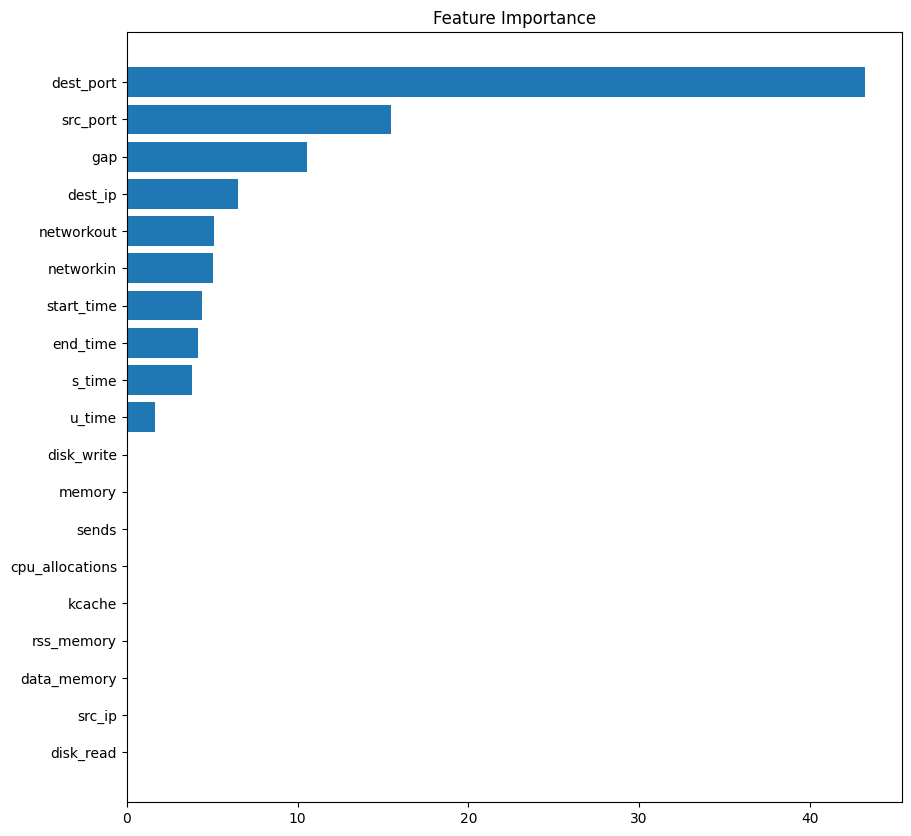

In [13]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(df_test.columns)[sorted_idx])
plt.title('Feature Importance')

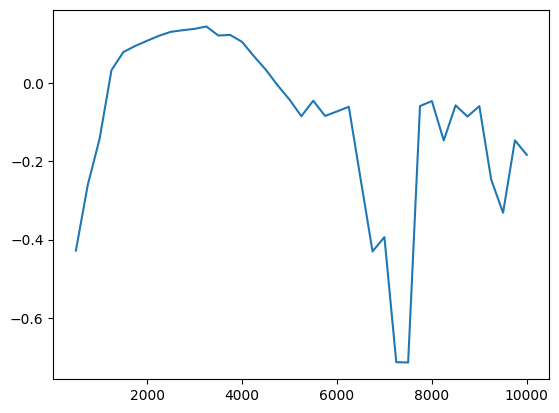

In [7]:
times = list(range(500, 10200, 250))
#r2sa = list(map(lambda x: x['test']['r2'], results))
r2sb = list(map(lambda x: x['test']['r2'], results2))
#r2sc = list(map(lambda x: x['test']['r2'], results3))

#plt.plot(times, r2sa)
plt.plot(times, r2sb)
#plt.plot(times, r2sc)

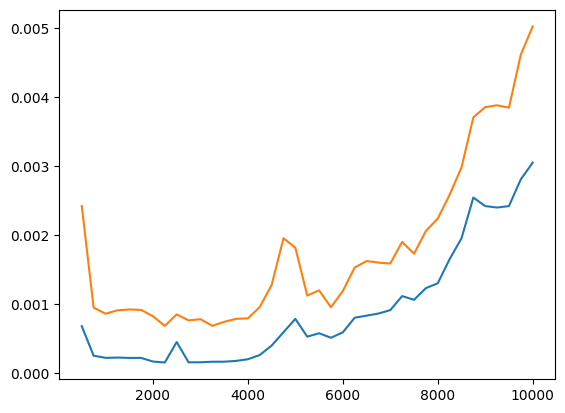

In [10]:
times = list(range(500, 10200, 250))
r2sa = list(map(lambda x: x['test']['mse'], results))
r2sb = list(map(lambda x: x['test']['mse'], results2))
#r2sc = list(map(lambda x: x['test']['r2'], results3))

plt.plot(times, r2sa)
plt.plot(times, r2sb)

In [24]:
flows_df = pd.read_csv(f"{FULL_PATH}/3000/full.csv")
flows_df[flows_df['gap'] >= 0].mean()

start_time         1.740198e+13
end_time           1.740199e+13
size               5.295881e+05
gap                6.566994e+05
src_ip             1.610000e+02
dest_ip            8.644808e+01
src_port           5.043082e+04
dest_port          4.012655e+04
networkin          1.246809e+12
networkout         1.245185e+12
disk_read          0.000000e+00
disk_write         4.096000e+03
memory             3.176186e+09
s_time             4.476790e+02
sends              0.000000e+00
cpu_allocations    0.000000e+00
rss_memory         3.091091e+08
data_memory        7.937761e+08
u_time             3.956486e+02
kcache             0.000000e+00
dtype: float64

In [23]:
flows_df = pd.read_csv(f"{FULL_PATH}/7000/full.csv")
flows_df[flows_df['gap'] >= 0].mean()

start_time         1.741233e+13
end_time           1.741239e+13
size               2.393556e+06
gap                1.036050e+06
src_ip             1.610000e+02
dest_ip            8.782301e+01
src_port           5.112792e+04
dest_port          4.036819e+04
networkin          1.278430e+12
networkout         1.276795e+12
disk_read          0.000000e+00
disk_write         4.096000e+03
memory             3.176186e+09
s_time             4.485947e+02
sends              0.000000e+00
cpu_allocations    0.000000e+00
rss_memory         3.091089e+08
data_memory        7.937761e+08
u_time             3.960481e+02
kcache             0.000000e+00
dtype: float64